In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from tqdm import tqdm

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return c * 6367 * 1000

#Read the CSV file
roadnetwork = pd.read_csv('2019.02.19.csv',nrows=58780)

# Create a dictionary mapping link ids to their respective start and end points
locations = roadnetwork["Location"].str.split().apply(lambda x: tuple(map(float, x))).tolist()
sp = [tuple(map(float, x.split()))[:2] for x in roadnetwork["Location"]]
ep = [tuple(map(float, x.split()))[2:] for x in roadnetwork["Location"]]

roadnetwork["StartPoint"]=sp
roadnetwork["EndPoint"]=ep

filtered_roadnetwork = roadnetwork[roadnetwork['MaximumSpeed'] != 999].copy()

average_speed_by_category = filtered_roadnetwork.groupby('RoadCategory')['MaximumSpeed'].mean()
# 将'MaximumSpeed'列中的None和999替换为相应的category均值
roadnetwork['MaximumSpeed'] = roadnetwork.apply(lambda row: average_speed_by_category[row['RoadCategory']] if pd.isna(row['MaximumSpeed']) or row['MaximumSpeed'] == 999 else row['MaximumSpeed'], axis=1)

#Calculate the center point for each link
roadnetwork["CenterPoint"] = roadnetwork[["StartPoint", "EndPoint"]].apply(lambda row: ((row["StartPoint"][0] + row["EndPoint"][0]) / 2, (row["StartPoint"][1] + row["EndPoint"][1]) / 2), axis=1)
#this is already half(length)
roadnetwork["length"] = roadnetwork.apply(lambda row: haversine(row["CenterPoint"][0], row["CenterPoint"][1], row["EndPoint"][0], row["EndPoint"][1])/ row['MaximumSpeed'], axis=1)
# Create separate "Latitude" and "Longitude" columns from "CenterPoint"
roadnetwork[["latitude","longitude" ]] = roadnetwork["CenterPoint"].apply(lambda point: pd.Series([point[0], point[1]]))

# Read the JSON file into a DataFrame(LU for landuse)
LU = pd.read_json('SG_landuse_wGPR.json')

# Define a function to round the coordinates
def round_coordinates(coords):
    for ring in coords['rings']:
        for coord in ring:
            coord[0] = round(coord[0], 13)
            coord[1] = round(coord[1], 13)
    return coords

def calculate_polygon_center(coords):
    num_points = 0
    x_sum = 0
    y_sum = 0

    for ring in coords['rings']:
        for x, y in ring:
            x_sum += x
            y_sum += y
            num_points += 1

    center_x = x_sum / num_points
    center_y = y_sum / num_points

    return center_x, center_y

def area_diameter(coords):
    
    max_longitude, max_latitude = float('-inf'), float('-inf')
    min_longitude, min_latitude = float('inf'), float('inf')

    for ring in coords['rings']:
        for coord in ring:
            lon, lat = coord[0], coord[1]
            max_longitude = max(max_longitude, lon)
            max_latitude = max(max_latitude, lat)
            min_longitude = min(min_longitude, lon)
            min_latitude = min(min_latitude, lat)
    
    distance = haversine(max_longitude, max_latitude, min_longitude, min_latitude)

    return distance

#only keep 'RESIDENTIAL', 'COMMERCIAL'
LU['LU_DESC'] = LU['attributes'].apply(lambda x: x['LU_DESC'])
LU = LU[LU['LU_DESC'].isin([ 'RESIDENTIAL', 'COMMERCIAL'])]

# Apply the function to the 'rings' list in the 'geometry' column（fixed fractional part)
LU['geometry'] = LU['geometry'].apply(round_coordinates)

# Calculate the center point
LU['center'] = LU['geometry'].apply(calculate_polygon_center)
LU['GPR_NUM'] = LU['attributes'].apply(lambda x: x['GPR_NUM'])
LU['SHAPE_Area'] = LU['attributes'].apply(lambda x: x['SHAPE_Area'])
LU['diameter']=LU['geometry'].apply(area_diameter)
LU[["longitude","latitude"]] = LU["center"].apply(lambda point: pd.Series([point[0], point[1]]))
LU.drop(columns=['attributes'], inplace=True)
LU.drop(columns=['geometry'], inplace=True)

#find the mean value of the 'GPR_NUM' column for their respective 'LU_DESC'
mean_gpr_by_lu = LU.groupby('LU_DESC')['GPR_NUM'].mean()

# Replace'GPR_NUM'0 or NaN to mean by group
LU['GPR_NUM'] = LU.apply(lambda row: mean_gpr_by_lu[row['LU_DESC']] if (row['GPR_NUM'] == 0 or pd.isnull(row['GPR_NUM'])) else row['GPR_NUM'], axis=1)

num_unique_LU_DESC = LU['LU_DESC'].nunique()
print("Number of different LU_DESC:", num_unique_LU_DESC)

unique_LU_DESC = LU['LU_DESC'].unique()
print("Different LU_DESC values:", unique_LU_DESC)

LU['EP']=LU['SHAPE_Area']*LU['GPR_NUM']

LU['No_nodes_around'] = np.zeros(len(LU))

# Define the area boundaries
min_lat, max_lat, min_lon, max_lon = [1.26523 , 1.3000 , 103.8130, 103.8600]

# small area
LU = LU[(LU['longitude'] >= min_lon) & 
        (LU['longitude'] <= max_lon) &
        (LU['latitude'] >= min_lat) & 
        (LU['latitude'] <= max_lat)]
roadnetwork = roadnetwork[(roadnetwork['longitude'] >= min_lon) & 
             (roadnetwork['longitude'] <= max_lon) &
             (roadnetwork['latitude'] >= min_lat) & 
             (roadnetwork['latitude'] <= max_lat)]

# loop through each unique LU_DESC value in test
for lu in LU['LU_DESC'].unique():
    filtered_test=LU[LU['LU_DESC']==lu]
    # Create a new column "EP" with zero values for all LU_DESC values
    roadnetwork["EP_"+lu] = np.zeros(len(roadnetwork))
    for land_index, land_row in tqdm(filtered_test.iterrows(),total=len(filtered_test[filtered_test['LU_DESC'] == lu]), desc="Processing one"):
        # initialize variables to keep track of nodes around
        nodes_around = []
        disofroad={}
        # loop through each row in the roadnetwork
        for node_index, node_row in roadnetwork.iterrows():
            # calculate distance between current node and current land in test
            dist = haversine(land_row['longitude'], land_row['latitude'], node_row['longitude'], node_row['latitude'])
            # if distance is around, add node to list
            if dist <= land_row['diameter']*2:
                nodes_around.append(node_index)
                disofroad[node_index] = dist
        print(disofroad)
        if len(nodes_around) == 0:
            LU.loc[land_index, 'No_nodes_around'] = 1
        # add EP values of filtered_test to node_df for nodes around
        if len(nodes_around) > 0:
            roadnetwork.loc[nodes_around, 'EP_'+lu] += land_row['EP'] / len(nodes_around) 

#print the number that have nodes around
print('the number that have nodes around',LU['No_nodes_around'].value_counts()[0],'total number',len(LU))
ep_columns = [col for col in roadnetwork.columns if "EP_" in col]
# use the max function to find the maximum value for each row, only including the specified columns
roadnetwork["max_EP"] = roadnetwork[ep_columns].max(axis=1)
# get the column index for the maximum value of the specified columns
max_cols = roadnetwork[ep_columns].idxmax(axis=1)
# extract the relevant part of the column name to get the corresponding LU_DESC value
max_EP_lu = max_cols.apply(lambda col: col.split("_")[1])
# add the new column to the dataframe
roadnetwork["max_EP_lu"] = max_EP_lu
roadnetwork.loc[roadnetwork["max_EP"] == 0, "max_EP_lu"] = 'None'
unique_max_EP_lu = roadnetwork['max_EP_lu'].unique()

# Create a new column 'group' by encoding the 'max_EP_lu' values as integers
roadnetwork['group'], _ = pd.factorize(roadnetwork['max_EP_lu'])
roadnetwork.to_csv('node.csv')

# Create a new empty graph
G = nx.DiGraph()
# Add all nodes to the graph with their attributes
for _, row in roadnetwork.iterrows():
    G.add_node(row['LinkID'], max_EP_lu=row['max_EP_lu'], group=row['group'], latitude=row['latitude'], longitude=row['longitude'], EP=row['max_EP'])
# Iterate over the rows in data frame
for _, row in tqdm(roadnetwork.iterrows(),total=len(roadnetwork),desc='Adding Edges'):
    # Check if the end point of a link matches the start point of another link
    next_links = roadnetwork[roadnetwork['StartPoint'] == row['EndPoint']]
    for _, next_row in next_links.iterrows():
        # Check if the start point of the next link equals the end point of the current link and vice versa
        if not ((row['StartPoint'] == next_row['EndPoint']) and (row['EndPoint'] == next_row['StartPoint'])):
            # Calculate the distance between the two nodes using the haversine function
            distance = row['length']+next_row['length']
            # Add an edge between the two nodes with the weight set to the distance between them
            G.add_edge(next_row['LinkID'], row['LinkID'], weight=distance) 

Number of different LU_DESC: 3
Different LU_DESC values: ['RESIDENTIAL' 'BUSINESS 1' 'COMMERCIAL']


Processing one:   0%|          | 1/638 [00:00<03:18,  3.20it/s]

{12937: 235.0865748607962, 12938: 235.0865748607962, 12939: 238.7064592799123, 12940: 238.7064592799123, 12941: 186.8636580309871, 12942: 144.90208566293063, 12943: 144.90208566293063, 12944: 152.21717808427536, 23044: 255.15889209232895, 23066: 170.19939054161821, 23067: 170.19939054161821, 23068: 126.41376163165455, 23069: 126.41376163165455, 28168: 41.44637964674228, 28169: 41.44637964674228, 28170: 185.9427099864898, 28171: 185.9427099864898, 28172: 129.9338237032382, 29719: 230.80260912943095, 29720: 153.44002757870652, 32501: 233.50631802121183, 32502: 233.50631802121183, 44661: 239.60641369613515, 44662: 239.60641369613515, 48518: 194.9432033182001, 48521: 115.4960650778464, 52848: 202.05351902911843, 52849: 202.05351902911843, 52850: 44.00576663105685, 52851: 44.00576663105685, 52857: 93.20222908520466, 52858: 93.20222908520466, 52923: 64.0023483582598, 52924: 64.0023483582598, 54263: 102.32090406500639, 54264: 102.32090406500639, 54265: 196.97399260637505}


Processing one:   0%|          | 2/638 [00:00<03:17,  3.23it/s]

{8916: 99.04020659436303, 8917: 99.04020659436303, 9600: 330.01812687342374, 9601: 254.80970896146925, 9719: 310.61165224976145, 9720: 286.3305874655554, 10031: 390.02563606014223, 11399: 359.0077972872279, 11400: 359.0077972872279, 18936: 235.6408833444708, 18937: 235.6408833444708, 22108: 268.37422586894274, 26180: 337.7371498087065, 26181: 337.7371498087065, 26186: 391.6717538603945, 26187: 391.6717538603945, 28223: 408.5037206565731, 33148: 113.99710434292423, 33149: 113.99710434292423, 35760: 181.88811326971316, 36344: 418.56908360828345, 36345: 418.56908360828345, 36358: 317.69224172813233, 38313: 354.24141332363826, 38314: 327.5311346910195, 39897: 108.58966275798042, 39898: 108.58966275798042, 41337: 378.6780847200578, 41338: 378.6780847200578, 41629: 256.4714895035714, 41630: 256.4714895035714, 45237: 343.73917288920103, 45238: 320.62616485919716, 45239: 320.62616485919716, 45281: 398.6695116931326, 46776: 305.4198732223877, 46777: 305.4198732223877, 46778: 365.0888616907673, 

Processing one:   0%|          | 3/638 [00:00<03:01,  3.49it/s]

{4732: 239.41341627811622, 4733: 239.41341627811622, 7921: 768.3654351950512, 7922: 768.3654351950512, 7923: 655.1929244269861, 7924: 655.1929244269861, 8916: 427.278915604011, 8917: 427.278915604011, 9569: 595.8474124051843, 9570: 595.8474124051843, 9571: 609.8742618635025, 9572: 609.8742618635025, 9600: 386.51587202784617, 9601: 337.96829314030015, 9630: 99.39567765039094, 9631: 99.39567765039094, 9773: 617.6630830252263, 9830: 212.033457459679, 9831: 212.033457459679, 10030: 250.83504254682737, 10031: 251.03622405671254, 10453: 769.0869342718922, 10454: 739.3354801512133, 10455: 667.7308123518596, 11348: 716.4780193487594, 11349: 716.4780193487594, 11350: 758.5779194569158, 11351: 758.5779194569158, 11399: 662.2107244653356, 11400: 662.2107244653356, 12774: 288.91342291702455, 12775: 288.91342291702455, 12776: 247.4107145227332, 12777: 247.4107145227332, 12778: 342.8054656585047, 12779: 342.8054656585047, 13963: 744.4607855917889, 13964: 744.4607855917889, 17146: 397.4222464719696, 

Processing one:   1%|          | 4/638 [00:01<02:56,  3.58it/s]

{4732: 368.5798683339424, 4733: 368.5798683339424, 9630: 269.24169508819205, 9631: 269.24169508819205, 9830: 86.58944958695051, 9831: 86.58944958695051, 12774: 225.64342230648154, 12775: 225.64342230648154, 12776: 259.36303978663443, 12777: 259.36303978663443, 12778: 371.31864088674683, 12779: 371.31864088674683, 17188: 297.7629127340347, 17189: 297.7629127340347, 17275: 154.8329013564529, 17276: 154.8329013564529, 17277: 181.5240249400746, 17278: 181.5240249400746, 17280: 104.90624330737695, 17281: 104.90624330737695, 17282: 99.55483215858644, 17283: 99.55483215858644, 18778: 278.77664599668753, 21576: 138.52075885742767, 21577: 138.52075885742767, 28088: 296.34217613845686, 28089: 296.34217613845686, 28099: 191.14121013134735, 28100: 191.14121013134735, 28219: 352.5736537315673, 28220: 352.5736537315673, 28223: 362.3522998286266, 29018: 363.11214616981795, 29019: 363.11214616981795, 29309: 271.8493529425545, 31554: 142.75364022870997, 31555: 142.75364022870997, 32704: 367.73288465638

Processing one:   1%|          | 5/638 [00:01<02:59,  3.52it/s]

{9569: 319.4403723140568, 9570: 319.4403723140568, 9830: 135.7327628395149, 9831: 135.7327628395149, 17275: 217.6261987001816, 17276: 217.6261987001816, 17277: 102.72354208434916, 17278: 102.72354208434916, 17280: 196.72970295586975, 17281: 196.72970295586975, 17282: 173.6794783080763, 17283: 173.6794783080763, 18778: 291.96854242117394, 21576: 210.2383571101528, 21577: 210.2383571101528, 28099: 19.74631124060854, 28100: 19.74631124060854, 32704: 308.95156352593057, 32705: 308.95156352593057, 32989: 175.6548960668384, 33351: 285.2476924112593, 36344: 284.890684546563, 36345: 284.890684546563, 38843: 264.77962760705964, 38844: 264.77962760705964, 38845: 244.37492341878672, 38846: 244.37492341878672, 41337: 263.7121867309503, 41338: 263.7121867309503, 47268: 264.8894682639904, 47269: 264.8894682639904, 47335: 242.5623882070734, 47336: 242.5623882070734, 47337: 237.98702149348003, 47338: 237.98702149348003, 47381: 246.09180371677311, 47382: 246.09180371677311, 47452: 297.81347203562405, 4

Processing one:   1%|          | 6/638 [00:01<02:48,  3.74it/s]

{4732: 357.22068301085403, 4733: 357.22068301085403, 9571: 378.60691690924625, 9572: 378.60691690924625, 9630: 344.933030125001, 9631: 344.933030125001, 9830: 218.83278897034975, 9831: 218.83278897034975, 12774: 95.09823835140958, 12775: 95.09823835140958, 12776: 174.99245846868283, 12777: 174.99245846868283, 12778: 276.31633733905164, 12779: 276.31633733905164, 17188: 179.95122465314915, 17189: 179.95122465314915, 17275: 78.59650410833082, 17276: 78.59650410833082, 17277: 200.82921064675446, 17278: 200.82921064675446, 17280: 71.92345142395294, 17281: 71.92345142395294, 17282: 94.86726864867764, 17283: 94.86726864867764, 18778: 179.79704493081127, 19090: 361.5067666222411, 19091: 361.5067666222411, 21576: 278.30037386583984, 21577: 278.30037386583984, 28020: 315.49784587370596, 28021: 315.49784587370596, 28088: 310.8256769665952, 28089: 310.8256769665952, 28099: 279.3320429359286, 28100: 279.3320429359286, 28965: 355.21084324878, 28966: 355.21084324878, 29018: 376.41127281306103, 29019

Processing one:   1%|          | 7/638 [00:01<02:40,  3.93it/s]

{9569: 193.70478326038977, 9570: 193.70478326038977, 9571: 145.39718999095123, 9572: 145.39718999095123, 9588: 442.0865681934367, 9589: 442.0865681934367, 9590: 490.12821357857456, 9591: 490.12821357857456, 9830: 386.863864499811, 9831: 386.863864499811, 12774: 268.3996995010999, 12775: 268.3996995010999, 12776: 381.44341562720314, 12777: 381.44341562720314, 12778: 442.4661493455948, 12779: 442.4661493455948, 16256: 510.2899348364344, 16257: 510.2899348364344, 16258: 500.0304767338246, 16259: 500.0304767338246, 17131: 515.4467665541708, 17132: 515.4467665541708, 17188: 86.18257437897323, 17189: 86.18257437897323, 17275: 193.88071568557484, 17276: 193.88071568557484, 17277: 234.71715468249968, 17278: 234.71715468249968, 17280: 243.03262387926088, 17281: 243.03262387926088, 17282: 247.77419674117678, 17283: 247.77419674117678, 18778: 70.63034491155825, 19090: 187.42793346482057, 19091: 187.42793346482057, 21576: 470.8807936962441, 21577: 470.8807936962441, 28020: 485.05814506806075, 2802

Processing one:   1%|▏         | 9/638 [00:02<02:29,  4.22it/s]

{9588: 446.3185118736752, 9589: 446.3185118736752, 9590: 567.7712825976265, 9591: 567.7712825976265, 9594: 263.8978389157204, 9595: 263.8978389157204, 9705: 451.17083990309317, 9706: 451.17083990309317, 9707: 540.1492763576988, 9708: 540.1492763576988, 14975: 671.5491433828444, 14976: 671.5491433828444, 14977: 652.384235496556, 14978: 652.384235496556, 16254: 579.7362916418771, 16255: 579.7362916418771, 16256: 421.00406800914607, 16257: 421.00406800914607, 16258: 470.8408882356586, 16259: 470.8408882356586, 17131: 365.1734022838151, 17132: 365.1734022838151, 29403: 454.30797222061557, 29404: 454.30797222061557, 29490: 622.5585700914074, 29491: 622.5585700914074, 29496: 660.5225807863366, 31597: 181.03259888950265, 31598: 181.03259888950265, 33168: 643.2026655165097, 33169: 643.2026655165097, 35923: 677.8352568694065, 35924: 677.8352568694065, 35930: 353.01628365662725, 35931: 353.01628365662725, 36153: 318.73696954286714, 36154: 318.73696954286714, 43174: 589.4799975140455, 43175: 589.

Processing one:   2%|▏         | 10/638 [00:02<02:24,  4.33it/s]

{9743: 349.7957635147851, 9744: 349.7957635147851, 9745: 221.97163758684522, 9746: 221.97163758684522, 9747: 186.71653490802677, 9748: 186.71653490802677, 9878: 302.67242069026946, 9879: 201.541259468835, 9880: 259.2423002035142, 9881: 427.5106920129893, 10043: 434.84086509708544, 12213: 450.2406491510142, 12214: 450.2406491510142, 14945: 326.59278257522067, 14946: 326.59278257522067, 14971: 302.1665197166607, 14972: 302.1665197166607, 14973: 304.43760993953543, 14974: 304.43760993953543, 18930: 324.8662142047803, 22449: 388.0176548878622, 22450: 388.0176548878622, 25760: 437.25464064074583, 25761: 437.25464064074583, 25895: 355.06920945752427, 25896: 355.06920945752427, 26428: 357.0184865634512, 26429: 357.0184865634512, 28406: 199.69800168086815, 33567: 435.0665981680993, 34500: 199.2505848896441, 34501: 206.12258438225442, 34508: 466.4547067945401, 34509: 466.4547067945401, 34510: 396.5550540194598, 35744: 441.93442991185407, 35745: 365.2035138950349, 36561: 408.6363842356166, 36562

Processing one:   2%|▏         | 12/638 [00:02<02:19,  4.48it/s]

{529: 871.1463364519516, 530: 860.4950584670823, 3096: 227.03787611062458, 3097: 363.99515394808736, 4732: 1185.1106356282653, 4733: 1185.1106356282653, 4796: 1170.4760184833005, 4797: 1170.4760184833005, 4798: 740.7464376851796, 4799: 740.7464376851796, 4893: 912.2100850018816, 4894: 912.2100850018816, 7058: 1052.1178177163679, 7059: 1052.1178177163679, 7060: 967.515598074302, 7061: 967.515598074302, 7719: 589.9506825674598, 7720: 756.9784983025721, 7721: 756.9784983025721, 7722: 610.6055127092636, 7723: 610.6055127092636, 7734: 158.98766428885736, 7735: 158.98766428885736, 7793: 1371.5545961075522, 7794: 1371.5545961075522, 7795: 800.9122433407995, 7796: 800.9122433407995, 7799: 737.9751757966255, 7813: 1519.821841841948, 7814: 1519.821841841948, 7820: 1457.4521575666058, 7821: 1457.4521575666058, 7822: 1446.477757587815, 7823: 1446.477757587815, 7921: 830.4272144084119, 7922: 830.4272144084119, 7923: 729.1074845798263, 7924: 729.1074845798263, 8822: 340.33096638056173, 8823: 460.311

Processing one:   2%|▏         | 14/638 [00:03<02:19,  4.47it/s]

{4732: 467.2213337999284, 4733: 467.2213337999284, 7923: 396.07223953674645, 7924: 396.07223953674645, 8916: 285.6027141846999, 8917: 285.6027141846999, 9600: 57.46792128304648, 9601: 86.76827964518421, 9630: 321.08904654367575, 9631: 321.08904654367575, 10030: 223.66237718401757, 10031: 182.50049487604568, 10453: 446.39192651908434, 10454: 394.01821502322474, 10455: 306.4844021580756, 11348: 308.57422470731035, 11349: 308.57422470731035, 11350: 354.59500373415483, 11351: 354.59500373415483, 11352: 481.12952340166623, 11353: 481.12952340166623, 11399: 249.64185395145049, 11400: 249.64185395145049, 13963: 492.03104471114284, 13964: 492.03104471114284, 18936: 222.3691594834005, 18937: 222.3691594834005, 19174: 188.49801412252572, 19175: 188.49801412252572, 19180: 351.2073589065239, 19181: 351.2073589065239, 21576: 473.2651255737835, 21577: 473.2651255737835, 22108: 149.07565946484004, 25876: 437.2818637231729, 25877: 452.69837415562455, 26186: 459.2437711377741, 26187: 459.2437711377741,

Processing one:   2%|▏         | 15/638 [00:03<02:21,  4.40it/s]

{8916: 162.13121502708967, 8917: 162.13121502708967, 9600: 177.4833267275131, 9601: 76.56605668251083, 9630: 261.0202497589391, 9631: 261.0202497589391, 10030: 245.1119253794008, 10031: 189.92519620511962, 11399: 368.22023123322225, 11400: 368.22023123322225, 18936: 291.50680559846006, 18937: 291.50680559846006, 19174: 340.5635452238664, 19175: 340.5635452238664, 21576: 342.87722353893133, 21577: 342.87722353893133, 22108: 65.11263903054177, 28088: 394.1475825884745, 28089: 394.1475825884745, 28219: 278.9770542339881, 28220: 278.9770542339881, 28223: 205.1784945012389, 29018: 398.5848400867997, 29019: 398.5848400867997, 33148: 250.02109428412496, 33149: 250.02109428412496, 35712: 332.8859934908985, 35713: 332.8859934908985, 35760: 47.55672794811762, 36344: 275.38295409291095, 36345: 275.38295409291095, 36358: 114.7480899142114, 38313: 257.2024918511752, 38314: 124.67844742111828, 39897: 97.13358480518102, 39898: 97.13358480518102, 41337: 315.5413376196586, 41338: 315.5413376196586, 416

Processing one:   3%|▎         | 16/638 [00:03<02:24,  4.30it/s]

{4732: 435.3749469479692, 4733: 435.3749469479692, 7921: 410.9163911671902, 7922: 410.9163911671902, 7923: 243.5697949103299, 7924: 243.5697949103299, 8916: 440.1911023951461, 8917: 440.1911023951461, 9600: 117.4672962325668, 9601: 218.83676241577717, 9630: 364.77247159377185, 9631: 364.77247159377185, 10030: 219.20722394112335, 10031: 214.54612841408817, 10453: 316.94639087221555, 10454: 277.7709806244482, 10455: 203.68086103481286, 11348: 287.0828751504332, 11349: 287.0828751504332, 11350: 316.8665549588619, 11351: 316.8665549588619, 11399: 274.88339202656795, 11400: 274.88339202656795, 13963: 340.71326362084653, 13964: 340.71326362084653, 17146: 451.1961522821141, 17147: 451.1961522821141, 18936: 316.6081263128824, 18937: 316.6081263128824, 19174: 110.27227796015423, 19175: 110.27227796015423, 19180: 217.3265134356915, 19181: 217.3265134356915, 22108: 266.24456475797444, 25876: 348.4491752440041, 25877: 401.250301252147, 28088: 420.01167950567856, 28089: 420.01167950567856, 28219: 2

Processing one:   3%|▎         | 17/638 [00:04<02:27,  4.20it/s]

{9600: 74.64979151275394, 9601: 161.7607121232731, 10030: 137.23864490459593, 10031: 128.89158586829274, 38313: 139.9930429923677, 41629: 176.621844839778, 41630: 176.621844839778, 45281: 19.245209396789434, 50032: 87.29083703138518}


Processing one:   3%|▎         | 18/638 [00:04<02:28,  4.18it/s]

{9600: 93.00206149697888, 19174: 90.12444019749017, 19175: 90.12444019749017, 38313: 31.277150791273982, 41629: 114.80305764689929, 41630: 114.80305764689929, 45281: 126.28455068777264, 50032: 26.922646407384835}


Processing one:   3%|▎         | 19/638 [00:04<02:30,  4.10it/s]

{4732: 222.26787523410584, 4733: 222.26787523410584, 7813: 433.4850127705512, 7814: 433.4850127705512, 7921: 438.07015363086344, 7922: 438.07015363086344, 7923: 430.163195178791, 7924: 430.163195178791, 9600: 474.6033386629736, 9630: 404.1435496851527, 9631: 404.1435496851527, 9773: 380.5949376240331, 10030: 339.7532174123819, 10031: 394.8980584842158, 12776: 409.55478410040604, 12777: 409.55478410040604, 12778: 365.1521685757011, 12779: 365.1521685757011, 13963: 474.4138777947164, 13964: 474.4138777947164, 17146: 70.4535080710032, 17147: 70.4535080710032, 28020: 328.56630639248766, 28021: 328.56630639248766, 28088: 299.364941166929, 28089: 299.364941166929, 28219: 327.9531478955966, 28220: 327.9531478955966, 28223: 392.4279749652915, 28965: 463.9024611249862, 28966: 463.9024611249862, 29018: 239.96692947442665, 29019: 239.96692947442665, 29113: 362.5343617437604, 29114: 362.5343617437604, 29115: 323.2364402466497, 29116: 323.2364402466497, 29304: 241.8687269121946, 31554: 454.52113407

Processing one:   3%|▎         | 20/638 [00:04<02:31,  4.08it/s]

{4732: 212.00783858258157, 4733: 212.00783858258157, 7813: 691.6740541098721, 7814: 691.6740541098721, 7921: 471.2064735803858, 7922: 471.2064735803858, 7923: 361.667675518539, 7924: 361.667675518539, 8916: 486.6529380624464, 8917: 486.6529380624464, 9600: 223.15188609896995, 9601: 267.62463996591936, 9630: 209.63766555465327, 9631: 209.63766555465327, 9700: 728.1623109157698, 9773: 592.8780577013821, 9830: 506.0976240724131, 9831: 506.0976240724131, 10030: 84.45231617502068, 10031: 137.5651087038647, 10453: 487.0588136862714, 10454: 468.9669236704912, 10455: 413.1053108189905, 11348: 510.16040817943485, 11349: 510.16040817943485, 11350: 540.0439634078557, 11351: 540.0439634078557, 11399: 488.43146521819403, 11400: 488.43146521819403, 12774: 508.820630125876, 12775: 508.820630125876, 12776: 411.3918828086392, 12777: 411.3918828086392, 12778: 437.9346805483164, 12779: 437.9346805483164, 13963: 447.7096615547236, 13964: 447.7096615547236, 17146: 252.4677507037146, 17147: 252.467750703714

Processing one:   3%|▎         | 21/638 [00:05<02:27,  4.19it/s]

{4732: 259.9896449631712, 4733: 259.9896449631712, 8916: 342.9029994995723, 8917: 342.9029994995723, 9600: 246.39482231833367, 9601: 203.0082140807385, 9630: 50.86892251913769, 9631: 50.86892251913769, 9830: 318.5017246202158, 9831: 318.5017246202158, 10030: 132.4715254433587, 10031: 115.32358653060453, 12774: 421.7908317355954, 12775: 421.7908317355954, 12776: 360.01563817548475, 12777: 360.01563817548475, 12778: 435.4430379362087, 12779: 435.4430379362087, 17146: 389.4442257127084, 17147: 389.4442257127084, 17275: 442.3068485775459, 17276: 442.3068485775459, 17277: 480.2084557001265, 17278: 480.2084557001265, 17280: 395.660050555753, 17281: 395.660050555753, 17282: 397.8823688817596, 17283: 397.8823688817596, 18936: 479.6865824521495, 18937: 479.6865824521495, 19174: 424.00920708376276, 19175: 424.00920708376276, 21576: 250.64397692281827, 21577: 250.64397692281827, 22108: 152.25524744591553, 28020: 439.74826171411667, 28021: 439.74826171411667, 28088: 185.5454037038043, 28089: 185.5

Processing one:   4%|▍         | 24/638 [00:05<02:14,  4.58it/s]

{4732: 83.137100733, 4733: 83.137100733, 9600: 473.01325762123236, 9601: 467.83416816901894, 9630: 231.09272796782912, 9631: 231.09272796782912, 9773: 406.27071985890774, 9830: 384.99930178103443, 9831: 384.99930178103443, 10030: 298.64771358669157, 10031: 335.8166571753253, 12774: 242.228331629816, 12775: 242.228331629816, 12776: 133.10351158632085, 12777: 133.10351158632085, 12778: 162.6316183133785, 12779: 162.6316183133785, 17146: 224.62540616699175, 17147: 224.62540616699175, 17188: 425.5808440977125, 17189: 425.5808440977125, 17275: 357.4555765630413, 17276: 357.4555765630413, 17277: 464.11225233809915, 17278: 464.11225233809915, 17280: 334.27179513579625, 17281: 334.27179513579625, 17282: 351.68172827383916, 17283: 351.68172827383916, 18778: 444.7243803620635, 21576: 378.7656587625064, 21577: 378.7656587625064, 22108: 427.2840263432378, 28020: 161.31129334286535, 28021: 161.31129334286535, 28088: 96.13790571341552, 28089: 96.13790571341552, 28219: 226.12624423957152, 28220: 226.

Processing one:   4%|▍         | 25/638 [00:05<02:12,  4.63it/s]

{9600: 164.10231396769063, 9601: 200.38468199920848, 9630: 185.34106106040508, 9631: 185.34106106040508, 10030: 32.85523678745027, 10031: 73.75039332775668, 22108: 198.3186867214695, 28088: 228.3569874160239, 28089: 228.3569874160239, 28219: 106.95988404330387, 28220: 106.95988404330387, 28223: 103.89035577422136, 29018: 192.04278212307133, 29019: 192.04278212307133, 35712: 163.6097941131096, 35713: 163.6097941131096, 36358: 165.66681664998796, 38314: 159.6760214031115, 45237: 149.26436246421542, 45238: 186.66660292600912, 45239: 186.66660292600912, 45281: 99.66477930289099, 50032: 200.81824947726028}
{4732: 388.0638739217307, 4733: 388.0638739217307, 7793: 613.2124509191285, 7794: 613.2124509191285, 7795: 751.3742618652146, 7796: 751.3742618652146, 7799: 688.5904494064521, 7813: 422.85380208411664, 7814: 422.85380208411664, 7921: 313.2551322055712, 7922: 313.2551322055712, 7923: 368.6683422390459, 7924: 368.6683422390459, 8916: 846.0079153206458, 8917: 846.0079153206458, 9600: 541.692

Processing one:   4%|▍         | 27/638 [00:06<02:09,  4.71it/s]

{4732: 243.60883506465802, 4733: 243.60883506465802, 12774: 151.57054939352918, 12775: 151.57054939352918, 12776: 83.90690246811255, 12777: 83.90690246811255, 12778: 42.08478658390118, 12779: 42.08478658390118, 17275: 307.02071899059143, 17276: 307.02071899059143, 17280: 308.6546246495367, 17281: 308.6546246495367, 28020: 84.76240128131445, 28021: 84.76240128131445, 28088: 262.2120393466646, 28089: 262.2120393466646, 28965: 152.97138061541577, 28966: 152.97138061541577, 29018: 298.2872661888579, 29019: 298.2872661888579, 29309: 276.04985662743763, 31554: 219.35126023320174, 31555: 219.35126023320174, 32745: 191.24609403181907, 33351: 269.49943892056206, 38843: 305.9526967416475, 38844: 305.9526967416475, 38845: 305.2130302464599, 38846: 305.2130302464599, 42511: 147.7192072731332, 42512: 147.7192072731332, 44833: 234.47877985781057, 44834: 234.47877985781057, 45134: 204.72751039000596, 45135: 204.72751039000596, 45356: 108.93556855084874, 45357: 108.93556855084874, 46793: 294.113269019

Processing one:   5%|▍         | 29/638 [00:06<02:08,  4.75it/s]

{12774: 42.38119143595941, 12775: 42.38119143595941, 12776: 76.25320162996181, 12777: 76.25320162996181, 12778: 151.1111461653139, 12779: 151.1111461653139, 17188: 221.24460209918598, 17189: 221.24460209918598, 17275: 197.08993558318602, 17276: 197.08993558318602, 17280: 201.5739654394214, 17281: 201.5739654394214, 17282: 224.51030055319967, 17283: 224.51030055319967, 18778: 248.2648583644684, 28020: 192.60383957418833, 28021: 192.60383957418833, 28088: 276.73621989020813, 28089: 276.73621989020813, 28965: 229.76968626110144, 28966: 229.76968626110144, 29309: 179.73052199833015, 31554: 161.05638582744817, 31555: 161.05638582744817, 32745: 289.12433664400294, 32989: 226.05794571335596, 33351: 162.64819547341054, 38843: 199.0554150042633, 38844: 199.0554150042633, 38845: 196.16642996324163, 38846: 196.16642996324163, 42511: 255.5511422415565, 42512: 255.5511422415565, 43555: 261.1863943850986, 43556: 261.1863943850986, 45134: 268.9099990563944, 45135: 268.9099990563944, 45356: 200.588782

Processing one:   5%|▍         | 30/638 [00:07<02:08,  4.74it/s]

{4732: 452.77992617167473, 4733: 452.77992617167473, 7793: 825.9255907879638, 7794: 825.9255907879638, 7813: 202.62078253109806, 7814: 202.62078253109806, 7921: 771.5875426994033, 7922: 771.5875426994033, 7923: 809.072987803796, 7924: 809.072987803796, 9588: 719.1373091940004, 9589: 719.1373091940004, 9590: 544.0504079322742, 9591: 544.0504079322742, 9600: 840.8816062506298, 9618: 171.99555269659828, 9630: 670.7838791153555, 9631: 670.7838791153555, 9662: 376.66024448542026, 9663: 376.66024448542026, 9707: 753.8566419814356, 9708: 753.8566419814356, 9773: 54.47390957379022, 9830: 805.9211272829294, 9831: 805.9211272829294, 10030: 679.0628037057284, 10031: 730.9624153688654, 10032: 726.6062292880918, 10033: 797.4316340248176, 10034: 797.4316340248176, 10458: 282.4927064553236, 10459: 282.4927064553236, 10460: 344.0549232034595, 10461: 344.0549232034595, 11370: 694.5559353553462, 11371: 694.5559353553462, 11372: 847.2976875519847, 11373: 847.2976875519847, 12774: 534.2171530035083, 12775

Processing one:   5%|▌         | 32/638 [00:07<02:07,  4.75it/s]

{9571: 317.30511255519065, 9572: 317.30511255519065, 12774: 119.3525235485357, 12775: 119.3525235485357, 12776: 224.25989140096203, 12777: 224.25989140096203, 12778: 271.33174342303823, 12779: 271.33174342303823, 17188: 88.71155769933884, 17189: 88.71155769933884, 17275: 167.4245453434594, 17276: 167.4245453434594, 17277: 287.4483948436233, 17278: 287.4483948436233, 17280: 205.80649645330368, 17281: 205.80649645330368, 17282: 224.72806737706358, 17283: 224.72806737706358, 18778: 132.46533736721233, 19090: 209.24499251947213, 19091: 209.24499251947213, 28020: 313.67860667553117, 28021: 313.67860667553117, 28965: 276.26214928349447, 28966: 276.26214928349447, 29309: 58.64622434808972, 31554: 277.15175270103583, 31555: 277.15175270103583, 32704: 255.46605968072433, 32705: 255.46605968072433, 32989: 214.2441050978582, 33166: 252.1713412580921, 33167: 252.1713412580921, 33351: 97.40665393147499, 38843: 120.1296679875637, 38844: 120.1296679875637, 38845: 137.85912462588797, 38846: 137.859124

Processing one:   5%|▌         | 33/638 [00:07<02:13,  4.54it/s]

{4732: 360.8583037661173, 4733: 360.8583037661173, 9590: 386.809963874887, 9591: 386.809963874887, 9662: 387.5718973076054, 9663: 387.5718973076054, 9773: 354.0092137142956, 12774: 158.65073910716274, 12775: 158.65073910716274, 12776: 173.66338661468663, 12777: 173.66338661468663, 12778: 142.84858729667576, 12779: 142.84858729667576, 17146: 438.41715444232585, 17147: 438.41715444232585, 17188: 254.54286794091945, 17189: 254.54286794091945, 17275: 300.8632524597466, 17276: 300.8632524597466, 17277: 432.73334945562266, 17278: 432.73334945562266, 17280: 320.9496077296126, 17281: 320.9496077296126, 17282: 343.70003910093345, 17283: 343.70003910093345, 18778: 298.7180747154361, 19090: 296.9854388200836, 19091: 296.9854388200836, 28020: 177.78557232556474, 28021: 177.78557232556474, 28088: 374.73843018100166, 28089: 374.73843018100166, 28965: 111.1995213829105, 28966: 111.1995213829105, 29018: 414.75147569002627, 29019: 414.75147569002627, 29309: 223.61160679759726, 31554: 295.12332471852034

Processing one:   5%|▌         | 34/638 [00:07<02:20,  4.30it/s]

{32727: 36.72326889389954, 32728: 36.72326889389954, 32731: 69.03312307274243, 32732: 69.03312307274243, 45258: 71.732914642056, 45259: 71.732914642056, 54244: 33.84215560156451, 54245: 33.84215560156451, 54246: 31.37048936294171, 54247: 31.37048936294171}


Processing one:   5%|▌         | 35/638 [00:08<02:23,  4.19it/s]

{9590: 123.78508103408433, 9591: 123.78508103408433, 32727: 99.48245734821536, 32728: 99.48245734821536, 32731: 135.92120551876076, 32732: 135.92120551876076, 45240: 176.10610629171794, 45241: 176.10610629171794, 45250: 147.3384980130414, 45251: 147.3384980130414, 45258: 154.21810584724366, 45259: 154.21810584724366, 45282: 162.101761031679, 45283: 162.101761031679, 46793: 127.73669828095963, 46794: 127.73669828095963, 54134: 168.44327238812392, 54135: 168.44327238812392, 54244: 130.6722529309464, 54245: 130.6722529309464, 54246: 69.93429163976555, 54247: 69.93429163976555}


Processing one:   6%|▌         | 36/638 [00:08<02:30,  4.01it/s]

{32727: 51.21034159245408, 32728: 51.21034159245408, 54246: 31.814923571623243, 54247: 31.814923571623243}


Processing one:   6%|▌         | 37/638 [00:08<02:30,  3.98it/s]

{32727: 61.21113366439006, 32728: 61.21113366439006, 54244: 60.90338938434934, 54245: 60.90338938434934, 54246: 31.016044391874015, 54247: 31.016044391874015}


Processing one:   6%|▌         | 38/638 [00:08<02:32,  3.93it/s]

{32727: 37.999232072300174, 32728: 37.999232072300174, 54246: 20.25441695262805, 54247: 20.25441695262805}


Processing one:   6%|▌         | 39/638 [00:09<02:30,  3.97it/s]

{9590: 54.53041228277248, 9591: 54.53041228277248, 9662: 147.77658063117153, 9663: 147.77658063117153, 32727: 119.56965416003916, 32728: 119.56965416003916, 32731: 155.34619532855683, 32732: 155.34619532855683, 45240: 82.8527093561505, 45241: 82.8527093561505, 45250: 47.61395412104291, 45251: 47.61395412104291, 45258: 79.69021062010376, 45259: 79.69021062010376, 45282: 162.8420106904312, 45283: 162.8420106904312, 52986: 158.86593812574466, 52987: 158.86593812574466, 54244: 92.03541250191047, 54245: 92.03541250191047, 54246: 91.31733957431403, 54247: 91.31733957431403, 54269: 129.8160325222685, 54270: 129.8160325222685}


Processing one:   6%|▋         | 40/638 [00:09<02:31,  3.95it/s]

{32727: 16.521929289139837, 32728: 16.521929289139837, 32731: 54.68353048278261, 32732: 54.68353048278261, 46793: 76.12999289532037, 46794: 76.12999289532037, 54244: 68.47852941021138, 54245: 68.47852941021138, 54246: 21.67370984977833, 54247: 21.67370984977833}


Processing one:   6%|▋         | 41/638 [00:09<02:32,  3.92it/s]

{32727: 69.90623465671003, 32728: 69.90623465671003, 54246: 35.20974441678314, 54247: 35.20974441678314}


Processing one:   7%|▋         | 42/638 [00:10<02:31,  3.92it/s]

{9590: 111.27961134710766, 9591: 111.27961134710766, 9662: 89.50104201671077, 9663: 89.50104201671077, 14975: 135.55054498568674, 14976: 135.55054498568674, 14977: 213.33407117898764, 14978: 213.33407117898764, 29490: 182.72302756235038, 29491: 182.72302756235038, 29496: 174.4518291057982, 32727: 94.74818330507618, 32728: 94.74818330507618, 32731: 120.50234951880857, 32732: 120.50234951880857, 45240: 48.05934363394395, 45241: 48.05934363394395, 45250: 39.306929853652335, 45251: 39.306929853652335, 45258: 23.674984096827412, 45259: 23.674984096827412, 45282: 220.92211056630217, 45283: 220.92211056630217, 46793: 168.45102888259686, 46794: 168.45102888259686, 46799: 183.13181172583447, 46800: 183.13181172583447, 46801: 223.92513507090612, 52986: 135.19234730611316, 52987: 135.19234730611316, 53019: 219.21233625559861, 53020: 219.21233625559861, 53862: 179.07510686269345, 53863: 179.07510686269345, 54132: 218.01954277124656, 54133: 218.01954277124656, 54244: 42.88044202496773, 54245: 42.88

Processing one:   7%|▋         | 43/638 [00:10<02:31,  3.92it/s]

{32727: 49.77089298463103, 32728: 49.77089298463103, 54244: 49.307759202644256, 54245: 49.307759202644256, 54246: 25.420456547100585, 54247: 25.420456547100585}


Processing one:   7%|▋         | 44/638 [00:10<02:28,  4.01it/s]

{32727: 64.98093153428933, 32728: 64.98093153428933, 54244: 71.34011524325162, 54245: 71.34011524325162, 54246: 31.55640481084692, 54247: 31.55640481084692}


Processing one:   7%|▋         | 45/638 [00:10<02:22,  4.15it/s]

{9662: 88.9010124060302, 9663: 88.9010124060302, 10458: 230.72310677386648, 10459: 230.72310677386648, 10460: 203.25703614019633, 10461: 203.25703614019633, 14975: 142.62058610017604, 14976: 142.62058610017604, 14977: 206.2619331361496, 14978: 206.2619331361496, 28015: 203.94073897055574, 28016: 203.94073897055574, 29490: 209.62056292706006, 29491: 209.62056292706006, 29496: 172.87679946873183, 32727: 179.19730288307815, 32728: 179.19730288307815, 32731: 155.8285820087601, 32732: 155.8285820087601, 45240: 177.09588523819735, 45241: 177.09588523819735, 45250: 204.48146394614204, 45251: 204.48146394614204, 45255: 145.78111651623476, 45256: 145.78111651623476, 45258: 158.02563423574804, 45259: 158.02563423574804, 45261: 203.25703614019633, 45363: 229.71621075145953, 46793: 213.09499306437112, 46794: 213.09499306437112, 46799: 158.5647873457737, 46800: 158.5647873457737, 46801: 221.404593343354, 52831: 247.65166181571823, 52832: 247.65166181571823, 52986: 205.4726905192666, 52987: 205.4726

Processing one:   7%|▋         | 47/638 [00:11<02:13,  4.42it/s]

{9590: 68.10167433185897, 9591: 68.10167433185897, 9662: 131.9490186132619, 9663: 131.9490186132619, 32727: 116.75336000369342, 32728: 116.75336000369342, 45240: 65.68754139086882, 45241: 65.68754139086882, 45250: 31.310880572502413, 45251: 31.310880572502413, 45258: 63.1681702513535, 45259: 63.1681702513535, 52986: 144.1374066416533, 52987: 144.1374066416533, 54244: 80.91497254459802, 54245: 80.91497254459802, 54246: 92.29748230774038, 54247: 92.29748230774038, 54269: 120.70085573778896, 54270: 120.70085573778896}
{}


Processing one:   8%|▊         | 50/638 [00:11<02:07,  4.61it/s]

{9590: 69.1127825775969, 9591: 69.1127825775969, 9662: 131.82159506055828, 9663: 131.82159506055828, 32727: 112.56800911429782, 32728: 112.56800911429782, 32731: 146.33931794060442, 32732: 146.33931794060442, 45240: 68.61013622350306, 45241: 68.61013622350306, 45250: 35.1353985129448, 45251: 35.1353985129448, 45258: 63.577060653987594, 45259: 63.577060653987594, 54244: 78.53639923703898, 54245: 78.53639923703898, 54246: 87.66312672791375, 54247: 87.66312672791375, 54269: 125.50315675156965, 54270: 125.50315675156965}
{32727: 59.10523976464217, 32728: 59.10523976464217, 32731: 93.91780207119649, 32732: 93.91780207119649, 45240: 93.03557343058273, 45241: 93.03557343058273, 45250: 75.21411532530482, 45251: 75.21411532530482, 45258: 64.7997268401214, 45259: 64.7997268401214, 54244: 43.1570085586737, 54245: 43.1570085586737, 54246: 38.22742113496268, 54247: 38.22742113496268}


Processing one:   8%|▊         | 52/638 [00:12<02:06,  4.63it/s]

{54246: 48.353641132484114, 54247: 48.353641132484114}
{53862: 33.83030664141173, 53863: 33.83030664141173, 54132: 53.66264806222852, 54133: 53.66264806222852}


Processing one:   8%|▊         | 53/638 [00:12<02:06,  4.64it/s]

{4732: 459.9898332105377, 4733: 459.9898332105377, 7813: 428.403590722057, 7814: 428.403590722057, 9588: 496.04546795747746, 9589: 496.04546795747746, 9590: 332.05939133477875, 9591: 332.05939133477875, 9618: 371.065162875452, 9662: 215.4421927677137, 9663: 215.4421927677137, 9773: 184.74917412066, 10458: 351.42440959808374, 10459: 351.42440959808374, 10460: 364.26139057604007, 10461: 364.26139057604007, 12774: 387.2236431399818, 12775: 387.2236431399818, 12776: 359.9528986303438, 12777: 359.9528986303438, 12778: 260.32883412149425, 12779: 260.32883412149425, 14975: 310.03269306993803, 14976: 310.03269306993803, 14977: 389.18863409374904, 14978: 389.18863409374904, 16254: 470.5482930491768, 16255: 470.5482930491768, 17146: 455.3994618385962, 17147: 455.3994618385962, 17188: 470.7923659408398, 17189: 470.7923659408398, 19090: 435.53762330198805, 19091: 435.53762330198805, 28015: 377.0898829867206, 28016: 377.0898829867206, 28020: 254.46895683315114, 28021: 254.46895683315114, 28965: 128

Processing one:   9%|▊         | 55/638 [00:12<02:05,  4.66it/s]

{9588: 120.2412745122968, 9589: 120.2412745122968, 43944: 110.69039704317387, 43945: 110.69039704317387, 43965: 63.3275536429706, 43966: 63.3275536429706, 43967: 130.9566028287046, 43968: 130.9566028287046, 45282: 63.50120262684244, 45283: 63.50120262684244, 54134: 94.27714945484796, 54135: 94.27714945484796}


Processing one:   9%|▉         | 56/638 [00:13<02:07,  4.57it/s]

{9588: 162.46374678692396, 9589: 162.46374678692396, 9590: 154.7815928444263, 9591: 154.7815928444263, 19090: 152.94291837377355, 19091: 152.94291837377355, 43944: 117.33432931681689, 43945: 117.33432931681689, 43965: 102.98568602431152, 43966: 102.98568602431152, 43967: 176.10834525893128, 43968: 176.10834525893128, 45282: 83.10967700286623, 45283: 83.10967700286623, 53848: 170.91757877285187, 53849: 170.91757877285187, 54134: 72.50671005854943, 54135: 72.50671005854943}
{9590: 116.39615391327642, 9591: 116.39615391327642, 43965: 127.45086094402593, 43966: 127.45086094402593, 45282: 62.958727713265716, 45283: 62.958727713265716, 54134: 109.85714926965954, 54135: 109.85714926965954}


Processing one:   9%|▉         | 58/638 [00:13<02:07,  4.54it/s]

{9590: 133.55023489891067, 9591: 133.55023489891067, 32727: 157.43032174286157, 32728: 157.43032174286157, 43944: 174.50886185033735, 43945: 174.50886185033735, 43965: 174.56210293541392, 43966: 174.56210293541392, 45250: 185.5590956641131, 45251: 185.5590956641131, 45282: 124.43423037886708, 45283: 124.43423037886708, 46793: 176.6696722643041, 46794: 176.6696722643041, 54134: 112.6393544121787, 54135: 112.6393544121787, 54244: 185.44028740030552, 54245: 185.44028740030552, 54246: 127.58070297396473, 54247: 127.58070297396473}
{9590: 90.7322117992026, 9591: 90.7322117992026, 43965: 144.4582872114559, 43966: 144.4582872114559, 45282: 55.318447441719336, 45283: 55.318447441719336, 54134: 136.3419721996821, 54135: 136.3419721996821}


Processing one:  10%|▉         | 61/638 [00:14<02:03,  4.67it/s]

{}
{9590: 74.64346110947008, 9591: 74.64346110947008, 45250: 141.70115567808105, 45251: 141.70115567808105, 45282: 89.38746432610299, 45283: 89.38746432610299, 54246: 125.03672641760852, 54247: 125.03672641760852}


Processing one:  10%|▉         | 62/638 [00:14<02:02,  4.69it/s]

{9590: 57.07913340821178, 9591: 57.07913340821178, 32727: 146.3040116721021, 32728: 146.3040116721021, 45240: 154.77421146825256, 45241: 154.77421146825256, 45250: 119.14855775305811, 45251: 119.14855775305811, 45258: 148.42376023816868, 45259: 148.42376023816868, 45282: 103.26800254354546, 45283: 103.26800254354546, 54244: 146.97009543407572, 54245: 146.97009543407572, 54246: 111.47557518187564, 54247: 111.47557518187564}
{9590: 35.79373169476888, 9591: 35.79373169476888, 32727: 135.59621543245754, 32728: 135.59621543245754, 45240: 120.03420590629922, 45241: 120.03420590629922, 45250: 84.12205752394185, 45251: 84.12205752394185, 45258: 116.8698134908592, 45259: 116.8698134908592, 45282: 126.78805339896579, 45283: 126.78805339896579, 54244: 122.64325619046107, 54245: 122.64325619046107, 54246: 102.36587194448514, 54247: 102.36587194448514, 54269: 152.88232624120954, 54270: 152.88232624120954}


Processing one:  10%|█         | 65/638 [00:14<02:00,  4.77it/s]

{54246: 65.91385705677718, 54247: 65.91385705677718}
{9590: 79.61065853130764, 9591: 79.61065853130764, 32727: 112.70773678373035, 32728: 112.70773678373035, 45250: 113.94272171689194, 45251: 113.94272171689194, 54244: 121.72461370708363, 54245: 121.72461370708363, 54246: 77.94662923898775, 54247: 77.94662923898775}


Processing one:  10%|█         | 66/638 [00:15<02:00,  4.76it/s]

{54134: 79.48017438124445, 54135: 79.48017438124445}
{31597: 39.22812624403403, 31598: 39.22812624403403, 43557: 147.41786129283437, 43558: 147.41786129283437, 43946: 91.42155806812927, 43947: 91.42155806812927, 53825: 123.9253939501977, 53826: 123.9253939501977, 56043: 57.054654128868414, 56044: 57.054654128868414, 56121: 10.601290327944225, 56122: 10.601290327944225, 56955: 141.1303871857763, 56956: 141.1303871857763}


Processing one:  11%|█         | 69/638 [00:15<01:58,  4.82it/s]

{7058: 56.8573648477088, 7059: 56.8573648477088, 7060: 100.58263176867933, 7061: 100.58263176867933, 9742: 291.2294542987881, 9743: 293.2753647070709, 9744: 293.2753647070709, 10043: 149.06022520844405, 12209: 212.27844631863871, 12210: 212.27844631863871, 12213: 64.58722385883843, 12214: 64.58722385883843, 14170: 325.4082250515789, 14171: 325.4082250515789, 14188: 146.12698963778175, 14189: 146.12698963778175, 14945: 274.4943524107747, 14946: 274.4943524107747, 14973: 327.4778110172921, 14974: 327.4778110172921, 19135: 264.66624033745137, 19136: 264.66624033745137, 26428: 238.49631415078125, 26429: 238.49631415078125, 29710: 107.35301962587235, 29711: 107.35301962587235, 29712: 132.15395157296075, 29713: 132.15395157296075, 32505: 303.8553154452353, 32506: 303.8553154452353, 32546: 284.53139857368535, 32547: 284.53139857368535, 34508: 183.80140774111197, 34509: 183.80140774111197, 34510: 178.87613105309197, 34526: 260.280576950195, 34527: 260.280576950195, 36561: 189.80926594820627, 3

Processing one:  11%|█         | 71/638 [00:16<01:58,  4.77it/s]

{9734: 73.34831702043188, 9735: 73.34831702043188, 9736: 170.77947390349044, 9737: 170.77947390349044, 9742: 166.00574745751814, 12209: 261.12708832938006, 12210: 261.12708832938006, 23048: 246.2264233379717, 23049: 212.9770474072694, 23050: 134.0352958627755, 23051: 261.2950903812092, 23054: 195.00090243730352, 23055: 195.00090243730352, 23056: 106.23849120181836, 23057: 106.23849120181836, 23058: 247.77742799548514, 23059: 247.77742799548514, 23901: 268.048001734944, 23902: 121.33271892778775, 23903: 242.32079523635912, 23904: 182.12808222662233, 23906: 192.03378463739352, 23909: 156.4507202393487, 23910: 115.54040142652336, 23911: 149.32094598107156, 23912: 137.2028889900547, 23913: 158.16773796531206, 29721: 142.85458774517437, 29722: 232.5065036027433, 29723: 110.27501148201718, 29724: 110.27501148201718, 29725: 85.36618516358318, 29727: 182.6796522721562, 32500: 77.25289698316018, 32505: 207.9849310642654, 32506: 207.9849310642654, 32546: 235.60447283027813, 32547: 235.6044728302

Processing one:  11%|█▏        | 72/638 [00:16<01:59,  4.75it/s]

{7058: 111.40119547946549, 7059: 111.40119547946549, 7060: 43.28703029520122, 7061: 43.28703029520122, 9742: 346.11299202403796, 9743: 335.0905705807684, 9744: 335.0905705807684, 10043: 96.4272503362811, 12209: 262.8391661312548, 12210: 262.8391661312548, 12213: 20.49430068768394, 12214: 20.49430068768394, 14170: 285.7510320507974, 14171: 285.7510320507974, 14188: 88.86392250342386, 14189: 88.86392250342386, 14945: 235.72224643475272, 14946: 235.72224643475272, 14971: 389.05258142592766, 14972: 389.05258142592766, 14973: 290.1208667659474, 14974: 290.1208667659474, 19133: 387.28503307238583, 19134: 387.28503307238583, 19135: 294.6391716592597, 19136: 294.6391716592597, 22451: 378.02207045767364, 22452: 378.02207045767364, 26428: 196.3165283234772, 26429: 196.3165283234772, 29710: 74.03428796963475, 29711: 74.03428796963475, 29712: 84.58117283420582, 29713: 84.58117283420582, 32505: 352.02494247692545, 32506: 352.02494247692545, 32546: 340.64533941158334, 32547: 340.64533941158334, 3450

Processing one:  12%|█▏        | 75/638 [00:17<01:58,  4.74it/s]

{529: 349.21104675863955, 530: 357.77142371827506, 576: 1354.359153872781, 3096: 495.3040593166454, 3097: 348.8768637123863, 4732: 1253.6250518243246, 4733: 1253.6250518243246, 4796: 654.6885955378938, 4797: 654.6885955378938, 4893: 201.8687575644071, 4894: 201.8687575644071, 7058: 1085.089564658905, 7059: 1085.089564658905, 7060: 936.9938727175643, 7061: 936.9938727175643, 7719: 1287.641276676984, 7720: 472.3763494804922, 7721: 472.3763494804922, 7722: 1306.742284565071, 7723: 1306.742284565071, 7734: 845.2251480280408, 7735: 845.2251480280408, 7793: 872.1910252241095, 7794: 872.1910252241095, 7795: 230.23257774159552, 7796: 230.23257774159552, 7799: 268.5658519692246, 7813: 1297.0076105017604, 7814: 1297.0076105017604, 7820: 839.7075682913431, 7821: 839.7075682913431, 7822: 828.8590187424462, 7823: 828.8590187424462, 7921: 654.4242137308427, 7922: 654.4242137308427, 7923: 722.2928396931676, 7924: 722.2928396931676, 7926: 1318.6337527858316, 7927: 1318.6337527858316, 8822: 370.9773326

Processing one:  12%|█▏        | 77/638 [00:17<01:59,  4.71it/s]

{529: 322.71257017678596, 530: 306.338816353298, 3096: 464.19498581666124, 3097: 370.5084234473687, 4893: 547.1516651123121, 4894: 547.1516651123121, 7060: 565.6688940524349, 7061: 565.6688940524349, 7720: 181.8427210805748, 7721: 181.8427210805748, 8822: 366.3203263251872, 8823: 295.14229169490136, 8865: 512.9806745859305, 8866: 512.9806745859305, 8867: 410.81239708747995, 8868: 410.81239708747995, 9624: 487.4946757579986, 9625: 487.4946757579986, 9893: 445.2474211448904, 9894: 259.3204009919414, 10043: 503.8777918384181, 11141: 272.1334791966687, 11162: 585.8606312564046, 11163: 585.8606312564046, 12213: 585.845734249271, 12214: 585.845734249271, 14188: 524.6881671368675, 14189: 524.6881671368675, 14945: 385.33207211683396, 14946: 385.33207211683396, 14971: 266.3090344451248, 14972: 266.3090344451248, 14973: 343.1176235180654, 14974: 343.1176235180654, 15785: 328.21417895705406, 15786: 303.03718973875226, 16358: 197.29411628593638, 17128: 543.7539838836765, 17129: 543.7539838836765, 

Processing one:  12%|█▏        | 78/638 [00:17<02:00,  4.64it/s]

{529: 844.8508339024994, 530: 855.2147741268634, 3096: 628.2989901237491, 3097: 561.0503877823784, 4732: 791.6901399271097, 4733: 791.6901399271097, 4893: 541.2486653995202, 4894: 541.2486653995202, 7793: 540.335980943625, 7794: 540.335980943625, 7795: 292.3870539014152, 7796: 292.3870539014152, 7799: 230.65730940805304, 7813: 806.6878788315223, 7814: 806.6878788315223, 7921: 187.08431912230736, 7922: 187.08431912230736, 7923: 335.8443980005897, 7924: 335.8443980005897, 8822: 584.6685668906159, 8823: 567.022636849199, 9596: 758.7253397362791, 9597: 857.8984608731108, 9600: 696.4940664043071, 9601: 797.6135374905651, 9624: 371.1887962133429, 9625: 371.1887962133429, 9630: 867.087974985068, 9631: 867.087974985068, 9700: 230.39413552845627, 9828: 555.7071385924664, 9829: 555.7071385924664, 9849: 814.950223706648, 9893: 649.1012187124174, 9894: 646.8942883870621, 10030: 721.3903929558757, 10031: 750.9216820045419, 10032: 365.6821648344756, 10033: 346.7150493708418, 10034: 346.7150493708418

Processing one:  12%|█▏        | 79/638 [00:17<02:01,  4.61it/s]

{7795: 473.9764873518305, 7796: 473.9764873518305, 7799: 407.31632550671645, 7921: 69.58151663265319, 7922: 69.58151663265319, 7923: 239.95789470799414, 7924: 239.95789470799414, 9700: 361.11136859132637, 10032: 348.57954207496743, 10033: 365.7814285888376, 10034: 365.7814285888376, 10453: 315.6780683021627, 10454: 372.0382028359197, 10455: 421.96163525990187, 13963: 174.93668287641526, 13964: 174.93668287641526, 14923: 249.9612555615669, 14924: 249.9612555615669, 14935: 249.4577860550586, 14936: 249.4577860550586, 16012: 287.9627223209814, 16013: 287.9627223209814, 19174: 482.75666472737436, 19175: 482.75666472737436, 19180: 334.47580498681464, 19181: 334.47580498681464, 21567: 312.87628997892017, 25876: 458.88514425192926, 26382: 422.60590791236683, 26383: 422.60590791236683, 26392: 305.8927951635924, 26393: 305.8927951635924, 26416: 479.696179689054, 26417: 479.696179689054, 26424: 368.8358771827288, 26425: 368.8358771827288, 26430: 262.199268068256, 26431: 262.199268068256, 26432: 

Processing one:  13%|█▎        | 80/638 [00:18<02:02,  4.56it/s]

{7921: 78.22139916449984, 7922: 78.22139916449984, 7923: 121.95383471134899, 7924: 121.95383471134899, 10453: 168.2361624397446, 13963: 29.556310022012756, 13964: 29.556310022012756, 19180: 196.14271020843228, 19181: 196.14271020843228, 26392: 196.38727523334282, 26393: 196.38727523334282, 29115: 182.29981454089105, 29116: 182.29981454089105, 31638: 162.82029228610648, 40223: 161.28803526841824, 40224: 161.28803526841824, 42080: 160.876052320733, 42081: 160.876052320733, 43987: 139.47054203300365, 43988: 139.47054203300365, 43989: 185.9825619009535, 43990: 185.9825619009535, 54006: 100.94349865582267, 54007: 100.94349865582267, 58421: 168.2361624397446, 58422: 168.2361624397446, 58423: 190.67877058895738, 58424: 190.67877058895738}


Processing one:  13%|█▎        | 81/638 [00:18<02:02,  4.56it/s]

{7799: 408.43639877157943, 7921: 179.85605952875207, 7922: 179.85605952875207, 7923: 94.59308392925345, 7924: 94.59308392925345, 9600: 427.54817813349706, 9624: 397.18243548729714, 9625: 397.18243548729714, 9700: 276.23435012712883, 10453: 69.33857043440236, 10454: 123.07187241379262, 10455: 186.9788293069996, 11348: 340.2684572131582, 11349: 340.2684572131582, 11350: 319.71343990627264, 11351: 319.71343990627264, 11399: 407.3618129756861, 11400: 407.3618129756861, 13963: 74.76244664582076, 13964: 74.76244664582076, 14923: 396.56651161804024, 14924: 396.56651161804024, 14935: 455.99691975910895, 14936: 455.99691975910895, 16012: 346.10208961372285, 16013: 346.10208961372285, 19174: 279.5051824617513, 19175: 279.5051824617513, 19180: 107.76967548519053, 19181: 107.76967548519053, 21567: 272.60545902246656, 25876: 212.0327854978135, 25877: 326.6017762415519, 26382: 395.12074604070784, 26383: 395.12074604070784, 26392: 171.09390637065695, 26393: 171.09390637065695, 26416: 399.476793328152

Processing one:  13%|█▎        | 83/638 [00:18<02:01,  4.56it/s]

{529: 672.0122508030058, 530: 682.7252293892258, 3096: 557.5609153872896, 3097: 457.3638610442983, 4893: 375.4803674347023, 4894: 375.4803674347023, 7793: 611.4772214385752, 7794: 611.4772214385752, 7795: 122.53912734461939, 7796: 122.53912734461939, 7799: 64.03552500239367, 7921: 346.7114282453647, 7922: 346.7114282453647, 7923: 460.1949001769392, 7924: 460.1949001769392, 8822: 483.26901825901604, 8823: 435.20246246885296, 9596: 730.6459070995122, 9624: 258.9021332809757, 9625: 258.9021332809757, 9700: 172.61088141440055, 9828: 424.62779589930994, 9829: 424.62779589930994, 9893: 573.5683977186239, 9894: 479.04974431967213, 10032: 476.22477134067304, 10033: 434.70881355402827, 10034: 434.70881355402827, 10051: 672.199569076713, 10076: 657.9451026542492, 10077: 657.9451026542492, 10453: 401.7657742224453, 10454: 465.2319060637621, 10455: 552.7281956975785, 11107: 654.4141119791171, 11108: 654.4141119791171, 11138: 665.8955468531989, 11141: 463.95696478617515, 11348: 668.7344230386103, 1

Processing one:  13%|█▎        | 85/638 [00:19<02:06,  4.36it/s]

{7813: 92.64095113821503, 7814: 92.64095113821503, 9618: 164.86745716637228, 9773: 212.6044538196587, 39488: 38.67974929089639, 39489: 38.67974929089639, 42084: 80.0122145159685, 42085: 80.0122145159685, 42086: 182.9309672649105, 42087: 182.9309672649105, 42088: 221.2795241368128, 42089: 221.2795241368128, 42715: 114.24640010368005, 42716: 114.24640010368005, 45344: 101.56548413095385, 45365: 176.97521121812363, 47329: 70.91515337521504, 47330: 70.91515337521504, 47488: 163.3794670696778, 47489: 163.3794670696778, 53005: 124.04177669625223, 53006: 124.04177669625223, 54010: 192.88304508010157, 54011: 166.90556473022548}


Processing one:  13%|█▎        | 86/638 [00:19<02:16,  4.04it/s]

{4732: 390.96554024297467, 4733: 390.96554024297467, 7813: 213.4328927944853, 7814: 213.4328927944853, 7921: 538.628455757951, 7922: 538.628455757951, 7923: 593.1823601759946, 7924: 593.1823601759946, 9618: 287.8486429814377, 9630: 603.0383399808468, 9631: 603.0383399808468, 9662: 609.3610450879495, 9663: 609.3610450879495, 9773: 256.184379507389, 10030: 558.9124780104913, 10031: 614.0826166699927, 10032: 521.1097555895127, 10033: 589.9578000953499, 10034: 589.9578000953499, 10458: 482.68702586967987, 10459: 482.68702586967987, 10460: 557.1281759961537, 10461: 557.1281759961537, 12774: 609.844881611176, 12775: 609.844881611176, 12776: 507.51458091582344, 12777: 507.51458091582344, 12778: 419.4370709636303, 12779: 419.4370709636303, 13963: 608.2467672606374, 13964: 608.2467672606374, 14935: 610.650304506979, 14936: 610.650304506979, 16290: 583.3343068434973, 16291: 583.3343068434973, 17139: 583.6225079658609, 17140: 583.6225079658609, 17146: 243.0079401235025, 17147: 243.0079401235025, 

Processing one:  14%|█▎        | 87/638 [00:19<02:15,  4.07it/s]

{7813: 229.42619966999663, 7814: 229.42619966999663, 9618: 277.88880894073935, 11370: 266.5835786718655, 11371: 266.5835786718655, 17139: 227.60800215001544, 17140: 227.60800215001544, 17265: 256.5435759272647, 17266: 256.5435759272647, 18779: 78.8481933949844, 25379: 139.02886619934688, 26418: 169.6038910178888, 26419: 169.6038910178888, 28025: 147.2882286601487, 28026: 112.40902963604238, 31783: 256.29866255037797, 31784: 256.29866255037797, 32977: 151.3469290852599, 32978: 151.3469290852599, 32985: 165.92364340401923, 33236: 186.8007329984748, 34518: 268.7973645891425, 34519: 268.7973645891425, 39488: 276.71209517340884, 39489: 276.71209517340884, 41866: 163.66610496819615, 41867: 206.78410770189896, 42084: 280.56399159553746, 42085: 280.56399159553746, 42713: 108.08537485849358, 42714: 108.08537485849358, 42715: 190.8606540888072, 42716: 190.8606540888072, 42717: 58.85632972605067, 42718: 58.85632972605067, 42719: 81.56029274416092, 42720: 81.56029274416092, 42721: 96.1856814111635

Processing one:  14%|█▍        | 88/638 [00:20<02:11,  4.18it/s]

{7813: 212.6848491689198, 7814: 212.6848491689198, 9618: 232.97180478473757, 17139: 181.20569542115072, 17140: 181.20569542115072, 17224: 262.0487513980262, 17225: 262.0487513980262, 18779: 137.66507857549615, 25379: 188.55242323637472, 26418: 244.9259170710782, 26419: 244.9259170710782, 28025: 217.41793600715073, 28026: 186.31100194567685, 31783: 183.71256273654126, 31784: 183.71256273654126, 32686: 277.9946794029748, 32687: 277.9946794029748, 32688: 247.65381723846906, 32689: 247.65381723846906, 32711: 238.34599916036913, 32977: 209.70413226893706, 32978: 209.70413226893706, 32985: 224.49680435942437, 33236: 137.5913630940482, 34515: 276.61125990956657, 34516: 276.61125990956657, 34518: 194.95828823362675, 34519: 194.95828823362675, 39488: 266.24261079287857, 39489: 266.24261079287857, 41866: 226.1602566230774, 41867: 270.54948519982594, 42084: 295.99546303735895, 42085: 295.99546303735895, 42713: 161.61556605058138, 42714: 161.61556605058138, 42715: 191.40359979299092, 42716: 191.40

Processing one:  14%|█▍        | 89/638 [00:20<02:08,  4.27it/s]

{4732: 580.3492869250971, 4733: 580.3492869250971, 7813: 165.68857715444761, 7814: 165.68857715444761, 9590: 566.7991813900549, 9591: 566.7991813900549, 9618: 75.5690208990963, 9662: 375.7815246447897, 9663: 375.7815246447897, 9773: 174.66682102491515, 10458: 174.21280088929535, 10459: 174.21280088929535, 10460: 249.56178895810004, 10461: 249.56178895810004, 11370: 616.6923712394391, 11371: 616.6923712394391, 12776: 584.8076469167145, 12777: 584.8076469167145, 12778: 472.92284790954335, 12779: 472.92284790954335, 14975: 424.23926422157217, 14976: 424.23926422157217, 14977: 463.53664874846953, 14978: 463.53664874846953, 16254: 552.6133435978253, 16255: 552.6133435978253, 17139: 418.4650772827829, 17140: 418.4650772827829, 17146: 486.295202989352, 17147: 486.295202989352, 17224: 489.4408675306634, 17225: 489.4408675306634, 17226: 572.4953771962269, 17227: 572.4953771962269, 17265: 540.6597200097522, 17266: 540.6597200097522, 18779: 431.1548306758537, 25379: 488.83389999203973, 26418: 494

Processing one:  14%|█▍        | 90/638 [00:20<02:05,  4.35it/s]

{7813: 233.96504385238384, 7814: 233.96504385238384, 9618: 247.4570864972874, 17139: 157.29462175220846, 17140: 157.29462175220846, 17224: 238.0942974478081, 17225: 238.0942974478081, 18779: 139.00181172657537, 25379: 184.27239906179472, 26418: 255.05911505735475, 26419: 255.05911505735475, 28025: 222.04695344261344, 28026: 194.52386913041929, 31783: 167.73618208091352, 31784: 167.73618208091352, 32686: 271.07647943142734, 32687: 271.07647943142734, 32688: 235.15708451879496, 32689: 235.15708451879496, 32711: 219.2105459706401, 32977: 208.34207935414815, 32978: 208.34207935414815, 32985: 222.92553880506802, 33236: 113.70117563135729, 34515: 277.2717615151586, 34516: 277.2717615151586, 34518: 180.5293175409871, 34519: 180.5293175409871, 39488: 288.01178861573624, 39489: 288.01178861573624, 41866: 226.354109840709, 41867: 270.75344380630304, 42713: 159.77979789925135, 42714: 159.77979789925135, 42715: 214.73032735903612, 42716: 214.73032735903612, 42717: 144.90257526410923, 42718: 144.90

Processing one:  14%|█▍        | 92/638 [00:20<02:01,  4.51it/s]

{7813: 159.81918981087955, 7814: 159.81918981087955, 9618: 79.8184836827503, 9773: 293.81793255321674, 10458: 177.82780418133396, 10459: 177.82780418133396, 10460: 259.17663240607936, 10461: 259.17663240607936, 17139: 295.9891402107424, 17140: 295.9891402107424, 28015: 291.04148494713024, 28016: 291.04148494713024, 31783: 192.37441855368868, 31784: 192.37441855368868, 32686: 161.40512402139268, 32687: 161.40512402139268, 32688: 191.91713731567467, 32689: 191.91713731567467, 32711: 253.90807897700364, 33236: 263.530012577211, 34515: 103.17688581448347, 34516: 103.17688581448347, 34518: 183.281792878378, 34519: 183.281792878378, 39488: 201.12489306183306, 39489: 201.12489306183306, 42084: 287.04355844235033, 42085: 287.04355844235033, 42715: 196.25378995997195, 42716: 196.25378995997195, 42717: 315.0410274126877, 42718: 315.0410274126877, 42719: 246.2541606744345, 42720: 246.2541606744345, 45261: 259.17663240607936, 45344: 159.30786122528335, 45363: 177.32304696882426, 45364: 251.4248984

Processing one:  15%|█▍        | 94/638 [00:21<01:58,  4.58it/s]

{9662: 194.37291900133644, 9663: 194.37291900133644, 10458: 137.7380258028572, 10459: 137.7380258028572, 10460: 143.22408593649567, 10461: 143.22408593649567, 28015: 160.2679256545414, 28016: 160.2679256545414, 34515: 210.8473613948329, 34516: 210.8473613948329, 45255: 138.47345789207938, 45256: 138.47345789207938, 45261: 143.22408593649567, 45363: 136.12280756689924, 46799: 212.2643317628531, 46800: 212.2643317628531, 53862: 126.12204608545605, 53863: 126.12204608545605, 53868: 185.9671489883765, 53869: 185.9671489883765, 54132: 89.56054972598642, 54133: 89.56054972598642, 54646: 169.2410303795515, 54656: 88.12325380402223, 54657: 88.12325380402223, 54658: 133.7085056020308, 54659: 133.7085056020308}
{}


Processing one:  15%|█▌        | 96/638 [00:21<01:56,  4.65it/s]

{53862: 34.81815060548358, 53863: 34.81815060548358, 54132: 42.8962437922369, 54133: 42.8962437922369}
{7813: 340.3560681270084, 7814: 340.3560681270084, 9618: 239.90802129179295, 9662: 233.6588942069117, 9663: 233.6588942069117, 9773: 263.8078470873208, 10458: 88.47007917205134, 10459: 88.47007917205134, 10460: 102.46078179639966, 10461: 102.46078179639966, 14975: 258.00338434636234, 14976: 258.00338434636234, 14977: 287.8247378853704, 14978: 287.8247378853704, 16254: 376.01141297158716, 16255: 376.01141297158716, 28015: 125.76127012563865, 28016: 125.76127012563865, 28965: 396.3735174433638, 28966: 396.3735174433638, 29390: 328.48778427552554, 29391: 328.48778427552554, 29490: 309.40828381048385, 29491: 309.40828381048385, 29496: 270.35635261607234, 31783: 355.5351769821646, 31784: 355.5351769821646, 32686: 229.609641154551, 32687: 229.609641154551, 32688: 302.84478330436684, 32689: 302.84478330436684, 32711: 391.45439219494546, 32727: 316.585676940757, 32728: 316.585676940757, 32731

Processing one:  15%|█▌        | 98/638 [00:22<01:57,  4.60it/s]

{53862: 23.535172803392488, 53863: 23.535172803392488, 54132: 18.103925951470544, 54133: 18.103925951470544}


Processing one:  16%|█▌        | 99/638 [00:22<01:56,  4.63it/s]

{53862: 36.98968072131099, 53863: 36.98968072131099, 54132: 24.693886153812805, 54133: 24.693886153812805}
{53862: 52.0281799264836, 53863: 52.0281799264836, 54132: 36.881273542516766, 54133: 36.881273542516766}


Processing one:  16%|█▌        | 102/638 [00:23<01:54,  4.69it/s]

{53862: 42.09580511178241, 53863: 42.09580511178241, 54132: 29.11400806854296, 54133: 29.11400806854296}
{53862: 30.146711216626272, 53863: 30.146711216626272, 54132: 23.46889281762901, 54133: 23.46889281762901}


Processing one:  16%|█▌        | 103/638 [00:23<01:54,  4.67it/s]

{10458: 131.55765465970936, 10459: 131.55765465970936, 10460: 119.47615601129408, 10461: 119.47615601129408, 28015: 132.45068855178667, 28016: 132.45068855178667, 45255: 106.11345107759645, 45256: 106.11345107759645, 45261: 119.47615601129408, 53862: 107.60908983022713, 53863: 107.60908983022713, 54132: 67.1721988556214, 54133: 67.1721988556214, 54656: 118.19458006851794, 54657: 118.19458006851794, 54658: 146.13120122902225, 54659: 146.13120122902225}


Processing one:  16%|█▋        | 104/638 [00:23<01:57,  4.54it/s]

{10460: 38.624453652552575, 10461: 38.624453652552575, 28015: 23.67618154275886, 28016: 23.67618154275886, 45261: 38.624453652552575, 53868: 17.850832392414986, 53869: 17.850832392414986}


Processing one:  16%|█▋        | 105/638 [00:23<02:06,  4.21it/s]

{10460: 43.70824826919286, 10461: 43.70824826919286, 28015: 33.01030762296069, 28016: 33.01030762296069, 45261: 43.70824826919286, 53868: 10.349645525816394, 53869: 10.349645525816394}


Processing one:  17%|█▋        | 106/638 [00:24<02:08,  4.14it/s]

{10458: 80.91313871002934, 10459: 80.91313871002934, 34515: 57.06085779365603, 34516: 57.06085779365603, 46785: 71.33026173839147, 46786: 71.33026173839147}


Processing one:  17%|█▋        | 107/638 [00:24<02:11,  4.03it/s]

{10460: 48.59308727774037, 10461: 48.59308727774037, 28015: 48.821177405650225, 28016: 48.821177405650225, 45261: 48.59308727774037, 53868: 8.919536588119728, 53869: 8.919536588119728}


Processing one:  17%|█▋        | 108/638 [00:24<02:16,  3.88it/s]

{10458: 66.50443491802362, 10459: 66.50443491802362, 10460: 43.34713576262486, 10461: 43.34713576262486, 28015: 66.42066288795783, 28016: 66.42066288795783, 45261: 43.34713576262486, 53868: 42.34386861578449, 53869: 42.34386861578449}


Processing one:  17%|█▋        | 109/638 [00:24<02:15,  3.90it/s]

{10458: 35.72565250317041, 10459: 35.72565250317041, 34515: 51.673156670703, 34516: 51.673156670703, 46785: 93.23746011337819, 46786: 93.23746011337819, 53852: 87.52746643024715, 53853: 87.52746643024715}


Processing one:  17%|█▋        | 110/638 [00:25<02:13,  3.94it/s]

{10458: 56.93922840668735, 10459: 56.93922840668735, 10460: 41.19610361039184, 10461: 41.19610361039184, 28015: 68.38590663937745, 28016: 68.38590663937745, 45261: 41.19610361039184, 53868: 49.98086031253777, 53869: 49.98086031253777}


Processing one:  17%|█▋        | 111/638 [00:25<02:13,  3.95it/s]

{10460: 52.64007702629921, 10461: 52.64007702629921, 28015: 66.39040254255995, 28016: 66.39040254255995, 45261: 52.64007702629921, 53868: 31.875286868913534, 53869: 31.875286868913534}


Processing one:  18%|█▊        | 112/638 [00:25<02:14,  3.91it/s]

{10458: 66.61415517385726, 10459: 66.61415517385726, 34515: 76.29446005820414, 34516: 76.29446005820414}


Processing one:  18%|█▊        | 113/638 [00:25<02:14,  3.90it/s]

{10460: 52.31950007677792, 10461: 52.31950007677792, 28015: 62.15337205211824, 28016: 62.15337205211824, 45261: 52.31950007677792, 53868: 25.315884943849177, 53869: 25.315884943849177}


Processing one:  18%|█▊        | 114/638 [00:26<02:13,  3.92it/s]

{10458: 80.50093881846867, 10459: 80.50093881846867, 10460: 75.73712832956285, 10461: 75.73712832956285, 28015: 93.73305146649521, 28016: 93.73305146649521, 32686: 113.61460278141165, 32687: 113.61460278141165, 34515: 118.85980387357829, 34516: 118.85980387357829, 45261: 75.73712832956285, 53842: 130.4360626632556, 53843: 130.4360626632556, 53850: 143.30261015313258, 53851: 143.30261015313258, 53852: 136.77221508623705, 53853: 136.77221508623705, 53868: 59.31844394810531, 53869: 59.31844394810531, 53870: 61.25874590204722, 53871: 61.25874590204722}


Processing one:  18%|█▊        | 115/638 [00:26<02:13,  3.91it/s]

{9618: 109.0280812896835, 10458: 156.32528149732264, 10459: 156.32528149732264, 32686: 129.0381776169305, 32687: 129.0381776169305, 32688: 163.4339316100588, 32689: 163.4339316100588, 34515: 75.08556528001229, 34516: 75.08556528001229, 34518: 161.39962312962433, 34519: 161.39962312962433, 46785: 31.7067782909149, 46786: 31.7067782909149, 49649: 103.74003154235444, 49650: 103.74003154235444, 49798: 104.18239884906968, 49799: 104.18239884906968, 53850: 75.3853286795809, 53851: 75.3853286795809, 53852: 64.7249659309117, 53853: 64.7249659309117}


Processing one:  18%|█▊        | 116/638 [00:26<02:10,  3.99it/s]

{10460: 35.55089428474486, 10461: 35.55089428474486, 28015: 13.997661199283604, 28016: 13.997661199283604, 45261: 35.55089428474486, 53868: 27.08490264349157, 53869: 27.08490264349157}
{10458: 55.323816025229405, 10459: 55.323816025229405, 10460: 36.063543395443205, 10461: 36.063543395443205, 28015: 65.09915679254128, 28016: 65.09915679254128, 45261: 36.063543395443205, 53868: 51.09592195980755, 53869: 51.09592195980755}


Processing one:  18%|█▊        | 118/638 [00:27<02:14,  3.86it/s]

{10460: 44.406467273367525, 10461: 44.406467273367525, 28015: 39.482868781651675, 28016: 39.482868781651675, 45261: 44.406467273367525, 53868: 2.8019323617664744, 53869: 2.8019323617664744}


Processing one:  19%|█▊        | 119/638 [00:27<02:10,  3.98it/s]

{9618: 126.24755738144944, 10458: 94.11499402161583, 10459: 94.11499402161583, 10460: 176.2028218720403, 10461: 176.2028218720403, 28015: 208.46297535151524, 28016: 208.46297535151524, 32686: 129.62199457618084, 32687: 129.62199457618084, 32688: 188.50820871165755, 32689: 188.50820871165755, 34515: 42.31152178078162, 34516: 42.31152178078162, 34518: 204.8865329387689, 34519: 204.8865329387689, 45261: 176.2028218720403, 45344: 193.73791721130826, 45363: 140.4061335490659, 46785: 47.893635778210815, 46786: 47.893635778210815, 49649: 163.22211927402688, 49650: 163.22211927402688, 49798: 170.9557681964213, 49799: 170.9557681964213, 53842: 184.30942186651072, 53843: 184.30942186651072, 53850: 92.30256321218552, 53851: 92.30256321218552, 53852: 71.14931544034553, 53853: 71.14931544034553, 53868: 193.79730597750282, 53869: 193.79730597750282, 53870: 160.12895075505702, 53871: 160.12895075505702}


Processing one:  19%|█▉        | 120/638 [00:27<02:05,  4.12it/s]

{10458: 27.376086488872826, 10459: 27.376086488872826, 10460: 74.27176510594228, 10461: 74.27176510594228, 28015: 104.84419158440119, 28016: 104.84419158440119, 32686: 123.65318686194124, 32687: 123.65318686194124, 34515: 87.93927058266908, 34516: 87.93927058266908, 45261: 74.27176510594228, 53852: 118.32219390402908, 53853: 118.32219390402908, 53868: 87.69508890434197, 53869: 87.69508890434197, 53870: 99.25404047393972, 53871: 99.25404047393972}


Processing one:  19%|█▉        | 122/638 [00:28<01:57,  4.37it/s]

{10458: 51.04419918978965, 10459: 51.04419918978965, 10460: 34.00598719743698, 10461: 34.00598719743698, 28015: 65.35481708704704, 28016: 65.35481708704704, 45261: 34.00598719743698, 53868: 56.923949752035625, 53869: 56.923949752035625}
{7813: 334.664288871636, 7814: 334.664288871636, 9618: 238.38686458479395, 9662: 388.96237141128796, 9663: 388.96237141128796, 9773: 381.787396077558, 10458: 83.570120365956, 10459: 83.570120365956, 10460: 119.70331266192213, 10461: 119.70331266192213, 14975: 384.0090743682255, 14976: 384.0090743682255, 14977: 380.3136495710603, 14978: 380.3136495710603, 17139: 333.2752808335817, 17140: 333.2752808335817, 17224: 375.76960589862983, 17225: 375.76960589862983, 28015: 143.03745269314436, 28016: 143.03745269314436, 29390: 314.79865418500447, 29391: 314.79865418500447, 29418: 374.83153906163335, 29419: 374.83153906163335, 29496: 379.8146222877309, 31783: 202.60048385220153, 31784: 202.60048385220153, 32686: 65.66173057271679, 32687: 65.66173057271679, 32688:

Processing one:  19%|█▉        | 123/638 [00:28<01:55,  4.47it/s]

{10458: 53.15372796163592, 10459: 53.15372796163592, 34515: 38.543266297019436, 34516: 38.543266297019436, 46785: 75.29317696061528, 46786: 75.29317696061528, 53850: 97.07976288482952, 53851: 97.07976288482952, 53852: 77.28883279305856, 53853: 77.28883279305856}
{10460: 45.834673198485035, 10461: 45.834673198485035, 28015: 52.175569584959014, 28016: 52.175569584959014, 45261: 45.834673198485035, 53868: 15.046312017124983, 53869: 15.046312017124983}


Processing one:  20%|█▉        | 125/638 [00:28<01:55,  4.45it/s]

{}
{10458: 70.0016138252534, 10459: 70.0016138252534, 34515: 71.19949108183064, 34516: 71.19949108183064}


Processing one:  20%|█▉        | 127/638 [00:29<01:52,  4.54it/s]

{10458: 31.258124246874242, 10459: 31.258124246874242, 10460: 100.00852244381936, 10461: 100.00852244381936, 32686: 110.19310927628727, 32687: 110.19310927628727, 34515: 62.23706205095777, 34516: 62.23706205095777, 45261: 100.00852244381936, 46785: 105.4055317706703, 46786: 105.4055317706703, 53850: 110.11699518020389, 53851: 110.11699518020389, 53852: 94.61950728852295, 53853: 94.61950728852295, 53868: 112.75340081382316, 53869: 112.75340081382316, 53870: 101.64278960646698, 53871: 101.64278960646698}
{34515: 68.6593331733164, 34516: 68.6593331733164}


Processing one:  20%|██        | 130/638 [00:29<01:51,  4.57it/s]

{10458: 49.21760416625096, 10459: 49.21760416625096, 34515: 71.27806879193594, 34516: 71.27806879193594}
{10460: 45.51694334436965, 10461: 45.51694334436965, 28015: 64.64524269475604, 28016: 64.64524269475604, 45261: 45.51694334436965, 53868: 36.1353105958543, 53869: 36.1353105958543}


Processing one:  21%|██        | 131/638 [00:30<01:49,  4.62it/s]

{10458: 86.15248165488472, 10459: 86.15248165488472, 34515: 84.25985726308078, 34516: 84.25985726308078}
{7813: 253.3408309629316, 7814: 253.3408309629316, 9618: 151.3878666289601, 9773: 231.79382344284429, 10458: 82.09509891372377, 10459: 82.09509891372377, 10460: 153.0017262734542, 10461: 153.0017262734542, 28015: 184.57319952628197, 28016: 184.57319952628197, 32686: 190.37379994202516, 32687: 190.37379994202516, 32688: 257.4602850231926, 32689: 257.4602850231926, 34515: 106.49647248853996, 34516: 106.49647248853996, 45255: 208.3608757235051, 45256: 208.3608757235051, 45261: 153.0017262734542, 45344: 192.634309220398, 45363: 83.45240848302602, 46785: 124.78195261212907, 46786: 124.78195261212907, 47329: 257.54958885732526, 47330: 257.54958885732526, 49649: 239.8800425592056, 49650: 239.8800425592056, 49798: 239.4156798005528, 49799: 239.4156798005528, 53005: 229.25566503547455, 53006: 229.25566503547455, 53842: 240.8269767324884, 53843: 240.8269767324884, 53850: 164.74746228458105, 5

Processing one:  21%|██        | 133/638 [00:30<01:48,  4.66it/s]

{9618: 116.8325372993008, 10458: 104.78620324757378, 10459: 104.78620324757378, 10460: 186.89152058433467, 10461: 186.89152058433467, 32686: 133.14668758072926, 32687: 133.14668758072926, 32688: 188.963984964485, 32689: 188.963984964485, 34515: 47.93642582391663, 34516: 47.93642582391663, 34518: 202.32365044213668, 34519: 202.32365044213668, 45261: 186.89152058433467, 45344: 186.00009100410097, 45363: 140.8184348186387, 46785: 43.218593956367336, 46786: 43.218593956367336, 49649: 157.21687635183943, 49650: 157.21687635183943, 49798: 161.53070989827225, 49799: 161.53070989827225, 53842: 188.24145923582913, 53843: 188.24145923582913, 53850: 92.21892720183023, 53851: 92.21892720183023, 53852: 71.62758867017766, 53853: 71.62758867017766, 53870: 167.48174976867173, 53871: 167.48174976867173}


Processing one:  21%|██        | 134/638 [00:30<01:52,  4.49it/s]

{10458: 97.25969843873992, 10459: 97.25969843873992, 10460: 61.43269012805963, 10461: 61.43269012805963, 28015: 75.19610123335018, 28016: 75.19610123335018, 34515: 184.4446830071859, 34516: 184.4446830071859, 45255: 72.88169421416495, 45256: 72.88169421416495, 45261: 61.43269012805963, 52831: 167.81868517643116, 52832: 167.81868517643116, 53862: 135.00192161624247, 53863: 135.00192161624247, 53868: 103.21194289988071, 53869: 103.21194289988071, 54132: 95.33229652713099, 54133: 95.33229652713099, 54656: 173.153694838136, 54657: 173.153694838136}


Processing one:  21%|██        | 135/638 [00:30<01:55,  4.36it/s]

{}


Processing one:  21%|██▏       | 136/638 [00:31<01:56,  4.30it/s]

{7813: 244.49550415937324, 7814: 244.49550415937324, 9618: 180.67442190278456, 9773: 391.5175322935251, 10458: 194.9068803451918, 10459: 194.9068803451918, 10460: 261.55733939659507, 10461: 261.55733939659507, 17139: 213.1430793306024, 17140: 213.1430793306024, 17224: 276.3062780634622, 17225: 276.3062780634622, 17226: 356.6547017996711, 17227: 356.6547017996711, 18779: 316.42713968356827, 25379: 358.99667839161515, 28015: 288.6804104550037, 28016: 288.6804104550037, 28025: 398.78389112885765, 28026: 368.33738365503825, 29418: 366.4444170312177, 29419: 366.4444170312177, 31783: 94.04419099247527, 31784: 94.04419099247527, 32686: 97.38613456540432, 32687: 97.38613456540432, 32688: 95.87040297147492, 32689: 95.87040297147492, 32710: 292.72649781972564, 32711: 152.88200323843273, 32977: 384.98364138275537, 32978: 384.98364138275537, 32985: 399.37577017092354, 33236: 189.68894776977328, 34515: 109.19668847530288, 34516: 109.19668847530288, 34518: 82.62023833230023, 34519: 82.62023833230023

Processing one:  21%|██▏       | 137/638 [00:31<01:54,  4.39it/s]

{32686: 97.16314826900762, 32687: 97.16314826900762, 34515: 66.23677076894914, 34516: 66.23677076894914, 46785: 30.982909985988936, 46786: 30.982909985988936, 49649: 84.80140969759064, 49650: 84.80140969759064, 49798: 111.45876392306845, 49799: 111.45876392306845, 53850: 42.820477368234414, 53851: 42.820477368234414, 53852: 39.04934032219886, 53853: 39.04934032219886}
{31783: 130.2575668024626, 31784: 130.2575668024626, 32686: 72.98392718381139, 32687: 72.98392718381139, 32688: 105.6347323117282, 32689: 105.6347323117282, 34515: 64.74141064224348, 34516: 64.74141064224348, 34518: 114.99420918147494, 34519: 114.99420918147494, 46785: 45.775668788274764, 46786: 45.775668788274764, 49649: 84.36542971486156, 49650: 84.36542971486156, 49798: 127.54265899702722, 49799: 127.54265899702722, 53842: 123.40180925560414, 53843: 123.40180925560414, 53850: 19.419483959266735, 53851: 19.419483959266735, 53852: 27.228467159233013, 53853: 27.228467159233013, 53870: 135.89566100373577, 53871: 135.895661

Processing one:  22%|██▏       | 139/638 [00:31<01:50,  4.50it/s]

{9618: 193.86774430868866, 10458: 118.30271155679073, 10459: 118.30271155679073, 10460: 178.9962018552221, 10461: 178.9962018552221, 28015: 205.6802803451839, 28016: 205.6802803451839, 31783: 151.67955721745034, 31784: 151.67955721745034, 32686: 43.08980818700166, 32687: 43.08980818700166, 32688: 104.22651819859077, 32689: 104.22651819859077, 32711: 190.2629800303124, 34515: 47.37353274789729, 34516: 47.37353274789729, 34518: 133.63648251752437, 34519: 133.63648251752437, 45261: 178.9962018552221, 46780: 205.31806073906503, 46781: 205.31806073906503, 46785: 62.65801934577132, 46786: 62.65801934577132, 49649: 123.22145013241723, 49650: 123.22145013241723, 49798: 170.62858287496294, 49799: 170.62858287496294, 53841: 146.5393051376376, 53842: 98.37586902659451, 53843: 98.37586902659451, 53850: 25.491282186655013, 53851: 25.491282186655013, 53852: 25.18977695761701, 53853: 25.18977695761701, 53868: 176.37019816035857, 53869: 176.37019816035857, 53870: 94.84735479169271, 53871: 94.847354791

Processing one:  22%|██▏       | 141/638 [00:32<01:52,  4.43it/s]

{46785: 33.33871810068729, 46786: 33.33871810068729}


Processing one:  22%|██▏       | 142/638 [00:32<01:51,  4.47it/s]

{34515: 33.755819555088465, 34516: 33.755819555088465, 46785: 10.45526907955629, 46786: 10.45526907955629, 53850: 50.12597066235419, 53851: 50.12597066235419, 53852: 31.121439614594042, 53853: 31.121439614594042}
{4938: 581.1874208281332, 4939: 637.1671276940851, 7813: 461.34681489935326, 7814: 461.34681489935326, 9618: 394.329457207503, 9662: 595.0498850341403, 9663: 595.0498850341403, 9696: 676.8162229176021, 9697: 601.2109520842307, 9707: 644.1746991297895, 9708: 644.1746991297895, 9773: 585.7895578459735, 10458: 304.56534697592065, 10459: 304.56534697592065, 10460: 318.1597630533486, 10461: 318.1597630533486, 11370: 538.5422960391305, 11371: 538.5422960391305, 11372: 631.9993770364401, 11373: 631.9993770364401, 11558: 538.7112006603047, 11559: 545.4728394300847, 14975: 570.0295783139442, 14976: 570.0295783139442, 14977: 542.0835097674815, 14978: 542.0835097674815, 16254: 593.6868755775479, 16255: 593.6868755775479, 16290: 671.01628048861, 16291: 671.01628048861, 17139: 222.71047339

Processing one:  23%|██▎       | 144/638 [00:32<01:50,  4.48it/s]

{7813: 259.0548479218311, 7814: 259.0548479218311, 9618: 233.6055000573914, 10458: 295.1513690331238, 10459: 295.1513690331238, 10460: 360.65518532189515, 10461: 360.65518532189515, 11370: 377.07393276480985, 11371: 377.07393276480985, 17139: 129.00773047962647, 17140: 129.00773047962647, 17224: 205.08517008323386, 17225: 205.08517008323386, 17226: 292.28940563866513, 17227: 292.28940563866513, 18779: 226.61791813206366, 25379: 263.14136318172086, 26418: 346.9825955159185, 26419: 346.9825955159185, 28015: 386.69639829239463, 28016: 386.69639829239463, 28025: 311.2667835613036, 28026: 286.0146902354632, 29418: 357.1564022323763, 29419: 357.1564022323763, 31783: 77.4938269987837, 31784: 77.4938269987837, 32686: 184.84885729970367, 32687: 184.84885729970367, 32688: 143.20326929939318, 32689: 143.20326929939318, 32710: 264.95216786028004, 32711: 136.40584171998563, 32977: 291.0695621266608, 32978: 291.0695621266608, 32985: 305.0258914407669, 33236: 95.66805215989991, 34515: 208.90031444869

Processing one:  23%|██▎       | 145/638 [00:33<01:51,  4.44it/s]

{45365: 85.93499679520266, 49649: 89.90543134065517, 49650: 89.90543134065517, 49798: 13.289854456813314, 49799: 13.289854456813314}


Processing one:  23%|██▎       | 146/638 [00:33<01:49,  4.50it/s]

{}
{9618: 171.96605377259178, 10458: 60.50544005703244, 10459: 60.50544005703244, 10460: 129.4732021651047, 10461: 129.4732021651047, 28015: 161.11740679615056, 28016: 161.11740679615056, 32686: 180.69950889712246, 32687: 180.69950889712246, 34515: 102.22366723472744, 34516: 102.22366723472744, 45255: 187.13100116981354, 45256: 187.13100116981354, 45261: 129.4732021651047, 45363: 103.68500268200017, 46785: 128.22450505260448, 46786: 128.22450505260448, 53850: 161.5085669557835, 53851: 161.5085669557835, 53852: 140.82842110263235, 53853: 140.82842110263235, 53868: 161.94207914662923, 53869: 161.94207914662923, 53870: 180.73309955404264, 53871: 180.73309955404264, 54132: 186.7678884092006, 54133: 186.7678884092006, 54656: 161.89356391384422, 54657: 161.89356391384422}


Processing one:  23%|██▎       | 149/638 [00:34<01:47,  4.54it/s]

{10458: 124.90027288780941, 10459: 124.90027288780941, 45363: 131.13305923140533, 54132: 96.58949419997809, 54133: 96.58949419997809, 54656: 96.05199968737033, 54657: 96.05199968737033}
{17139: 88.46909860629725, 17140: 88.46909860629725, 17224: 121.34611358650494, 17225: 121.34611358650494, 17226: 196.46730841399025, 17227: 196.46730841399025, 29418: 240.92755249755967, 29419: 240.92755249755967, 31783: 66.62808781646939, 31784: 66.62808781646939, 32686: 190.22290827787313, 32687: 190.22290827787313, 32688: 118.10503005150116, 32689: 118.10503005150116, 32710: 147.3428245969516, 32711: 39.562360332475386, 33236: 102.46803274836718, 34518: 80.6816852648684, 34519: 80.6816852648684, 43340: 227.79528613030632, 45149: 190.74300723074174, 45150: 190.74300723074174, 45364: 241.65521045710946, 46780: 50.533221010829514, 46781: 50.533221010829514, 46782: 73.44968054689285, 46785: 239.85540500067623, 46786: 239.85540500067623, 46791: 73.27380199021765, 46792: 73.27380199021765, 46797: 85.37696

Processing one:  24%|██▎       | 150/638 [00:34<01:47,  4.54it/s]

{17139: 106.70384062799776, 17140: 106.70384062799776, 17224: 115.60673781256749, 17225: 115.60673781256749, 17226: 179.33981968935916, 17227: 179.33981968935916, 29418: 207.50709671804557, 29419: 207.50709671804557, 31783: 92.11687320374625, 31784: 92.11687320374625, 32686: 198.95402762004534, 32687: 198.95402762004534, 32688: 125.3939746117817, 32689: 125.3939746117817, 32710: 114.95640396935501, 32711: 36.60122848638366, 33236: 129.7008248829581, 34518: 101.8796976035852, 34519: 101.8796976035852, 43340: 200.01226815657353, 45149: 211.1417749699306, 45150: 211.1417749699306, 46780: 83.84593304159682, 46781: 83.84593304159682, 46782: 94.64129700088223, 46791: 100.75869494879719, 46792: 100.75869494879719, 46797: 109.86036717343384, 46798: 109.86036717343384, 47379: 174.92023937217698, 47380: 174.92023937217698, 47464: 139.08653171580775, 47465: 139.08653171580775, 49649: 171.64881722289775, 49650: 171.64881722289775, 53841: 168.350296673477, 53842: 173.44594168057588, 53843: 173.4459

Processing one:  24%|██▍       | 152/638 [00:34<01:45,  4.59it/s]

{31783: 106.85240479215973, 31784: 106.85240479215973, 32686: 53.87433294981991, 32687: 53.87433294981991, 32688: 73.99512162458096, 32689: 73.99512162458096, 34515: 85.60643501191288, 34516: 85.60643501191288, 34518: 89.65881208365404, 34519: 89.65881208365404, 46785: 76.6969313698019, 46786: 76.6969313698019, 49649: 81.47909745954773, 49650: 81.47909745954773, 53842: 96.73336638727802, 53843: 96.73336638727802, 53850: 26.355330235832227, 53851: 26.355330235832227, 53852: 47.517028478156014, 53853: 47.517028478156014}
{32686: 40.437787888147746, 32687: 40.437787888147746, 34515: 65.05162601145645, 34516: 65.05162601145645, 46785: 67.69843892226326, 46786: 67.69843892226326, 53850: 14.035796306532013, 53851: 14.035796306532013, 53852: 31.15040957478649, 53853: 31.15040957478649}


Processing one:  24%|██▍       | 154/638 [00:35<01:43,  4.69it/s]

{}
{32686: 27.288264573269156, 32687: 27.288264573269156, 53850: 27.917092583838233, 53851: 27.917092583838233, 53852: 43.86289839006543, 53853: 43.86289839006543}


Processing one:  24%|██▍       | 156/638 [00:35<01:42,  4.72it/s]

{18779: 91.31006332928683, 25379: 138.89027682188302, 28026: 148.84459570805322, 33236: 133.17535320692227, 42713: 112.90845171286897, 42714: 112.90845171286897, 42717: 102.42133233868124, 42718: 102.42133233868124, 42719: 128.5293513119613, 42720: 128.5293513119613, 42721: 120.60690817241452, 42722: 120.60690817241452, 45149: 131.99823698816462, 45150: 131.99823698816462, 45364: 17.71013164812923, 47379: 98.80176885221789, 47380: 98.80176885221789, 47440: 70.77550082662205, 47441: 70.77550082662205, 47464: 132.82972086804924, 47465: 132.82972086804924, 58654: 81.8546765233424, 58655: 81.8546765233424}
{46780: 30.15582585999891, 46781: 30.15582585999891, 46791: 24.640628981258427, 46792: 24.640628981258427}


Processing one:  25%|██▍       | 159/638 [00:36<01:40,  4.78it/s]

{7813: 225.7169237755867, 7814: 225.7169237755867, 9618: 214.38529631518492, 17139: 153.61787648788774, 17140: 153.61787648788774, 17224: 233.7667406666217, 17225: 233.7667406666217, 18779: 198.15520840822344, 25379: 241.42325707050236, 28025: 281.1538666119748, 28026: 252.60303127388272, 31783: 118.87756572951129, 31784: 118.87756572951129, 32686: 212.0389998015518, 32687: 212.0389998015518, 32688: 179.91779945055785, 32689: 179.91779945055785, 32711: 178.37476073905663, 32977: 266.73922926097106, 32978: 266.73922926097106, 32985: 281.1985472977545, 33236: 113.43167185095146, 34515: 220.54197434477024, 34516: 220.54197434477024, 34518: 128.35712316488508, 34519: 128.35712316488508, 39488: 280.71826308662435, 39489: 280.71826308662435, 41866: 285.17906653429344, 42713: 218.20638080928939, 42714: 218.20638080928939, 42715: 221.0169042546409, 42716: 221.0169042546409, 42717: 201.41105951537085, 42718: 201.41105951537085, 42719: 181.2567667205705, 42720: 181.2567667205705, 42721: 227.1296

Processing one:  25%|██▌       | 160/638 [00:36<01:40,  4.78it/s]

{10458: 176.3093883494722, 10459: 176.3093883494722, 31783: 101.04175229787106, 31784: 101.04175229787106, 32686: 36.8494501310684, 32687: 36.8494501310684, 32688: 38.98403237549552, 32689: 38.98403237549552, 32711: 127.06700897141141, 34515: 112.87304176476289, 34516: 112.87304176476289, 34518: 81.67331288638817, 34519: 81.67331288638817, 46780: 156.85528438380368, 46781: 156.85528438380368, 46785: 116.54176182810966, 46786: 116.54176182810966, 46791: 200.4257236153314, 46792: 200.4257236153314, 49649: 109.70528368443068, 49650: 109.70528368443068, 49798: 179.96287619959097, 49799: 179.96287619959097, 53841: 99.06851325218068, 53842: 55.10070699120889, 53843: 55.10070699120889, 53850: 61.686121334076105, 53851: 61.686121334076105, 53852: 81.10656002569314, 53853: 81.10656002569314, 53870: 99.81096235066828, 53871: 99.81096235066828}
{11558: 66.1258698039653, 11559: 75.74556353696828, 26197: 277.235823630153, 26198: 277.235823630153, 28262: 66.97698737012638, 28263: 66.97698737012638, 

Processing one:  26%|██▌       | 163/638 [00:36<01:40,  4.74it/s]

{11558: 147.5320589969047, 11559: 157.5972314695945, 28262: 149.42361730820036, 28263: 149.42361730820036, 28264: 176.9569097129677, 28265: 176.9569097129677, 29390: 297.2013570403185, 29391: 297.2013570403185, 29407: 173.20140952951286, 29408: 173.20140952951286, 29450: 252.44415844577804, 29451: 252.44415844577804, 29693: 157.0935758832321, 29694: 157.0935758832321, 33620: 167.96202520659207, 33621: 167.96202520659207, 35923: 269.262440143426, 35924: 269.262440143426, 36141: 14.35869030749247, 36142: 14.35869030749247, 36145: 312.5845700535819, 36146: 312.5845700535819, 36147: 248.01571171673308, 36148: 248.01571171673308, 43171: 142.51816237192472, 43172: 142.51816237192472, 43188: 143.64456279503236, 43211: 138.63037962696328, 43212: 138.63037962696328, 43225: 168.53677145125147, 43341: 311.3710716692961, 43342: 311.3710716692961, 44711: 93.86561945117717, 44712: 93.86561945117717, 44713: 241.00609782660467, 44714: 241.00609782660467, 45266: 126.44524724341396, 45267: 126.445247243

Processing one:  26%|██▌       | 165/638 [00:37<01:39,  4.74it/s]

{11558: 113.73601769938236, 11559: 117.5510986377931, 25886: 356.60481277935924, 25887: 356.60481277935924, 26195: 297.00753601835794, 26196: 297.00753601835794, 26197: 214.39540606609933, 26198: 214.39540606609933, 28262: 102.29593741693364, 28263: 102.29593741693364, 28264: 88.0732890730399, 28265: 88.0732890730399, 29390: 405.96863997047814, 29391: 405.96863997047814, 29407: 149.77398269695547, 29408: 149.77398269695547, 29418: 363.1582255980749, 29419: 363.1582255980749, 29450: 335.080343765539, 29451: 335.080343765539, 29693: 271.9020585379734, 29694: 271.9020585379734, 33620: 228.17192025045748, 33621: 228.17192025045748, 35923: 371.7842067974987, 35924: 371.7842067974987, 36141: 128.59262471854663, 36142: 128.59262471854663, 36145: 195.26156445753358, 36146: 195.26156445753358, 36147: 132.70169433173407, 36148: 132.70169433173407, 36410: 387.1102624591034, 36411: 387.1102624591034, 43171: 168.7041293641875, 43172: 168.7041293641875, 43188: 116.24810899532719, 43211: 137.35119912

Processing one:  26%|██▌       | 166/638 [00:37<01:40,  4.68it/s]

{519: 1086.4646118005169, 520: 1086.4646118005169, 529: 368.6530642993411, 530: 384.2123199718046, 576: 1031.897120400938, 2295: 1335.890544057475, 2296: 1284.7562844870652, 3096: 1049.776940077024, 3097: 906.541307048812, 4796: 242.91500872508038, 4797: 242.91500872508038, 4893: 476.38692199615144, 4894: 476.38692199615144, 6201: 1206.4822912570487, 6202: 1206.4822912570487, 6205: 1165.041377529579, 6206: 1165.041377529579, 6207: 1099.7877348903144, 6208: 1099.7877348903144, 7058: 1061.7382133963672, 7059: 1061.7382133963672, 7060: 917.1812731874587, 7061: 917.1812731874587, 7170: 1063.6540064164942, 7171: 1063.6540064164942, 7720: 571.5526325932361, 7721: 571.5526325932361, 7734: 1331.2556462839088, 7735: 1331.2556462839088, 7793: 1145.331637392083, 7794: 1145.331637392083, 7795: 729.4574267638505, 7796: 729.4574267638505, 7799: 812.9020870270056, 7820: 239.657860759888, 7821: 239.657860759888, 7822: 228.79310106331488, 7823: 228.79310106331488, 7921: 1198.0571444634384, 7922: 1198.0

Processing one:  26%|██▋       | 168/638 [00:38<01:40,  4.70it/s]

{14168: 42.64350771244429, 14169: 42.64350771244429, 42451: 122.89213837965787, 42452: 122.89213837965787, 55169: 79.1320927147459, 55170: 79.1320927147459, 57730: 72.70356909037801, 57731: 72.70356909037801}
{14168: 84.90488275705191, 14169: 84.90488275705191, 14170: 89.3506647703468, 14171: 89.3506647703468, 42451: 58.61037840748393, 42452: 58.61037840748393, 42463: 118.9889050872121, 42464: 118.9889050872121, 57730: 50.060022818023434, 57731: 50.060022818023434}


Processing one:  27%|██▋       | 171/638 [00:38<01:39,  4.70it/s]

{529: 440.07812379202596, 530: 461.10063271142764, 4796: 586.4280610598402, 4797: 586.4280610598402, 4893: 169.3186867040889, 4894: 169.3186867040889, 7720: 667.5857513430926, 7721: 667.5857513430926, 7795: 380.4520107159366, 7796: 380.4520107159366, 7799: 473.180682761379, 7820: 609.1126787622231, 7821: 609.1126787622231, 7822: 600.0363206081186, 7823: 600.0363206081186, 8823: 622.7137742686913, 8865: 564.4158162348941, 8866: 564.4158162348941, 8867: 494.09720026321816, 8868: 494.09720026321816, 9596: 567.6103582489021, 9597: 616.7663434574216, 9624: 594.5954123776305, 9625: 594.5954123776305, 9700: 624.8632441541971, 9828: 115.3446792660137, 9829: 115.3446792660137, 9894: 436.0360858329057, 10033: 683.4786061757541, 10034: 683.4786061757541, 10051: 650.7416433881442, 10076: 515.067455270996, 10077: 515.067455270996, 10483: 532.4927070321389, 10484: 532.4927070321389, 11138: 172.0091840226934, 11141: 639.3461831478032, 11162: 620.1429605629723, 11163: 620.1429605629723, 14923: 571.808

Processing one:  27%|██▋       | 172/638 [00:38<01:39,  4.68it/s]

{9596: 355.296862861493, 9828: 235.93855092540016, 9829: 235.93855092540016, 10076: 325.119080396604, 10077: 325.119080396604, 10483: 276.76905614905456, 10484: 276.76905614905456, 11138: 233.40829761690557, 15945: 217.41310377351596, 15946: 217.41310377351596, 15947: 191.51541817888383, 15948: 191.51541817888383, 15949: 288.38479912007784, 15950: 288.38479912007784, 16265: 187.49351929781164, 16266: 187.49351929781164, 16268: 26.431898935054498, 16269: 26.431898935054498, 16270: 106.34050104382207, 16271: 106.34050104382207, 16272: 108.28036329357141, 16273: 108.28036329357141, 28037: 344.79488805998346, 28038: 344.79488805998346, 28097: 333.6633770028745, 28098: 333.6633770028745, 28116: 215.30405201764972, 28120: 244.02454255198444, 28121: 242.77453963100248, 28122: 242.77453963100248, 28123: 64.17393244846339, 28124: 74.46129723937345, 28125: 214.33462208516366, 28126: 176.2242000521996, 28127: 175.16201905679992, 28128: 175.16201905679992, 29040: 323.044898136637, 29100: 359.58211

Processing one:  27%|██▋       | 174/638 [00:39<01:39,  4.67it/s]

{4893: 566.8143608358309, 4894: 566.8143608358309, 7793: 235.77063330705104, 7794: 235.77063330705104, 7795: 494.164706034345, 7796: 494.164706034345, 7799: 538.6030874330997, 9596: 273.3214564044745, 9597: 373.63107551531544, 9828: 411.0137148338691, 9829: 411.0137148338691, 9849: 341.3570862487851, 10032: 314.74665696871006, 10033: 251.26503510087872, 10034: 251.26503510087872, 10051: 178.76957474393146, 10076: 210.0986148914684, 10077: 210.0986148914684, 10483: 438.9883625441381, 10484: 438.9883625441381, 11370: 593.0869766074975, 11371: 593.0869766074975, 11372: 593.9183091899597, 11373: 593.9183091899597, 14923: 386.61766873718796, 14924: 386.61766873718796, 14935: 331.70944155753415, 14936: 331.70944155753415, 16012: 481.8991610524853, 16013: 481.8991610524853, 16265: 557.3188657959269, 16266: 557.3188657959269, 16268: 436.472085233266, 16269: 436.472085233266, 16270: 492.75030511548533, 16271: 492.75030511548533, 16272: 533.0789074479377, 16273: 533.0789074479377, 16288: 406.282

Processing one:  27%|██▋       | 175/638 [00:39<01:41,  4.57it/s]

{16265: 198.83701609631956, 16266: 198.83701609631956, 16268: 38.57674147741409, 16269: 38.57674147741409, 16270: 117.43392919126809, 16271: 117.43392919126809, 16272: 134.43142474426799, 16273: 134.43142474426799, 28123: 63.71762392780245, 28124: 44.756891106767625, 28126: 177.99297875776767, 28127: 157.1223234472142, 28128: 157.1223234472142, 50675: 167.91167016579516, 50676: 167.91167016579516, 54035: 129.4831395161137, 54036: 193.37435083200856, 54037: 193.37435083200856, 54038: 149.00857480997718, 54039: 206.2222789334237, 54040: 206.2222789334237, 54041: 121.73151893393955, 54042: 121.73151893393955, 54046: 156.25117558916293, 54047: 156.25117558916293, 54053: 119.94839779362022}


Processing one:  28%|██▊       | 176/638 [00:39<01:47,  4.28it/s]

{7793: 338.495599232552, 7794: 338.495599232552, 9596: 97.47373636156694, 9597: 197.81710548337807, 9849: 245.43156567534032, 10033: 418.6914272200368, 10034: 418.6914272200368, 10051: 135.7735976836252, 10076: 42.861981540484955, 10077: 42.861981540484955, 10483: 275.9588991651747, 10484: 275.9588991651747, 16268: 352.9585992453651, 16269: 352.9585992453651, 16270: 384.713007734548, 16271: 384.713007734548, 25554: 251.51867157765972, 25555: 251.51867157765972, 25556: 188.02038673234512, 25557: 188.02038673234512, 25905: 260.41236368052665, 25906: 260.41236368052665, 28031: 344.48979817868803, 28032: 344.48979817868803, 28037: 309.36141495674394, 28038: 309.36141495674394, 28123: 340.22869354175594, 28124: 285.5218810663887, 28126: 376.05123788829127, 28127: 302.67943059041954, 28128: 302.67943059041954, 28213: 282.1696395815292, 28214: 282.1696395815292, 28215: 259.1544125112786, 28216: 322.6537892436709, 28227: 299.0107588883725, 28228: 299.0107588883725, 28229: 355.83496199183725, 2

Processing one:  28%|██▊       | 177/638 [00:40<01:52,  4.09it/s]

{9596: 127.24815808407519, 9597: 103.78356625067397, 9828: 458.7806666660876, 9829: 458.7806666660876, 9849: 344.92929183569316, 10035: 419.4441853645917, 10051: 317.0801019728042, 10076: 160.6131265369056, 10077: 160.6131265369056, 10462: 491.40628812196303, 10483: 74.05038669048912, 10484: 74.05038669048912, 10793: 356.07747336537767, 11103: 531.112742976563, 11104: 531.112742976563, 11105: 521.2060166411693, 11106: 521.2060166411693, 11138: 506.9426291581215, 15945: 392.13645387889636, 15946: 392.13645387889636, 15947: 440.9954566772192, 15948: 440.9954566772192, 16265: 263.78001097618113, 16266: 263.78001097618113, 16268: 258.01283809538296, 16269: 258.01283809538296, 16270: 245.95467647567878, 16271: 245.95467647567878, 16272: 314.4974871680862, 16273: 314.4974871680862, 16390: 379.21301548432996, 16391: 447.42568703532487, 19177: 493.8661475174987, 19178: 493.8661475174987, 22114: 421.83002165466814, 22442: 435.00649152350803, 25554: 451.76687622352574, 25555: 451.76687622352574,

Processing one:  28%|██▊       | 178/638 [00:40<01:55,  4.00it/s]

{576: 631.4661742451823, 7793: 475.871191647102, 7794: 475.871191647102, 7926: 539.8669663071166, 7927: 539.8669663071166, 8851: 598.8754973577812, 8852: 598.8754973577812, 9596: 98.56726885332006, 9597: 38.879437519797996, 9812: 555.2570847007017, 9813: 555.2570847007017, 9828: 568.6240885400777, 9829: 568.6240885400777, 9849: 220.56097514359894, 10032: 645.2682280137782, 10033: 595.7462335060271, 10034: 595.7462335060271, 10035: 362.74111707919235, 10051: 249.38836935606088, 10076: 171.27921663983514, 10077: 171.27921663983514, 10462: 548.1802282190228, 10483: 185.18708391351328, 10484: 185.18708391351328, 10793: 307.9210654824958, 11102: 680.6298944240291, 11103: 568.997059408166, 11104: 568.997059408166, 11105: 561.7550671677132, 11106: 561.7550671677132, 11138: 643.9121007123672, 11142: 724.8509121509525, 11143: 724.8509121509525, 11145: 659.4990818171367, 11370: 691.3928604759022, 11371: 691.3928604759022, 11372: 606.1787269363298, 11373: 606.1787269363298, 11374: 714.42585095261

Processing one:  28%|██▊       | 179/638 [00:40<01:55,  3.97it/s]

{7793: 310.93874705421774, 7794: 310.93874705421774, 9596: 232.83460680823308, 9597: 331.2066586104277, 9828: 350.5036804046841, 9829: 350.5036804046841, 9849: 355.77678196914655, 10033: 323.0068691650598, 10034: 323.0068691650598, 10051: 202.33426710183682, 10076: 161.7930635768, 10077: 161.7930635768, 16268: 357.90330288640945, 16269: 357.90330288640945, 25554: 177.62136948735053, 25555: 177.62136948735053, 25556: 139.32625754185992, 25557: 139.32625754185992, 25905: 236.54776481716715, 25906: 236.54776481716715, 28123: 360.09754694781424, 28124: 293.3507359272772, 28127: 231.72254905385506, 28128: 231.72254905385506, 28213: 323.52368899010247, 28214: 323.52368899010247, 28215: 285.0684960979973, 28216: 318.66929938193016, 28231: 305.56598370632804, 29111: 345.9191675820814, 32507: 269.4019667506518, 32508: 269.4019667506518, 33579: 360.03769862835236, 33580: 360.03769862835236, 35740: 127.34205966340348, 35741: 127.34205966340348, 35752: 101.35045012032654, 35753: 101.35045012032654

Processing one:  28%|██▊       | 180/638 [00:40<01:56,  3.92it/s]

{529: 695.2488205072458, 530: 716.5473572953798, 576: 782.1573168883481, 4796: 794.1417186879605, 4797: 794.1417186879605, 4893: 398.00212141135427, 4894: 398.00212141135427, 7793: 599.9030166094996, 7794: 599.9030166094996, 7795: 510.2401342369689, 7796: 510.2401342369689, 7799: 596.9956006383786, 7820: 716.452538002966, 7821: 716.452538002966, 7822: 710.1651974628884, 7823: 710.1651974628884, 7926: 734.0008030887143, 7927: 734.0008030887143, 8851: 750.9849224988417, 8852: 750.9849224988417, 8865: 788.7295365005207, 8866: 788.7295365005207, 8867: 736.3226698062634, 8868: 736.3226698062634, 9596: 319.7723218503792, 9597: 359.7420929064815, 9624: 768.9904625497802, 9625: 768.9904625497802, 9700: 753.8069392523387, 9828: 206.32942829442027, 9829: 206.32942829442027, 9849: 544.0903057201319, 9894: 684.1423709212875, 10032: 664.2573866127432, 10033: 594.2336275645139, 10034: 594.2336275645139, 10035: 667.7603407240005, 10051: 440.5810968187698, 10076: 279.43345234521627, 10077: 279.4334523

Processing one:  28%|██▊       | 181/638 [00:41<01:55,  3.95it/s]

{7793: 187.7071175630098, 7794: 187.7071175630098, 10032: 318.6322179424837, 10033: 345.0208022253474, 10034: 345.0208022253474, 11370: 180.57302493753676, 11371: 180.57302493753676, 11372: 245.47835041036376, 11373: 245.47835041036376, 16288: 29.404206249008904, 16289: 29.404206249008904, 16290: 27.17296448745508, 16291: 27.17296448745508, 17265: 197.29714588269823, 17266: 197.29714588269823, 18779: 274.03694417888426, 25379: 240.27259128352762, 25554: 334.3554018113732, 25555: 334.3554018113732, 25905: 252.3948729001761, 25906: 252.3948729001761, 26418: 190.33036021908862, 26419: 190.33036021908862, 26424: 283.60987867037215, 26425: 283.60987867037215, 28001: 281.7952074800498, 28002: 281.7952074800498, 28025: 193.20477792416924, 28026: 230.28864706352675, 28107: 238.48212237056921, 28108: 238.48212237056921, 28213: 211.46375809454625, 28214: 211.46375809454625, 28215: 224.29058148507795, 28216: 169.4652314599656, 28231: 274.4963558518432, 29020: 254.822004700742, 29021: 254.82200470

Processing one:  29%|██▊       | 182/638 [00:41<01:58,  3.84it/s]

{7793: 49.187769354224834, 7794: 49.187769354224834, 10033: 231.48480247926744, 10034: 231.48480247926744, 10051: 180.91783423745952, 16288: 188.35031320068524, 16289: 188.35031320068524, 16290: 221.99321233543847, 16291: 221.99321233543847, 25554: 143.99231216334977, 25555: 143.99231216334977, 25556: 149.47651742267212, 25557: 149.47651742267212, 25905: 53.08354073936423, 25906: 53.08354073936423, 28213: 112.01192218822531, 28214: 112.01192218822531, 28215: 77.33450275852036, 28216: 31.609706936336018, 28231: 162.4832661972718, 35690: 230.25085439238944, 35691: 127.12158201109084, 35947: 240.0020115380202, 35948: 240.0020115380202, 39521: 180.91783423745952, 44731: 231.8827357685556, 44732: 231.8827357685556, 53012: 58.878612065265585, 53013: 58.878612065265585, 54255: 117.83138972770331, 54256: 117.83138972770331, 55134: 235.37738924174374, 55135: 235.37738924174374, 55225: 183.3954367329832, 55226: 183.3954367329832, 56999: 184.5055336852987, 57000: 184.5055336852987}


Processing one:  29%|██▊       | 183/638 [00:41<02:05,  3.63it/s]

{576: 631.1162076692774, 4893: 860.4205838930084, 4894: 860.4205838930084, 7793: 486.2947654522584, 7794: 486.2947654522584, 7795: 878.3896912220362, 7796: 878.3896912220362, 7799: 940.0393995803603, 7926: 530.4265682332687, 7927: 530.4265682332687, 8851: 599.9105275820992, 8852: 599.9105275820992, 9575: 799.8379336247976, 9576: 799.8379336247976, 9596: 184.0494236162673, 9597: 132.04523373878166, 9696: 697.122378636215, 9697: 721.4443540745928, 9812: 478.45205130339684, 9813: 478.45205130339684, 9814: 704.9194652800287, 9815: 704.9194652800287, 9828: 665.0989164468357, 9829: 665.0989164468357, 9849: 179.40955012913855, 10032: 672.9043608745067, 10033: 631.4364498929523, 10034: 631.4364498929523, 10035: 319.8357667387446, 10051: 273.21011795290536, 10076: 253.5198318004983, 10077: 253.5198318004983, 10462: 577.303728433047, 10483: 269.2261065579953, 10484: 269.2261065579953, 10793: 277.2355078397029, 11102: 658.9487896582216, 11103: 584.2737849061556, 11104: 584.2737849061556, 11105: 5

Processing one:  29%|██▉       | 184/638 [00:41<02:03,  3.68it/s]

{7793: 223.2224129537072, 7794: 223.2224129537072, 7813: 442.4318963574534, 7814: 442.4318963574534, 9618: 522.4843326418057, 9697: 575.3754415487407, 9812: 431.4632623920787, 9813: 431.4632623920787, 9849: 462.68974936886616, 10032: 285.843562788241, 10033: 329.9151504244277, 10034: 329.9151504244277, 10051: 423.0429049585938, 10076: 592.2792614518579, 10077: 592.2792614518579, 11370: 198.12221567151585, 11371: 198.12221567151585, 11372: 309.6829257636701, 11373: 309.6829257636701, 14923: 588.2315075995452, 14924: 588.2315075995452, 14935: 471.8321247725116, 14936: 471.8321247725116, 16288: 124.29805268064513, 16289: 124.29805268064513, 16290: 72.2962600905389, 16291: 72.2962600905389, 17139: 435.7284265688217, 17140: 435.7284265688217, 17224: 485.3271954447023, 17225: 485.3271954447023, 17226: 542.1152236563831, 17227: 542.1152236563831, 17265: 107.2582320894658, 17266: 107.2582320894658, 18779: 214.6835960708809, 25379: 200.5923733218828, 25554: 365.51913164656406, 25555: 365.519131

Processing one:  29%|██▉       | 185/638 [00:42<02:04,  3.64it/s]

{9696: 306.22710593299496, 9697: 306.02410846599514, 9812: 52.078168881068116, 9813: 52.078168881068116, 9849: 298.72277351015475, 10051: 417.70049344364776, 11370: 295.14395618770664, 11371: 295.14395618770664, 11372: 146.0601586973546, 11373: 146.0601586973546, 16288: 305.04105784793035, 16289: 305.04105784793035, 16290: 343.299843923661, 16291: 343.299843923661, 17138: 355.29028751302116, 25379: 422.90225242380967, 28001: 75.04448885979546, 28002: 75.04448885979546, 28007: 151.97969365119692, 28008: 151.97969365119692, 28022: 312.8399789196059, 28023: 312.8399789196059, 28107: 121.79277324206775, 28108: 121.79277324206775, 28213: 310.9308853210288, 28214: 310.9308853210288, 28215: 356.2159337908381, 28216: 382.9765716711944, 28227: 283.4381450698068, 28228: 283.4381450698068, 28229: 283.7032131362935, 28230: 283.7032131362935, 28231: 313.01579591718297, 28233: 348.66637120118276, 29020: 73.9567858523377, 29021: 73.9567858523377, 29312: 365.7739468693836, 32692: 347.36072906122155, 3

Processing one:  29%|██▉       | 186/638 [00:42<02:00,  3.74it/s]

{7793: 283.11416614231865, 7794: 283.11416614231865, 7813: 574.4271369596746, 7814: 574.4271369596746, 9596: 561.8906729099361, 9597: 613.5598957815076, 9618: 634.9754177601978, 9696: 452.10236054918244, 9697: 412.48047422534444, 9812: 245.61852640090254, 9813: 245.61852640090254, 9849: 360.2605055405628, 10032: 433.4851281210027, 10033: 456.4984601434006, 10034: 456.4984601434006, 10051: 389.4443353117422, 10076: 562.9892784291978, 10077: 562.9892784291978, 11370: 114.35854304821036, 11371: 114.35854304821036, 11372: 130.25132950958076, 11373: 130.25132950958076, 14935: 611.1109475998718, 14936: 611.1109475998718, 16288: 103.79498510653198, 16289: 103.79498510653198, 16290: 120.84547490423407, 16291: 120.84547490423407, 17138: 508.03725259418286, 17139: 431.0939677744773, 17140: 431.0939677744773, 17190: 657.4454663887709, 17224: 450.54747732237314, 17225: 450.54747732237314, 17226: 479.0702080417629, 17227: 479.0702080417629, 17265: 292.78584883801005, 17266: 292.78584883801005, 1877

Processing one:  29%|██▉       | 187/638 [00:42<01:55,  3.92it/s]

{7793: 197.52806580900204, 7794: 197.52806580900204, 11370: 205.33789954891222, 11371: 205.33789954891222, 16288: 102.86690354803899, 16289: 102.86690354803899, 16290: 56.8318963940855, 16291: 56.8318963940855, 17265: 122.95100913932527, 17266: 122.95100913932527, 18779: 240.06127030894945, 25379: 222.12179960638898, 25905: 273.2856161398911, 25906: 273.2856161398911, 26418: 131.08701117991404, 26419: 131.08701117991404, 26424: 226.0378052448534, 26425: 226.0378052448534, 28025: 154.97719853763613, 28026: 183.0443403046438, 28213: 266.9776512796906, 28214: 266.9776512796906, 28215: 269.7467884959275, 28216: 199.86980449615308, 32977: 188.98798381211432, 32978: 188.98798381211432, 32985: 179.5653493377509, 35690: 122.93814619657255, 35691: 115.53451448197745, 38824: 183.6901403181559, 38825: 183.6901403181559, 39837: 124.74239052859375, 39838: 124.74239052859375, 41866: 166.68255420309438, 41867: 134.09105404000232, 42713: 229.4493479000631, 42714: 229.4493479000631, 42717: 237.03697922

Processing one:  30%|██▉       | 189/638 [00:43<01:47,  4.17it/s]

{519: 1554.5088177144669, 520: 1554.5088177144669, 527: 1485.2396735832058, 528: 1485.2396735832058, 529: 1259.8612723663225, 530: 1278.803534664684, 572: 1343.2158369302076, 576: 1009.5023009010484, 2297: 1120.828596028151, 2298: 1120.828596028151, 3096: 1329.6696437560106, 3097: 1234.193251320142, 4732: 1129.3820186948894, 4733: 1129.3820186948894, 4796: 1424.7677605170109, 4797: 1424.7677605170109, 4893: 896.5950609957488, 4894: 896.5950609957488, 4938: 927.6136613859059, 4939: 1087.9498887870727, 7668: 1406.3542488419707, 7669: 1406.3542488419707, 7674: 1152.40487957448, 7675: 1152.40487957448, 7720: 1460.2169135945117, 7721: 1460.2169135945117, 7793: 179.19945099663852, 7794: 179.19945099663852, 7795: 804.4515219661857, 7796: 804.4515219661857, 7799: 831.4106902053751, 7804: 1411.2343677567856, 7805: 1559.6397947345222, 7810: 1316.5670965410025, 7811: 1316.5670965410025, 7813: 703.8837118660265, 7814: 703.8837118660265, 7820: 1356.1986083480151, 7821: 1356.1986083480151, 7822: 135

Processing one:  30%|██▉       | 190/638 [00:43<01:46,  4.20it/s]

{7793: 367.5005146444595, 7794: 367.5005146444595, 9596: 371.5079327492518, 9597: 385.3401612808783, 9696: 455.91767690908466, 9697: 464.09271888282547, 9812: 211.03932698492187, 9813: 211.03932698492187, 9814: 639.2987104139272, 9815: 639.2987104139272, 9849: 140.79066004893784, 10032: 571.2890973446516, 10033: 558.1867421309668, 10034: 558.1867421309668, 10035: 531.5637133942349, 10051: 279.76450314188384, 10076: 406.07347034317024, 10077: 406.07347034317024, 10483: 531.6616455151334, 10484: 531.6616455151334, 10793: 512.4455809735135, 11370: 384.4739835603275, 11371: 384.4739835603275, 11372: 268.63062570874337, 11373: 268.63062570874337, 16288: 307.1479007856734, 16289: 307.1479007856734, 16290: 359.72115697061435, 16291: 359.72115697061435, 17138: 500.15726709954976, 17190: 542.3779213915573, 17265: 531.5147690549346, 17266: 531.5147690549346, 18779: 562.2934372181367, 25379: 507.7302967345637, 25549: 488.5037891475776, 25550: 498.3244129231708, 25554: 437.0784332335116, 25555: 43

Processing one:  30%|██▉       | 191/638 [00:43<01:44,  4.28it/s]

{7793: 234.2870746276222, 7794: 234.2870746276222, 9596: 187.3903786951548, 9597: 267.0654704542328, 9849: 150.5660089194668, 10032: 410.9698316889023, 10033: 369.4002053732898, 10034: 369.4002053732898, 10051: 12.387271290019301, 10076: 176.0758829715657, 10077: 176.0758829715657, 10483: 385.7914438102403, 10484: 385.7914438102403, 16288: 329.48649413193857, 16289: 329.48649413193857, 16290: 378.24179151750735, 16291: 378.24179151750735, 25554: 208.9424092456482, 25555: 208.9424092456482, 25556: 149.57869857560715, 25557: 149.57869857560715, 25905: 167.02557675419231, 25906: 167.02557675419231, 26424: 452.4646463395944, 26425: 452.4646463395944, 28001: 430.61214777212996, 28002: 430.61214777212996, 28031: 429.51279293393617, 28032: 429.51279293393617, 28037: 401.0801633095418, 28038: 401.0801633095418, 28107: 298.78398566107956, 28108: 298.78398566107956, 28124: 423.9232241728807, 28127: 425.2051573091109, 28128: 425.2051573091109, 28213: 144.97025173268227, 28214: 144.97025173268227,

Processing one:  30%|███       | 192/638 [00:43<01:44,  4.26it/s]

{10051: 68.09096183597353, 35947: 18.418457976428034, 35948: 18.418457976428034, 39521: 68.09096183597353, 41339: 78.38302617792584, 41340: 78.38302617792584, 45275: 80.47736621905442, 53003: 27.674582293741693, 56997: 41.11242998685113, 56998: 41.11242998685113}
{4938: 543.2610082399501, 7793: 532.6948474130738, 7794: 532.6948474130738, 7813: 539.2065755751603, 7814: 539.2065755751603, 9618: 558.048935864359, 9696: 336.70221044137554, 9697: 265.357131687601, 9812: 302.61694009909974, 9813: 302.61694009909974, 9849: 585.1375501426576, 10032: 645.176318815069, 10051: 643.6342256144061, 10458: 632.7986456497309, 10459: 632.7986456497309, 11370: 167.01230391357396, 11371: 167.01230391357396, 11372: 200.73917127333178, 11373: 200.73917127333178, 16288: 349.8107080343701, 16289: 349.8107080343701, 16290: 334.49249388521235, 16291: 334.49249388521235, 17138: 385.90863120131854, 17139: 235.56641632928893, 17140: 235.56641632928893, 17190: 600.9374244695334, 17224: 218.15908641359906, 17225: 2

Processing one:  30%|███       | 194/638 [00:44<01:40,  4.43it/s]

{2297: 924.6409219796915, 2298: 924.6409219796915, 4938: 556.6459003174679, 4939: 715.4845483504844, 7668: 1120.0524351788854, 7669: 1120.0524351788854, 7674: 838.2158383059434, 7675: 838.2158383059434, 7793: 504.9521948821508, 7794: 504.9521948821508, 7813: 655.221384561053, 7814: 655.221384561053, 7921: 1047.170720770646, 7922: 1047.170720770646, 7926: 1093.111536959847, 7927: 1093.111536959847, 9596: 711.8027646108956, 9597: 738.5042948143629, 9618: 684.5078015250909, 9662: 1084.0050935256904, 9663: 1084.0050935256904, 9696: 243.86434293189507, 9697: 191.7951937923862, 9773: 903.1308007393923, 9812: 168.51141138502942, 9813: 168.51141138502942, 9814: 690.880648681869, 9815: 690.880648681869, 9828: 1107.1883088764641, 9829: 1107.1883088764641, 9849: 483.31704573552594, 10032: 654.2382476293672, 10033: 680.2623641085428, 10034: 680.2623641085428, 10035: 847.5194910584718, 10051: 568.5464515783835, 10076: 730.7386513095225, 10077: 730.7386513095225, 10458: 769.1920893830655, 10459: 769

Processing one:  31%|███       | 196/638 [00:44<01:37,  4.54it/s]

{17139: 195.52164696618837, 17140: 195.52164696618837, 17224: 154.082192108823, 17225: 154.082192108823, 17226: 159.59689820238717, 17227: 159.59689820238717, 29418: 97.71975721979912, 29419: 97.71975721979912, 31783: 194.90386882428183, 31784: 194.90386882428183, 32688: 195.69709366729893, 32689: 195.69709366729893, 32710: 28.093658844330623, 32711: 129.0606228246467, 33236: 229.93756005997278, 34518: 198.636356705043, 34519: 198.636356705043, 43340: 132.8115015206801, 46780: 193.6501043142307, 46781: 193.6501043142307, 46782: 189.59633387268983, 46791: 203.17947629243244, 46792: 203.17947629243244, 46797: 207.48998911800575, 46798: 207.48998911800575, 47464: 235.04733766092323, 47465: 235.04733766092323, 53841: 185.48688808571035, 53842: 216.09196350740493, 53843: 216.09196350740493, 53864: 192.3543609274383, 53865: 192.3543609274383, 53866: 173.79901151420918, 53867: 173.79901151420918, 54138: 118.50777470081573, 54139: 118.50777470081573, 54570: 208.24401346065375, 54571: 208.24401

Processing one:  31%|███       | 198/638 [00:45<01:34,  4.63it/s]

{25886: 131.29578885416208, 25887: 131.29578885416208, 29418: 77.61075981151232, 29419: 77.61075981151232, 32710: 140.47593958105372, 53864: 115.19516466287239, 53865: 115.19516466287239, 53866: 27.236712402860547, 53867: 27.236712402860547, 54138: 123.72130498899197, 54139: 123.72130498899197}
{17139: 250.94515645531695, 17140: 250.94515645531695, 17224: 194.0038022129954, 17225: 194.0038022129954, 17226: 166.7856421660402, 17227: 166.7856421660402, 25886: 213.29810705037417, 25887: 213.29810705037417, 29418: 41.78533042287051, 29419: 41.78533042287051, 32710: 64.61938693214552, 32711: 196.3925267560054, 43340: 142.67305603740365, 46782: 247.7001119770398, 53841: 235.3187925256155, 53864: 151.1774945383612, 53865: 151.1774945383612, 53866: 108.73819723271366, 53867: 108.73819723271366, 54138: 103.46949904047345, 54139: 103.46949904047345, 54235: 239.40212345863557, 54236: 239.40212345863557, 54570: 189.449350010987, 54571: 189.449350010987, 54922: 242.31629625405088, 54923: 242.316296

Processing one:  31%|███▏      | 200/638 [00:45<01:33,  4.67it/s]

{53864: 75.28728887349428, 53865: 75.28728887349428, 53866: 28.569216739113013, 53867: 28.569216739113013}
{25884: 105.77936969976466, 25885: 105.77936969976466, 25886: 120.6891495020076, 25887: 120.6891495020076, 52826: 109.8346233570597, 52827: 109.8346233570597, 53864: 71.50019727835593, 53865: 71.50019727835593, 53866: 85.21284169087969, 53867: 85.21284169087969, 54235: 61.607140757345235, 54236: 61.607140757345235, 54922: 96.32061927309492, 54923: 96.32061927309492}


Processing one:  32%|███▏      | 202/638 [00:46<01:33,  4.66it/s]

{25884: 74.00115864574259, 25885: 74.00115864574259, 42443: 76.53796432501157, 42444: 76.53796432501157, 52826: 18.946414938399997, 52827: 18.946414938399997, 54235: 38.012401028996806, 54236: 38.012401028996806, 54242: 90.4026061941947, 54243: 90.4026061941947, 54922: 99.7874339909429, 54923: 99.7874339909429}
{17226: 160.6589042688243, 17227: 160.6589042688243, 25884: 142.22419922205987, 25885: 142.22419922205987, 25886: 146.98357971134118, 25887: 146.98357971134118, 29418: 167.92840843240418, 29419: 167.92840843240418, 52826: 137.39954427427804, 52827: 137.39954427427804, 53864: 37.15749228028496, 53865: 37.15749228028496, 53866: 78.84835304692815, 53867: 78.84835304692815, 54138: 112.6858916966699, 54139: 112.6858916966699, 54235: 95.38056558252167, 54236: 95.38056558252167, 54922: 95.79039675896102, 54923: 95.79039675896102, 54963: 109.73282762288183, 54964: 109.73282762288183}


Processing one:  32%|███▏      | 204/638 [00:46<01:31,  4.73it/s]

{4938: 227.6652582499836, 17226: 204.83072803015952, 17227: 204.83072803015952, 25884: 103.73431316975703, 25885: 103.73431316975703, 25886: 146.11695971980927, 25887: 146.11695971980927, 29418: 224.60102181957626, 29419: 224.60102181957626, 32726: 145.64319202327022, 38636: 241.79289114041214, 38637: 241.79289114041214, 38811: 183.3885539668585, 38812: 183.3885539668585, 42443: 121.66340013223329, 42444: 121.66340013223329, 52826: 75.9865939584477, 52827: 75.9865939584477, 53864: 83.78431196812544, 53865: 83.78431196812544, 53866: 125.06792299366978, 53867: 125.06792299366978, 54138: 168.96455314340335, 54139: 168.96455314340335, 54148: 239.798232407838, 54235: 43.662426135685045, 54236: 43.662426135685045, 54242: 157.20928945390665, 54243: 157.20928945390665, 54921: 236.8328843645716, 54922: 64.27665531102815, 54923: 64.27665531102815, 54963: 143.18364820010714, 54964: 143.18364820010714}
{25884: 101.14922352919076, 25885: 101.14922352919076, 32726: 110.70715338032869, 38811: 126.126

Processing one:  32%|███▏      | 206/638 [00:46<01:33,  4.61it/s]

{17226: 188.97258883782112, 17227: 188.97258883782112, 25884: 128.58907530566518, 25885: 128.58907530566518, 25886: 172.39555734162948, 25887: 172.39555734162948, 32726: 126.6115160407876, 38811: 182.14224659319643, 38812: 182.14224659319643, 42443: 117.78552561566131, 42444: 117.78552561566131, 52826: 83.38781111180674, 52827: 83.38781111180674, 53864: 76.20119888694533, 53865: 76.20119888694533, 53866: 140.1893121357753, 53867: 140.1893121357753, 54138: 161.41853061603197, 54139: 161.41853061603197, 54235: 66.9379403431942, 54236: 66.9379403431942, 54242: 168.33570886127276, 54243: 168.33570886127276, 54922: 38.218428891706985, 54923: 38.218428891706985, 54963: 124.70980381199918, 54964: 124.70980381199918}
{4938: 284.9077541107331, 4939: 415.91327879598913, 9696: 333.9511820173477, 9697: 268.0820820745942, 11370: 443.2035635805895, 11371: 443.2035635805895, 11372: 439.18747816782195, 11373: 439.18747816782195, 17138: 348.59663226836756, 17139: 315.355313677941, 17140: 315.3553136779

Processing one:  33%|███▎      | 208/638 [00:47<01:32,  4.65it/s]

{4938: 303.53920611991236, 9696: 130.1096386536998, 9697: 96.71940945341335, 9812: 350.67427193793094, 9813: 350.67427193793094, 17138: 133.4553438362061, 17226: 333.77931080256917, 17227: 333.77931080256917, 25768: 95.36677024765602, 25884: 347.4005994902559, 25885: 347.4005994902559, 28863: 306.94114564007, 29312: 343.0533258489883, 32692: 69.20286728921913, 32693: 47.817370850922096, 32726: 138.9397597695835, 32979: 313.2799863675423, 32980: 313.2799863675423, 33784: 87.47425679734367, 33785: 93.04810123821515, 34520: 338.05943237122534, 34521: 338.05943237122534, 38636: 234.4419123727371, 38637: 234.4419123727371, 38811: 213.08396765734614, 38812: 213.08396765734614, 38823: 309.57520269771993, 38925: 281.3772395132782, 38926: 281.3772395132782, 41649: 280.47523308440816, 42054: 259.5293227071388, 42055: 259.5293227071388, 42443: 207.0701387525726, 42444: 207.0701387525726, 42446: 254.90977665879376, 42491: 315.92263414622187, 42492: 315.92263414622187, 45003: 302.9350999671855, 451

Processing one:  33%|███▎      | 210/638 [00:47<01:32,  4.61it/s]

{9696: 126.42158150402452, 9697: 129.77370006500118, 17138: 103.92472007171007, 25768: 52.049861794069564, 28863: 274.1830061128833, 32692: 78.81450200458363, 32693: 107.9394328529613, 32726: 171.15812827803663, 33784: 30.257534324296092, 33785: 42.50516671036052, 34520: 282.93637260104293, 34521: 282.93637260104293, 38636: 215.776776341603, 38637: 215.776776341603, 38811: 210.192447103741, 38812: 210.192447103741, 38823: 257.7518990033354, 38925: 247.10180819991575, 38926: 247.10180819991575, 41649: 239.92471504078932, 42054: 230.9591518062173, 42055: 230.9591518062173, 42443: 222.37819201060006, 42444: 222.37819201060006, 42446: 205.99159698105905, 42491: 275.40106348852345, 42492: 275.40106348852345, 45003: 259.1610797623862, 45265: 127.72077487304837, 48097: 219.14270254595792, 52826: 277.22369185373475, 52827: 277.22369185373475, 53844: 260.83072327370627, 53845: 260.83072327370627, 54063: 240.58795772480138, 54064: 172.50424766955533, 54148: 77.29688813766857, 54921: 144.11054546

Processing one:  33%|███▎      | 211/638 [00:47<01:33,  4.55it/s]

{9696: 57.613396833460534, 9697: 38.505979726405315, 17138: 87.2517292059491, 25768: 147.65455566944567, 32692: 18.13425121236684, 32693: 93.45192480682057, 32726: 214.0772502472872, 33784: 124.43486416801657, 33785: 94.51200211469086, 45265: 222.88393303601444, 48097: 177.39553310522615, 54064: 151.22420971334472, 54148: 143.49221250749417}
{4938: 375.4816120076292, 4939: 508.67069928242347, 7793: 720.4916172009449, 7794: 720.4916172009449, 7813: 616.6154557031198, 7814: 616.6154557031198, 9618: 603.7821771868994, 9696: 331.8311893556492, 9697: 256.49080822904085, 9812: 426.6395910086481, 9813: 426.6395910086481, 9849: 750.4673051799709, 10458: 613.6421972797002, 10459: 613.6421972797002, 10460: 649.4644868688449, 10461: 649.4644868688449, 11370: 353.73635084710116, 11371: 353.73635084710116, 11372: 365.80202440493207, 11373: 365.80202440493207, 11558: 742.3312673979005, 11559: 744.8956113365952, 13500: 692.7897462208151, 13501: 692.7897462208151, 13645: 592.0082129324231, 13646: 592.

Processing one:  33%|███▎      | 213/638 [00:48<01:32,  4.60it/s]

{9696: 18.757128540732644, 9697: 59.15223815559764, 17138: 71.03195383225527, 25768: 177.44103626143175, 32692: 52.39536669628145, 32693: 136.93900525931383, 33784: 150.0326060761691, 33785: 109.25645265118416, 48097: 136.90976174330027, 54063: 214.25951106861422, 54064: 119.30584793842564, 54148: 183.99668167507133}
{17226: 142.13015128362713, 17227: 142.13015128362713, 52826: 132.8916458052532, 52827: 132.8916458052532, 53864: 27.83667840795308, 53865: 27.83667840795308, 53866: 118.34342587958422, 53867: 118.34342587958422, 54138: 111.62629495265462, 54139: 111.62629495265462, 54235: 105.76902125610292, 54236: 105.76902125610292, 54922: 64.28485615481625, 54923: 64.28485615481625, 54963: 81.46372218048114, 54964: 81.46372218048114}


Processing one:  34%|███▎      | 215/638 [00:48<01:31,  4.62it/s]

{17139: 134.35390294489184, 17140: 134.35390294489184, 17224: 95.66401865291216, 17225: 95.66401865291216, 17226: 126.7623961964085, 17227: 126.7623961964085, 29418: 155.4255158282249, 29419: 155.4255158282249, 31783: 159.368766961079, 31784: 159.368766961079, 32688: 183.41018858557288, 32689: 183.41018858557288, 32710: 53.71992275540588, 32711: 99.16184157385769, 33236: 170.8542191578607, 34518: 168.44904848789528, 34519: 168.44904848789528, 43340: 186.45715580296806, 45149: 231.31678551812018, 45150: 231.31678551812018, 46780: 143.80700552268146, 46781: 143.80700552268146, 46782: 129.7832790861298, 46791: 145.61036357868477, 46792: 145.61036357868477, 46797: 147.97939358778353, 46798: 147.97939358778353, 47379: 211.93453215847268, 47380: 211.93453215847268, 47464: 174.6209053581011, 47465: 174.6209053581011, 53841: 202.33313964929812, 53842: 220.60031888099118, 53843: 220.60031888099118, 53864: 200.3575712599505, 53865: 200.3575712599505, 53866: 212.0789644967072, 53867: 212.07896449

Processing one:  34%|███▍      | 217/638 [00:49<01:30,  4.64it/s]

{17139: 33.06521859796292, 17140: 33.06521859796292, 17224: 94.03826919317802, 17225: 94.03826919317802, 17226: 180.8827590073441, 17227: 180.8827590073441, 31783: 99.7513060666189, 31784: 99.7513060666189, 32688: 167.19795922457266, 32689: 167.19795922457266, 32710: 173.3685241409712, 32711: 95.90577967169506, 33236: 52.32958453650568, 34518: 118.45228687987384, 34519: 118.45228687987384, 45149: 134.50834869018857, 45150: 134.50834869018857, 46780: 48.208826364232195, 46781: 48.208826364232195, 46782: 17.134261189398003, 46791: 26.04539625792887, 46792: 26.04539625792887, 46797: 31.086000397872933, 46798: 31.086000397872933, 47379: 96.59083249325431, 47380: 96.59083249325431, 47440: 150.31717420608723, 47441: 150.31717420608723, 47464: 60.267203583884736, 47465: 60.267203583884736, 49649: 157.8852204613183, 49650: 157.8852204613183}
{17224: 222.6722588441904, 17225: 222.6722588441904, 17226: 165.5248972200362, 17227: 165.5248972200362, 25884: 192.49664695893108, 25885: 192.49664695893

Processing one:  34%|███▍      | 219/638 [00:49<01:29,  4.66it/s]

{17224: 157.3888291729614, 17225: 157.3888291729614, 17226: 89.59273377371196, 17227: 89.59273377371196, 29418: 133.42844019176184, 29419: 133.42844019176184, 32710: 103.94168503340869, 53864: 65.22367126333258, 53865: 65.22367126333258, 53866: 107.93119043877029, 53867: 107.93119043877029, 54138: 24.97744855773815, 54139: 24.97744855773815, 54235: 183.9812687286568, 54236: 183.9812687286568, 54922: 153.98762129668575, 54923: 153.98762129668575, 54963: 77.31588642308745, 54964: 77.31588642308745}


Processing one:  34%|███▍      | 220/638 [00:49<01:32,  4.50it/s]

{53864: 50.46619063638773, 53865: 50.46619063638773, 53866: 65.57456680094384, 53867: 65.57456680094384, 54138: 70.62845665619047, 54139: 70.62845665619047, 54963: 103.11311811316264, 54964: 103.11311811316264}


Processing one:  35%|███▍      | 221/638 [00:50<01:34,  4.43it/s]

{}
{}


Processing one:  35%|███▍      | 223/638 [00:50<01:32,  4.50it/s]

{17226: 111.10441864076081, 17227: 111.10441864076081, 29418: 152.84403457641474, 29419: 152.84403457641474, 32710: 142.20155287451783, 53864: 26.003899014130933, 53865: 26.003899014130933, 53866: 95.86740966256671, 53867: 95.86740966256671, 54138: 61.927583229373866, 54139: 61.927583229373866, 54235: 145.62570022134796, 54236: 145.62570022134796, 54922: 117.12156727668037, 54923: 117.12156727668037, 54963: 71.44824330294533, 54964: 71.44824330294533}
{4938: 120.30771177712201, 25884: 114.39891757319342, 25885: 114.39891757319342, 32726: 115.45263390885277, 38636: 128.53052129717807, 38637: 128.53052129717807, 38811: 72.70313297841274, 38812: 72.70313297841274, 42443: 34.92650525905527, 42444: 34.92650525905527, 52826: 38.9133325014662, 52827: 38.9133325014662, 54235: 92.57802536768297, 54236: 92.57802536768297, 54242: 60.17430649694766, 54243: 60.17430649694766, 54921: 139.05279409421863, 54922: 122.34118928305398, 54923: 122.34118928305398}


Processing one:  35%|███▌      | 225/638 [00:51<01:31,  4.53it/s]

{4938: 368.85281694191, 4939: 312.16953296055954, 11558: 311.9679503806355, 11559: 310.1375010313537, 13645: 570.1004016728806, 13646: 570.1004016728806, 14135: 463.93041248073877, 14136: 463.93041248073877, 14397: 545.1823842544323, 14398: 545.1823842544323, 17139: 562.1806178167268, 17140: 562.1806178167268, 17224: 498.2157769123257, 17225: 498.2157769123257, 17226: 441.94437857934776, 17227: 441.94437857934776, 22628: 553.7710508553212, 22629: 553.7710508553212, 22836: 419.9543023959364, 22837: 419.9543023959364, 22913: 408.8527333020918, 22914: 408.8527333020918, 25768: 568.6658996821037, 25778: 358.23531797558655, 25779: 358.23531797558655, 25884: 233.6452412264903, 25885: 233.6452412264903, 25886: 162.33682336776664, 25887: 162.33682336776664, 26195: 158.59975010504522, 26196: 158.59975010504522, 26197: 134.30570541537494, 26198: 134.30570541537494, 26352: 572.2747015108506, 26353: 572.2747015108506, 28262: 296.2418700355191, 28263: 296.2418700355191, 28264: 247.3100131723431, 28

Processing one:  36%|███▌      | 227/638 [00:51<01:28,  4.62it/s]

{25886: 32.81109760243179, 25887: 32.81109760243179}
{25884: 100.22267504011371, 25885: 100.22267504011371, 25886: 93.32319073963379, 25887: 93.32319073963379, 52826: 128.84830585695144, 52827: 128.84830585695144, 53864: 90.99791418929956, 53865: 90.99791418929956, 53866: 63.57346898346124, 53867: 63.57346898346124, 54138: 156.69142755267893, 54139: 156.69142755267893, 54235: 74.83170227381896, 54236: 74.83170227381896, 54922: 127.46710866623195, 54923: 127.46710866623195}


Processing one:  36%|███▌      | 229/638 [00:51<01:29,  4.58it/s]

{25884: 54.19847740493868, 25885: 54.19847740493868}
{25886: 53.134536355622984, 25887: 53.134536355622984}


Processing one:  36%|███▌      | 231/638 [00:52<01:29,  4.54it/s]

{25884: 54.89018770023008, 25885: 54.89018770023008}
{25886: 34.84985404855921, 25887: 34.84985404855921}


Processing one:  37%|███▋      | 234/638 [00:53<01:28,  4.58it/s]

{25886: 47.18161429844311, 25887: 47.18161429844311}
{25886: 54.620416143585786, 25887: 54.620416143585786}


Processing one:  37%|███▋      | 235/638 [00:53<01:27,  4.60it/s]

{25886: 40.74595444062406, 25887: 40.74595444062406}
{25886: 47.77564975481267, 25887: 47.77564975481267}


Processing one:  37%|███▋      | 237/638 [00:53<01:27,  4.61it/s]

{25884: 57.06541752776043, 25885: 57.06541752776043}


Processing one:  37%|███▋      | 238/638 [00:53<01:27,  4.57it/s]

{25886: 61.26695279367549, 25887: 61.26695279367549}


Processing one:  37%|███▋      | 239/638 [00:54<01:28,  4.48it/s]

{25886: 63.41091994817875, 25887: 63.41091994817875}
{25884: 53.71282219613105, 25885: 53.71282219613105}


Processing one:  38%|███▊      | 241/638 [00:54<01:26,  4.57it/s]

{25886: 56.07677330897409, 25887: 56.07677330897409}
{25886: 41.40310480900482, 25887: 41.40310480900482}


Processing one:  38%|███▊      | 243/638 [00:54<01:26,  4.59it/s]

{25886: 36.63873702792939, 25887: 36.63873702792939}
{25884: 49.26030842554511, 25885: 49.26030842554511}


Processing one:  38%|███▊      | 245/638 [00:55<01:24,  4.63it/s]

{4938: 260.45686480851737, 4939: 303.0128583995169, 17224: 338.3509560819277, 17225: 338.3509560819277, 17226: 266.09766147026284, 17227: 266.09766147026284, 25768: 399.07636725629766, 25884: 82.98301715001311, 25885: 82.98301715001311, 25886: 35.27216087972627, 25887: 35.27216087972627, 26195: 313.81460487751923, 26196: 313.81460487751923, 26197: 323.543907636165, 26198: 323.543907636165, 28863: 375.0358298822747, 29418: 179.26547752059665, 29419: 179.26547752059665, 32693: 376.1496408059059, 32710: 246.5030066296786, 32711: 385.9188947627343, 32726: 255.39859440694528, 36145: 346.59073343953526, 36146: 346.59073343953526, 36147: 367.6013688878941, 36148: 367.6013688878941, 36155: 382.0009615491349, 36156: 382.0009615491349, 36408: 348.0654498540365, 36409: 348.0654498540365, 36410: 330.39778529935677, 36411: 330.39778529935677, 38636: 305.0475321885711, 38637: 305.0475321885711, 38811: 255.57375620852864, 38812: 255.57375620852864, 38925: 376.81877078000656, 38926: 376.81877078000656

Processing one:  39%|███▊      | 246/638 [00:55<01:27,  4.46it/s]

{25886: 33.765558368347776, 25887: 33.765558368347776}


Processing one:  39%|███▊      | 247/638 [00:55<01:33,  4.20it/s]

{25886: 16.58682201206692, 25887: 16.58682201206692}


Processing one:  39%|███▉      | 248/638 [00:56<01:35,  4.07it/s]

{25884: 60.130305782298734, 25885: 60.130305782298734}


Processing one:  39%|███▉      | 249/638 [00:56<01:36,  4.03it/s]

{25886: 61.42485901388806, 25887: 61.42485901388806}


Processing one:  39%|███▉      | 250/638 [00:56<01:41,  3.82it/s]

{25886: 34.43716577660924, 25887: 34.43716577660924}


Processing one:  39%|███▉      | 251/638 [00:57<01:46,  3.63it/s]

{29418: 75.49320777696045, 29419: 75.49320777696045, 53866: 42.43871250747622, 53867: 42.43871250747622}


Processing one:  39%|███▉      | 252/638 [00:57<01:47,  3.61it/s]

{4938: 110.85855118875043, 25884: 91.3460544261765, 25885: 91.3460544261765, 32726: 144.28271638413995, 38636: 137.9769121627799, 38637: 137.9769121627799, 38811: 89.35335809319002, 38812: 89.35335809319002, 42443: 64.41233156701054, 42444: 64.41233156701054, 52826: 44.11301321085573, 52827: 44.11301321085573, 54235: 85.18901244689721, 54236: 85.18901244689721, 54242: 41.22286537866314, 54243: 41.22286537866314, 54921: 160.9602170679163, 54922: 139.04121153953923, 54923: 139.04121153953923}


Processing one:  40%|███▉      | 253/638 [00:57<01:47,  3.59it/s]

{4938: 112.25803828505038, 4939: 202.85663376120496, 25884: 66.0553265985781, 25885: 66.0553265985781, 25886: 154.9135020739493, 25887: 154.9135020739493, 32726: 184.99035366817955, 38636: 161.3827611832069, 38637: 161.3827611832069, 38811: 122.50461195033931, 38812: 122.50461195033931, 42054: 199.15931339205588, 42055: 199.15931339205588, 42443: 106.01395392446184, 42444: 106.01395392446184, 42497: 193.48007137358994, 52826: 73.21088191232556, 52827: 73.21088191232556, 53864: 213.42111878557003, 53865: 213.42111878557003, 54235: 89.58234415109887, 54236: 89.58234415109887, 54242: 45.79161214311977, 54243: 45.79161214311977, 54921: 196.2870599920781, 54922: 167.37917162894726, 54923: 167.37917162894726}


Processing one:  40%|███▉      | 254/638 [00:57<01:48,  3.54it/s]

{17226: 326.9485928287915, 17227: 326.9485928287915, 25884: 190.08740353951777, 25885: 190.08740353951777, 25886: 99.87035254343814, 25887: 99.87035254343814, 26195: 273.9951979871935, 26196: 273.9951979871935, 26197: 253.33440223158533, 26198: 253.33440223158533, 28264: 324.59477591857984, 28265: 324.59477591857984, 29418: 157.3497458003066, 29419: 157.3497458003066, 32710: 256.3509721973104, 36141: 340.7600745280242, 36142: 340.7600745280242, 36145: 268.9824260094175, 36146: 268.9824260094175, 36147: 272.9532297172109, 36148: 272.9532297172109, 36408: 352.4488541959642, 36409: 352.4488541959642, 36410: 322.263192022145, 36411: 322.263192022145, 42443: 325.8949115142587, 42444: 325.8949115142587, 43340: 236.15431365438067, 46561: 338.41191332886507, 46562: 338.41191332886507, 52826: 268.2524251286965, 52827: 268.2524251286965, 53817: 346.7571699308644, 53818: 346.7571699308644, 53864: 234.4789990309633, 53865: 234.4789990309633, 53866: 133.6730568362921, 53867: 133.6730568362921, 5413

Processing one:  40%|███▉      | 255/638 [00:58<01:47,  3.57it/s]

{53866: 13.679468784657454, 53867: 13.679468784657454}


Processing one:  40%|████      | 256/638 [00:58<01:44,  3.66it/s]

{4938: 470.89175102464225, 4939: 384.65199458196594, 11558: 208.84220377462458, 11559: 204.8945064321997, 22836: 439.44900700079495, 22837: 439.44900700079495, 22913: 428.885421162911, 22914: 428.885421162911, 25778: 354.17284994565944, 25779: 354.17284994565944, 25884: 348.97898688145995, 25885: 348.97898688145995, 25886: 278.6342223649732, 25887: 278.6342223649732, 26195: 152.22730025068836, 26196: 152.22730025068836, 26197: 72.63060582215893, 26198: 72.63060582215893, 28262: 192.71212725255901, 28263: 192.71212725255901, 28264: 139.30376588627948, 28265: 139.30376588627948, 29407: 236.10508939524024, 29408: 236.10508939524024, 29418: 362.96446967760255, 29419: 362.96446967760255, 29450: 464.72307631896365, 29451: 464.72307631896365, 29693: 413.2121371440345, 29694: 413.2121371440345, 32710: 465.8782915535367, 33620: 352.4896043559808, 33621: 352.4896043559808, 35929: 404.86621689394605, 36141: 272.48873125974484, 36142: 272.48873125974484, 36145: 64.4812792735793, 36146: 64.48127927

Processing one:  40%|████      | 257/638 [00:58<01:40,  3.80it/s]

{4938: 56.7284267518525, 25884: 121.93649522697484, 25885: 121.93649522697484, 38636: 123.55313940380225, 38637: 123.55313940380225, 38811: 106.11463526210531, 38812: 106.11463526210531, 42443: 123.0186902715857, 42444: 123.0186902715857, 42497: 134.65970322304258, 52826: 116.35284966553914, 52827: 116.35284966553914, 54242: 33.66121391725751, 54243: 33.66121391725751}


Processing one:  40%|████      | 258/638 [00:58<01:37,  3.91it/s]

{4938: 52.18441841463618, 25884: 158.23733160016442, 25885: 158.23733160016442, 28863: 141.79240346627662, 32726: 160.90151279377343, 38636: 67.69896534505716, 38637: 67.69896534505716, 38811: 45.64565411721174, 38812: 45.64565411721174, 38925: 139.0969369897968, 38926: 139.0969369897968, 42054: 107.32638718827899, 42055: 107.32638718827899, 42443: 86.7236800345387, 42444: 86.7236800345387, 42497: 136.37527154925718, 52826: 110.8366952474826, 52827: 110.8366952474826, 54235: 158.94296630139684, 54236: 158.94296630139684, 54242: 48.416529037599545, 54243: 48.416529037599545, 54921: 114.20095875263422}
{4938: 28.4895234196178}


Processing one:  41%|████      | 260/638 [00:59<01:29,  4.24it/s]

{}
{11558: 149.87750497761738, 11559: 142.45538681833315, 26195: 195.85074742526163, 26196: 195.85074742526163, 26197: 114.57784838739394, 26198: 114.57784838739394, 28262: 135.0894306752027, 28263: 135.0894306752027, 28264: 82.58049307739839, 28265: 82.58049307739839, 29407: 167.5204661210653, 29408: 167.5204661210653, 33620: 297.11346485523256, 33621: 297.11346485523256, 36141: 264.8698890074496, 36142: 264.8698890074496, 36145: 84.36587524658071, 36146: 84.36587524658071, 36147: 34.95928284551378, 36148: 34.95928284551378, 36408: 327.7208280865452, 36409: 327.7208280865452, 36410: 285.16661603696167, 36411: 285.16661603696167, 43171: 226.98429775613474, 43172: 226.98429775613474, 43188: 157.1250391423501, 43211: 187.9793003895635, 43212: 187.9793003895635, 43225: 139.16516811690548, 44711: 345.1318213938832, 44712: 345.1318213938832, 45266: 219.51533686424824, 45267: 219.51533686424824, 45268: 232.66383469153178, 45269: 232.66383469153178, 46560: 353.25163350891086, 46561: 253.69003

Processing one:  41%|████      | 262/638 [00:59<01:24,  4.47it/s]

{4938: 27.70679675685525}
{26195: 44.48154962564046, 26196: 44.48154962564046, 36408: 104.97909523858094, 36409: 104.97909523858094, 36410: 64.98443133240293, 36411: 64.98443133240293, 46561: 31.828828105893095, 46562: 31.828828105893095}


Processing one:  42%|████▏     | 265/638 [01:00<01:21,  4.56it/s]

{4938: 26.26730485504801}
{4938: 41.42208360731411, 42497: 48.09074394471673}


Processing one:  42%|████▏     | 266/638 [01:00<01:21,  4.59it/s]

{4938: 57.853562257913744, 42497: 48.503701958255306}
{}


Processing one:  42%|████▏     | 268/638 [01:01<01:20,  4.62it/s]

{4939: 65.04900340991517, 42496: 74.63765160543012, 42497: 77.67374775623881}


Processing one:  42%|████▏     | 269/638 [01:01<01:19,  4.64it/s]

{4938: 28.21755371377828}
{4938: 36.462632170026694, 42497: 51.27012114812078}


Processing one:  42%|████▏     | 271/638 [01:01<01:18,  4.67it/s]

{4939: 341.01777782977257, 11558: 306.2187049220868, 11559: 297.57581648853875, 14135: 358.99976594213535, 14136: 358.99976594213535, 22836: 313.9501818313024, 22837: 313.9501818313024, 22913: 304.95908533704295, 22914: 304.95908533704295, 25778: 211.76060966620284, 25779: 211.76060966620284, 25886: 372.43038648727736, 25887: 372.43038648727736, 26195: 100.3287661126704, 26196: 100.3287661126704, 26197: 103.56682523739846, 26198: 103.56682523739846, 28262: 292.578900699912, 28263: 292.578900699912, 28264: 242.30624688591757, 28265: 242.30624688591757, 29407: 317.03579966884246, 29408: 317.03579966884246, 35929: 298.87785209827786, 36145: 105.03274833340285, 36146: 105.03274833340285, 36147: 161.82233111523746, 36148: 161.82233111523746, 36155: 228.95979185026096, 36156: 228.95979185026096, 36408: 194.10469157327097, 36409: 194.10469157327097, 36410: 158.26321155398043, 36411: 158.26321155398043, 40257: 281.7451082524735, 42334: 275.0931287847145, 42335: 260.71752320991686, 42390: 227.8

Processing one:  43%|████▎     | 272/638 [01:01<01:18,  4.67it/s]

{22836: 173.21477939886472, 22837: 173.21477939886472, 22913: 162.64387369967835, 22914: 162.64387369967835, 25778: 103.17249584173172, 25779: 103.17249584173172, 26195: 114.1509143587434, 26196: 114.1509143587434, 35929: 143.91395384644082, 36155: 71.23104640751087, 36156: 71.23104640751087, 36408: 39.182666599638935, 36409: 39.182666599638935, 36410: 36.85356297347998, 36411: 36.85356297347998, 40257: 124.02540193949109, 42334: 116.68630768163396, 42335: 104.26568631494015, 42390: 92.90991486366991, 42391: 92.90991486366991, 45270: 123.70182665283333, 46560: 56.35260278909775, 46561: 46.54864155821342, 46562: 46.54864155821342, 53835: 127.64528396063598, 53836: 127.64528396063598, 54536: 88.24082745170998, 54919: 97.85969716186081, 54920: 97.85969716186081}


Processing one:  43%|████▎     | 273/638 [01:02<01:19,  4.59it/s]

{25778: 230.82716043088448, 25779: 230.82716043088448, 26195: 53.52468304514944, 26196: 53.52468304514944, 26197: 52.62956409360826, 26198: 52.62956409360826, 28264: 228.85457556705933, 28265: 228.85457556705933, 36145: 69.67535321756779, 36146: 69.67535321756779, 36147: 136.86652326184776, 36148: 136.86652326184776, 36155: 222.07058660293836, 36156: 222.07058660293836, 36408: 179.56462268940902, 36409: 179.56462268940902, 36410: 137.4889363738133, 36411: 137.4889363738133, 42335: 255.62157289260517, 42390: 237.2729763844246, 42391: 237.2729763844246, 46560: 206.27874766176126, 46561: 106.1329222154132, 46562: 106.1329222154132, 53817: 244.98496857964147, 53818: 244.98496857964147, 54536: 229.06551169119524, 54919: 249.21659555674046, 54920: 249.21659555674046}
{38636: 29.130410681113357, 38637: 29.130410681113357}


Processing one:  43%|████▎     | 275/638 [01:02<01:18,  4.65it/s]

{4938: 40.171191263402214, 28863: 79.32690575076055, 38636: 52.889170698136745, 38637: 52.889170698136745, 38811: 89.96474463055002, 38812: 89.96474463055002, 38925: 83.79387959112589, 38926: 83.79387959112589, 41649: 118.56198260738421, 42054: 60.36139948958894, 42055: 60.36139948958894, 42491: 126.18504108938752, 42492: 126.18504108938752, 42497: 78.88080603884019, 48566: 107.53443764507136, 54242: 102.84945418328968, 54243: 102.84945418328968, 54921: 125.9589453703516}
{38636: 25.687712914050124, 38637: 25.687712914050124, 42054: 46.51346861890297, 42055: 46.51346861890297}


Processing one:  43%|████▎     | 277/638 [01:03<01:18,  4.62it/s]

{4938: 26.74318663262824}
{4938: 32.99231597091756}


Processing one:  44%|████▎     | 279/638 [01:03<01:17,  4.65it/s]

{38636: 23.911713614483876, 38637: 23.911713614483876}
{4938: 26.863146635109437}


Processing one:  44%|████▍     | 281/638 [01:03<01:16,  4.67it/s]

{36155: 43.84940925253454, 36156: 43.84940925253454, 36408: 50.68722636980264, 36409: 50.68722636980264, 42390: 48.64832370586561, 42391: 48.64832370586561, 46560: 12.836413374055024}


Processing one:  44%|████▍     | 282/638 [01:04<01:17,  4.56it/s]

{4938: 30.59492329840661, 42497: 57.12144189989321}
{25778: 231.02268727109464, 25779: 231.02268727109464, 26195: 71.3442480687751, 26196: 71.3442480687751, 26197: 61.981836778937925, 26198: 61.981836778937925, 28264: 223.31988462906634, 28265: 223.31988462906634, 36145: 70.25976747467217, 36146: 70.25976747467217, 36147: 134.5950181722541, 36148: 134.5950181722541, 36155: 230.593736815607, 36156: 230.593736815607, 36408: 190.0323599733345, 36409: 190.0323599733345, 36410: 149.29108159136385, 36411: 149.29108159136385, 42390: 240.74211362236247, 42391: 240.74211362236247, 46560: 212.024287606717, 46561: 113.04030993577706, 46562: 113.04030993577706, 53817: 238.05907394886086, 53818: 238.05907394886086, 54536: 240.40096715720048}


Processing one:  45%|████▍     | 284/638 [01:04<01:19,  4.44it/s]

{25778: 84.69156788328843, 25779: 84.69156788328843, 26195: 131.4184194062286, 26196: 131.4184194062286, 36155: 116.94122412980057, 36156: 116.94122412980057, 36408: 101.93487556053144, 36409: 101.93487556053144, 36410: 94.19283778033139, 36411: 94.19283778033139, 42335: 143.50391593291877, 42390: 100.56797381700883, 42391: 100.56797381700883, 45270: 141.67775693506675, 46560: 84.76110678664314, 46561: 61.73100679425518, 46562: 61.73100679425518, 54919: 125.10293292246746, 54920: 125.10293292246746}


Processing one:  45%|████▍     | 285/638 [01:04<01:24,  4.19it/s]

{14135: 217.58976258040374, 14136: 217.58976258040374, 22836: 171.99620638450182, 22837: 171.99620638450182, 22913: 162.70599536464724, 22914: 162.70599536464724, 25778: 78.13615885514149, 25779: 78.13615885514149, 26195: 129.81035608253669, 26196: 129.81035608253669, 26197: 203.99876796787754, 26198: 203.99876796787754, 35929: 158.69606112711287, 36145: 223.0987543720748, 36146: 223.0987543720748, 36155: 95.25610262724437, 36156: 95.25610262724437, 36408: 80.29320673238789, 36409: 80.29320673238789, 36410: 77.60128013560349, 36411: 77.60128013560349, 40257: 145.47390466472325, 42334: 145.57726301607408, 42335: 122.96256174102452, 42390: 85.7939336401856, 42391: 85.7939336401856, 45270: 125.4667020082684, 46560: 64.4742696843777, 46561: 55.61018539564796, 46562: 55.61018539564796, 53835: 134.21472615476068, 53836: 134.21472615476068, 54536: 122.942643441427, 54919: 106.41153359692035, 54920: 106.41153359692035}


Processing one:  45%|████▍     | 286/638 [01:05<01:27,  4.02it/s]

{25778: 125.29822811402599, 25779: 125.29822811402599, 26195: 100.03456903555991, 26196: 100.03456903555991, 26197: 160.42454327360798, 26198: 160.42454327360798, 36145: 175.6734548115126, 36146: 175.6734548115126, 36155: 144.60832547669474, 36156: 144.60832547669474, 36408: 117.59090826839484, 36409: 117.59090826839484, 36410: 94.03305405579144, 36411: 94.03305405579144, 40257: 196.58981426732038, 42334: 193.3847424973857, 42335: 174.6789951667755, 42390: 139.02058714379808, 42391: 139.02058714379808, 45270: 179.16672834428903, 46560: 117.16844293875124, 46561: 47.710855875526065, 46562: 47.710855875526065, 53835: 187.93819831514628, 53836: 187.93819831514628, 54536: 166.6274142359287, 54919: 159.86203236575648, 54920: 159.86203236575648}


Processing one:  45%|████▍     | 287/638 [01:05<01:28,  3.95it/s]

{26195: 59.61235494514221, 26196: 59.61235494514221, 36408: 99.77679949522921, 36409: 99.77679949522921, 36410: 63.5276757159554, 36411: 63.5276757159554, 46561: 20.764629171597164, 46562: 20.764629171597164}


Processing one:  45%|████▌     | 288/638 [01:05<01:26,  4.05it/s]

{4938: 37.64423930817664, 38636: 46.16208545918602, 38637: 46.16208545918602}


Processing one:  45%|████▌     | 289/638 [01:05<01:24,  4.13it/s]

{}
{4938: 375.7045729233486, 4939: 242.64354085606908, 13500: 365.48545925153206, 13501: 365.48545925153206, 13645: 289.81978819170433, 13646: 289.81978819170433, 13681: 266.8338679790627, 13682: 266.8338679790627, 14135: 60.43358419744878, 14136: 60.43358419744878, 14397: 53.92484472092625, 14398: 53.92484472092625, 22521: 289.80020422451776, 22522: 289.80020422451776, 22628: 52.31709738780889, 22629: 52.31709738780889, 22708: 112.67939907452084, 22709: 112.67939907452084, 22741: 312.91187963014045, 22742: 312.91187963014045, 22836: 102.29491553939508, 22837: 102.29491553939508, 22913: 110.99884866310691, 22914: 110.99884866310691, 25778: 209.89356700809304, 25779: 209.89356700809304, 26195: 383.34579114982444, 26196: 383.34579114982444, 26352: 364.7267960247225, 26353: 364.7267960247225, 28861: 113.49460780118922, 28862: 113.49460780118922, 28863: 363.7356830841572, 31687: 200.35448744796216, 31688: 200.35448744796216, 35929: 132.59896824045126, 36155: 204.26153526234896, 36156: 204.

Processing one:  46%|████▌     | 291/638 [01:06<01:20,  4.32it/s]

{25884: 153.535537420522, 25885: 153.535537420522, 25886: 81.18395727801837, 25887: 81.18395727801837, 29418: 113.8107093576795, 29419: 113.8107093576795, 53864: 153.64006466452196, 53865: 153.64006466452196, 53866: 52.77861883398841, 53867: 52.77861883398841, 54138: 180.78445508924287, 54139: 180.78445508924287, 54235: 156.97685913708438, 54236: 156.97685913708438}
{25778: 30.742952830442434, 25779: 30.742952830442434}


Processing one:  46%|████▌     | 293/638 [01:06<01:18,  4.42it/s]

{25884: 54.50109341540251, 25885: 54.50109341540251, 52826: 42.73007233473572, 52827: 42.73007233473572, 54235: 53.239843812061594, 54236: 53.239843812061594, 54242: 70.40087550165013, 54243: 70.40087550165013}


Processing one:  46%|████▌     | 294/638 [01:06<01:17,  4.44it/s]

{11558: 160.67224201134766, 11559: 151.332908438346, 26195: 207.11265705604043, 26196: 207.11265705604043, 26197: 135.49398965598252, 26198: 135.49398965598252, 28262: 148.44877567244774, 28263: 148.44877567244774, 28264: 105.38062988160604, 28265: 105.38062988160604, 29407: 168.84143833255806, 29408: 168.84143833255806, 33620: 302.65667321867926, 33621: 302.65667321867926, 36141: 295.5958587144073, 36142: 295.5958587144073, 36145: 105.10673943657429, 36146: 105.10673943657429, 36147: 78.81020780104521, 36148: 78.81020780104521, 36408: 332.28367813892527, 36409: 332.28367813892527, 36410: 291.42690089472217, 36411: 291.42690089472217, 43171: 233.8036941416153, 43172: 233.8036941416153, 43188: 167.89071508579204, 43211: 196.70800105296988, 43212: 196.70800105296988, 43225: 144.9589240265539, 45266: 229.56046990690416, 45267: 229.56046990690416, 45268: 242.087137889951, 45269: 242.087137889951, 46560: 350.99005336402195, 46561: 254.30526706548085, 46562: 254.30526706548085, 53817: 110.89

Processing one:  46%|████▌     | 295/638 [01:07<01:19,  4.33it/s]

{11558: 145.90991859462324, 11559: 136.8983418644942, 26195: 213.25859740687076, 26196: 213.25859740687076, 26197: 137.4945226495019, 26198: 137.4945226495019, 28262: 133.1158356016663, 28263: 133.1158356016663, 28264: 88.49910210280215, 28265: 88.49910210280215, 29407: 156.35840616937404, 29408: 156.35840616937404, 33620: 289.62089960035627, 33621: 289.62089960035627, 36141: 278.51890345879866, 36142: 278.51890345879866, 36145: 106.65210850199081, 36146: 106.65210850199081, 36147: 69.19389869851287, 36148: 69.19389869851287, 36410: 299.5819843761212, 36411: 299.5819843761212, 43171: 220.26817791210019, 43172: 220.26817791210019, 43188: 153.18035393571532, 43211: 182.58394411641072, 43212: 182.58394411641072, 43225: 131.15661304833665, 45266: 215.28104413701053, 45267: 215.28104413701053, 45268: 227.9836859329012, 45269: 227.9836859329012, 46561: 264.1122172671369, 46562: 264.1122172671369, 53817: 95.09540990192966, 53818: 95.09540990192966, 54572: 316.86068416028763, 54573: 316.860684

Processing one:  46%|████▋     | 296/638 [01:07<01:19,  4.31it/s]

{26197: 44.198988728187366, 26198: 44.198988728187366, 36145: 14.533907645924193, 36146: 14.533907645924193, 36147: 62.87692040924627, 36148: 62.87692040924627}


Processing one:  47%|████▋     | 297/638 [01:07<01:17,  4.38it/s]

{14135: 89.75351573262863, 14136: 89.75351573262863, 22836: 47.51322270092565, 22837: 47.51322270092565, 22913: 42.14052490521524, 22914: 42.14052490521524, 25778: 61.24377939476732, 25779: 61.24377939476732, 35929: 78.46423979593435, 36155: 95.08894415817036, 36156: 95.08894415817036, 40257: 93.08886410511973, 42335: 80.18809658717122, 42390: 45.9501662223284, 42391: 45.9501662223284, 45270: 33.158210168154845, 46560: 83.5923224427545, 53835: 46.7919738056854, 53836: 46.7919738056854, 54919: 56.67159753493302, 54920: 56.67159753493302}


Processing one:  47%|████▋     | 298/638 [01:07<01:16,  4.43it/s]

{14135: 82.38369078390703, 14136: 82.38369078390703, 22836: 37.152003991353276, 22837: 37.152003991353276, 22913: 29.422047608256335, 22914: 29.422047608256335, 25778: 72.68452319073366, 25779: 72.68452319073366, 35929: 63.46612732695298, 36155: 88.73897304457756, 36156: 88.73897304457756, 40257: 79.9106701955346, 42334: 104.41713435625742, 42335: 69.38220217259432, 42390: 49.49791641700888, 42391: 49.49791641700888, 45270: 21.87703985193079, 46560: 83.25260468777098, 53835: 33.1491723869711, 53836: 33.1491723869711, 54536: 118.03336430386649, 54919: 49.39305778970506, 54920: 49.39305778970506}
{26195: 92.56815309421427, 26196: 92.56815309421427, 36155: 98.13026967429232, 36156: 98.13026967429232, 36408: 63.30444957862976, 36409: 63.30444957862976, 36410: 40.18265243764768, 36411: 40.18265243764768, 46560: 80.15158031982803, 46561: 20.116178275868585, 46562: 20.116178275868585}


Processing one:  47%|████▋     | 300/638 [01:08<01:14,  4.53it/s]

{25778: 69.49231052568595, 25779: 69.49231052568595, 36155: 57.50817742042356, 36156: 57.50817742042356, 36408: 52.71634849648787, 36409: 52.71634849648787, 36410: 70.36890666387882, 36411: 70.36890666387882, 42335: 85.48086773275413, 42390: 59.46055083340476, 42391: 59.46055083340476, 45270: 94.0879121595405, 46560: 28.043366870712354, 46561: 73.79023495769484, 46562: 73.79023495769484, 54536: 87.3630354171963, 54919: 71.43065798419147, 54920: 71.43065798419147}
{6205: 569.0676960408093, 6206: 569.0676960408093, 6207: 495.11138901107824, 6208: 495.11138901107824, 7170: 359.8036378380061, 7171: 359.8036378380061, 7820: 472.81058737270433, 7821: 472.81058737270433, 7822: 482.93864150686767, 7823: 482.93864150686767, 8913: 542.1236709364457, 9834: 60.315274319368896, 9835: 60.315274319368896, 11130: 385.1441827800797, 11131: 385.1441827800797, 13537: 442.4336319717274, 13538: 442.4336319717274, 13622: 413.0365728460589, 13679: 163.9603129101962, 13680: 163.9603129101962, 13954: 372.95448

Processing one:  47%|████▋     | 303/638 [01:08<01:11,  4.66it/s]

{29098: 21.350969150322054, 29099: 21.350969150322054}
{29098: 17.092291978585862, 29099: 17.092291978585862}


Processing one:  48%|████▊     | 304/638 [01:09<01:11,  4.65it/s]

{29098: 20.5608266889348, 29099: 20.5608266889348}


Processing one:  48%|████▊     | 306/638 [01:09<01:11,  4.66it/s]

{29098: 33.15733301741829, 29099: 33.15733301741829, 35580: 32.10672760249775, 35581: 32.10672760249775}
{29098: 19.157817415828024, 29099: 19.157817415828024}


Processing one:  48%|████▊     | 307/638 [01:09<01:10,  4.68it/s]

{16391: 35.46801164369555}
{29098: 14.497011030011729, 29099: 14.497011030011729}


Processing one:  48%|████▊     | 309/638 [01:10<01:40,  3.26it/s]

{16391: 20.247250360799057}


Processing one:  49%|████▊     | 310/638 [01:11<02:28,  2.21it/s]

{16391: 30.17970969414581, 19177: 31.642955256108962, 19178: 31.642955256108962, 55111: 29.709151349154446, 55112: 29.709151349154446}


Processing one:  49%|████▊     | 311/638 [01:12<03:03,  1.78it/s]

{35580: 25.986360368492534, 35581: 25.986360368492534}


Processing one:  49%|████▉     | 312/638 [01:12<02:47,  1.95it/s]

{29098: 32.27250774692343, 29099: 32.27250774692343}


Processing one:  49%|████▉     | 313/638 [01:12<02:26,  2.22it/s]

{29098: 26.027822476366193, 29099: 26.027822476366193}


Processing one:  49%|████▉     | 314/638 [01:13<02:15,  2.39it/s]

{16391: 31.46202842726767}


Processing one:  49%|████▉     | 315/638 [01:13<02:28,  2.17it/s]

{29098: 24.80718150219418, 29099: 24.80718150219418}


Processing one:  50%|████▉     | 316/638 [01:14<02:20,  2.29it/s]

{29098: 12.083772724408698, 29099: 12.083772724408698}


Processing one:  50%|████▉     | 317/638 [01:14<02:09,  2.49it/s]

{29098: 16.042481231065096, 29099: 16.042481231065096}


Processing one:  50%|████▉     | 318/638 [01:14<01:59,  2.68it/s]

{29098: 28.131003056628657, 29099: 28.131003056628657, 35580: 36.59771056407781, 35581: 36.59771056407781}


Processing one:  50%|█████     | 319/638 [01:15<01:52,  2.84it/s]

{29095: 33.423043659404065, 29096: 73.17557053497241, 29097: 73.17557053497241, 29098: 65.25139293122756, 29099: 65.25139293122756, 35580: 45.614665554311166, 35581: 45.614665554311166}


Processing one:  50%|█████     | 320/638 [01:15<01:45,  3.02it/s]

{16391: 71.9541324192859, 29098: 16.64777980948603, 29099: 16.64777980948603, 35580: 63.952545640767866, 35581: 63.952545640767866, 41626: 76.5217954850159, 41628: 75.9657947689151}


Processing one:  50%|█████     | 321/638 [01:15<01:57,  2.69it/s]

{16391: 39.95613192070267, 29098: 32.69195253428316, 29099: 32.69195253428316}


Processing one:  50%|█████     | 322/638 [01:16<01:49,  2.89it/s]

{16391: 51.0630674298871, 29098: 18.836260391945512, 29099: 18.836260391945512}


Processing one:  51%|█████     | 323/638 [01:16<01:42,  3.06it/s]

{576: 346.4851895893792, 7926: 244.5448977691915, 7927: 244.5448977691915, 8851: 316.11034122341357, 8852: 316.11034122341357, 9596: 391.8796510896418, 9597: 291.568782349655, 10035: 101.10579488126515, 10462: 328.5271892486413, 10483: 293.16441622555607, 10484: 293.16441622555607, 10793: 43.90475257282082, 11102: 378.8692883089782, 11103: 313.21571248907975, 11104: 313.21571248907975, 11105: 311.0792615100723, 11106: 311.0792615100723, 11145: 357.4810195547041, 16390: 299.6769769185003, 16391: 264.122078427724, 19177: 273.2678552208736, 19178: 273.2678552208736, 22027: 367.57250997012756, 22028: 367.57250997012756, 22114: 184.58450398709047, 22442: 182.4332304385386, 28029: 409.00856189518936, 28030: 409.00856189518936, 28031: 187.00364229144904, 28032: 187.00364229144904, 28037: 224.12122250648775, 28038: 224.12122250648775, 28040: 297.8099109083105, 28087: 391.2451549108382, 28120: 368.7172026200354, 28121: 384.3510641364463, 28122: 384.3510641364463, 28125: 400.21585405426873, 2812

Processing one:  51%|█████     | 324/638 [01:16<01:37,  3.22it/s]

{16391: 22.978023975014306}


Processing one:  51%|█████     | 325/638 [01:16<01:32,  3.38it/s]

{16391: 22.97370386607493}


Processing one:  51%|█████     | 326/638 [01:17<01:26,  3.59it/s]

{16391: 27.065570188091133}


Processing one:  51%|█████▏    | 327/638 [01:17<01:22,  3.75it/s]

{9812: 149.66084285814276, 9813: 149.66084285814276, 28007: 80.9750537393218, 28008: 80.9750537393218, 32998: 137.78097061135946, 32999: 137.78097061135946, 41888: 149.14402060058887, 41889: 149.14402060058887, 41890: 47.11876350053286, 41891: 47.11876350053286, 54249: 94.93553159632641, 55174: 163.67387935156833, 55175: 163.67387935156833}


Processing one:  51%|█████▏    | 328/638 [01:17<01:19,  3.89it/s]

{9812: 144.8056668830297, 9813: 144.8056668830297, 28007: 16.041523141312883, 28008: 16.041523141312883, 28022: 168.3326462104194, 28023: 168.3326462104194, 32997: 146.5117009068743, 32998: 101.30820390929648, 32999: 101.30820390929648, 41890: 112.15126354242946, 41891: 112.15126354242946, 46902: 179.10857144172735, 48098: 158.9801370533493, 48255: 178.88898376758738, 54249: 77.8551383787659, 55174: 164.18998252958824, 55175: 164.18998252958824}


Processing one:  52%|█████▏    | 329/638 [01:17<01:18,  3.94it/s]

{28007: 89.95543585695616, 28008: 89.95543585695616, 28022: 143.9621507943255, 28023: 143.9621507943255, 32997: 146.89533005926154, 32998: 100.59146809794092, 32999: 100.59146809794092, 33783: 183.3114987237205, 36563: 192.175092113629, 41888: 189.74713742442262, 41889: 189.74713742442262, 41890: 67.44292172901984, 41891: 67.44292172901984, 42059: 177.01601215860242, 48098: 189.22677734803923, 48255: 167.0793184219302, 54249: 53.287005426005926, 55174: 113.26559150739729, 55175: 113.26559150739729}


Processing one:  52%|█████▏    | 330/638 [01:18<01:17,  3.98it/s]

{10035: 72.94922165401418, 10793: 95.97021505791186, 28087: 264.2536239592745, 28232: 142.45314797643883, 29083: 275.9795914283039, 33778: 49.82042149751328, 33779: 25.036792112540724, 33780: 48.87324081188487, 33781: 54.6997173892345, 33782: 72.4381249190155, 35582: 262.7819781870078, 35583: 262.7819781870078, 35756: 255.18150972777931, 35757: 255.18150972777931, 35945: 233.0946561378764, 35946: 233.0946561378764, 35950: 76.47767945711608, 35951: 246.81843811823111, 35952: 246.81843811823111, 36514: 141.1000234349324, 37748: 270.2430784696749, 37750: 89.64476303140931, 37751: 136.8553274310586, 37752: 92.65876115699307, 37753: 144.6523904499208, 37754: 251.96649016100824, 37755: 203.3395073447883, 37756: 160.82414272377414, 37757: 83.79779688534138, 39873: 272.4805541824032, 39874: 272.4805541824032, 39894: 226.7407706566264, 40070: 112.2733932788377, 42057: 144.39775877145377, 42058: 16.610271064725058, 42837: 163.8349386139104, 42838: 213.50098594259225, 43979: 273.55924757491795, 4

Processing one:  52%|█████▏    | 331/638 [01:18<01:16,  3.99it/s]

{9812: 271.0340706333725, 9813: 271.0340706333725, 17190: 218.5584993283611, 25549: 191.6672496115399, 25550: 164.65257246544945, 28007: 130.92799439945213, 28008: 130.92799439945213, 28009: 235.75353002955785, 28010: 235.75353002955785, 28022: 76.19230456132196, 28023: 76.19230456132196, 29312: 143.48464191417298, 32997: 25.30896679863323, 32998: 47.198884949225075, 32999: 47.198884949225075, 33783: 145.45397544103588, 36563: 173.09008059522608, 38823: 277.277534467398, 41890: 213.74315476546255, 41891: 213.74315476546255, 42059: 123.78158802229377, 45593: 178.08481462747926, 46902: 107.75192642984759, 48097: 185.49619058143503, 48098: 50.886890401480635, 48239: 221.923431669592, 48240: 262.6095437418297, 48255: 61.735929253008244, 54063: 231.65934944689812, 54064: 237.59437072177587, 54249: 94.58752035332995, 55174: 124.39455673119055, 55175: 124.39455673119055, 55268: 230.67954248620165, 55421: 199.02035981856656, 55422: 199.02035981856656}


Processing one:  52%|█████▏    | 332/638 [01:18<01:16,  4.00it/s]

{33784: 34.456548744515764, 33785: 23.634093410388942}


Processing one:  52%|█████▏    | 333/638 [01:18<01:17,  3.95it/s]

{33784: 48.44185996275082, 33785: 14.182574979003977}


Processing one:  52%|█████▏    | 334/638 [01:19<01:16,  3.96it/s]

{17138: 40.520574555334136, 32692: 53.237539146446686, 33785: 34.156754294365925}
{25768: 42.741616588744364, 33784: 18.49586166404436, 33785: 42.27080107412838}


Processing one:  53%|█████▎    | 336/638 [01:19<01:11,  4.20it/s]

{17138: 56.37844081590439, 33785: 18.651620854245525}
{25768: 15.380138356695973, 33784: 38.75332931536714, 54148: 52.24205209914912}


Processing one:  53%|█████▎    | 338/638 [01:19<01:08,  4.36it/s]

{25768: 29.676093353466037, 33784: 15.681016237348182, 33785: 54.93632962820307}
{25768: 18.103702592192835, 33784: 25.357351752824353, 54148: 59.61717694399392}


Processing one:  53%|█████▎    | 340/638 [01:20<01:06,  4.49it/s]

{25768: 23.559169931065544}
{9696: 303.0235614199404, 9697: 377.4079556337502, 9812: 366.11612807669667, 9813: 366.11612807669667, 9814: 215.84881872570145, 9815: 215.84881872570145, 12152: 369.57525735960957, 12153: 369.57525735960957, 17138: 288.5080090654296, 17190: 118.18064008545406, 25549: 148.2696966380007, 25550: 64.21255428867964, 25768: 418.78687880004503, 28007: 236.57908814860875, 28008: 236.57908814860875, 28009: 173.16120356712022, 28010: 173.16120356712022, 28022: 155.8755118162703, 28023: 155.8755118162703, 28087: 384.93477955363073, 29312: 79.6946901140417, 31982: 250.77339410386296, 31983: 250.77339410386296, 32692: 358.3335428143559, 32741: 271.5511826272152, 32742: 271.5511826272152, 32979: 423.8939461724688, 32980: 423.8939461724688, 32997: 121.3828399499529, 32998: 163.8955467848019, 32999: 163.8955467848019, 33783: 202.59607594288974, 33784: 389.3675471407301, 33785: 345.96884035154676, 34520: 219.33492486999123, 34521: 219.33492486999123, 36514: 399.797710255568

Processing one:  54%|█████▎    | 342/638 [01:20<01:04,  4.58it/s]

{9696: 18.975161328004265, 9697: 82.71151086671769, 17138: 40.69325535572558, 32692: 51.86190191130706, 33785: 85.05637431186166, 54064: 97.08883347696957}
{2297: 314.8921270523757, 2298: 314.8921270523757, 4938: 497.23145732911473, 4939: 575.7610047442853, 7668: 393.4723615161516, 7669: 393.4723615161516, 7674: 186.26195645532573, 7675: 186.26195645532573, 7967: 525.4607328162487, 7968: 525.4607328162487, 9696: 489.560317865547, 9697: 548.6395371267203, 9769: 469.5464178025782, 9770: 469.5464178025782, 9771: 519.829117421344, 9772: 519.829117421344, 9814: 401.27275703798006, 9815: 401.27275703798006, 11330: 606.6919168637922, 12152: 300.4378108237094, 12153: 300.4378108237094, 12364: 490.77302219418414, 12365: 490.77302219418414, 12366: 505.2298187163292, 12367: 505.2298187163292, 12372: 602.6975424510082, 12373: 602.6975424510082, 12374: 550.9036696541305, 12375: 550.9036696541305, 13500: 216.26202652930587, 13501: 216.26202652930587, 13645: 316.67586153148204, 13646: 316.67586153148

Processing one:  54%|█████▍    | 344/638 [01:21<01:03,  4.60it/s]

{9814: 237.17210023745182, 9815: 237.17210023745182, 17138: 258.3329519923003, 17190: 62.66767038854887, 25550: 182.5452658386344, 29312: 145.1600435877931, 31982: 153.32914821287216, 31983: 153.32914821287216, 32741: 98.84581032226816, 32742: 98.84581032226816, 34520: 57.81837394128218, 34521: 57.81837394128218, 38823: 69.437469541734, 45593: 107.48070941392926, 46902: 204.35707565501642, 48097: 215.0365876798969, 48098: 234.100553905249, 53844: 84.0558290813134, 53845: 84.0558290813134, 54063: 107.53542822468043, 54064: 202.54829096315888, 54928: 247.0640409089871, 54929: 144.5758855697929, 54930: 86.67412843367005, 55694: 59.244631144671374, 55695: 59.244631144671374}


Processing one:  54%|█████▍    | 345/638 [01:21<01:03,  4.58it/s]

{2297: 191.6320748658687, 2298: 191.6320748658687, 7674: 259.8025289377569, 7675: 259.8025289377569, 12152: 251.5375542421323, 12153: 251.5375542421323, 16251: 179.18955586090962, 16252: 179.18955586090962, 25752: 61.41701804538002, 25753: 61.41701804538002, 25754: 82.3389379277633, 25755: 82.3389379277633, 28771: 235.38358993430404, 28772: 235.38358993430404, 29492: 115.92836534502763, 29493: 115.92836534502763, 29497: 112.88009855933313, 34530: 150.6980235160711, 34531: 150.6980235160711, 35736: 201.0663441636148, 35737: 201.0663441636148, 38630: 110.45351871210887, 38631: 110.45351871210887, 38917: 53.370852185722185, 38918: 53.370852185722185, 38919: 222.28516100204922, 38920: 222.28516100204922, 41650: 190.4579582238191, 41651: 190.4579582238191, 41652: 160.40375120495608, 41653: 160.40375120495608, 43343: 78.33103287052373, 43344: 78.33103287052373, 44703: 235.22440058327547, 44704: 235.22440058327547, 44705: 265.77364363324875, 44706: 265.77364363324875, 45000: 139.6667683785754

Processing one:  54%|█████▍    | 347/638 [01:21<01:03,  4.60it/s]

{4938: 201.89821323735768, 4939: 301.6746722829515, 7674: 287.2369582899557, 7675: 287.2369582899557, 13500: 201.64135308919634, 13501: 201.64135308919634, 13645: 128.0652420382471, 13646: 128.0652420382471, 17138: 329.4462471979162, 22521: 309.5951521875667, 22522: 309.5951521875667, 25768: 219.83731848975148, 26352: 44.83986633995823, 26353: 44.83986633995823, 28863: 87.77154181358473, 32726: 312.5177186102442, 32741: 281.286718257448, 32742: 281.286718257448, 33784: 238.51418756479754, 33785: 274.38044079931063, 34520: 313.7517918759958, 34521: 313.7517918759958, 38636: 156.90543710766593, 38637: 156.90543710766593, 38811: 215.59832526195655, 38812: 215.59832526195655, 38823: 328.13709956301983, 38915: 75.803476227858, 38916: 75.803476227858, 38925: 80.02890847081092, 38926: 80.02890847081092, 41649: 49.26163834029668, 42054: 111.81275582910871, 42055: 111.81275582910871, 42443: 279.8213607725192, 42444: 279.8213607725192, 42446: 63.47953084266533, 42487: 204.83321375348703, 42488: 

Processing one:  55%|█████▍    | 349/638 [01:22<01:03,  4.53it/s]

{2297: 417.4337433817316, 2298: 417.4337433817316, 4938: 398.08715769606073, 4939: 507.9747638509049, 7668: 526.5808776433698, 7669: 526.5808776433698, 7674: 267.2812200662265, 7675: 267.2812200662265, 9696: 351.60157881451664, 9697: 407.9498111418223, 9814: 396.4933864311855, 9815: 396.4933864311855, 12152: 363.6197005933819, 12153: 363.6197005933819, 13500: 242.59739468046442, 13501: 242.59739468046442, 13645: 282.9542810991275, 13646: 282.9542810991275, 13681: 514.5555220005102, 13682: 514.5555220005102, 16251: 386.16668699075456, 16252: 386.16668699075456, 17138: 295.69120301356, 17190: 241.6784609329084, 22521: 378.5394592829909, 22522: 378.5394592829909, 25549: 471.0132174877295, 25550: 371.01859602976504, 25752: 311.77989712922687, 25753: 311.77989712922687, 25754: 287.100720393331, 25755: 287.100720393331, 25768: 282.6923515260926, 26352: 222.0152676565409, 26353: 222.0152676565409, 28007: 516.3747648472006, 28008: 516.3747648472006, 28009: 462.61734206018343, 28010: 462.617342

Processing one:  55%|█████▍    | 350/638 [01:22<01:03,  4.56it/s]

{7674: 162.4974755043557, 7675: 162.4974755043557, 13500: 140.41571610706333, 13501: 140.41571610706333, 26352: 180.81204170208406, 26353: 180.81204170208406, 38915: 150.6484170146138, 38916: 150.6484170146138, 42487: 67.4623793447132, 42488: 67.4623793447132, 48004: 138.17509054211808, 48005: 138.17509054211808, 54970: 117.84397030524583, 54971: 117.84397030524583, 54973: 83.03980546150737, 54974: 83.03980546150737}
{2297: 255.35561919450427, 2298: 255.35561919450427, 7668: 497.9212148567122, 7669: 497.9212148567122, 7674: 333.3771343801018, 7675: 333.3771343801018, 9696: 445.5971094544233, 9769: 466.56161592605883, 9770: 466.56161592605883, 9771: 478.6094592005476, 9772: 478.6094592005476, 9814: 254.28959232730108, 9815: 254.28959232730108, 12152: 187.75697538235576, 12153: 187.75697538235576, 12364: 381.09784514734145, 12365: 381.09784514734145, 12366: 395.7597296086429, 12367: 395.7597296086429, 12372: 486.52618242391725, 12373: 486.52618242391725, 12374: 432.8490486813145, 12375: 

Processing one:  55%|█████▌    | 352/638 [01:23<01:02,  4.58it/s]

{9814: 150.37839594046605, 9815: 150.37839594046605, 17190: 108.8251981264956, 25549: 137.37019032343665, 25550: 36.7218503161714, 28009: 140.86430727721245, 28010: 140.86430727721245, 29312: 123.3215726569008, 31982: 184.27834132822295, 31983: 184.27834132822295, 32997: 185.06281565729216, 34520: 201.050490325336, 34521: 201.050490325336, 38823: 188.37088276368712, 45593: 64.04075373888143, 46902: 169.8363545574684, 48098: 157.00974222169378, 48239: 187.61510215117374, 48255: 176.58744425947683, 54063: 180.70109071207875, 55694: 177.67093631918686, 55695: 177.67093631918686}
{9814: 111.82638932704879, 9815: 111.82638932704879, 17190: 214.25901264474237, 25549: 52.444486927397044, 25550: 80.98298834976455, 28009: 35.3569323793093, 28010: 35.3569323793093, 28022: 199.44874116500245, 28023: 199.44874116500245, 28087: 276.1654378332542, 29312: 216.27540418791065, 31982: 227.94438998816392, 31983: 227.94438998816392, 32997: 201.90552599276526, 32998: 249.36773970364314, 32999: 249.36773970

Processing one:  55%|█████▌    | 354/638 [01:23<01:01,  4.62it/s]

{9814: 112.40177617093451, 9815: 112.40177617093451, 12152: 242.23694879884133, 12153: 242.23694879884133, 17190: 122.17606362913439, 25549: 163.61030979250674, 25550: 84.4549630465078, 28009: 149.07197370657926, 28010: 149.07197370657926, 28022: 262.7748141813914, 28023: 262.7748141813914, 29312: 166.21189810897692, 31982: 129.3943282738206, 31983: 129.3943282738206, 32741: 226.37556511533262, 32742: 226.37556511533262, 32997: 241.37922811596732, 32998: 287.4089751421501, 32999: 287.4089751421501, 33783: 287.0255445216111, 34520: 192.36382226025452, 34521: 192.36382226025452, 38823: 192.6854907584115, 42059: 269.23753089316943, 45593: 97.9378637915144, 46902: 219.56555966837988, 48097: 274.31089690086645, 48098: 212.8833822361061, 48239: 210.0406370265035, 48240: 262.79410514743836, 48255: 230.6130973463781, 53844: 218.45586144765142, 53845: 218.45586144765142, 54063: 201.30152603466766, 54064: 287.5983923490073, 54929: 277.28548879223064, 54930: 214.54220131695303, 55421: 262.5408465

Processing one:  56%|█████▌    | 356/638 [01:23<01:00,  4.63it/s]

{13681: 213.6711594671748, 13682: 213.6711594671748, 14135: 118.4225158429472, 14136: 118.4225158429472, 14397: 4.997563218234403, 14398: 4.997563218234403, 22628: 61.277051189825606, 22629: 61.277051189825606, 22708: 83.39155351115708, 22709: 83.39155351115708, 22836: 158.9425877381592, 22837: 158.9425877381592, 22913: 166.8640270602214, 22914: 166.8640270602214, 28861: 78.55708998755853, 28862: 78.55708998755853, 31687: 158.8474038203277, 31688: 158.8474038203277, 35929: 179.65403052922525, 40257: 204.9384081282977, 42335: 219.6953059385932, 42496: 220.58303584551717, 45270: 203.1229327345457, 48562: 66.2447412568032, 53835: 195.45584915828834, 53836: 195.45584915828834, 56007: 108.00014278157707, 56008: 108.00014278157707}


Processing one:  56%|█████▌    | 357/638 [01:24<01:00,  4.62it/s]

{13500: 143.91964169799917, 13501: 143.91964169799917, 13645: 46.878353536361395, 13646: 46.878353536361395, 26352: 37.31860372253241, 26353: 37.31860372253241, 28863: 117.86053074849731, 38915: 39.54906227552871, 38916: 39.54906227552871, 38925: 129.47941851001036, 38926: 129.47941851001036, 41649: 115.63045602955562, 42446: 145.2080903525506, 42491: 82.65858787808791, 42492: 82.65858787808791, 45003: 90.98522117569763, 48566: 88.73104911212421, 54970: 74.10993711433932, 54971: 74.10993711433932, 54973: 121.77779564945493, 54974: 121.77779564945493}


Processing one:  56%|█████▌    | 358/638 [01:24<01:01,  4.53it/s]

{13681: 53.257927093319275, 13682: 53.257927093319275, 22521: 112.39812535590733, 22522: 112.39812535590733, 22741: 118.55679917240201, 22742: 118.55679917240201, 31687: 149.20979095715902, 31688: 149.20979095715902}
{7674: 58.97579344231457, 7675: 58.97579344231457, 42487: 102.76188740142302, 42488: 102.76188740142302, 48004: 47.4814447294549, 48005: 47.4814447294549}


Processing one:  56%|█████▋    | 360/638 [01:24<01:01,  4.54it/s]

{7674: 43.969779498787425, 7675: 43.969779498787425, 13500: 112.89530464697926, 13501: 112.89530464697926, 42487: 80.9575541033, 42488: 80.9575541033, 48004: 63.390501369527634, 48005: 63.390501369527634}
{7674: 59.36281891463874, 7675: 59.36281891463874, 13500: 144.00652774506116, 13501: 144.00652774506116, 16251: 140.53846160421384, 16252: 140.53846160421384, 22521: 146.52287030608937, 22522: 146.52287030608937, 25754: 179.0198461958656, 25755: 179.0198461958656, 29492: 160.68896378397747, 29493: 160.68896378397747, 42487: 158.27708089298827, 42488: 158.27708089298827, 44703: 113.01971029103109, 44704: 113.01971029103109, 44705: 186.41796305475975, 44706: 186.41796305475975, 48004: 134.49865419667393, 48005: 134.49865419667393}


Processing one:  57%|█████▋    | 363/638 [01:25<00:59,  4.60it/s]

{14135: 121.31838877743854, 14136: 121.31838877743854, 14397: 54.24145944266777, 14398: 54.24145944266777, 22628: 103.93604901037594, 22629: 103.93604901037594, 22708: 135.17042430712843, 22709: 135.17042430712843, 22836: 150.5702286074418, 22837: 150.5702286074418, 22913: 155.59504617842452, 22914: 155.59504617842452, 28861: 129.70716749472712, 28862: 129.70716749472712, 35929: 152.63180785446247, 40257: 173.90507765736075, 42334: 190.2229864925692, 42335: 192.14088186179677, 42496: 171.24750888404876, 45270: 186.43225276131582, 48562: 118.1236797260918, 53835: 175.67673667603327, 53836: 175.67673667603327, 54919: 203.2407318542397, 54920: 203.2407318542397, 56007: 63.18402275335006, 56008: 63.18402275335006}
{7668: 102.18881658980432, 7669: 102.18881658980432, 7674: 228.77544826357754, 7675: 228.77544826357754, 7967: 178.42220019159606, 7968: 178.42220019159606, 11330: 255.76044138592658, 13500: 311.8372432002806, 13501: 311.8372432002806, 13645: 430.5806208316015, 13646: 430.5806208

Processing one:  57%|█████▋    | 364/638 [01:25<00:59,  4.59it/s]

{7674: 158.03764951252276, 7675: 158.03764951252276, 13500: 63.43456472470832, 13501: 63.43456472470832, 13645: 74.06967546856089, 13646: 74.06967546856089, 22521: 167.9603520708727, 22522: 167.9603520708727, 26352: 104.89284206568955, 26353: 104.89284206568955, 28863: 198.34684921155187, 38915: 69.64314562104067, 38916: 69.64314562104067, 38925: 208.03095924510146, 38926: 208.03095924510146, 41649: 188.97571058225932, 42054: 242.03466802028154, 42055: 242.03466802028154, 42446: 202.75382623891346, 42487: 113.71995626070255, 42488: 113.71995626070255, 42491: 159.73481358998242, 42492: 159.73481358998242, 42497: 233.3608492795911, 45003: 161.02312386301105, 48004: 222.046360688361, 48005: 222.046360688361, 48566: 169.21077600234275, 54970: 51.287333678141486, 54971: 51.287333678141486, 54973: 68.12096987679041, 54974: 68.12096987679041, 56007: 213.531469956505, 56008: 213.531469956505}
{13681: 76.37613534004636, 13682: 76.37613534004636, 22741: 21.99772274580895, 22742: 21.9977227458089

Processing one:  57%|█████▋    | 366/638 [01:26<00:58,  4.62it/s]

{13681: 49.524239346416806, 13682: 49.524239346416806, 22521: 172.28343467717247, 22522: 172.28343467717247, 22741: 54.58730633413492, 22742: 54.58730633413492, 31687: 119.7958761626449, 31688: 119.7958761626449}
{7668: 228.14880966433802, 7669: 228.14880966433802, 7674: 285.31718419638327, 7675: 285.31718419638327, 7967: 213.47447204270227, 7968: 213.47447204270227, 11330: 259.33916276664974, 13681: 167.98276660589767, 13682: 167.98276660589767, 16249: 301.9371375704763, 16250: 301.9371375704763, 16251: 255.6372203608604, 16252: 255.6372203608604, 22521: 228.413210495259, 22522: 228.413210495259, 22708: 335.00389401159777, 22709: 335.00389401159777, 22741: 153.44150891580574, 22742: 153.44150891580574, 28861: 328.9125884383008, 28862: 328.9125884383008, 29492: 318.170030972972, 29493: 318.170030972972, 31687: 249.0005843925379, 31688: 249.0005843925379, 35736: 319.93002431320923, 35737: 319.93002431320923, 35919: 247.50166346601156, 35920: 247.50166346601156, 35921: 262.4038899968523,

Processing one:  58%|█████▊    | 369/638 [01:26<00:58,  4.63it/s]

{7668: 174.9396517238839, 7669: 174.9396517238839, 7674: 185.87069895370757, 7675: 185.87069895370757, 16251: 148.89626503190846, 16252: 148.89626503190846, 22521: 187.63001806203485, 22522: 187.63001806203485, 44703: 90.03657861215999, 44704: 90.03657861215999, 44705: 114.8802982244987, 44706: 114.8802982244987, 45342: 191.71489626685482, 45343: 191.71489626685482}
{7668: 204.54776907052792, 7669: 204.54776907052792, 7674: 99.70939029043859, 7675: 99.70939029043859, 13500: 193.16354570801508, 13501: 193.16354570801508, 16251: 84.90572792307621, 16252: 84.90572792307621, 22521: 199.12529610508267, 22522: 199.12529610508267, 25752: 157.3191795765169, 25753: 157.3191795765169, 25754: 141.0976683218169, 25755: 141.0976683218169, 29492: 110.22046695544599, 29493: 110.22046695544599, 29497: 241.78387734009934, 35736: 213.54442171507947, 35737: 213.54442171507947, 38917: 196.5105094339209, 38918: 196.5105094339209, 42487: 189.8077051689082, 42488: 189.8077051689082, 43343: 183.12472573596116

Processing one:  58%|█████▊    | 370/638 [01:26<00:58,  4.56it/s]

{42487: 41.83472900431612, 42488: 41.83472900431612}


Processing one:  58%|█████▊    | 371/638 [01:27<00:59,  4.52it/s]

{13681: 173.1853640280717, 13682: 173.1853640280717, 14135: 151.45917979159924, 14136: 151.45917979159924, 14397: 47.10636546685088, 14398: 47.10636546685088, 22628: 66.82585815838527, 22629: 66.82585815838527, 22708: 44.36675764348816, 22709: 44.36675764348816, 22836: 195.6107159176501, 22837: 195.6107159176501, 22913: 204.64113535368875, 22914: 204.64113535368875, 28861: 35.95454116181816, 28862: 35.95454116181816, 31687: 112.30630948726693, 31688: 112.30630948726693, 48562: 31.207096550089222, 56007: 142.1082455678022, 56008: 142.1082455678022}
{7674: 28.770174980283624, 7675: 28.770174980283624, 13500: 121.95114979372927, 13501: 121.95114979372927, 42487: 111.29091707986895, 42488: 111.29091707986895, 44703: 147.190767873101, 44704: 147.190767873101, 48004: 84.92359697699528, 48005: 84.92359697699528}


Processing one:  58%|█████▊    | 373/638 [01:27<00:59,  4.46it/s]

{7674: 156.79895984431528, 7675: 156.79895984431528, 13500: 181.04800960691594, 13501: 181.04800960691594, 13645: 262.5994573397549, 13646: 262.5994573397549, 13681: 118.76080354191029, 13682: 118.76080354191029, 14397: 282.37595909495633, 14398: 282.37595909495633, 16251: 236.34040378968413, 16252: 236.34040378968413, 22521: 69.27769568272691, 22522: 69.27769568272691, 22708: 265.96893233420775, 22709: 265.96893233420775, 22741: 190.55092906109832, 22742: 190.55092906109832, 28861: 256.0083512862852, 28862: 256.0083512862852, 29492: 276.10345194901646, 29493: 276.10345194901646, 31687: 209.41369983135505, 31688: 209.41369983135505, 38915: 295.35792483225094, 38916: 295.35792483225094, 42487: 239.32432081256457, 42488: 239.32432081256457, 44703: 184.81453709711184, 44704: 184.81453709711184, 44705: 234.09695378822965, 44706: 234.09695378822965, 48004: 255.6805482497036, 48005: 255.6805482497036, 48562: 269.0792333046842, 54970: 271.206315223194, 54971: 271.206315223194, 54973: 250.7556

Processing one:  59%|█████▊    | 374/638 [01:27<01:02,  4.22it/s]

{4938: 215.74906697609273, 4939: 176.35122033183657, 7674: 313.8156313638767, 7675: 313.8156313638767, 13500: 224.85239690008044, 13501: 224.85239690008044, 13645: 104.84011110248572, 13646: 104.84011110248572, 13681: 308.7667872189212, 13682: 308.7667872189212, 14135: 237.26007262830564, 14136: 237.26007262830564, 14397: 184.21391952056507, 14398: 184.21391952056507, 16251: 487.0311569905975, 16252: 487.0311569905975, 17138: 518.8211035007604, 22521: 233.56063527019597, 22522: 233.56063527019597, 22628: 237.6503598085299, 22629: 237.6503598085299, 22708: 257.15618471154596, 22709: 257.15618471154596, 22741: 391.19923112213894, 22742: 391.19923112213894, 22836: 248.25587768662461, 22837: 248.25587768662461, 22913: 248.03448986100088, 22914: 248.03448986100088, 25752: 513.8699887706186, 25753: 513.8699887706186, 25754: 484.7391528665684, 25755: 484.7391528665684, 25768: 388.804068018026, 25778: 337.86449451223234, 25779: 337.86449451223234, 25884: 370.659069687634, 25885: 370.6590696876

Processing one:  59%|█████▉    | 375/638 [01:28<01:03,  4.17it/s]

{7668: 204.99778094820397, 7669: 204.99778094820397, 7674: 146.08907392319105, 7675: 146.08907392319105, 16251: 65.49460514702056, 16252: 65.49460514702056, 25752: 77.65402209943365, 25753: 77.65402209943365, 25754: 66.39830407942223, 25755: 66.39830407942223, 29492: 34.169098076875855, 29493: 34.169098076875855, 29497: 170.5606139986345, 35736: 173.51931235962323, 35737: 173.51931235962323, 38630: 190.03189299931063, 38631: 190.03189299931063, 38917: 117.7333025650876, 38918: 117.7333025650876, 42487: 207.18391812874899, 42488: 207.18391812874899, 43343: 115.85913318903587, 43344: 115.85913318903587, 44703: 105.56188067055712, 44704: 105.56188067055712, 44705: 160.30118949203174, 44706: 160.30118949203174, 45000: 203.15741978080817, 45342: 187.5266597928675, 45343: 187.5266597928675, 48004: 105.26479779174717, 48005: 105.26479779174717, 48137: 156.07473001594514, 48138: 156.07473001594514, 54540: 185.1861963750441, 54541: 185.1861963750441}


Processing one:  59%|█████▉    | 376/638 [01:28<01:05,  3.98it/s]

{4938: 364.5417816529475, 4939: 338.96241298724794, 7668: 422.7017029320338, 7669: 422.7017029320338, 7674: 176.6470401035555, 7675: 176.6470401035555, 7967: 484.78912105273093, 7968: 484.78912105273093, 11330: 546.9287397925877, 13500: 120.21530339442465, 13501: 120.21530339442465, 13645: 132.2529465503677, 13646: 132.2529465503677, 13681: 179.3313325527029, 13682: 179.3313325527029, 14135: 309.83437554466366, 14136: 309.83437554466366, 14397: 203.64787211222256, 14398: 203.64787211222256, 16247: 576.5125877691952, 16248: 576.5125877691952, 16249: 529.527270606081, 16250: 529.527270606081, 16251: 332.42962166212385, 16252: 332.42962166212385, 17138: 576.9311047893909, 22521: 69.09390689052111, 22522: 69.09390689052111, 22628: 254.81872550642814, 22629: 254.81872550642814, 22708: 229.293955432242, 22709: 229.293955432242, 22741: 269.36347091229084, 22742: 269.36347091229084, 22836: 341.50172911691544, 22837: 341.50172911691544, 22913: 346.2903661903095, 22914: 346.2903661903095, 25752:

Processing one:  59%|█████▉    | 377/638 [01:28<01:05,  3.97it/s]

{7674: 305.42673960598563, 7675: 305.42673960598563, 13500: 276.9625612712449, 13501: 276.9625612712449, 13645: 272.72106566395723, 13646: 272.72106566395723, 13681: 89.43156941923553, 13682: 89.43156941923553, 14135: 235.4832319050215, 14136: 235.4832319050215, 14397: 126.88767421305366, 14398: 126.88767421305366, 22521: 154.2935168117988, 22522: 154.2935168117988, 22628: 147.11267389781014, 22629: 147.11267389781014, 22708: 90.60197575512662, 22709: 90.60197575512662, 22741: 151.1201963049582, 22742: 151.1201963049582, 22836: 279.57362254148046, 22837: 279.57362254148046, 22913: 288.4703799912759, 22914: 288.4703799912759, 26352: 356.45489476951894, 26353: 356.45489476951894, 28861: 80.93972075380358, 28862: 80.93972075380358, 31687: 63.88152109268139, 31688: 63.88152109268139, 35929: 304.1963291833468, 38915: 339.01616188845094, 38916: 339.01616188845094, 40257: 329.20867716166674, 42334: 348.67628615054014, 42335: 344.24536904689114, 42487: 355.7672501053884, 42488: 355.76725010538

Processing one:  59%|█████▉    | 378/638 [01:28<01:06,  3.93it/s]

{7674: 95.20218989758374, 7675: 95.20218989758374, 13500: 185.84426818074607, 13501: 185.84426818074607, 16251: 105.16240522448439, 16252: 105.16240522448439, 25752: 112.27442994836791, 25753: 112.27442994836791, 25754: 88.27941266923784, 25755: 88.27941266923784, 29492: 86.05345943051236, 29493: 86.05345943051236, 38917: 162.0392875531549, 38918: 162.0392875531549, 42487: 155.66128195641878, 42488: 155.66128195641878, 43343: 121.88469114155056, 43344: 121.88469114155056, 44703: 121.7788505213116, 44704: 121.7788505213116, 48004: 66.73595155452357, 48005: 66.73595155452357}


Processing one:  59%|█████▉    | 379/638 [01:29<01:05,  3.94it/s]

{13681: 141.81425218273938, 13682: 141.81425218273938, 22741: 97.84904209398081, 22742: 97.84904209398081, 53819: 179.70015941319633, 53820: 179.70015941319633, 56040: 165.37443070187308}


Processing one:  60%|█████▉    | 380/638 [01:29<01:05,  3.93it/s]

{7668: 329.1733077359118, 7669: 329.1733077359118, 7674: 62.64537216141991, 7675: 62.64537216141991, 13500: 75.10659224162056, 13501: 75.10659224162056, 13645: 191.21775863924728, 13646: 191.21775863924728, 13681: 218.80425375566932, 13682: 218.80425375566932, 14397: 315.98345522360904, 14398: 315.98345522360904, 16251: 222.17494361849816, 16252: 222.17494361849816, 22521: 90.29567386314208, 22522: 90.29567386314208, 22628: 363.70004450864667, 22629: 363.70004450864667, 22708: 327.6095362515945, 22709: 327.6095362515945, 22741: 299.9871146525361, 22742: 299.9871146525361, 25752: 265.3968770667502, 25753: 265.3968770667502, 25754: 239.41241329878773, 25755: 239.41241329878773, 26352: 237.46924464418902, 26353: 237.46924464418902, 28861: 316.3984544338553, 28862: 316.3984544338553, 28863: 330.21968014368866, 29492: 234.71622592468896, 29493: 234.71622592468896, 29497: 371.0514513671072, 31687: 295.2967389520424, 31688: 295.2967389520424, 32741: 385.35990147725073, 32742: 385.359901477250

Processing one:  60%|█████▉    | 381/638 [01:29<01:05,  3.90it/s]

{4938: 356.1268409850817, 4939: 288.76641755849306, 7674: 269.032368759162, 7675: 269.032368759162, 13500: 210.8200166218558, 13501: 210.8200166218558, 13645: 171.49832102104745, 13646: 171.49832102104745, 13681: 170.22852616678554, 13682: 170.22852616678554, 14135: 217.8937347393235, 14136: 217.8937347393235, 14397: 110.11198707053185, 14398: 110.11198707053185, 16251: 414.2255694956208, 16252: 414.2255694956208, 22521: 134.98482764285686, 22522: 134.98482764285686, 22628: 162.31235558168387, 22629: 162.31235558168387, 22708: 146.3199776107205, 22709: 146.3199776107205, 22741: 250.84717414192292, 22742: 250.84717414192292, 22836: 252.215607303872, 22837: 252.215607303872, 22913: 257.9747114237009, 22914: 257.9747114237009, 25778: 360.0000995017139, 25779: 360.0000995017139, 26352: 255.5196130676114, 26353: 255.5196130676114, 28861: 135.43153788328314, 28862: 135.43153788328314, 28863: 295.56148842838206, 31687: 168.95821189954705, 31688: 168.95821189954705, 35929: 254.60679389517256, 

Processing one:  60%|█████▉    | 382/638 [01:29<01:05,  3.89it/s]

{7668: 233.39980836104593, 7669: 233.39980836104593, 7674: 158.89583842658794, 7675: 158.89583842658794, 7967: 288.53551625552586, 7968: 288.53551625552586, 11330: 354.4741346306461, 13500: 212.97992676104172, 13501: 212.97992676104172, 13645: 313.7138438206858, 13646: 313.7138438206858, 13681: 158.99820711416078, 13682: 158.99820711416078, 14135: 457.89317302822934, 14136: 457.89317302822934, 14397: 343.69006464676886, 14398: 343.69006464676886, 16247: 388.16502115136365, 16248: 388.16502115136365, 16249: 336.0392189328497, 16250: 336.0392189328497, 16251: 184.6399461424121, 16252: 184.6399461424121, 18942: 461.4141331097717, 22521: 128.95188592637402, 22522: 128.95188592637402, 22628: 376.1233428504039, 22629: 376.1233428504039, 22708: 320.9639885048015, 22709: 320.9639885048015, 22741: 208.58880516673113, 22742: 208.58880516673113, 25752: 284.85045241457686, 25753: 284.85045241457686, 25754: 269.87971757265944, 25755: 269.87971757265944, 26352: 371.7183851251244, 26353: 371.71838512

Processing one:  60%|██████    | 383/638 [01:30<01:06,  3.83it/s]

{7674: 127.87529971718587, 7675: 127.87529971718587, 13500: 46.61231077223241, 13501: 46.61231077223241, 13645: 106.82161428571251, 13646: 106.82161428571251, 22521: 109.50844625561137, 22522: 109.50844625561137, 26352: 161.2744730946523, 26353: 161.2744730946523, 38915: 128.11389091451244, 38916: 128.11389091451244, 42487: 126.3146078553829, 42488: 126.3146078553829, 54970: 107.55497912132282, 54971: 107.55497912132282, 54973: 103.63797635639462, 54974: 103.63797635639462, 56007: 204.58038047195646, 56008: 204.58038047195646}


Processing one:  60%|██████    | 384/638 [01:30<01:05,  3.86it/s]

{7674: 61.872867615043305, 7675: 61.872867615043305, 13500: 155.0376406359432, 13501: 155.0376406359432, 16251: 124.25338350878673, 16252: 124.25338350878673, 22521: 200.045254649432, 22522: 200.045254649432, 25752: 146.67097981112764, 25753: 146.67097981112764, 25754: 121.86630851554571, 25755: 121.86630851554571, 29492: 118.19783858583152, 29493: 118.19783858583152, 38917: 196.4258884132366, 38918: 196.4258884132366, 42487: 135.87241595702363, 42488: 135.87241595702363, 43343: 150.63834976318697, 43344: 150.63834976318697, 44703: 124.92347867979309, 44704: 124.92347867979309, 44705: 198.61378222558884, 44706: 198.61378222558884, 48004: 75.47975607374497, 48005: 75.47975607374497, 54973: 184.9568888897772, 54974: 184.9568888897772}


Processing one:  60%|██████    | 385/638 [01:30<01:03,  4.01it/s]

{}
{13681: 115.12369042128515, 13682: 115.12369042128515, 22521: 227.05054279274535, 22522: 227.05054279274535, 22741: 62.67300343268159, 22742: 62.67300343268159, 28861: 256.066797383866, 28862: 256.066797383866, 31687: 170.49329102296886, 31688: 170.49329102296886, 53819: 214.26783157718214, 53820: 214.26783157718214, 56040: 198.07656069292466}


Processing one:  61%|██████    | 387/638 [01:31<00:59,  4.25it/s]

{14135: 31.55662064829013, 14136: 31.55662064829013, 14397: 83.00097244222914, 14398: 83.00097244222914, 22628: 66.94633636815513, 22629: 66.94633636815513, 22836: 75.77243381980337, 22837: 75.77243381980337}
{14135: 35.416727677725476, 14136: 35.416727677725476, 22836: 26.761058174222402, 22837: 26.761058174222402, 22913: 36.923455457119644, 22914: 36.923455457119644, 35929: 89.02266981988633, 45270: 71.40539257914907, 53835: 74.65612864990682, 53836: 74.65612864990682}


Processing one:  61%|██████    | 389/638 [01:31<00:57,  4.35it/s]

{14135: 109.62254560143491, 14136: 109.62254560143491, 14397: 78.50124849116335, 14398: 78.50124849116335, 22628: 25.280732506179696, 22629: 25.280732506179696, 22708: 59.15654141628505, 22709: 59.15654141628505, 28861: 67.04547560913541, 28862: 67.04547560913541, 48562: 52.64285714734915}
{}


Processing one:  61%|██████▏   | 391/638 [01:32<00:54,  4.50it/s]

{}


Processing one:  61%|██████▏   | 392/638 [01:32<00:54,  4.54it/s]

{4938: 127.1545161398123, 4939: 170.80345187353103, 7674: 346.1784925940608, 7675: 346.1784925940608, 13500: 251.1962667809979, 13501: 251.1962667809979, 13645: 120.0528330655906, 13646: 120.0528330655906, 13681: 400.8214930954528, 13682: 400.8214930954528, 14135: 318.3987723191023, 14136: 318.3987723191023, 14397: 283.00198993702685, 14398: 283.00198993702685, 22521: 305.8218175297819, 22522: 305.8218175297819, 22628: 334.2880087312876, 22629: 334.2880087312876, 22708: 357.94560782888675, 22709: 357.94560782888675, 22836: 318.35008653625425, 22837: 318.35008653625425, 22913: 315.21954614300915, 22914: 315.21954614300915, 25768: 291.371902716174, 25778: 389.8209695376881, 25779: 389.8209695376881, 25884: 299.054736639819, 25885: 299.054736639819, 25886: 378.69100084437724, 25887: 378.69100084437724, 26352: 119.89877429544363, 26353: 119.89877429544363, 28861: 349.7958896313854, 28862: 349.7958896313854, 28863: 70.17075858004371, 31687: 404.47244126627277, 31688: 404.47244126627277, 326

Processing one:  62%|██████▏   | 393/638 [01:32<00:53,  4.56it/s]

{2295: 199.08451637180275, 2296: 139.61369825159912, 6201: 48.81951255657483, 6202: 48.81951255657483, 6205: 70.12601048406341, 6206: 70.12601048406341, 6207: 118.58121671293395, 6208: 118.58121671293395, 28141: 224.30850272831788, 28142: 224.30850272831788, 28486: 224.5653811500947, 28487: 224.5653811500947, 28488: 160.65118138423475, 28489: 160.65118138423475, 33195: 229.5428695728364, 41172: 129.77587712926726, 41173: 129.77587712926726, 42700: 234.70209286515, 42701: 234.70209286515, 43651: 94.60096378883642, 43652: 94.60096378883642, 47414: 187.92408659624869, 47415: 187.92408659624869, 47456: 193.8378698091964, 47457: 193.8378698091964, 47458: 213.98895802224948, 52876: 229.58705539019624, 52877: 229.58705539019624, 52878: 207.83580715551312, 52879: 207.83580715551312, 53810: 196.48864715482753, 58016: 216.60053428822363}
{519: 570.0126871951948, 520: 570.0126871951948, 2295: 355.04704166350956, 2296: 214.38906976501346, 6201: 189.09939333630797, 6202: 189.09939333630797, 6203: 4

Processing one:  62%|██████▏   | 395/638 [01:32<00:52,  4.60it/s]

{7170: 297.5403345886968, 7171: 297.5403345886968, 9834: 119.76317442367801, 9835: 119.76317442367801, 13679: 186.69391712027604, 13680: 186.69391712027604, 13955: 204.53716924369965, 13956: 204.53716924369965, 23015: 195.81502253082763, 23016: 253.6126612901955, 23017: 297.20904176268203, 23018: 209.9514984011142, 23020: 175.31193830789277, 23023: 277.90285841901886, 23720: 337.47419337162984, 28055: 320.7621943612123, 28056: 326.69411278100915, 28141: 319.7277821382564, 28142: 319.7277821382564, 28143: 264.18097914163036, 28144: 264.18097914163036, 28146: 325.3887812029691, 28147: 325.3887812029691, 28148: 52.43176999097302, 28149: 52.43176999097302, 28175: 201.29646656232745, 28176: 201.29646656232745, 28177: 101.93404746033671, 28178: 101.93404746033671, 28179: 211.3967006489897, 28180: 211.3967006489897, 28469: 87.72511973801502, 28470: 87.72511973801502, 28474: 56.9355888765576, 28475: 56.9355888765576, 28476: 42.49849483130171, 28481: 20.835619232596006, 28482: 20.83561923259600

Processing one:  62%|██████▏   | 397/638 [01:33<00:52,  4.61it/s]

{28055: 124.75808995745153, 28056: 168.72690139902238, 28141: 115.25730347103347, 28142: 115.25730347103347, 28143: 182.73887480050522, 28144: 182.73887480050522, 28459: 188.67113487229116, 28460: 188.67113487229116, 28469: 210.55447409029102, 28470: 210.55447409029102, 28474: 213.58681029256755, 28475: 213.58681029256755, 28476: 197.65096175237744, 28481: 206.0386358406782, 28482: 206.0386358406782, 28486: 206.28350912004785, 28487: 206.28350912004785, 28490: 111.60084234816328, 28491: 111.60084234816328, 28492: 63.06540443509909, 28493: 63.06540443509909, 36556: 215.49800125994676, 38894: 207.50680175760726, 39878: 210.22429177257087, 45298: 149.17534422207504, 45299: 149.17534422207504, 52868: 217.42491915762923, 52869: 217.42491915762923}
{6207: 323.8382333944129, 6208: 323.8382333944129, 7170: 365.3636855338267, 7171: 365.3636855338267, 8912: 389.339401105188, 8913: 300.71811291413854, 9834: 280.6688568661318, 9835: 280.6688568661318, 13679: 345.844170988135, 13680: 345.8441709881

Processing one:  63%|██████▎   | 399/638 [01:33<00:51,  4.63it/s]

{6205: 253.34422921175855, 6206: 253.34422921175855, 6207: 201.23129804798023, 6208: 201.23129804798023, 8912: 235.06955784156733, 8913: 176.2503470724247, 15963: 243.65452243784767, 15966: 249.62288098220554, 15967: 234.59143187660737, 15968: 239.0611755288015, 15969: 244.73500327183913, 15970: 266.4712874946364, 16363: 220.17337820745024, 28055: 105.51217491963484, 28056: 181.92758608213802, 28141: 17.621469721298258, 28142: 17.621469721298258, 28143: 192.03506994736327, 28144: 192.03506994736327, 28426: 264.1003244845779, 28427: 264.1003244845779, 28459: 123.80602800226427, 28460: 123.80602800226427, 28486: 107.89522318992265, 28487: 107.89522318992265, 28488: 220.77986886736784, 28489: 220.77986886736784, 28490: 216.05677241535514, 28491: 216.05677241535514, 28492: 135.01218417964722, 28493: 135.01218417964722, 33195: 286.3999239747207, 36556: 169.06463114325726, 38804: 233.87141433413453, 38805: 244.94904109485225, 38806: 244.94904109485225, 38894: 187.34699474174042, 39878: 207.0

Processing one:  63%|██████▎   | 401/638 [01:34<00:50,  4.65it/s]

{9834: 168.25783089135697, 9835: 168.25783089135697, 13679: 250.39162250883794, 13680: 250.39162250883794, 13955: 271.1785031250846, 13956: 271.1785031250846, 23015: 258.8051646228972, 23016: 298.29065095057206, 23017: 325.35849608318586, 23018: 258.44447694495386, 23020: 238.897676419966, 23023: 312.962502844591, 28055: 275.24835186882484, 28056: 269.6179542907638, 28141: 297.81520762469216, 28142: 297.81520762469216, 28143: 283.89870400285963, 28144: 283.89870400285963, 28148: 113.26187713448319, 28149: 113.26187713448319, 28175: 248.86762598402595, 28176: 248.86762598402595, 28177: 168.6629510577628, 28178: 168.6629510577628, 28179: 234.49065415474712, 28180: 234.49065415474712, 28469: 34.258867314313456, 28470: 34.258867314313456, 28474: 31.810943932108245, 28475: 31.810943932108245, 28476: 26.682168112984062, 28481: 48.09243566348457, 28482: 48.09243566348457, 28483: 50.563962917330265, 28490: 75.0815674404622, 28491: 75.0815674404622, 28492: 178.14958025445537, 28493: 178.1495802

Processing one:  63%|██████▎   | 402/638 [01:34<00:52,  4.51it/s]

{519: 264.1016060593061, 520: 264.1016060593061, 2295: 318.0351237635707, 2296: 333.40881700979304, 6201: 241.00776071034934, 6202: 241.00776071034934, 6203: 483.6087348283807, 6204: 483.6087348283807, 6205: 252.5534428267176, 6206: 252.5534428267176, 6207: 248.34323194675247, 6208: 248.34323194675247, 6209: 521.5942435752839, 6210: 521.5942435752839, 7170: 523.0696982771002, 7171: 523.0696982771002, 7819: 411.61167075633244, 7824: 586.1903353689792, 7825: 586.1903353689792, 7986: 575.1621720532968, 8912: 76.6612309462473, 8913: 112.40952708243556, 9834: 602.8587829393066, 9835: 602.8587829393066, 9897: 534.1316285340635, 12518: 558.8552773363607, 13955: 575.0044996751969, 13956: 575.0044996751969, 14128: 595.1130385066754, 14498: 601.6376833874517, 14499: 601.6376833874517, 14929: 569.3257359396484, 14930: 569.3257359396484, 15963: 235.4116131060855, 15964: 262.9704354297798, 15965: 205.97683022328596, 15966: 204.2805938771133, 15967: 251.38349511132785, 15968: 269.6020655220099, 1596

Processing one:  63%|██████▎   | 404/638 [01:34<00:52,  4.50it/s]

{8913: 199.14578100698515, 15963: 206.85106746444907, 15967: 183.7945207257855, 15968: 178.12914294491895, 15969: 197.85732293149928, 16363: 153.94467794639806, 28055: 56.58179383220294, 28056: 96.29134997176216, 28141: 122.19638856975797, 28142: 122.19638856975797, 28426: 198.6980907319561, 28427: 198.6980907319561, 28459: 131.0520116692366, 28460: 131.0520116692366, 28486: 174.24860775072364, 28487: 174.24860775072364, 28490: 161.78928066401338, 28491: 161.78928066401338, 28492: 42.40825534489451, 28493: 42.40825534489451, 36556: 147.04725367778352, 38804: 149.0652942539448, 38805: 164.69510122180995, 38806: 164.69510122180995, 38894: 133.45176628601976, 39878: 136.0338931116765, 45298: 117.51264076866846, 45299: 117.51264076866846, 55187: 187.78613164044484, 55188: 187.78613164044484}
{519: 526.8272207654313, 520: 526.8272207654313, 576: 64.91582805189171, 7926: 174.89954667123834, 7927: 174.89954667123834, 8851: 94.04986659529432, 8852: 94.04986659529432, 9575: 524.7237735719393, 9

Processing one:  64%|██████▎   | 406/638 [01:35<00:51,  4.54it/s]

{576: 199.13304735480364, 7926: 309.22502782420435, 7927: 309.22502782420435, 8851: 223.96205631214528, 8852: 223.96205631214528, 10462: 275.0763115370845, 11102: 285.56982908838637, 11103: 234.75892820997652, 11104: 234.75892820997652, 11105: 242.8096611636208, 11106: 242.8096611636208, 11145: 302.04744500568773, 14927: 90.57690110420269, 14928: 90.57690110420269, 14929: 55.584201599829605, 14930: 55.584201599829605, 16391: 315.15557600441963, 19177: 275.0314123726037, 19178: 275.0314123726037, 22027: 293.0832261358695, 22028: 293.0832261358695, 23224: 242.21100911515856, 23225: 242.21100911515856, 28027: 250.04958911880505, 28028: 250.04958911880505, 28029: 236.07284271293926, 28030: 236.07284271293926, 28040: 255.0120794190576, 29087: 278.3848094849374, 29701: 144.59973206238527, 29702: 144.59973206238527, 29704: 201.1835094333963, 29705: 201.1835094333963, 33206: 172.20337197404896, 34259: 248.31194451285998, 35965: 88.41602996204512, 35966: 88.41602996204512, 35974: 321.2772843007

Processing one:  64%|██████▍   | 408/638 [01:35<00:50,  4.54it/s]

{7986: 243.37943551061326, 9818: 197.1520379361456, 9819: 197.1520379361456, 12518: 196.78703574411148, 14929: 280.87098735454026, 14930: 280.87098735454026, 17135: 304.4389758604077, 19179: 323.3502232643759, 22443: 143.1305058155478, 22444: 143.1305058155478, 22445: 109.80105763263938, 22446: 109.80105763263938, 22447: 141.6974125113189, 22448: 141.6974125113189, 23224: 277.7109516886979, 23225: 277.7109516886979, 28027: 302.14520910594223, 28028: 302.14520910594223, 28029: 315.0805906456343, 28030: 315.0805906456343, 28051: 162.71189349116744, 28052: 162.71189349116744, 28053: 249.26592468014903, 28054: 249.26592468014903, 29700: 281.39647238245755, 29701: 259.44421725512984, 29702: 259.44421725512984, 29703: 213.16459656736896, 29704: 255.22273095216474, 29705: 255.22273095216474, 33589: 261.49407886090023, 33590: 261.49407886090023, 35965: 191.1216598042255, 35966: 191.1216598042255, 36505: 245.60334803760298, 36506: 245.60334803760298, 42067: 306.0388318296693, 42076: 267.6826624

Processing one:  64%|██████▍   | 410/638 [01:36<00:49,  4.58it/s]

{572: 179.11069663363836, 7804: 205.52312370159916, 9575: 140.65030497511864, 9576: 140.65030497511864, 11005: 191.65231822627314, 11006: 191.65231822627314, 11128: 205.74133391260162, 11129: 205.74133391260162, 14000: 155.37369098471905, 14001: 155.37369098471905, 17191: 180.40452903360273, 17192: 183.38143648655853, 18773: 158.62304331824336, 18793: 212.67938387315232, 18794: 212.67938387315232, 19182: 206.93945889817914, 21551: 199.5339130389227, 21553: 184.1654576179429, 21554: 184.1654576179429, 21578: 199.70690245530434, 22996: 205.1252911230465, 22997: 205.1252911230465, 23758: 216.70940847604479, 23759: 202.97719395823333, 25380: 208.4336790972899, 25381: 190.4248900344647, 25382: 195.75216820196027, 25385: 213.55982217279134, 25386: 217.0176801070061, 25387: 217.0176801070061, 25388: 186.8408792413388, 25389: 186.8408792413388, 25390: 182.71308101892504, 25534: 173.6660811886797, 25535: 155.72734755763187, 25537: 217.33993244049165, 25538: 129.88790301286653, 25539: 101.903322

Processing one:  64%|██████▍   | 411/638 [01:36<00:49,  4.57it/s]

{527: 317.01368765891476, 528: 317.01368765891476, 572: 154.68404782548453, 7804: 215.85394434031227, 7971: 288.9975795187714, 7972: 288.9975795187714, 7973: 262.18894855423673, 7974: 262.18894855423673, 9575: 103.65418625182282, 9576: 103.65418625182282, 10481: 323.05314111070464, 10482: 323.05314111070464, 11005: 170.43767182290767, 11006: 170.43767182290767, 11027: 252.46830771111001, 11095: 316.3020002057018, 11128: 199.31946253783585, 11129: 199.31946253783585, 11134: 222.5173163314692, 11374: 296.45741160074317, 11375: 296.45741160074317, 11376: 264.9363326324496, 11377: 264.9363326324496, 12329: 287.7477425044042, 12330: 287.7477425044042, 14000: 199.77976303395369, 14001: 199.77976303395369, 17191: 174.14946405811247, 17192: 176.6695208001416, 18745: 313.88966914961304, 18746: 282.1152883338277, 18773: 150.92301648623464, 18793: 210.5915264243406, 18794: 210.5915264243406, 19182: 196.85071119174188, 19318: 282.00444068966175, 19319: 282.00444068966175, 21551: 209.55022838292544

Processing one:  65%|██████▍   | 413/638 [01:36<00:48,  4.61it/s]

{572: 247.2272908458082, 7971: 243.1500097820715, 7972: 243.1500097820715, 7973: 178.18776276342595, 7974: 178.18776276342595, 9575: 216.03869054125263, 9576: 216.03869054125263, 9816: 237.44848301644203, 9817: 237.44848301644203, 11102: 256.7477023416156, 11142: 181.27967238280294, 11143: 181.27967238280294, 11374: 195.29593294664588, 11375: 195.29593294664588, 11376: 247.22126014048112, 11377: 247.22126014048112, 21578: 260.11587099271674, 25388: 199.51722478757654, 25389: 199.51722478757654, 25390: 198.0782955045156, 28027: 236.38944815701632, 28028: 236.38944815701632, 28053: 212.15793268968056, 28054: 212.15793268968056, 28205: 156.09324830895963, 28206: 156.09324830895963, 29118: 189.57530900046325, 29119: 189.57530900046325, 33243: 17.351508442493753, 33244: 17.351508442493753, 33267: 99.69746285707554, 33268: 99.69746285707554, 33269: 74.41398085835809, 33270: 74.41398085835809, 33350: 257.5675801210638, 37712: 244.64145664482953, 37718: 164.58281389790739, 45157: 239.014460162

Processing one:  65%|██████▌   | 415/638 [01:37<00:48,  4.60it/s]

{527: 147.5754909098859, 528: 147.5754909098859, 572: 188.82589687286534, 7804: 109.55999789402458, 7805: 223.22809227207935, 7810: 237.34312528933515, 7811: 237.34312528933515, 7971: 326.7973454157407, 7972: 326.7973454157407, 7973: 337.063915595199, 7974: 337.063915595199, 9563: 412.4740487377804, 9564: 412.4740487377804, 9565: 322.7324514593027, 9566: 322.7324514593027, 9575: 284.18760564038894, 9576: 284.18760564038894, 9664: 303.1521144241417, 9771: 526.4486115444865, 9772: 526.4486115444865, 9816: 451.8188581948128, 9817: 451.8188581948128, 10037: 508.7220556309271, 10038: 508.7220556309271, 10052: 479.4418212816198, 10053: 479.4418212816198, 10480: 471.90371932072475, 10481: 227.80745588247316, 10482: 227.80745588247316, 11005: 187.78004445498658, 11006: 187.78004445498658, 11027: 110.00090413947757, 11091: 280.15502507332286, 11092: 191.47628301585155, 11093: 191.47628301585155, 11094: 211.0059955632206, 11095: 150.0493051203464, 11128: 156.26994196393952, 11129: 156.2699419639

Processing one:  65%|██████▌   | 416/638 [01:37<00:48,  4.57it/s]

{527: 490.20290128361034, 528: 490.20290128361034, 572: 308.0576428631188, 576: 468.23318666199293, 7804: 390.7012240500731, 7805: 548.790243263451, 7810: 471.6440159830273, 7811: 471.6440159830273, 7926: 422.3598364025122, 7927: 422.3598364025122, 7971: 407.8015799880697, 7972: 407.8015799880697, 7973: 358.7508215119253, 7974: 358.7508215119253, 8851: 475.1717453665484, 8852: 475.1717453665484, 9575: 75.96005181688804, 9576: 75.96005181688804, 9814: 522.8986503383267, 9815: 522.8986503383267, 9816: 461.544086587065, 9817: 461.544086587065, 10035: 430.5175006499301, 10481: 419.52196571973053, 10482: 419.52196571973053, 10793: 493.50117808497396, 11005: 326.15484202250514, 11006: 326.15484202250514, 11027: 427.5791120299146, 11092: 532.0822895444668, 11093: 532.0822895444668, 11094: 548.0032359448173, 11095: 490.08972057105126, 11102: 328.329562981607, 11103: 558.0829824486818, 11104: 558.0829824486818, 11128: 367.31452816628666, 11129: 367.31452816628666, 11134: 393.39741847653374, 111

Processing one:  66%|██████▌   | 418/638 [01:37<00:48,  4.58it/s]

{7804: 129.2949161098677, 17191: 136.6949344189237, 18773: 123.54693522809801, 21551: 124.5191457001368, 25380: 133.73312968999147, 25381: 122.26377187928053, 25382: 126.6572937723247, 25534: 129.6285208497078, 25535: 110.69019235249928, 25538: 81.85025451039719, 25539: 47.11260972125847, 28106: 102.94874664438521, 33185: 129.10939816023316, 33186: 131.9270082982662, 41872: 93.88265374051858, 41884: 91.57487336517512, 41885: 91.57487336517512, 41892: 112.66212863889974, 42723: 129.75311476180434, 42724: 129.75311476180434, 47293: 136.02429662959682, 47294: 136.02429662959682, 47346: 135.40769121206063, 47347: 135.40769121206063, 55136: 126.27674091636062, 55137: 129.52077586381435, 55140: 137.8138057488303, 58074: 55.377525206738184}
{572: 249.13853191046516, 7804: 304.89017487809997, 9575: 70.97255615336421, 9576: 70.97255615336421, 10481: 321.5091584877426, 10482: 321.5091584877426, 11005: 265.45384880168666, 11006: 265.45384880168666, 11027: 336.53067874373363, 11128: 294.3006274996

Processing one:  66%|██████▌   | 419/638 [01:38<00:47,  4.61it/s]

{11374: 60.6930200993246, 11375: 60.6930200993246, 11376: 94.52410838248139, 11377: 94.52410838248139, 33269: 79.18457416206644, 33270: 79.18457416206644, 37718: 92.49288069319232, 45157: 103.75680261078217, 45158: 103.75680261078217, 47434: 54.91002757896692, 57246: 85.51678122115052, 57247: 85.51678122115052, 58031: 86.79931774061207, 58033: 96.81520803053066, 58034: 105.37179953069932, 58037: 86.4784303471766}
{527: 423.2137106640896, 528: 423.2137106640896, 572: 198.10089703653384, 7804: 307.2956782376652, 7926: 453.16111111472577, 7927: 453.16111111472577, 7971: 278.0241537834659, 7972: 278.0241537834659, 7973: 227.12681272964957, 7974: 227.12681272964957, 9575: 76.85017422540685, 9576: 76.85017422540685, 9816: 331.4147537360267, 9817: 331.4147537360267, 9818: 450.3034022399384, 9819: 450.3034022399384, 10481: 442.8155627290759, 10482: 442.8155627290759, 11005: 216.36948413871875, 11006: 216.36948413871875, 11027: 351.38970295644714, 11092: 460.7655001924235, 11093: 460.7655001924

Processing one:  66%|██████▌   | 421/638 [01:38<00:47,  4.59it/s]

{7973: 175.89602901697472, 7974: 175.89602901697472, 9575: 190.49854778954287, 9576: 190.49854778954287, 11142: 186.96727270737006, 11143: 186.96727270737006, 11374: 189.31822019187675, 11375: 189.31822019187675, 25388: 181.52193349038882, 25389: 181.52193349038882, 25390: 179.60773730151368, 28205: 131.03496131819844, 28206: 131.03496131819844, 29118: 195.56737403979378, 29119: 195.56737403979378, 33243: 24.055302836598056, 33244: 24.055302836598056, 33267: 76.97761360352239, 33268: 76.97761360352239, 33269: 66.37575085702872, 33270: 66.37575085702872, 37718: 167.74692797817298, 45157: 219.6321434061263, 45158: 219.6321434061263, 47263: 223.5515837924057, 47272: 137.65051566979224, 47273: 187.29709066129692, 47434: 102.10207791029356, 51997: 67.46126435157025, 57246: 147.25941848360657, 57247: 147.25941848360657, 58025: 215.81190381455608, 58028: 179.00375892521464, 58029: 22.944894892166815, 58030: 108.47511534370452, 58031: 103.64792935637689, 58032: 221.368725741789, 58033: 173.323

Processing one:  66%|██████▌   | 422/638 [01:38<00:46,  4.63it/s]

{}
{2297: 84.36370188942539, 2298: 84.36370188942539, 7668: 351.22066896453356, 7669: 351.22066896453356, 7674: 380.0023879062603, 7675: 380.0023879062603, 9563: 352.27310449150525, 9564: 352.27310449150525, 9769: 206.88782216052874, 9770: 206.88782216052874, 9771: 243.29519011172616, 9772: 243.29519011172616, 9814: 378.9097033776456, 9815: 378.9097033776456, 12152: 188.68817482697895, 12153: 188.68817482697895, 12364: 295.1982967709287, 12365: 295.1982967709287, 12366: 306.58977164500106, 12367: 306.58977164500106, 12372: 405.6341178506807, 12373: 405.6341178506807, 12374: 364.90048573956466, 12375: 364.90048573956466, 16247: 360.40039695766063, 16248: 360.40039695766063, 16249: 392.4506030463094, 16250: 392.4506030463094, 16251: 280.5404916054458, 16252: 280.5404916054458, 25752: 178.70991879588337, 25753: 178.70991879588337, 25754: 202.45166754925043, 25755: 202.45166754925043, 28771: 138.89039303232937, 28772: 138.89039303232937, 29492: 225.69177295225276, 29493: 225.69177295225276

Processing one:  66%|██████▋   | 424/638 [01:39<00:46,  4.60it/s]

{9769: 53.517809526368644, 9770: 53.517809526368644, 9771: 86.44068050875259, 9772: 86.44068050875259, 52833: 112.94690622036669, 52834: 112.94690622036669}


Processing one:  67%|██████▋   | 425/638 [01:39<00:48,  4.39it/s]

{9769: 120.83873683413236, 9770: 120.83873683413236, 38625: 115.5844508752352, 38626: 115.5844508752352, 38627: 49.90459235456023, 38628: 49.90459235456023, 38638: 135.6086282226888, 38639: 135.6086282226888, 48006: 74.25913525850746, 48007: 74.25913525850746, 52833: 2.721704565519359, 52834: 2.721704565519359}
{9769: 19.073942413668668, 9770: 19.073942413668668, 9771: 142.4779864474668, 9772: 142.4779864474668, 34530: 147.41380355310054, 34531: 147.41380355310054, 38627: 120.21969115574268, 38628: 120.21969115574268, 38638: 58.54749479147815, 38639: 58.54749479147815, 38919: 70.2539807293722, 38920: 70.2539807293722, 41650: 92.96562147341062, 41651: 92.96562147341062, 41652: 120.68044749807419, 41653: 120.68044749807419, 45000: 157.7841024708101, 45001: 105.06885631297544, 45002: 105.06885631297544, 52824: 107.80112794618351, 52825: 127.52734929627441, 52833: 137.39903467248448, 52834: 137.39903467248448}


Processing one:  67%|██████▋   | 427/638 [01:39<00:47,  4.43it/s]

{2297: 316.2039482277632, 2298: 316.2039482277632, 7810: 123.39467386818832, 7811: 123.39467386818832, 9563: 169.48581912311565, 9564: 169.48581912311565, 9565: 173.63239986639246, 9566: 173.63239986639246, 9771: 241.81127331384985, 9772: 241.81127331384985, 10481: 91.2245984948617, 10482: 91.2245984948617, 12329: 215.26806757378918, 12330: 215.26806757378918, 12364: 151.60859444334181, 12365: 151.60859444334181, 12366: 138.30124159598364, 12367: 138.30124159598364, 12372: 110.44734308340726, 12373: 110.44734308340726, 12374: 139.21984794799704, 12375: 139.21984794799704, 14000: 201.54928379403339, 14001: 201.54928379403339, 21553: 310.45030670405157, 21554: 310.45030670405157, 22996: 129.50264418453148, 22997: 129.50264418453148, 28047: 286.4527700562678, 28048: 286.4527700562678, 28771: 289.0725091776342, 28772: 289.0725091776342, 29697: 157.7738394764811, 29698: 157.7738394764811, 32698: 217.68515744717635, 32699: 217.68515744717635, 32700: 82.24712274459888, 32701: 82.2471227445988

Processing one:  67%|██████▋   | 430/638 [01:40<00:45,  4.53it/s]

{9769: 30.219411308026892, 9770: 30.219411308026892, 38638: 60.94823044008986, 38639: 60.94823044008986}
{9565: 22.049680107328143, 9566: 22.049680107328143, 54059: 23.380853080269592, 54060: 23.380853080269592}


Processing one:  68%|██████▊   | 431/638 [01:40<00:45,  4.58it/s]

{9769: 37.832206548521114, 9770: 37.832206548521114, 38627: 72.92581822111748, 38628: 72.92581822111748, 38638: 61.51560936934126, 38639: 61.51560936934126}


Processing one:  68%|██████▊   | 432/638 [01:41<00:44,  4.58it/s]

{2297: 175.93214196534947, 2298: 175.93214196534947, 9769: 81.36768242472921, 9770: 81.36768242472921, 9771: 170.2970940851084, 9772: 170.2970940851084, 25752: 248.31332283580534, 25753: 248.31332283580534, 28771: 228.4380472371114, 28772: 228.4380472371114, 29497: 138.44931794893918, 34530: 87.05323990619772, 34531: 87.05323990619772, 35736: 218.47621266501613, 35737: 218.47621266501613, 38627: 178.35006118329906, 38628: 178.35006118329906, 38630: 116.88247304838741, 38631: 116.88247304838741, 38638: 89.65547497532194, 38639: 89.65547497532194, 38917: 194.1245527224704, 38918: 194.1245527224704, 38919: 56.8676274370099, 38920: 56.8676274370099, 41650: 53.6928106788075, 41651: 53.6928106788075, 41652: 70.37293101914219, 41653: 70.37293101914219, 45000: 109.62781386868609, 45001: 87.11020828614603, 45002: 87.11020828614603, 46783: 267.18599607762, 46784: 267.18599607762, 48006: 268.706433755898, 48007: 268.706433755898, 48137: 151.81980240631935, 48138: 151.81980240631935, 52824: 51.211

Processing one:  68%|██████▊   | 435/638 [01:41<00:43,  4.61it/s]

{9563: 81.21314190104303, 9564: 81.21314190104303, 9565: 70.92763233241467, 9566: 70.92763233241467, 32698: 100.25416290759063, 32699: 100.25416290759063, 46783: 113.96253383585994, 46784: 113.96253383585994, 54059: 39.877096330666305, 54060: 39.877096330666305, 54653: 91.49416729221609, 54654: 91.49416729221609, 54662: 102.54497113380316, 54663: 102.54497113380316, 54664: 78.47604988936074, 54665: 78.47604988936074, 54676: 122.8256517052708, 54677: 122.8256517052708}
{}


Processing one:  68%|██████▊   | 436/638 [01:41<00:44,  4.55it/s]

{2297: 114.03823887891679, 2298: 114.03823887891679, 7810: 315.2462205246857, 7811: 315.2462205246857, 9563: 233.17196567715266, 9564: 233.17196567715266, 9565: 315.44800212577667, 9566: 315.44800212577667, 9769: 260.3281884490942, 9770: 260.3281884490942, 9771: 186.25901255353716, 9772: 186.25901255353716, 9814: 305.1253884479473, 9815: 305.1253884479473, 10481: 294.46125528498015, 10482: 294.46125528498015, 12152: 157.34249389704772, 12153: 157.34249389704772, 12329: 307.7584217256638, 12330: 307.7584217256638, 12364: 109.52130328732567, 12365: 109.52130328732567, 12366: 118.5243282620675, 12367: 118.5243282620675, 12372: 214.79833739441779, 12373: 214.79833739441779, 12374: 178.2654084965046, 12375: 178.2654084965046, 14000: 360.78573420902416, 14001: 360.78573420902416, 16251: 472.15807014820405, 16252: 472.15807014820405, 21553: 428.15663315558686, 21554: 428.15663315558686, 22996: 312.5788539100687, 22997: 312.5788539100687, 25549: 460.0221094523256, 25550: 453.3054532906449, 257

Processing one:  68%|██████▊   | 437/638 [01:42<00:44,  4.51it/s]

{9769: 23.793630321082713, 9770: 23.793630321082713}
{9769: 28.768124762396166, 9770: 28.768124762396166, 38638: 68.55802789247049, 38639: 68.55802789247049}


Processing one:  69%|██████▉   | 439/638 [01:42<00:44,  4.50it/s]

{9563: 41.31270577097401, 9564: 41.31270577097401, 46783: 33.41282744422621, 46784: 33.41282744422621, 54664: 33.46237731174559, 54665: 33.46237731174559}
{9769: 79.1677865452774, 9770: 79.1677865452774, 38627: 66.73966058560825, 38628: 66.73966058560825, 52833: 46.853361526927564, 52834: 46.853361526927564}


Processing one:  69%|██████▉   | 441/638 [01:42<00:43,  4.52it/s]

{9769: 28.61983551725679, 9770: 28.61983551725679}
{2297: 98.82077333250572, 2298: 98.82077333250572, 9563: 273.3474909464822, 9564: 273.3474909464822, 9769: 137.6652366402684, 9770: 137.6652366402684, 9771: 160.4312982395214, 9772: 160.4312982395214, 12152: 223.43976862781935, 12153: 223.43976862781935, 12364: 268.14671424332033, 12365: 268.14671424332033, 12366: 276.5961475604371, 12367: 276.5961475604371, 25752: 249.9786316348476, 25753: 249.9786316348476, 25754: 276.704739435944, 25755: 276.704739435944, 28771: 149.11609997285308, 28772: 149.11609997285308, 29497: 171.36229296397272, 34530: 46.35996003099227, 34531: 46.35996003099227, 35736: 273.18926233122903, 35737: 273.18926233122903, 38627: 246.79005251394364, 38628: 246.79005251394364, 38630: 144.23383223451305, 38631: 144.23383223451305, 38638: 167.80393213576593, 38639: 167.80393213576593, 38917: 202.85788574722898, 38918: 202.85788574722898, 38919: 135.6648093338529, 38920: 135.6648093338529, 41650: 122.64849348626203, 4165

Processing one:  69%|██████▉   | 443/638 [01:43<00:42,  4.57it/s]

{9565: 32.15599808693672, 9566: 32.15599808693672, 54059: 27.81733065821098, 54060: 27.81733065821098}


Processing one:  70%|██████▉   | 444/638 [01:43<00:43,  4.42it/s]

{9565: 26.065096647137967, 9566: 26.065096647137967, 54059: 25.87590454340648, 54060: 25.87590454340648}


Processing one:  70%|██████▉   | 445/638 [01:43<00:45,  4.24it/s]

{2297: 223.57707864639204, 2298: 223.57707864639204, 7810: 243.1965868293608, 7811: 243.1965868293608, 8914: 340.8202142395853, 8915: 340.8202142395853, 9563: 91.16443579868145, 9564: 91.16443579868145, 9565: 195.99833528296756, 9566: 195.99833528296756, 9769: 182.6827152619661, 9770: 182.6827152619661, 9771: 53.831688435409085, 9772: 53.831688435409085, 10481: 254.89904591903334, 10482: 254.89904591903334, 12152: 312.07282040045067, 12153: 312.07282040045067, 12329: 381.95788224406687, 12330: 381.95788224406687, 12364: 219.58470336305848, 12365: 219.58470336305848, 12366: 217.8234449903145, 12367: 217.8234449903145, 12372: 270.8002583232402, 12373: 270.8002583232402, 12374: 264.8360439567152, 12375: 264.8360439567152, 14000: 389.0270031168276, 14001: 389.0270031168276, 22996: 317.033801040917, 22997: 317.033801040917, 28771: 233.04019727906825, 28772: 233.04019727906825, 29497: 344.0418101222398, 29697: 318.20106349154975, 29698: 318.20106349154975, 32698: 249.43790499812346, 32699: 2

Processing one:  70%|██████▉   | 446/638 [01:44<00:46,  4.09it/s]

{7810: 74.69936593116088, 7811: 74.69936593116088, 9565: 31.89398770985726, 9566: 31.89398770985726, 32698: 51.45679327624525, 32699: 51.45679327624525, 32706: 27.606663240822005, 32707: 27.606663240822005, 54059: 67.26995190556616, 54060: 67.26995190556616, 54653: 81.63835984724984, 54654: 81.63835984724984, 54676: 107.83961082120554, 54677: 107.83961082120554, 56049: 115.53996401594247, 56050: 115.53996401594247}


Processing one:  70%|███████   | 447/638 [01:44<00:49,  3.85it/s]

{12364: 75.25677253802449, 12365: 75.25677253802449, 12366: 72.64038822106843, 12367: 72.64038822106843, 12372: 144.10287037242392, 12373: 144.10287037242392, 12374: 123.54798406552496, 12375: 123.54798406552496, 28771: 170.58810090663914, 28772: 170.58810090663914, 29697: 185.84635712221964, 29698: 185.84635712221964, 32700: 61.33010215971921, 32701: 61.33010215971921, 32702: 74.10091710112246, 32703: 74.10091710112246, 32714: 105.92326158637482, 32715: 105.92326158637482, 32716: 91.63694519973353, 32717: 91.63694519973353, 43160: 144.33361278629545, 43161: 144.33361278629545, 45121: 45.63339140584221, 45122: 45.63339140584221, 45123: 86.41596956269434, 45124: 86.41596956269434, 46783: 162.15027782881256, 46784: 162.15027782881256, 54672: 86.90243167480749, 54673: 86.90243167480749, 54674: 122.42933962459179, 54675: 122.42933962459179}


Processing one:  70%|███████   | 448/638 [01:44<00:50,  3.75it/s]

{9565: 34.2953605757352, 9566: 34.2953605757352, 54059: 33.82506279907336, 54060: 33.82506279907336}


Processing one:  70%|███████   | 449/638 [01:45<00:50,  3.71it/s]

{9565: 40.345812855681615, 9566: 40.345812855681615, 54059: 37.4141529688597, 54060: 37.4141529688597}


Processing one:  71%|███████   | 450/638 [01:45<00:49,  3.79it/s]

{9769: 27.606032237589922, 9770: 27.606032237589922}


Processing one:  71%|███████   | 451/638 [01:45<00:49,  3.81it/s]

{2297: 141.76321597905525, 2298: 141.76321597905525, 9769: 202.97517899011564, 9770: 202.97517899011564, 9771: 268.9434681582382, 9772: 268.9434681582382, 12152: 240.7599485088114, 12153: 240.7599485088114, 16251: 227.18232037333854, 16252: 227.18232037333854, 25752: 137.47482861140998, 25753: 137.47482861140998, 25754: 165.05014800971895, 25755: 165.05014800971895, 28771: 196.18293933929206, 28772: 196.18293933929206, 29492: 176.9321744464326, 29493: 176.9321744464326, 29497: 81.26139373730582, 34530: 67.03514147429789, 34531: 67.03514147429789, 35736: 193.35350697921405, 35737: 193.35350697921405, 38630: 58.03562312368428, 38631: 58.03562312368428, 38638: 193.3155390917745, 38639: 193.3155390917745, 38917: 90.53861629565755, 38918: 90.53861629565755, 38919: 144.1830261360128, 38920: 144.1830261360128, 41650: 113.24685468784917, 41651: 113.24685468784917, 41652: 86.6562724627087, 41653: 86.6562724627087, 43343: 167.11426172035297, 43344: 167.11426172035297, 45000: 86.3244587147089, 45

Processing one:  71%|███████   | 452/638 [01:45<00:49,  3.79it/s]

{9769: 32.44742565250703, 9770: 32.44742565250703, 9771: 116.66292711094898, 9772: 116.66292711094898, 38627: 99.84431399664727, 38628: 99.84431399664727, 38638: 90.60306829979604, 38639: 90.60306829979604, 52833: 97.94283449437528, 52834: 97.94283449437528}


Processing one:  71%|███████   | 453/638 [01:46<00:48,  3.82it/s]

{}


Processing one:  71%|███████   | 454/638 [01:46<00:48,  3.81it/s]

{}


Processing one:  71%|███████▏  | 455/638 [01:46<00:47,  3.88it/s]

{9565: 23.50275220340449, 9566: 23.50275220340449, 32698: 60.24468491724834, 32699: 60.24468491724834, 54059: 16.501900528466486, 54060: 16.501900528466486}


Processing one:  71%|███████▏  | 456/638 [01:46<00:45,  4.01it/s]

{9565: 48.03869074158193, 9566: 48.03869074158193, 54059: 39.02004261265292, 54060: 39.02004261265292}
{2297: 26.714035784959492, 2298: 26.714035784959492, 12152: 126.8819397229777, 12153: 126.8819397229777, 28771: 47.29053266925632, 28772: 47.29053266925632, 34530: 114.012786501095, 34531: 114.012786501095, 45121: 162.390496497709, 45122: 162.390496497709, 45123: 167.63228257975624, 45124: 167.63228257975624, 54672: 136.28755643022131, 54673: 136.28755643022131, 54674: 102.16049807107723, 54675: 102.16049807107723}


Processing one:  72%|███████▏  | 458/638 [01:47<00:42,  4.27it/s]

{9565: 19.51962045356008, 9566: 19.51962045356008, 32698: 54.59686323258819, 32699: 54.59686323258819, 54059: 19.314062189693214, 54060: 19.314062189693214, 54653: 63.7055666155648, 54654: 63.7055666155648}
{9565: 16.487792050801055, 9566: 16.487792050801055, 32698: 50.03896269624343, 32699: 50.03896269624343, 32706: 69.45867417321942, 32707: 69.45867417321942, 54059: 23.417216694412957, 54060: 23.417216694412957, 54653: 61.62199189479277, 54654: 61.62199189479277}


Processing one:  72%|███████▏  | 460/638 [01:47<00:40,  4.43it/s]

{}
{7810: 125.7725219326673, 7811: 125.7725219326673, 9563: 49.94945420404688, 9564: 49.94945420404688, 9565: 73.7015697689902, 9566: 73.7015697689902, 32698: 129.21803208004746, 32699: 129.21803208004746, 32706: 116.85139795113346, 32707: 116.85139795113346, 46783: 68.4895155881335, 46784: 68.4895155881335, 54059: 88.40282960958378, 54060: 88.40282960958378, 54653: 143.12511973365383, 54654: 143.12511973365383, 54664: 62.35088517365778, 54665: 62.35088517365778}


Processing one:  72%|███████▏  | 462/638 [01:48<00:39,  4.50it/s]

{38627: 62.68364687682368, 38628: 62.68364687682368, 52833: 34.257811076021355, 52834: 34.257811076021355}
{8914: 259.7549368618972, 8915: 259.7549368618972, 9563: 99.6486101598422, 9564: 99.6486101598422, 9565: 197.32058569877793, 9566: 197.32058569877793, 9769: 155.8409185597885, 9770: 155.8409185597885, 9771: 63.53869362372504, 9772: 63.53869362372504, 32698: 240.4384476237819, 32699: 240.4384476237819, 32706: 254.66024404130772, 32707: 254.66024404130772, 38625: 241.09073275157502, 38626: 241.09073275157502, 38627: 200.7491306781007, 38628: 200.7491306781007, 38638: 220.68726996720275, 38639: 220.68726996720275, 38827: 244.55639335394432, 38828: 244.55639335394432, 38919: 242.42789981013834, 38920: 242.42789981013834, 41650: 261.4208452681721, 41651: 261.4208452681721, 46783: 93.35241592674801, 46784: 93.35241592674801, 48006: 221.76970444574025, 48007: 221.76970444574025, 52833: 163.09485243994843, 52834: 163.09485243994843, 54059: 179.7323792260154, 54060: 179.7323792260154, 5465

Processing one:  73%|███████▎  | 464/638 [01:48<00:38,  4.52it/s]

{505: 585.0481126662177, 506: 585.0481126662177, 527: 576.6728852557583, 528: 576.6728852557583, 722: 458.57854904453717, 723: 458.57854904453717, 2297: 340.60569626798264, 2298: 340.60569626798264, 7658: 455.2984682231843, 7663: 445.16527977734376, 7664: 445.16527977734376, 7665: 422.89047468922587, 7668: 491.86647952397965, 7669: 491.86647952397965, 7804: 657.8844722680049, 7805: 643.2490081134508, 7810: 337.00966065240834, 7811: 337.00966065240834, 7967: 569.8430465888611, 7968: 569.8430465888611, 7969: 512.1874250725695, 8914: 208.5221999028802, 8915: 208.5221999028802, 9563: 167.92274245408376, 9564: 167.92274245408376, 9565: 246.87373074752313, 9566: 246.87373074752313, 9769: 150.8475543068568, 9770: 150.8475543068568, 9771: 128.56483727845892, 9772: 128.56483727845892, 9814: 619.7361590748511, 9815: 619.7361590748511, 10480: 576.7438810365159, 10481: 372.5522638241342, 10482: 372.5522638241342, 11024: 435.11479793818023, 11027: 624.7684836363738, 11091: 549.4490298797729, 11092:

Processing one:  73%|███████▎  | 465/638 [01:48<00:38,  4.51it/s]

{9769: 49.6836032371635, 9770: 49.6836032371635, 38627: 69.3521791749516, 38628: 69.3521791749516, 38638: 41.27117061442512, 38639: 41.27117061442512}
{9769: 41.68694062598896, 9770: 41.68694062598896, 38638: 40.43368810883962, 38639: 40.43368810883962}


Processing one:  73%|███████▎  | 467/638 [01:49<00:37,  4.52it/s]

{52833: 24.88277491463415, 52834: 24.88277491463415}
{52833: 19.24561875028212, 52834: 19.24561875028212}


Processing one:  74%|███████▎  | 469/638 [01:49<00:36,  4.57it/s]

{38627: 69.47884638766143, 38628: 69.47884638766143, 52833: 18.348193258896895, 52834: 18.348193258896895}
{38627: 61.61527064453632, 38628: 61.61527064453632, 52833: 17.321501386155976, 52834: 17.321501386155976}


Processing one:  74%|███████▍  | 471/638 [01:50<00:36,  4.57it/s]

{9769: 11.252697215173129, 9770: 11.252697215173129}
{2297: 165.2499063278228, 2298: 165.2499063278228, 7668: 413.87260739363666, 7669: 413.87260739363666, 7810: 360.82204384431077, 7811: 360.82204384431077, 8914: 384.24573437676787, 8915: 384.24573437676787, 9563: 201.86706136871976, 9564: 201.86706136871976, 9565: 309.4389167203105, 9566: 309.4389167203105, 9769: 88.88418426228921, 9770: 88.88418426228921, 9771: 81.43390031924687, 9772: 81.43390031924687, 10481: 368.918307924417, 10482: 368.918307924417, 12152: 283.55672884791915, 12153: 283.55672884791915, 12364: 272.0037548078076, 12365: 272.0037548078076, 12366: 276.4437939675817, 12367: 276.4437939675817, 12372: 354.96367755466343, 12373: 354.96367755466343, 12374: 333.6164109661486, 12375: 333.6164109661486, 16247: 355.2548962113318, 16248: 355.2548962113318, 16249: 410.3804418340585, 16250: 410.3804418340585, 16251: 395.37267204953804, 16252: 395.37267204953804, 22996: 422.21603867968616, 22997: 422.21603867968616, 25752: 324.6

Processing one:  74%|███████▍  | 473/638 [01:50<00:35,  4.59it/s]

{9769: 53.39282529713563, 9770: 53.39282529713563, 38627: 60.58922112946414, 38628: 60.58922112946414, 38638: 51.249374480518114, 38639: 51.249374480518114}
{9769: 55.71085732010313, 9770: 55.71085732010313, 38627: 56.844515660550684, 38628: 56.844515660550684, 38638: 55.640938958732605, 38639: 55.640938958732605}


Processing one:  75%|███████▍  | 476/638 [01:51<00:35,  4.60it/s]

{9769: 59.234508842006285, 9770: 59.234508842006285, 38627: 51.893509040315706, 38628: 51.893509040315706, 38638: 62.41245279338256, 38639: 62.41245279338256}
{2297: 338.58797412300305, 2298: 338.58797412300305, 7810: 217.63597337644865, 7811: 217.63597337644865, 8914: 232.2261260647087, 8915: 232.2261260647087, 9563: 58.129576837187955, 9564: 58.129576837187955, 9565: 129.4843105827083, 9566: 129.4843105827083, 9769: 228.1765675719713, 9770: 228.1765675719713, 9771: 123.41089372979908, 9772: 123.41089372979908, 10481: 255.51159187416388, 10482: 255.51159187416388, 12364: 314.6414951171065, 12365: 314.6414951171065, 12366: 309.02302585016594, 12367: 309.02302585016594, 12372: 332.83232157567755, 12373: 332.83232157567755, 12374: 343.61203059157936, 12375: 343.61203059157936, 19092: 283.842307821845, 19093: 283.842307821845, 22996: 339.203951827971, 22997: 339.203951827971, 28771: 350.1298115210092, 28772: 350.1298115210092, 32698: 168.74567554730888, 32699: 168.74567554730888, 32700: 2

Processing one:  75%|███████▍  | 477/638 [01:51<00:35,  4.59it/s]

{2297: 26.847150380757057, 2298: 26.847150380757057}


Processing one:  75%|███████▍  | 478/638 [01:51<00:34,  4.60it/s]

{54114: 47.612281068251114, 54115: 47.612281068251114}
{54114: 42.234445273913074, 54115: 42.234445273913074}


Processing one:  75%|███████▌  | 480/638 [01:52<00:35,  4.50it/s]

{38627: 27.225132543914157, 38628: 27.225132543914157, 52833: 28.330565645899377, 52834: 28.330565645899377}
{54114: 96.69198993919632, 54115: 96.69198993919632, 54585: 24.82084205941457, 54586: 24.82084205941457}


Processing one:  76%|███████▌  | 482/638 [01:52<00:34,  4.51it/s]

{7668: 105.87449597829132, 7669: 105.87449597829132, 7967: 221.4565564877526, 7968: 221.4565564877526, 9769: 253.5483188906706, 9770: 253.5483188906706, 11330: 291.8383383514314, 16247: 113.48222561968186, 16248: 113.48222561968186, 16249: 124.25877972873508, 16250: 124.25877972873508, 16251: 165.08290352746445, 16252: 165.08290352746445, 18942: 306.0878652357934, 25752: 214.89331710322028, 25753: 214.89331710322028, 25754: 237.1827024236115, 25755: 237.1827024236115, 29492: 186.91148194009423, 29493: 186.91148194009423, 29497: 134.7654631367932, 34530: 254.44374308985417, 34531: 254.44374308985417, 35681: 186.31157420042842, 35682: 186.31157420042842, 35736: 39.13999425942561, 35737: 39.13999425942561, 35919: 212.7381106117149, 35920: 212.7381106117149, 35921: 195.73510097673523, 35922: 195.73510097673523, 35927: 306.1718576561209, 35928: 306.1718576561209, 36149: 263.6105977561224, 36150: 263.6105977561224, 38627: 258.6141747826816, 38628: 258.6141747826816, 38630: 156.85152839513722

Processing one:  76%|███████▌  | 483/638 [01:52<00:34,  4.53it/s]

{38627: 33.17259864463979, 38628: 33.17259864463979, 52833: 21.10808637131247, 52834: 21.10808637131247}
{16907: 55.77777140437967, 35927: 49.03408389271777, 35928: 49.03408389271777, 54585: 45.223758005482445, 54586: 45.223758005482445}


Processing one:  76%|███████▌  | 485/638 [01:53<00:33,  4.57it/s]

{7668: 124.3747604823786, 7669: 124.3747604823786, 16247: 187.57512027765284, 16248: 187.57512027765284, 16249: 188.31619178544776, 16250: 188.31619178544776, 16251: 105.31261176755129, 16252: 105.31261176755129, 25752: 141.4739183354798, 25753: 141.4739183354798, 25754: 162.98328217153443, 25755: 162.98328217153443, 29492: 113.68735708461882, 29493: 113.68735708461882, 29497: 90.56209444884358, 35736: 35.941983668939656, 35737: 35.941983668939656, 38630: 117.72348641885705, 38631: 117.72348641885705, 38638: 216.51739290736154, 38639: 216.51739290736154, 38917: 114.0703281136763, 38918: 114.0703281136763, 38919: 182.1012067695311, 38920: 182.1012067695311, 41650: 163.1124854807302, 41651: 163.1124854807302, 41652: 144.71692820693278, 41653: 144.71692820693278, 43343: 208.15133462793037, 43344: 208.15133462793037, 44703: 152.37458450483857, 44704: 152.37458450483857, 44705: 132.88601426579177, 44706: 132.88601426579177, 45000: 107.10721711860438, 45001: 149.21489403978686, 45002: 149.21

Processing one:  76%|███████▋  | 487/638 [01:53<00:32,  4.60it/s]

{16251: 96.54910585382696, 16252: 96.54910585382696, 44703: 41.02546561766484, 44704: 41.02546561766484, 44705: 64.65333325547707, 44706: 64.65333325547707}
{7658: 334.49486671732603, 7663: 353.38267461575657, 7664: 353.38267461575657, 7665: 324.0680163475904, 7668: 313.2688497553279, 7669: 313.2688497553279, 7967: 347.3221120243465, 7968: 347.3221120243465, 7969: 329.4432730077608, 8914: 357.97599734908755, 8915: 357.97599734908755, 9769: 207.75234385233367, 9770: 207.75234385233367, 9771: 318.8579971301385, 9772: 318.8579971301385, 16247: 164.78186260626484, 16248: 164.78186260626484, 16249: 231.84863553115662, 16250: 231.84863553115662, 16907: 269.06964357744465, 18942: 298.16824461591096, 29400: 357.39621199408253, 29401: 356.5274023828534, 29402: 356.5274023828534, 29427: 303.1301912574178, 29428: 278.4374981131015, 29497: 300.74472487064907, 34530: 338.5589207029716, 34531: 338.5589207029716, 35681: 97.58673453707425, 35682: 97.58673453707425, 35736: 270.49193996195663, 35737: 27

Processing one:  77%|███████▋  | 489/638 [01:54<00:32,  4.58it/s]

{7668: 101.66481418678248, 7669: 101.66481418678248, 16251: 71.1372103025626, 16252: 71.1372103025626, 44703: 37.54289924452652, 44704: 37.54289924452652, 44705: 37.582031021362894, 44706: 37.582031021362894, 45342: 106.25158848494783, 45343: 106.25158848494783}
{53021: 17.53259461145939, 53022: 17.53259461145939}


Processing one:  77%|███████▋  | 491/638 [01:54<00:32,  4.51it/s]

{7668: 91.8161678186149, 7669: 91.8161678186149, 16247: 63.08706553992942, 16248: 63.08706553992942, 16249: 46.3164593834325, 16250: 46.3164593834325, 35736: 109.15885198152921, 35737: 109.15885198152921, 35921: 121.6438387157971, 35922: 121.6438387157971, 45342: 86.09385211747855, 45343: 86.09385211747855, 53021: 93.0992188489254, 53022: 93.0992188489254}


Processing one:  77%|███████▋  | 492/638 [01:54<00:32,  4.44it/s]

{7668: 136.53009092764702, 7669: 136.53009092764702, 7967: 49.29645503960224, 7968: 49.29645503960224, 11330: 113.3278897121515, 35919: 83.2938522124532, 35920: 83.2938522124532, 35921: 99.3973318914533, 35922: 99.3973318914533, 36149: 77.1164721783921, 36150: 77.1164721783921, 43173: 85.4419148334732, 53819: 62.70982052863895, 53820: 62.70982052863895, 56040: 100.54939866976896}
{54585: 31.061816111271103, 54586: 31.061816111271103}


Processing one:  77%|███████▋  | 494/638 [01:55<00:32,  4.44it/s]

{56040: 30.590203217666446}
{}


Processing one:  78%|███████▊  | 496/638 [01:55<00:31,  4.53it/s]

{}


Processing one:  78%|███████▊  | 497/638 [01:55<00:31,  4.54it/s]

{54114: 38.488481754191646, 54115: 38.488481754191646}
{7668: 46.58826774660019, 7669: 46.58826774660019, 7967: 111.48117004576847, 7968: 111.48117004576847, 11330: 186.83309774149288, 16247: 120.86924513703883, 16248: 120.86924513703883, 16249: 65.66468259852951, 16250: 65.66468259852951, 16251: 186.09497175000254, 16252: 186.09497175000254, 16907: 300.55929850859627, 18942: 231.5496378609562, 25752: 283.2644664926005, 25753: 283.2644664926005, 25754: 297.0680110305197, 25755: 297.0680110305197, 29492: 237.44451999554846, 29493: 237.44451999554846, 29497: 237.29540401506955, 35681: 202.5692985461122, 35682: 202.5692985461122, 35736: 125.2217008321678, 35737: 125.2217008321678, 35919: 108.93893279563089, 35920: 108.93893279563089, 35921: 97.242519557395, 35922: 97.242519557395, 35927: 258.11321462214784, 35928: 258.11321462214784, 36149: 155.45656666975083, 36150: 155.45656666975083, 38630: 262.22395146613735, 38631: 262.22395146613735, 38638: 290.6484410930566, 38639: 290.648441093056

Processing one:  78%|███████▊  | 499/638 [01:56<00:30,  4.55it/s]

{16247: 132.32492771894823, 16248: 132.32492771894823, 16907: 123.9963332059079, 35681: 78.54963716923403, 35682: 78.54963716923403, 35927: 87.53904258788168, 35928: 87.53904258788168, 54114: 55.18848264702983, 54115: 55.18848264702983, 54585: 52.6920367396582, 54586: 52.6920367396582}
{7668: 81.32650338171798, 7669: 81.32650338171798, 7674: 338.4480346852998, 7675: 338.4480346852998, 7967: 70.56997035212856, 7968: 70.56997035212856, 11330: 151.38104423060182, 13681: 342.53771745633094, 13682: 342.53771745633094, 16247: 187.24071101989827, 16248: 187.24071101989827, 16249: 121.28436918910182, 16250: 121.28436918910182, 16251: 202.31882524366702, 16252: 202.31882524366702, 16907: 320.3446171799269, 18942: 235.4390240769996, 22521: 358.7770046917871, 22522: 358.7770046917871, 22741: 332.7316262481936, 22742: 332.7316262481936, 25752: 316.9589643320026, 25753: 316.9589643320026, 25754: 324.61095812121846, 25755: 324.61095812121846, 29428: 361.06657772484516, 29492: 264.10199871007245, 294

Processing one:  79%|███████▊  | 501/638 [01:56<00:30,  4.52it/s]

{}


Processing one:  79%|███████▊  | 502/638 [01:56<00:31,  4.30it/s]

{7668: 86.9408874913857, 7669: 86.9408874913857, 7967: 90.09076581017409, 7968: 90.09076581017409, 16247: 107.17673235644358, 16248: 107.17673235644358, 16249: 39.29388497407134, 16250: 39.29388497407134, 35919: 76.92589148917186, 35920: 76.92589148917186, 35921: 60.763174198320655, 35922: 60.763174198320655, 36149: 128.8373806875678, 36150: 128.8373806875678, 45342: 105.31463998872972, 45343: 105.31463998872972}


Processing one:  79%|███████▉  | 503/638 [01:57<00:32,  4.09it/s]

{16247: 109.38434851313627, 16248: 109.38434851313627, 16249: 155.2744061621342, 16250: 155.2744061621342, 16907: 164.91474541865352, 18942: 181.9898310619486, 29428: 184.8931039900644, 35681: 39.09723786494025, 35682: 39.09723786494025, 35919: 218.7251248465082, 35920: 218.7251248465082, 35921: 198.43314504686134, 35922: 198.43314504686134, 35927: 128.45599735959095, 35928: 128.45599735959095, 45233: 127.54208037493447, 45234: 127.54208037493447, 45242: 189.49535198972026, 45243: 189.49535198972026, 46564: 211.03843061355747, 53021: 207.385288030014, 53022: 207.385288030014, 53833: 205.8620741536405, 53834: 205.8620741536405, 54114: 67.90185513128014, 54115: 67.90185513128014, 54544: 212.63226645726158, 54545: 212.63226645726158, 54553: 104.30241839568762, 54554: 104.30241839568762, 54585: 81.91308466451318, 54586: 81.91308466451318}


Processing one:  79%|███████▉  | 504/638 [01:57<00:33,  4.03it/s]

{38627: 28.583770229853442, 38628: 28.583770229853442, 52833: 42.55281165964445, 52834: 42.55281165964445}


Processing one:  79%|███████▉  | 505/638 [01:57<00:33,  4.02it/s]

{35681: 91.19420365244254, 35682: 91.19420365244254, 35927: 93.10839667375537, 35928: 93.10839667375537, 54114: 84.1094456495438, 54115: 84.1094456495438, 54585: 29.48492771033205, 54586: 29.48492771033205}


Processing one:  79%|███████▉  | 506/638 [01:57<00:32,  4.09it/s]

{56040: 41.50642848610157}


Processing one:  79%|███████▉  | 507/638 [01:58<00:31,  4.20it/s]

{56040: 37.01690185995033}
{9769: 122.58357919347033, 9770: 122.58357919347033, 16247: 155.22261874233672, 16248: 155.22261874233672, 29497: 174.88399719485724, 35681: 155.61577194802155, 35682: 155.61577194802155, 35736: 175.2808817244344, 35737: 175.2808817244344, 38627: 109.1073616325804, 38628: 109.1073616325804, 38630: 174.10286147986454, 38631: 174.10286147986454, 38638: 55.733604045062464, 38639: 55.733604045062464, 38919: 81.09452776461592, 38920: 81.09452776461592, 41650: 106.08451122487833, 41651: 106.08451122487833, 41652: 130.23895553538466, 41653: 130.23895553538466, 45000: 144.8200526085179, 45001: 73.22037797637707, 45002: 73.22037797637707, 52824: 137.4209445685503, 52825: 152.2807671614128, 52833: 158.90096756386535, 52834: 158.90096756386535, 53021: 118.6850372656732, 53022: 118.6850372656732, 54540: 145.16617100989416, 54541: 145.16617100989416, 54553: 123.49378853680729, 54554: 123.49378853680729}


Processing one:  80%|███████▉  | 509/638 [01:58<00:29,  4.38it/s]

{9769: 165.1947388983695, 9770: 165.1947388983695, 16247: 115.58593602227616, 16248: 115.58593602227616, 16249: 181.3055749618031, 16250: 181.3055749618031, 29497: 199.55881430674626, 35681: 110.44869807553164, 35682: 110.44869807553164, 35736: 172.7829277853905, 35737: 172.7829277853905, 38627: 124.67999243964127, 38628: 124.67999243964127, 38630: 204.07453651628768, 38631: 204.07453651628768, 38638: 100.38311112909156, 38639: 100.38311112909156, 38919: 124.57098370981907, 38920: 124.57098370981907, 41650: 146.1291571930772, 41651: 146.1291571930772, 41652: 166.54237997217498, 41653: 166.54237997217498, 45000: 173.25703908539126, 45001: 109.10137199188566, 45002: 109.10137199188566, 45233: 182.39768364866225, 45234: 182.39768364866225, 45342: 210.99400299812464, 45343: 210.99400299812464, 48006: 199.5623888318401, 48007: 199.5623888318401, 52824: 177.09183598154368, 52825: 189.82284288972085, 52833: 177.28710825552554, 52834: 177.28710825552554, 53021: 111.60937406541063, 53022: 111.6

Processing one:  80%|████████  | 511/638 [01:59<00:28,  4.46it/s]

{7668: 201.60636282210328, 7669: 201.60636282210328, 7967: 132.8697882054726, 7968: 132.8697882054726, 11330: 165.23188193301883, 13681: 259.39068637257276, 13682: 259.39068637257276, 16247: 311.0159992964876, 16248: 311.0159992964876, 16249: 242.42079624934124, 16250: 242.42079624934124, 16251: 280.7300691602146, 16252: 280.7300691602146, 18942: 289.30448736653193, 22521: 321.93293762276664, 22522: 321.93293762276664, 22741: 223.78173683885515, 22742: 223.78173683885515, 29492: 346.7324445674322, 29493: 346.7324445674322, 31687: 331.19543895677975, 31688: 331.19543895677975, 35736: 305.1285006798157, 35737: 305.1285006798157, 35919: 167.0184844775214, 35920: 167.0184844775214, 35921: 185.63783381411386, 35922: 185.63783381411386, 36149: 139.18687204523053, 36150: 139.18687204523053, 43173: 107.35238286120693, 44703: 233.40593916430257, 44704: 233.40593916430257, 44705: 192.7058790270991, 44706: 192.7058790270991, 45342: 235.58962001848823, 45343: 235.58962001848823, 53021: 336.1743240

Processing one:  80%|████████  | 513/638 [01:59<00:27,  4.52it/s]

{53819: 34.790991172850596, 53820: 34.790991172850596, 56040: 23.35718682477114}


Processing one:  81%|████████  | 514/638 [01:59<00:28,  4.33it/s]

{53819: 15.329548925202506, 53820: 15.329548925202506, 56040: 23.538551153358092}


Processing one:  81%|████████  | 515/638 [02:00<00:29,  4.18it/s]

{38627: 41.605916340927315, 38628: 41.605916340927315, 52833: 11.093163399892054, 52834: 11.093163399892054}


Processing one:  81%|████████  | 516/638 [02:00<00:30,  4.02it/s]

{54585: 42.9169926026502, 54586: 42.9169926026502}


Processing one:  81%|████████  | 517/638 [02:00<00:30,  3.93it/s]

{16907: 51.62365322898997, 29428: 56.770624639106885, 35927: 54.353926123684026, 35928: 54.353926123684026, 54585: 52.82082105462253, 54586: 52.82082105462253}


Processing one:  81%|████████  | 518/638 [02:00<00:30,  3.89it/s]

{54585: 37.17428118847098, 54586: 37.17428118847098}


Processing one:  81%|████████▏ | 519/638 [02:01<00:31,  3.82it/s]

{}


Processing one:  82%|████████▏ | 520/638 [02:01<00:31,  3.77it/s]

{56040: 26.352926693430543}


Processing one:  82%|████████▏ | 521/638 [02:01<00:30,  3.78it/s]

{54585: 28.46917078974116, 54586: 28.46917078974116}


Processing one:  82%|████████▏ | 522/638 [02:01<00:31,  3.66it/s]

{7668: 205.33704466383134, 7669: 205.33704466383134, 9769: 171.0187263977004, 9770: 171.0187263977004, 16247: 192.14016778184248, 16248: 192.14016778184248, 16251: 199.27195465336652, 16252: 199.27195465336652, 25752: 180.07070581884116, 25753: 180.07070581884116, 25754: 209.32560351860863, 25755: 209.32560351860863, 29492: 182.97515669854457, 29493: 182.97515669854457, 29497: 57.7638557418032, 34530: 148.38487514083846, 34531: 148.38487514083846, 35736: 101.99481392860962, 35737: 101.99481392860962, 38630: 64.15385837129614, 38631: 64.15385837129614, 38638: 122.95660456434135, 38639: 122.95660456434135, 38917: 128.13937205047245, 38918: 128.13937205047245, 38919: 83.09494710412034, 38920: 83.09494710412034, 41650: 63.92718080536386, 41651: 63.92718080536386, 41652: 52.36108107105303, 41653: 52.36108107105303, 45000: 33.226483716210524, 45001: 53.63779712620816, 45002: 53.63779712620816, 45342: 171.154181331224, 45343: 171.154181331224, 48137: 90.1643284799033, 48138: 90.1643284799033,

Processing one:  82%|████████▏ | 523/638 [02:02<00:31,  3.67it/s]

{53819: 29.791564906870146, 53820: 29.791564906870146, 56040: 21.511010263704325}


Processing one:  82%|████████▏ | 524/638 [02:02<00:30,  3.70it/s]

{38627: 37.11730129988409, 38628: 37.11730129988409, 52833: 15.908683833053088, 52834: 15.908683833053088}


Processing one:  82%|████████▏ | 525/638 [02:02<00:29,  3.79it/s]

{53819: 16.679070217730295, 53820: 16.679070217730295, 56040: 22.310405843504412}


Processing one:  82%|████████▏ | 526/638 [02:02<00:28,  3.94it/s]

{7668: 84.08080639553006, 7669: 84.08080639553006, 7967: 111.3206818509928, 7968: 111.3206818509928, 16247: 89.44215621028569, 16248: 89.44215621028569, 16249: 27.018948926682132, 16250: 27.018948926682132, 35919: 96.85019082774953, 35920: 96.85019082774953, 35921: 78.999537090803, 35922: 78.999537090803, 45342: 95.63784305284362, 45343: 95.63784305284362}


Processing one:  83%|████████▎ | 527/638 [02:03<00:27,  4.08it/s]

{56040: 33.92163946249892}


Processing one:  83%|████████▎ | 528/638 [02:03<00:26,  4.18it/s]

{56040: 31.831280928978778}
{16251: 55.99239994256879, 16252: 55.99239994256879, 29492: 119.69688440814359, 29493: 119.69688440814359, 44703: 11.802459318587427, 44704: 11.802459318587427, 44705: 64.12788115404304, 44706: 64.12788115404304}


Processing one:  83%|████████▎ | 530/638 [02:03<00:25,  4.31it/s]

{54585: 26.304539923689937, 54586: 26.304539923689937}


Processing one:  83%|████████▎ | 531/638 [02:04<00:24,  4.32it/s]

{16907: 75.57764382132666, 29428: 81.47355883243837, 35927: 65.86043188879603, 35928: 65.86043188879603, 54585: 27.415282032372055, 54586: 27.415282032372055}
{53819: 25.043746162198225, 53820: 25.043746162198225, 56040: 20.84799647368446}


Processing one:  84%|████████▎ | 533/638 [02:04<00:23,  4.41it/s]

{9769: 158.03668667291717, 9770: 158.03668667291717, 16247: 140.7604170962909, 16248: 140.7604170962909, 29497: 122.99438932793329, 35736: 115.37203832756073, 35737: 115.37203832756073, 38627: 170.15747016392547, 38628: 170.15747016392547, 38630: 129.14515272907633, 38631: 129.14515272907633, 38638: 93.299478949095, 38639: 93.299478949095, 38919: 81.64454090152219, 38920: 81.64454090152219, 41650: 88.01680099061146, 41651: 88.01680099061146, 41652: 99.13794637618237, 41653: 99.13794637618237, 45000: 98.02595991569106, 45001: 49.45271881190229, 45002: 49.45271881190229, 45342: 171.8130214790964, 45343: 171.8130214790964, 48137: 155.8488940457842, 48138: 155.8488940457842, 52824: 115.04801116743512, 52825: 123.0224051749582, 53021: 64.4715970263057, 53022: 64.4715970263057, 54540: 87.52122313738401, 54541: 87.52122313738401, 54553: 168.70068202677857, 54554: 168.70068202677857}


Processing one:  84%|████████▎ | 534/638 [02:04<00:23,  4.39it/s]

{16907: 60.83802815140407, 35927: 49.130228665309936, 35928: 49.130228665309936, 54585: 39.77443019267171, 54586: 39.77443019267171}


Processing one:  84%|████████▍ | 535/638 [02:04<00:23,  4.40it/s]

{35927: 50.09901240370337, 35928: 50.09901240370337, 54585: 34.92297692543957, 54586: 34.92297692543957}
{38627: 26.657992032693862, 38628: 26.657992032693862, 52833: 33.498003465604704, 52834: 33.498003465604704}


Processing one:  84%|████████▍ | 537/638 [02:05<00:22,  4.45it/s]

{9769: 127.42127109019347, 9770: 127.42127109019347, 9771: 241.15479934580387, 9772: 241.15479934580387, 16247: 193.34652168082874, 16248: 193.34652168082874, 16249: 261.73751481414945, 16250: 261.73751481414945, 29497: 252.08854430639104, 34530: 266.58152871984845, 34531: 266.58152871984845, 35681: 155.22522689308303, 35682: 155.22522689308303, 35736: 251.9662193224476, 35737: 251.9662193224476, 38625: 165.24012305005502, 38626: 165.24012305005502, 38627: 41.272626914464695, 38628: 41.272626914464695, 38630: 247.99190063852393, 38631: 247.99190063852393, 38638: 92.05619614891586, 38639: 92.05619614891586, 38827: 237.19165581310483, 38828: 237.19165581310483, 38919: 139.76337581436258, 38920: 139.76337581436258, 41650: 170.67962385873375, 41651: 170.67962385873375, 41652: 199.17157082533814, 41653: 199.17157082533814, 45000: 220.54178428678, 45001: 146.72388312441763, 45002: 146.72388312441763, 45233: 153.38655265374578, 45234: 153.38655265374578, 45242: 246.8980794002999, 45243: 246.8

Processing one:  84%|████████▍ | 538/638 [02:05<00:22,  4.47it/s]

{38638: 55.51256579735878, 38639: 55.51256579735878, 38919: 41.546059039775216, 38920: 41.546059039775216, 41650: 57.88344275857237, 41651: 57.88344275857237, 41652: 79.70404455684813, 41653: 79.70404455684813, 45000: 95.4368522707532, 45001: 22.455828567979186, 45002: 22.455828567979186, 52824: 88.8142265756626, 52825: 102.2680971281939, 53021: 105.62108090339325, 53022: 105.62108090339325, 54540: 102.51989791191176, 54541: 102.51989791191176}
{16247: 89.86570239841792, 16248: 89.86570239841792, 16249: 157.6506783383351, 16250: 157.6506783383351, 35681: 43.71532315755952, 35682: 43.71532315755952, 35736: 206.90718957957182, 35737: 206.90718957957182, 35927: 207.60202196265962, 35928: 207.60202196265962, 38627: 155.87645132223986, 38628: 155.87645132223986, 38638: 164.80887221523886, 38639: 164.80887221523886, 38919: 192.72331548600192, 38920: 192.72331548600192, 41650: 213.9081017568422, 41651: 213.9081017568422, 45001: 176.10199510267503, 45002: 176.10199510267503, 45233: 137.0599193

Processing one:  85%|████████▍ | 540/638 [02:06<00:21,  4.49it/s]

{54585: 44.35258971325986, 54586: 44.35258971325986}
{56040: 24.922899881127382}


Processing one:  85%|████████▍ | 542/638 [02:06<00:21,  4.56it/s]

{16907: 75.61475212970812, 29428: 66.51169913192928, 54585: 50.28461596720755, 54586: 50.28461596720755}
{7668: 125.01692631747089, 7669: 125.01692631747089, 7967: 19.60286086033396, 7968: 19.60286086033396, 11330: 96.12352300643481, 16249: 103.57099496885489, 16250: 103.57099496885489, 35919: 29.94569412802829, 35920: 29.94569412802829, 35921: 41.32541417910831, 35922: 41.32541417910831, 36149: 62.739854934322004, 36150: 62.739854934322004, 43173: 104.48746735136797, 53819: 109.19398536587988, 53820: 109.19398536587988}


Processing one:  85%|████████▌ | 545/638 [02:07<00:20,  4.57it/s]

{56040: 28.100303483788984}
{54585: 40.96991666061582, 54586: 40.96991666061582}


Processing one:  86%|████████▌ | 546/638 [02:07<00:20,  4.55it/s]

{53819: 13.816719069145261, 53820: 13.816719069145261}
{53819: 9.924054460485339, 53820: 9.924054460485339, 56040: 28.197509065636385}


Processing one:  86%|████████▌ | 548/638 [02:07<00:19,  4.57it/s]

{7668: 194.46433248270702, 7669: 194.46433248270702, 7967: 236.69903380343627, 7968: 236.69903380343627, 16247: 47.032759346642734, 16248: 47.032759346642734, 16249: 115.95664989170433, 16250: 115.95664989170433, 18942: 235.9445298953235, 29497: 234.48570874185916, 35681: 57.481536730878005, 35682: 57.481536730878005, 35736: 168.91078981116564, 35737: 168.91078981116564, 35919: 210.72470806837913, 35920: 210.72470806837913, 35921: 188.51884396715903, 35922: 188.51884396715903, 35927: 206.62322844438876, 35928: 206.62322844438876, 38627: 188.56114527800534, 38628: 188.56114527800534, 38638: 174.59326324805588, 38639: 174.59326324805588, 38919: 191.53700093489775, 38920: 191.53700093489775, 41650: 206.93157825241434, 41651: 206.93157825241434, 41652: 220.76947381027068, 41653: 220.76947381027068, 45000: 215.82478105794902, 45001: 167.63429251307394, 45002: 167.63429251307394, 45233: 179.564062191513, 45234: 179.564062191513, 45342: 181.13923685250265, 45343: 181.13923685250265, 52824: 23

Processing one:  86%|████████▌ | 550/638 [02:08<00:19,  4.59it/s]

{53819: 17.927902637134316, 53820: 17.927902637134316, 56040: 22.23457593905793}
{7668: 82.98110910202112, 7669: 82.98110910202112, 16251: 70.28228549023453, 16252: 70.28228549023453, 44703: 55.288811428251314, 44704: 55.288811428251314, 44705: 25.56770445691071, 44706: 25.56770445691071, 45342: 84.60590032993368, 45343: 84.60590032993368}


Processing one:  87%|████████▋ | 552/638 [02:08<00:18,  4.58it/s]

{53819: 27.775431146318954, 53820: 27.775431146318954, 56040: 21.091746517292236}
{2297: 314.06073169680235, 2298: 314.06073169680235, 7668: 146.26455927690947, 7669: 146.26455927690947, 7674: 221.57331962654513, 7675: 221.57331962654513, 7967: 286.5392446150023, 7968: 286.5392446150023, 9769: 315.4107306789987, 9770: 315.4107306789987, 13500: 315.95066182353645, 13501: 315.95066182353645, 16247: 243.452173217387, 16248: 243.452173217387, 16249: 233.65686129380322, 16250: 233.65686129380322, 16251: 55.39623442921504, 16252: 55.39623442921504, 25752: 97.28692087872447, 25753: 97.28692087872447, 25754: 111.68034349146279, 25755: 111.68034349146279, 29492: 55.40233248306072, 29493: 55.40233248306072, 29497: 112.55539601382296, 34530: 238.90927069254954, 34531: 238.90927069254954, 35681: 318.4525997861179, 35682: 318.4525997861179, 35736: 93.06400055199236, 35737: 93.06400055199236, 35919: 292.95189872659756, 35920: 292.95189872659756, 35921: 283.3447283358694, 35922: 283.3447283358694, 38

Processing one:  87%|████████▋ | 554/638 [02:09<00:18,  4.55it/s]

{35681: 94.96720225625944, 35682: 94.96720225625944, 35927: 95.46382611824214, 35928: 95.46382611824214, 54114: 90.4919085069114, 54115: 90.4919085069114, 54585: 25.95248668962343, 54586: 25.95248668962343}
{53819: 22.843833952132517, 53820: 22.843833952132517, 56040: 20.963632669778864}


Processing one:  87%|████████▋ | 556/638 [02:09<00:17,  4.56it/s]

{7967: 135.39508677984398, 7968: 135.39508677984398, 11330: 157.46486932674426, 35919: 168.66967724146883, 35920: 168.66967724146883, 36149: 135.00118796592415, 36150: 135.00118796592415, 43173: 96.81907558493357, 53819: 48.552661472714284, 53820: 48.552661472714284, 56040: 41.81961262343859}
{35927: 51.87804165155393, 35928: 51.87804165155393, 54585: 30.701088983642816, 54586: 30.701088983642816}


Processing one:  87%|████████▋ | 558/638 [02:10<00:18,  4.31it/s]

{16247: 146.59869842817412, 16248: 146.59869842817412, 35681: 63.12717687799686, 35682: 63.12717687799686, 35927: 155.5778867002219, 35928: 155.5778867002219, 45233: 79.58270558083424, 45234: 79.58270558083424, 45242: 148.07258900533265, 45243: 148.07258900533265, 54114: 114.96933474314089, 54115: 114.96933474314089, 54544: 165.4729370755482, 54545: 165.4729370755482, 54553: 78.42775787221348, 54554: 78.42775787221348, 54585: 85.67754885325616, 54586: 85.67754885325616}


Processing one:  88%|████████▊ | 559/638 [02:10<00:19,  4.06it/s]

{}


Processing one:  88%|████████▊ | 560/638 [02:10<00:19,  3.93it/s]

{54585: 20.648683815193753, 54586: 20.648683815193753}


Processing one:  88%|████████▊ | 561/638 [02:10<00:19,  3.88it/s]

{16907: 131.74785629585537, 35681: 78.45540933448977, 35682: 78.45540933448977, 35927: 100.91590417048528, 35928: 100.91590417048528, 45233: 125.18487499501916, 45234: 125.18487499501916, 54114: 77.93736568291425, 54115: 77.93736568291425, 54553: 129.82447693990426, 54554: 129.82447693990426, 54585: 42.208762714118215, 54586: 42.208762714118215}


Processing one:  88%|████████▊ | 562/638 [02:11<00:19,  3.98it/s]

{7668: 93.82737472139246, 7669: 93.82737472139246, 7967: 67.14923895027329, 7968: 67.14923895027329, 16249: 59.495633288827456, 16250: 59.495633288827456, 35919: 57.40799315133853, 35920: 57.40799315133853, 35921: 45.610135887432186, 35922: 45.610135887432186, 36149: 107.18392481520189, 36150: 107.18392481520189}


Processing one:  88%|████████▊ | 563/638 [02:11<00:18,  4.00it/s]

{35681: 92.69761501503852, 35682: 92.69761501503852, 54585: 34.32750998767172, 54586: 34.32750998767172}


Processing one:  88%|████████▊ | 564/638 [02:11<00:18,  4.01it/s]

{53819: 20.388121405517865, 53820: 20.388121405517865, 56040: 21.412891786508577}


Processing one:  89%|████████▊ | 565/638 [02:11<00:17,  4.07it/s]

{16247: 83.20247471714566, 16248: 83.20247471714566, 35681: 50.14778672643149, 35682: 50.14778672643149, 54114: 35.104182913768064, 54115: 35.104182913768064, 54585: 101.50268345741529, 54586: 101.50268345741529}


Processing one:  89%|████████▊ | 566/638 [02:12<00:18,  3.88it/s]

{35927: 53.925981646601876, 35928: 53.925981646601876, 54585: 27.915398370985105, 54586: 27.915398370985105}


Processing one:  89%|████████▉ | 567/638 [02:12<00:18,  3.76it/s]

{53819: 32.596090013046016, 53820: 32.596090013046016, 56040: 22.422561374203195}


Processing one:  89%|████████▉ | 568/638 [02:12<00:18,  3.82it/s]

{54114: 42.29277352457856, 54115: 42.29277352457856}


Processing one:  89%|████████▉ | 569/638 [02:12<00:17,  3.94it/s]

{}


Processing one:  89%|████████▉ | 570/638 [02:13<00:16,  4.08it/s]

{35927: 62.04637235061827, 35928: 62.04637235061827, 54114: 52.52796376768174, 54115: 52.52796376768174, 54585: 54.89330637841194, 54586: 54.89330637841194}


Processing one:  89%|████████▉ | 571/638 [02:13<00:16,  4.18it/s]

{16907: 137.61125275232772, 29428: 147.1482105515524, 35681: 89.45246343543859, 35682: 89.45246343543859, 35927: 112.74455515424617, 35928: 112.74455515424617, 45233: 106.98494637030862, 45234: 106.98494637030862, 45242: 144.33729372568826, 45243: 144.33729372568826, 54114: 100.53796255233651, 54115: 100.53796255233651, 54553: 125.73391882718732, 54554: 125.73391882718732, 54585: 38.35137484935605, 54586: 38.35137484935605}


Processing one:  90%|████████▉ | 572/638 [02:13<00:15,  4.20it/s]

{7668: 96.89058888189139, 7669: 96.89058888189139, 7967: 74.1532725058022, 7968: 74.1532725058022, 16249: 50.24954713636036, 16250: 50.24954713636036, 35919: 60.241489588767365, 35920: 60.241489588767365, 35921: 45.14045612487669, 35922: 45.14045612487669}


Processing one:  90%|████████▉ | 573/638 [02:13<00:16,  4.06it/s]

{16907: 54.15184475072029, 18942: 110.0501448661441, 29428: 77.66290711733386, 35927: 30.74047934049808, 35928: 30.74047934049808, 46564: 111.59968841425612, 53833: 94.84786470394555, 53834: 94.84786470394555, 54114: 98.86700409657014, 54115: 98.86700409657014, 54585: 51.97971724039206, 54586: 51.97971724039206}


Processing one:  90%|████████▉ | 574/638 [02:14<00:16,  3.97it/s]

{29497: 89.89665357707099, 35736: 126.68155282349456, 35737: 126.68155282349456, 38630: 88.64116213553548, 38631: 88.64116213553548, 38638: 87.68232087384922, 38639: 87.68232087384922, 38919: 51.87389399209577, 38920: 51.87389399209577, 41650: 44.38041688013942, 41651: 44.38041688013942, 41652: 52.23154686506629, 41653: 52.23154686506629, 45000: 59.055339739252034, 45001: 18.439355456626433, 45002: 18.439355456626433, 48137: 120.22414283152432, 48138: 120.22414283152432, 52824: 68.51238712350606, 52825: 76.1318165988077, 53021: 94.8189618096729, 53022: 94.8189618096729, 54540: 67.42595063448874, 54541: 67.42595063448874}


Processing one:  90%|█████████ | 575/638 [02:14<00:16,  3.91it/s]

{7668: 178.52700020597436, 7669: 178.52700020597436, 16251: 140.51250849019107, 16252: 140.51250849019107, 25752: 124.53949691010911, 25753: 124.53949691010911, 25754: 152.2568960746727, 25755: 152.2568960746727, 29492: 121.06013088266933, 29493: 121.06013088266933, 29497: 35.34919711487567, 34530: 168.37937951823295, 34531: 168.37937951823295, 35736: 78.4701849826472, 35737: 78.4701849826472, 38630: 62.501653890630976, 38631: 62.501653890630976, 38638: 185.01233094497377, 38639: 185.01233094497377, 38917: 79.5149501391715, 38918: 79.5149501391715, 38919: 143.1600078421547, 38920: 143.1600078421547, 41650: 118.6167222215621, 41651: 118.6167222215621, 41652: 95.2817148827148, 41653: 95.2817148827148, 43343: 187.59349953585055, 43344: 187.59349953585055, 44705: 186.67082089746123, 44706: 186.67082089746123, 45000: 56.05581885687846, 45001: 115.72188049568292, 45002: 115.72188049568292, 45342: 144.38271090073445, 45343: 144.38271090073445, 48137: 58.37946202504002, 48138: 58.3794620250400

Processing one:  90%|█████████ | 576/638 [02:14<00:16,  3.81it/s]

{7668: 104.97898392088885, 7669: 104.97898392088885, 16251: 35.83452508675317, 16252: 35.83452508675317, 25752: 153.1132949379925, 25753: 153.1132949379925, 25754: 157.7831805521179, 25755: 157.7831805521179, 29492: 97.72313108695408, 29493: 97.72313108695408, 29497: 174.48580179328505, 35736: 110.97180070720782, 35737: 110.97180070720782, 38917: 160.86124535821523, 38918: 160.86124535821523, 44703: 56.38810454743025, 44704: 56.38810454743025, 44705: 62.16759318931235, 44706: 62.16759318931235, 45342: 93.61198672659349, 45343: 93.61198672659349, 48137: 179.4056657017921, 48138: 179.4056657017921, 53021: 171.37769469629296, 53022: 171.37769469629296, 54540: 164.49207724576718, 54541: 164.49207724576718}


Processing one:  90%|█████████ | 577/638 [02:14<00:16,  3.80it/s]

{35681: 194.49674456665264, 35682: 194.49674456665264, 38625: 67.48957840417549, 38626: 67.48957840417549, 38627: 102.65413195945014, 38628: 102.65413195945014, 38638: 198.9517107838268, 38639: 198.9517107838268, 38827: 145.5476863619085, 38828: 145.5476863619085, 45007: 202.12740313677043, 45008: 202.12740313677043, 45233: 99.85073432730742, 45234: 99.85073432730742, 45242: 166.635356129127, 45243: 166.635356129127, 48006: 41.62609112442412, 48007: 41.62609112442412, 52833: 102.57531638908632, 52834: 102.57531638908632, 54544: 51.76306880407379, 54545: 51.76306880407379, 54551: 88.11143216769045, 54552: 88.11143216769045, 54553: 115.17763577231342, 54554: 115.17763577231342}


Processing one:  91%|█████████ | 578/638 [02:15<00:15,  3.90it/s]

{38627: 26.246183748581206, 38628: 26.246183748581206, 52833: 38.89948728840714, 52834: 38.89948728840714}


Processing one:  91%|█████████ | 579/638 [02:15<00:14,  4.02it/s]

{}


Processing one:  91%|█████████ | 580/638 [02:15<00:14,  3.98it/s]

{7668: 179.04062936139013, 7669: 179.04062936139013, 7967: 51.122750590665355, 7968: 51.122750590665355, 11330: 72.30469476562814, 16247: 241.19230129211067, 16248: 241.19230129211067, 16249: 173.4566180469856, 16250: 173.4566180469856, 18942: 192.59196573196385, 35919: 79.27544599339484, 35920: 79.27544599339484, 35921: 100.94949301960285, 35922: 100.94949301960285, 35927: 260.4738150164885, 35928: 260.4738150164885, 36149: 42.26121570269062, 36150: 42.26121570269062, 43173: 38.917915039121425, 44703: 265.8980191950696, 44704: 265.8980191950696, 44705: 202.61626972608576, 44706: 202.61626972608576, 45342: 212.41012733919894, 45343: 212.41012733919894, 53819: 45.79662930163442, 53820: 45.79662930163442, 54114: 231.23047460202991, 54115: 231.23047460202991, 56040: 78.22013105838711}


Processing one:  91%|█████████ | 581/638 [02:15<00:14,  3.96it/s]

{7967: 93.93156506701737, 7968: 93.93156506701737, 11330: 112.97490786685363, 35919: 125.71641400996734, 35920: 125.71641400996734, 36149: 89.36949151374509, 36150: 89.36949151374509, 43173: 55.36619971907398, 53819: 3.1699230383642916, 53820: 3.1699230383642916, 56040: 37.522440194877184}


Processing one:  91%|█████████ | 582/638 [02:16<00:14,  3.96it/s]

{7668: 136.0179242322559, 7669: 136.0179242322559, 7967: 12.651502734826293, 7968: 12.651502734826293, 11330: 89.83408229864902, 16249: 127.90577653612242, 16250: 127.90577653612242, 35919: 46.41111799584422, 35920: 46.41111799584422, 35921: 63.5818904279655, 35922: 63.5818904279655, 36149: 53.029428076273625, 36150: 53.029428076273625, 43173: 84.47036978202219, 53819: 84.48494104402754, 53820: 84.48494104402754, 56040: 121.41682733263615}


Processing one:  91%|█████████▏| 583/638 [02:16<00:14,  3.84it/s]

{38627: 42.569029447729626, 38628: 42.569029447729626, 52833: 13.194042832139315, 52834: 13.194042832139315}


Processing one:  92%|█████████▏| 584/638 [02:16<00:14,  3.81it/s]

{38627: 51.573526324324106, 38628: 51.573526324324106, 52833: 16.798799701259856, 52834: 16.798799701259856}


Processing one:  92%|█████████▏| 585/638 [02:17<00:13,  3.79it/s]

{38627: 46.85888057722016, 38628: 46.85888057722016, 52833: 13.967164449604121, 52834: 13.967164449604121}


Processing one:  92%|█████████▏| 586/638 [02:17<00:13,  3.76it/s]

{54553: 68.77013650941907, 54554: 68.77013650941907}


Processing one:  92%|█████████▏| 587/638 [02:17<00:13,  3.77it/s]

{35681: 73.69458088699331, 35682: 73.69458088699331, 54553: 41.93102710472803, 54554: 41.93102710472803}


Processing one:  92%|█████████▏| 588/638 [02:17<00:13,  3.75it/s]

{45233: 42.45272739235765, 45234: 42.45272739235765, 54544: 67.66478958227832, 54545: 67.66478958227832, 54553: 76.55375590585678, 54554: 76.55375590585678}


Processing one:  92%|█████████▏| 589/638 [02:18<00:13,  3.74it/s]

{519: 389.32379062307035, 520: 389.32379062307035, 838: 632.0304674146385, 839: 574.7860877673979, 2295: 88.29419443807323, 2296: 157.87232936502912, 6201: 108.22226977483662, 6202: 108.22226977483662, 6203: 256.57781636492484, 6204: 256.57781636492484, 6205: 178.47545246237337, 6206: 178.47545246237337, 6207: 240.4710320934239, 6208: 240.4710320934239, 6209: 290.7761051456331, 6210: 290.7761051456331, 7170: 538.9271735508577, 7171: 538.9271735508577, 7819: 185.43136061800212, 7824: 364.3612691819314, 7825: 364.3612691819314, 7977: 728.8555293135041, 7978: 728.8555293135041, 7984: 734.8022168488935, 7985: 734.8022168488935, 7986: 595.0265809611284, 7993: 746.3167612786358, 7994: 746.3167612786358, 8912: 263.9433937378333, 8913: 344.67353531535946, 9834: 729.2337271604068, 9835: 729.2337271604068, 9897: 335.07278933902126, 9898: 557.0229323476381, 9899: 435.3153804923944, 10494: 623.5772390685834, 11123: 614.5588753183664, 11319: 635.4647827790712, 12191: 521.8588607800051, 12192: 521.8

Processing one:  92%|█████████▏| 590/638 [02:18<00:12,  3.75it/s]

{2295: 127.7251978215144, 2296: 46.42706339544665, 6201: 73.76831956747279, 6202: 73.76831956747279, 6205: 128.07676455169567, 6206: 128.07676455169567, 6207: 202.03284047404642, 6208: 202.03284047404642, 7819: 200.68685066885, 17126: 206.0919147246434, 17127: 206.0919147246434, 28057: 201.60931256924962, 28058: 201.60931256924962, 28059: 174.51486886679203, 28060: 174.51486886679203, 28133: 229.84506190925154, 28150: 233.34387283332083, 28452: 220.6731619138646, 28453: 220.6731619138646, 28467: 153.98214133068058, 28468: 153.98214133068058, 36537: 181.84399047951558, 36538: 181.84399047951558, 40191: 186.3061962957339, 41172: 87.53082428067627, 41173: 87.53082428067627, 42476: 209.6900704338568, 42477: 209.6900704338568, 43651: 156.98630320400108, 43652: 156.98630320400108, 46772: 170.96767641164087, 47456: 138.19964067939424, 47457: 138.19964067939424, 47458: 154.89070867990813, 52876: 114.80571498936514, 52877: 114.80571498936514, 52878: 92.60329502159047, 52879: 92.60329502159047, 

Processing one:  93%|█████████▎| 591/638 [02:18<00:12,  3.80it/s]

{2296: 7.97957449546988, 6201: 99.17985010656199, 6202: 99.17985010656199, 6205: 123.04130936280826, 6206: 123.04130936280826, 28467: 135.59032368503773, 28468: 135.59032368503773, 40191: 132.2294597245633, 41172: 49.159971332360435, 41173: 49.159971332360435, 46772: 127.27493806157064, 47456: 85.11627145820792, 47457: 85.11627145820792, 47458: 101.01234423442706, 52876: 138.0171277566858, 52877: 138.0171277566858, 52878: 67.26468527760485, 52879: 67.26468527760485, 53810: 103.4431890464265, 58016: 117.256369094363}


Processing one:  93%|█████████▎| 592/638 [02:18<00:11,  3.93it/s]

{2296: 37.064942994738786, 6201: 55.49601911427091, 6202: 55.49601911427091, 41172: 55.14249850911564, 41173: 55.14249850911564}
{2296: 32.30503109367155, 6201: 60.83350185339073, 6202: 60.83350185339073, 41172: 48.35573556074033, 41173: 48.35573556074033}

Processing one:  93%|█████████▎| 593/638 [02:19<00:11,  4.06it/s]

Processing one:  93%|█████████▎| 594/638 [02:19<00:10,  4.19it/s]

{2296: 45.286868835688026, 6201: 47.27312319622278, 6202: 47.27312319622278, 41172: 58.97554959053265, 41173: 58.97554959053265}


Processing one:  93%|█████████▎| 595/638 [02:19<00:10,  4.25it/s]

{2296: 25.130936980863947, 6201: 68.03277808929046, 6202: 68.03277808929046, 41172: 46.29486152132778, 41173: 46.29486152132778}
{2296: 37.25372840878948, 40191: 102.98479004578132, 41172: 41.97070436498963, 41173: 41.97070436498963, 46772: 110.01250769383252, 47456: 55.93286236175901, 47457: 55.93286236175901, 47458: 71.34875158474222, 52878: 72.12136845516218, 52879: 72.12136845516218, 53810: 75.5941814640792, 58016: 88.1276812418678}


Processing one:  94%|█████████▎| 597/638 [02:19<00:09,  4.35it/s]

{2296: 24.897281219477296, 41172: 37.434996318901646, 41173: 37.434996318901646, 47456: 67.29964683412399, 47457: 67.29964683412399, 52878: 73.85329605863953, 52879: 73.85329605863953}
{2295: 52.81282583498311, 7819: 114.41528526905094, 16359: 109.09860044928598, 16360: 109.09860044928598, 16361: 140.609319431842, 16362: 140.609319431842, 28057: 76.60526561717683, 28058: 76.60526561717683, 28059: 76.01021875895471, 28060: 76.01021875895471, 28430: 78.30979439745062, 28431: 78.30979439745062, 28452: 69.90248202878846, 28453: 69.90248202878846, 52876: 145.97237413375075, 52877: 145.97237413375075}


Processing one:  94%|█████████▍| 599/638 [02:20<00:08,  4.46it/s]

{2295: 34.329897865596756, 28059: 89.45174904777838, 28060: 89.45174904777838}
{2295: 36.66118946659636, 28057: 89.98844806833262, 28058: 89.98844806833262, 28059: 80.55990851812409, 28060: 80.55990851812409, 28452: 91.00994559283569, 28453: 91.00994559283569}


Processing one:  94%|█████████▍| 601/638 [02:20<00:08,  4.48it/s]

{2295: 35.019125215217336, 28059: 83.58013944407341, 28060: 83.58013944407341}


Processing one:  94%|█████████▍| 602/638 [02:21<00:08,  4.48it/s]

{2295: 33.96715431867437, 28059: 86.142836231497, 28060: 86.142836231497}
{572: 207.21861674065724, 7804: 295.3693421406299, 7971: 59.676661525855856, 7972: 59.676661525855856, 7973: 90.24266540625545, 7974: 90.24266540625545, 9816: 79.04034894388893, 9817: 79.04034894388893, 9818: 245.04174503601726, 9819: 245.04174503601726, 10037: 233.7261773734311, 10038: 233.7261773734311, 10052: 195.36653252127616, 10053: 195.36653252127616, 11005: 201.80363619904972, 11006: 201.80363619904972, 11027: 334.4158247601758, 11128: 233.10862251659506, 11129: 233.10862251659506, 11134: 249.68182685600686, 17191: 244.36958922944845, 17192: 241.71848293219733, 17274: 286.23938157876603, 18745: 339.48394841687883, 18773: 252.13601950935526, 18793: 246.29341917703877, 18794: 246.29341917703877, 19176: 315.1457310233846, 19179: 298.3103710215817, 19182: 220.62026385546045, 19318: 329.76871433562104, 19319: 329.76871433562104, 21551: 294.1857668114291, 21575: 188.4304920974455, 21578: 193.78493079500421, 224

Processing one:  95%|█████████▍| 604/638 [02:21<00:07,  4.49it/s]

{572: 197.30665808285534, 7971: 86.58948398867017, 7972: 86.58948398867017, 7973: 49.09865694208823, 7974: 49.09865694208823, 9816: 75.7455185739804, 9817: 75.7455185739804, 9818: 232.00138427742357, 9819: 232.00138427742357, 11005: 198.67585237862133, 11006: 198.67585237862133, 11128: 245.06515706653667, 11129: 245.06515706653667, 17191: 248.84637034654, 17192: 246.84716852913417, 18773: 249.72845665699165, 19182: 231.15869362803056, 21575: 198.87490726798438, 21578: 192.0841307770291, 23757: 249.9031346231409, 23758: 233.47185670969895, 23759: 218.4292210042139, 25388: 167.43712676602584, 25389: 167.43712676602584, 25390: 170.7289780353148, 25531: 240.15874716970256, 25532: 167.87382143977902, 25534: 253.48156431355068, 25536: 215.91889652093414, 25537: 224.84198121607895, 28051: 247.02514127715492, 28052: 247.02514127715492, 28053: 118.18432103661411, 28054: 118.18432103661411, 28205: 214.7138124403469, 28206: 214.7138124403469, 29033: 180.56676780294762, 29034: 180.56676780294762, 

Processing one:  95%|█████████▍| 606/638 [02:21<00:07,  4.44it/s]

{8914: 144.2739629358478, 8915: 144.2739629358478, 9565: 144.38213290987767, 9566: 144.38213290987767, 32698: 136.22480116487296, 32699: 136.22480116487296, 54059: 106.03641845361967, 54060: 106.03641845361967, 54653: 105.06790157845394, 54654: 105.06790157845394, 54660: 79.95967087899865, 54661: 79.95967087899865, 54662: 57.30392020695286, 54663: 57.30392020695286, 54676: 114.40983810506164, 54677: 114.40983810506164}


Processing one:  95%|█████████▌| 607/638 [02:22<00:07,  4.42it/s]

{722: 206.70806605566045, 723: 206.70806605566045, 7658: 361.6134311240611, 7663: 322.31070718937315, 7664: 322.31070718937315, 7665: 317.873081204812, 8914: 75.36171826301053, 8915: 75.36171826301053, 9563: 358.8820174580929, 9564: 358.8820174580929, 9565: 348.8710403357588, 9566: 348.8710403357588, 11024: 159.31071860135174, 11382: 318.7515178831719, 11680: 240.20556649110733, 11681: 279.42480917441463, 14937: 223.47610864410882, 14938: 223.47610864410882, 14939: 211.9888836628218, 14940: 211.9888836628218, 14941: 313.0889069078057, 14942: 313.0889069078057, 14943: 332.9220186133159, 14944: 332.9220186133159, 17136: 248.34980115328767, 17137: 248.34980115328767, 17141: 271.8830730211622, 17142: 271.8830730211622, 18776: 256.0750454787599, 18777: 256.0750454787599, 18781: 251.79798677657345, 18782: 251.79798677657345, 19092: 111.12056353181183, 19093: 111.12056353181183, 19391: 308.61254302257805, 19392: 308.61254302257805, 23764: 235.82390489081044, 23765: 235.82390489081044, 29381: 

Processing one:  95%|█████████▌| 608/638 [02:22<00:06,  4.43it/s]

{8914: 35.781936059913996, 8915: 35.781936059913996}
{8914: 56.95105401426608, 8915: 56.95105401426608, 38827: 86.87992340074351, 38828: 86.87992340074351, 54660: 119.15441341363776, 54661: 119.15441341363776}


Processing one:  96%|█████████▌| 610/638 [02:22<00:06,  4.47it/s]

{9565: 16.20311649501866, 9566: 16.20311649501866, 32698: 44.358903732681085, 32699: 44.358903732681085, 32706: 64.07613862785864, 32707: 64.07613862785864, 54059: 27.968435553256857, 54060: 27.968435553256857, 54653: 58.56043018783954, 54654: 58.56043018783954}
{9565: 24.0127454969512, 9566: 24.0127454969512, 32698: 37.57521940728958, 32699: 37.57521940728958, 32706: 64.9436677871452, 32707: 64.9436677871452, 54059: 27.958860669750145, 54060: 27.958860669750145, 54653: 50.37421996409562, 54654: 50.37421996409562}


Processing one:  96%|█████████▌| 612/638 [02:23<00:05,  4.49it/s]

{505: 277.32063724599504, 506: 277.32063724599504, 722: 348.5291023443402, 723: 348.5291023443402, 2118: 419.09860312221826, 2297: 647.7802025743841, 2298: 647.7802025743841, 7658: 191.60793705524893, 7663: 156.03599411555226, 7664: 156.03599411555226, 7665: 148.06217398784753, 7668: 626.1308569097878, 7669: 626.1308569097878, 7810: 578.8045277374516, 7811: 578.8045277374516, 7967: 634.1493909906395, 7968: 634.1493909906395, 7969: 306.6761300736876, 8914: 196.11045232811944, 8915: 196.11045232811944, 9563: 453.5374349376152, 9564: 453.5374349376152, 9565: 477.4327892623171, 9566: 477.4327892623171, 9710: 542.4193594793019, 9711: 542.4193594793019, 9769: 420.1198041486888, 9770: 420.1198041486888, 9771: 446.9796542919759, 9772: 446.9796542919759, 10480: 549.0662489238641, 10481: 631.3047254092392, 10482: 631.3047254092392, 11024: 200.8349460364343, 11091: 628.0001564351062, 11139: 364.2728568858857, 11140: 364.2728568858857, 11330: 634.944497534363, 11382: 156.38823108069076, 11552: 484

Processing one:  96%|█████████▌| 614/638 [02:23<00:05,  4.52it/s]

{}


Processing one:  96%|█████████▋| 615/638 [02:23<00:05,  4.49it/s]

{}
{}


Processing one:  97%|█████████▋| 617/638 [02:24<00:04,  4.52it/s]

{}


Processing one:  97%|█████████▋| 618/638 [02:24<00:04,  4.49it/s]

{}


Processing one:  97%|█████████▋| 619/638 [02:24<00:04,  4.47it/s]

{}


Processing one:  97%|█████████▋| 620/638 [02:25<00:04,  4.39it/s]

{}


Processing one:  97%|█████████▋| 621/638 [02:25<00:03,  4.34it/s]

{}


Processing one:  97%|█████████▋| 622/638 [02:25<00:03,  4.27it/s]

{505: 101.14709798076083, 506: 101.14709798076083, 19391: 90.99201229488057, 19392: 90.99201229488057, 28793: 76.22726034380443, 29388: 103.44752733499878, 38273: 35.70100992843144, 38274: 42.459971825319165, 47363: 98.72407907031865, 47364: 98.72407907031865, 47365: 76.15808910320392, 47366: 76.15808910320392, 51814: 85.62175969213123, 51815: 85.62175969213123, 54582: 81.53903815936421}


Processing one:  98%|█████████▊| 623/638 [02:25<00:03,  4.19it/s]

{11680: 66.4107180495479, 18781: 70.33213087093064, 18782: 70.33213087093064, 29381: 75.40389903248317, 29498: 28.391820719377016, 29499: 28.391820719377016, 33183: 72.40648812932278, 33184: 72.40648812932278, 37713: 80.63312606930727, 37714: 80.63312606930727, 42441: 83.41531774051947, 42442: 83.41531774051947, 47289: 58.251610701267005, 47290: 58.251610701267005, 47339: 65.17221394911041, 47340: 65.17221394911041, 47342: 73.2011049699679, 47343: 73.2011049699679, 54451: 98.83818616032724, 58059: 70.87796582658409, 58062: 98.03107109307474, 58065: 41.790171255038594, 58066: 63.062875157652606, 58129: 31.33758061387064}


Processing one:  98%|█████████▊| 624/638 [02:26<00:03,  4.19it/s]

{7663: 110.67493707404475, 7664: 110.67493707404475, 7665: 114.54842477077587, 11382: 104.4440416847457, 11680: 49.80313798704547, 11681: 65.62692285318116, 18781: 126.95515733346748, 18782: 126.95515733346748, 29381: 121.41688847512899, 29498: 74.83951572524877, 29499: 74.83951572524877, 45007: 81.86967881080913, 45008: 81.86967881080913, 45009: 100.85185340736052, 45010: 100.85185340736052, 45011: 44.81749229797435, 45012: 44.81749229797435, 45227: 121.08639289146426, 45228: 121.08639289146426, 45235: 79.64730437763369, 45236: 79.64730437763369, 47339: 120.75815785529082, 47340: 120.75815785529082, 47342: 118.05142169356903, 47343: 118.05142169356903, 47363: 124.52260872135943, 47364: 124.52260872135943, 58065: 91.72173317762154, 58066: 127.62938511526464, 58129: 97.57713591198721}


Processing one:  98%|█████████▊| 625/638 [02:26<00:03,  4.25it/s]

{11680: 55.37666095985823, 11681: 97.4021778394758, 18781: 103.8214927498745, 18782: 103.8214927498745, 19391: 133.28345424164476, 19392: 133.28345424164476, 29381: 103.52280136172381, 29498: 31.769616441658496, 29499: 31.769616441658496, 33183: 115.19216165614037, 33184: 115.19216165614037, 37713: 121.91136510621102, 37714: 121.91136510621102, 42441: 119.106439745205, 42442: 119.106439745205, 45007: 109.07880788794822, 45008: 109.07880788794822, 45009: 103.011971337043, 45010: 103.011971337043, 45011: 65.06690937208455, 45012: 65.06690937208455, 45235: 122.66108526456672, 45236: 122.66108526456672, 47289: 99.15710449998987, 47290: 99.15710449998987, 47339: 97.81858120418111, 47340: 97.81858120418111, 47342: 100.52430793785216, 47343: 100.52430793785216, 47363: 125.41595582987946, 47364: 125.41595582987946, 54451: 130.57879869399338, 58059: 108.39569238905754, 58064: 139.56052188992453, 58065: 68.68060769112029, 58066: 100.26445025089546, 58129: 67.39619717850582}


Processing one:  98%|█████████▊| 626/638 [02:26<00:02,  4.31it/s]

{505: 234.61567823046, 506: 234.61567823046, 7658: 101.54905261645769, 7663: 152.0888549035989, 7664: 152.0888549035989, 7665: 135.39494103555637, 7969: 42.62294157958014, 11382: 169.60154491669493, 11681: 213.5703220165145, 11682: 209.79983121331142, 11688: 175.45872792363278, 16907: 223.88728698867214, 29400: 206.2754053211047, 29401: 219.1899422924425, 29402: 219.1899422924425, 29410: 155.26270996115883, 29427: 101.76355495737874, 29428: 187.46574616367266, 36138: 63.38258284550671, 36143: 70.29388215058805, 36144: 105.60473052750747, 36151: 93.61129414901379, 36152: 93.61129414901379, 45007: 224.79128121741303, 45008: 224.79128121741303, 45227: 134.85753754482832, 45228: 134.85753754482832, 45233: 219.15055525904864, 45234: 219.15055525904864, 45235: 168.45303246488118, 45236: 168.45303246488118, 45242: 128.35145809186204, 45243: 128.35145809186204, 45244: 42.88962699531481, 45245: 42.88962699531481, 45271: 192.6605381437295, 45272: 131.49936068488995, 46563: 236.29265803968372, 46

Processing one:  98%|█████████▊| 628/638 [02:26<00:02,  4.35it/s]

{36138: 12.149101681913054, 36143: 17.262172065412923}


Processing one:  99%|█████████▊| 629/638 [02:27<00:02,  4.35it/s]

{505: 160.02595827365508, 506: 160.02595827365508, 7658: 8.890385622696613, 7663: 59.75582839175697, 7664: 59.75582839175697, 7665: 52.33891533322491, 7969: 121.71714726122653, 11139: 204.58137339629565, 11140: 204.58137339629565, 11382: 76.08516146490874, 11680: 174.59746670968536, 11681: 121.69029201360816, 11682: 161.1757706770786, 11688: 152.58262967160599, 19391: 200.84950042580326, 19392: 200.84950042580326, 29427: 195.26602986209468, 35932: 185.81988484516808, 36138: 59.39439532324181, 36143: 47.040272531384595, 36144: 30.156446395244238, 36151: 171.27535992917305, 36152: 171.27535992917305, 45007: 167.3711500001791, 45008: 167.3711500001791, 45011: 178.69926870742287, 45012: 178.69926870742287, 45227: 81.55335819236095, 45228: 81.55335819236095, 45235: 88.13819036323197, 45236: 88.13819036323197, 45242: 158.315287619031, 45243: 158.315287619031, 45244: 131.7224582202736, 45245: 131.7224582202736, 45271: 190.19835109988546, 45272: 163.51069184713626, 46563: 176.13522688866848, 4

Processing one:  99%|█████████▊| 630/638 [02:27<00:01,  4.40it/s]

{7658: 230.10266547979623, 7663: 215.54641406924154, 7664: 215.54641406924154, 7665: 194.46790628227296, 8914: 182.34864997121716, 8915: 182.34864997121716, 11382: 224.436340075787, 11680: 214.2807624492422, 11681: 212.8862543578412, 29498: 194.25973639607545, 29499: 194.25973639607545, 38625: 80.28293788048543, 38626: 80.28293788048543, 38627: 219.46620008400754, 38628: 219.46620008400754, 38827: 78.84013714437593, 38828: 78.84013714437593, 45007: 87.55849882963622, 45008: 87.55849882963622, 45009: 82.23638139838538, 45010: 82.23638139838538, 45011: 120.39917816521069, 45012: 120.39917816521069, 45227: 154.44286248227505, 45228: 154.44286248227505, 45233: 174.9545462417912, 45234: 174.9545462417912, 45235: 171.780501074866, 45236: 171.780501074866, 45242: 169.68610757517797, 45243: 169.68610757517797, 48006: 125.50768942847593, 48007: 125.50768942847593, 52833: 194.78903160063115, 52834: 194.78903160063115, 54544: 92.0768782692703, 54545: 92.0768782692703, 54551: 39.35358152999676, 54

Processing one:  99%|█████████▉| 632/638 [02:27<00:01,  4.45it/s]

{7658: 183.95741736778194, 7969: 73.4529686642803, 16907: 143.78713858063645, 29400: 129.24891332742, 29401: 140.4311932582208, 29402: 140.4311932582208, 29410: 103.56221686852119, 29427: 26.333310524082034, 29428: 105.61052737224064, 35927: 172.84492209952407, 35928: 172.84492209952407, 36138: 139.57791126682255, 36143: 149.3714562312455, 36144: 187.2709546481605, 36151: 77.853865918542, 36152: 77.853865918542, 45242: 148.57733075160755, 45243: 148.57733075160755, 45244: 50.33034347743515, 45245: 50.33034347743515, 45272: 158.31182686215652, 46564: 71.45956119174552, 53833: 137.63212520074214, 53834: 137.63212520074214, 54585: 147.5152394538945, 54586: 147.5152394538945}


Processing one:  99%|█████████▉| 633/638 [02:28<00:01,  4.45it/s]

{38625: 50.11604673165694, 38626: 50.11604673165694, 38627: 167.50058747483183, 38628: 167.50058747483183, 38827: 105.20259029997366, 38828: 105.20259029997366, 45007: 134.0084177609164, 45008: 134.0084177609164, 45009: 142.160253935094, 45010: 142.160253935094, 45011: 173.5146781654214, 45012: 173.5146781654214, 45227: 173.34940821811463, 45228: 173.34940821811463, 45233: 121.97743491732275, 45234: 121.97743491732275, 45242: 144.59419489553815, 45243: 144.59419489553815, 48006: 79.00775100891386, 48007: 79.00775100891386, 52833: 152.83045423531664, 52834: 152.83045423531664, 54544: 34.06156125365185, 54545: 34.06156125365185, 54551: 25.2302103971905, 54552: 25.2302103971905, 54553: 173.51126189978078, 54554: 173.51126189978078}
{7665: 153.7323401344678, 38625: 111.13840989283662, 38626: 111.13840989283662, 38827: 135.11081082473544, 38828: 135.11081082473544, 45007: 78.14162530327333, 45008: 78.14162530327333, 45009: 110.6860145543509, 45010: 110.6860145543509, 45011: 121.743274757358

Processing one: 100%|█████████▉| 635/638 [02:28<00:00,  4.52it/s]

{7658: 71.94181904150963, 7663: 40.62808342585918, 7664: 40.62808342585918, 7665: 28.209137103568526, 11382: 51.32011614868286, 11680: 109.03393499223345, 11681: 65.9018096693305, 36144: 99.67288132320016, 45007: 94.22159628832567, 45008: 94.22159628832567, 45011: 98.50761647286834, 45012: 98.50761647286834, 45227: 47.06674197857783, 45228: 47.06674197857783, 45235: 7.88280206729974, 45236: 7.88280206729974, 54122: 70.07766185699796}
{7658: 103.13174727953236, 7663: 67.61824866741831, 7664: 67.61824866741831, 7665: 59.35725958737043, 11382: 72.04677095418857, 11680: 93.2024363135361, 11681: 64.55379226098975, 45007: 68.15784871503821, 45008: 68.15784871503821, 45009: 119.81954366604387, 45010: 119.81954366604387, 45011: 67.27763052622291, 45012: 67.27763052622291, 45227: 60.820426083871396, 45228: 60.820426083871396, 45235: 24.120769154515575, 45236: 24.120769154515575, 54122: 99.18715836919415}


Processing one: 100%|█████████▉| 637/638 [02:28<00:00,  4.50it/s]

{518: 149.09549144094763, 571: 192.94403510676244, 7975: 186.47758936424128, 7976: 139.3294428654659, 7977: 125.97221808380057, 7978: 125.97221808380057, 7984: 114.7035432671228, 7985: 114.7035432671228, 8273: 297.5919800129888, 9599: 371.9203330382874, 9820: 358.20509363983183, 9821: 227.2251285472827, 9832: 212.77600919875005, 10456: 341.8223099404565, 10457: 341.8223099404565, 10463: 217.2189430073423, 10464: 217.2189430073423, 12057: 289.09536076076614, 12058: 289.09536076076614, 12114: 356.23829618053253, 12191: 322.00540037656225, 12192: 322.00540037656225, 12193: 349.5950456092587, 12194: 349.5950456092587, 12205: 368.36393365235614, 12206: 368.36393365235614, 12229: 301.0027944309593, 12230: 301.0027944309593, 12231: 340.57049865965917, 16279: 278.08302093693715, 16281: 184.59621777624216, 16282: 184.59621777624216, 16283: 200.9569209595948, 16296: 363.677118044415, 16297: 363.677118044415, 16306: 273.2896603679916, 16325: 312.7136666401892, 17134: 245.32831247912304, 17264: 21

Processing one: 100%|██████████| 638/638 [02:29<00:00,  4.28it/s]


{12141: 174.4114649224733, 12179: 52.01811120664381, 12180: 52.01811120664381, 12182: 38.58996922809575, 12183: 38.58996922809575, 12184: 104.4129048708618, 12185: 104.4129048708618, 12188: 121.22681834620475, 12561: 158.48228655974626, 12562: 190.7069104347148, 12563: 190.7069104347148, 23209: 73.68316856750857, 23229: 199.46195361792783, 23234: 233.597271463893, 23237: 171.20112781200115, 28799: 168.01333260084843, 28800: 156.6220306809149, 28952: 62.16582227864562, 28953: 62.16582227864562, 33084: 227.60238869742963, 35925: 100.56402866584024, 35926: 100.56402866584024, 48113: 193.0136246461838, 48115: 149.8554803944034, 48934: 146.3852953029966, 48935: 64.99384052951062}


Processing one:   0%|          | 0/26 [00:00<?, ?it/s]

{8916: 167.1307874247131, 8917: 167.1307874247131, 9600: 392.97733010060716, 9601: 326.562765715365, 9630: 535.3495314384937, 9631: 535.3495314384937, 9719: 234.22825067475785, 9720: 211.3843368042145, 10030: 518.9356198635614, 10031: 464.48567545866075, 10455: 562.6626857342555, 11348: 460.50803737636187, 11349: 460.50803737636187, 11350: 509.65175900810533, 11351: 509.65175900810533, 11352: 425.84026885719436, 11353: 425.84026885719436, 11399: 369.0027855113517, 11400: 369.0027855113517, 18936: 241.17711565466058, 18937: 241.17711565466058, 19174: 466.6477609523929, 19175: 466.6477609523929, 21576: 536.8218251512891, 21577: 536.8218251512891, 22108: 345.0154173803006, 25877: 596.9973421872761, 26180: 263.759912948722, 26181: 263.759912948722, 26186: 346.90646863286906, 26187: 346.90646863286906, 28090: 471.939431083952, 28117: 478.9084848284065, 28219: 559.1346776769979, 28220: 559.1346776769979, 28223: 485.3215392513332, 28441: 599.2941472520747, 28442: 599.2941472520747, 29090: 596

Processing one:   4%|▍         | 1/26 [00:00<00:05,  4.50it/s]

{17277: 136.64973612847825, 17278: 136.64973612847825, 28099: 79.61981851801357, 28100: 79.61981851801357, 54253: 31.362663155171827, 54254: 31.362663155171827}


Processing one:   8%|▊         | 2/26 [00:00<00:05,  4.46it/s]

{17277: 108.4156038057658, 17278: 108.4156038057658, 28099: 101.90009698947203, 28100: 101.90009698947203, 54253: 22.780412891035176, 54254: 22.780412891035176}


Processing one:  12%|█▏        | 3/26 [00:00<00:05,  4.50it/s]

{9569: 200.8116949135996, 9570: 200.8116949135996, 9571: 222.13838323829717, 9572: 222.13838323829717, 9830: 243.40954356344565, 9831: 243.40954356344565, 12774: 266.5139625077077, 12775: 266.5139625077077, 17188: 167.7947623890691, 17189: 167.7947623890691, 17275: 116.74080294702435, 17276: 116.74080294702435, 17277: 76.8240582706298, 17278: 76.8240582706298, 17280: 144.3613923363802, 17281: 144.3613923363802, 17282: 134.5545895221011, 17283: 134.5545895221011, 18778: 120.1758045196192, 28099: 197.33330914215293, 28100: 197.33330914215293, 29309: 178.3627524667383, 32704: 145.46455834810348, 32705: 145.46455834810348, 32989: 117.70658134325448, 33351: 152.80017602420034, 38843: 119.08877155983201, 38844: 119.08877155983201, 38845: 113.22989919089478, 38846: 113.22989919089478, 43555: 231.93839817104978, 43556: 231.93839817104978, 47188: 222.13977837232684, 47189: 222.13977837232684, 47268: 100.2679916590998, 47269: 100.2679916590998, 47335: 64.95552229860142, 47336: 64.95552229860142,

Processing one:  15%|█▌        | 4/26 [00:00<00:04,  4.47it/s]

{9830: 221.94140641125048, 9831: 221.94140641125048, 12774: 188.22593443683039, 12775: 188.22593443683039, 17188: 134.7978306729429, 17189: 134.7978306729429, 17275: 38.04392488302435, 17276: 38.04392488302435, 17277: 110.17475671323163, 17278: 110.17475671323163, 17280: 78.34382004301253, 17281: 78.34382004301253, 17282: 79.69471733346292, 17283: 79.69471733346292, 18778: 103.13419706468551, 28099: 221.9159288947035, 28100: 221.9159288947035, 29309: 126.63450789619257, 31554: 248.34187794155667, 31555: 248.34187794155667, 32704: 194.43003583732786, 32705: 194.43003583732786, 32989: 61.29020778629429, 33351: 83.08206942021113, 38843: 59.67438971062023, 38844: 59.67438971062023, 38845: 40.599856081264, 38846: 40.599856081264, 43555: 209.53142172077648, 43556: 209.53142172077648, 47188: 153.05637773696952, 47189: 153.05637773696952, 47268: 70.90161165851896, 47269: 70.90161165851896, 47335: 101.44242595488939, 47336: 101.44242595488939, 47337: 133.9949283439078, 47338: 133.9949283439078,

Processing one:  19%|█▉        | 5/26 [00:01<00:04,  4.48it/s]

{9569: 152.3071157529678, 9570: 152.3071157529678, 9571: 181.3764893504599, 9572: 181.3764893504599, 17188: 183.67298760807606, 17189: 183.67298760807606, 17275: 163.3768339538442, 17276: 163.3768339538442, 17277: 108.2648070708806, 17278: 108.2648070708806, 17280: 193.27214011777752, 17281: 193.27214011777752, 17282: 183.30571684208846, 17283: 183.30571684208846, 18778: 134.0984713646874, 28099: 218.43404548700212, 28100: 218.43404548700212, 29309: 203.66952939861042, 32704: 110.5714981911213, 32705: 110.5714981911213, 32989: 166.6260435361839, 33166: 262.5508045142365, 33167: 262.5508045142365, 33351: 189.51232174632858, 38843: 153.55279673601868, 38844: 153.55279673601868, 38845: 153.81886324065147, 38846: 153.81886324065147, 43555: 236.71361891400852, 43556: 236.71361891400852, 47188: 255.8673431005965, 47189: 255.8673431005965, 47268: 125.04773502577777, 47269: 125.04773502577777, 47335: 62.82947495163614, 47336: 62.82947495163614, 47337: 39.995738410484385, 47338: 39.995738410484

Processing one:  23%|██▎       | 6/26 [00:01<00:04,  4.51it/s]

{9569: 129.20390416082597, 9570: 129.20390416082597, 9571: 186.26259330499343, 9572: 186.26259330499343, 17188: 241.87468902653143, 17189: 241.87468902653143, 17275: 216.28646364578142, 17276: 216.28646364578142, 17277: 126.70780442891657, 17278: 126.70780442891657, 17280: 239.0869437789245, 17281: 239.0869437789245, 17282: 225.26960689111806, 17283: 225.26960689111806, 18778: 192.55681477176572, 28099: 209.88803199924675, 28100: 209.88803199924675, 29309: 263.4598427189246, 32704: 134.98413856876377, 32705: 134.98413856876377, 32989: 210.76219520436143, 33351: 248.60464506063278, 38843: 212.97353124511832, 38844: 212.97353124511832, 38845: 211.4155334234965, 38846: 211.4155334234965, 47268: 185.00975045709507, 47269: 185.00975045709507, 47335: 120.50840209904572, 47336: 120.50840209904572, 47337: 86.19506941857095, 47338: 86.19506941857095, 47381: 55.95659975056563, 47382: 55.95659975056563, 47452: 242.11976739840873, 47453: 242.11976739840873, 47454: 278.1453002096563, 47455: 278.145

Processing one:  27%|██▋       | 7/26 [00:01<00:04,  4.49it/s]

{3096: 143.80832046276112, 3097: 250.94810581944444, 8822: 244.2447692157135, 8823: 361.18397273607275, 9624: 331.688669825123, 9625: 331.688669825123, 9700: 374.90927355313835, 9893: 167.91814364354198, 10453: 331.7770462670326, 10454: 307.4601703192661, 10455: 343.0582173580836, 11107: 117.15563075335498, 11108: 117.15563075335498, 11141: 366.21096540606203, 11348: 293.9583040770008, 11349: 293.9583040770008, 11350: 244.6587919224125, 11351: 244.6587919224125, 11352: 365.4763977961351, 11353: 365.4763977961351, 11399: 376.43055422025196, 11400: 376.43055422025196, 18919: 340.90594965529266, 19180: 384.4238686228136, 19181: 384.4238686228136, 19292: 251.64451565516828, 25392: 354.3353654432653, 25876: 206.45568272906203, 25877: 145.7251896613656, 26392: 346.2377096049576, 26393: 346.2377096049576, 26416: 391.0222634178596, 26417: 391.0222634178596, 28090: 325.42850135805304, 28117: 334.5391128933206, 29155: 300.6195993994573, 29310: 270.18099817468334, 29311: 255.2028490173701, 31638:

Processing one:  31%|███       | 8/26 [00:01<00:03,  4.52it/s]

{3096: 114.10307906126337, 3097: 184.25536511685945, 8822: 181.7832961742382, 8823: 291.8690126805662, 9624: 261.8169005378582, 9625: 261.8169005378582, 9893: 140.08970253065075, 11107: 167.2490786637836, 11108: 167.2490786637836, 11141: 299.22000147659344, 11350: 300.18069554697377, 11351: 300.18069554697377, 19292: 192.52757468233972, 25392: 281.9324443598143, 25876: 228.66456858187348, 25877: 201.64202414026505, 26392: 310.64895051079736, 26393: 310.64895051079736, 29155: 241.22426474919885, 29310: 281.3935955745748, 29311: 286.8066994312366, 33207: 121.62257372959112, 33240: 290.62677097614613, 39845: 311.6535692189095, 39846: 311.6535692189095, 42080: 315.2316111236086, 42081: 315.2316111236086, 42415: 296.11906460706035, 42416: 296.11906460706035, 45367: 176.63459950381755, 45368: 176.63459950381755, 50874: 128.73112275811445, 51600: 286.1271532952625, 51601: 286.1271532952625, 54561: 120.30426081310623, 57007: 297.18916664773394, 57008: 297.18916664773394}


Processing one:  35%|███▍      | 9/26 [00:02<00:03,  4.48it/s]

{3096: 209.37813798439987, 3097: 334.8715584915996, 7734: 391.1599967843151, 7735: 391.1599967843151, 7923: 484.9547331467311, 7924: 484.9547331467311, 8822: 325.25354982137094, 8823: 446.33222082197926, 9624: 418.52615616044585, 9625: 418.52615616044585, 9700: 448.7645241253833, 9893: 228.75790968970463, 10453: 356.4889157986303, 10454: 316.4316752952703, 10455: 328.3363641503673, 11107: 101.98059320571973, 11108: 101.98059320571973, 11141: 449.32380667043554, 11348: 238.92757030411494, 11349: 238.92757030411494, 11350: 196.29633047435004, 11351: 196.29633047435004, 11352: 276.57858324822394, 11353: 276.57858324822394, 11399: 310.78764114804954, 11400: 310.78764114804954, 18919: 301.0865948033486, 18936: 419.0852705895362, 18937: 419.0852705895362, 19174: 400.95874317624117, 19175: 400.95874317624117, 19180: 387.324860038165, 19181: 387.324860038165, 19292: 330.0512469535529, 25392: 442.2207268369115, 25876: 215.37104588357968, 25877: 112.67179693408299, 26186: 364.0690222933074, 2618

Processing one:  42%|████▏     | 11/26 [00:02<00:03,  4.33it/s]

{3096: 122.15865788442781, 3097: 211.61756897929658, 7734: 442.61596044177503, 7735: 442.61596044177503, 8822: 207.05001292812128, 8823: 320.641261324606, 9624: 290.80071403252725, 9625: 290.80071403252725, 9700: 342.80617523285633, 9893: 148.0244671508656, 10453: 329.08425469892154, 10454: 313.3375563748271, 10455: 358.9088032286047, 11107: 143.92921123987213, 11108: 143.92921123987213, 11141: 326.9110457745562, 11348: 326.4743286157434, 11349: 326.4743286157434, 11350: 275.9253257963422, 11351: 275.9253257963422, 11352: 408.1137618366334, 11353: 408.1137618366334, 11399: 411.7086696118597, 11400: 411.7086696118597, 13963: 460.9297855003846, 13964: 460.9297855003846, 15785: 372.7872396287995, 15786: 380.0475238479349, 16358: 383.40430355019737, 18783: 435.45762963329986, 18919: 365.30652304129893, 19174: 457.4606500751812, 19175: 457.4606500751812, 19180: 391.4306239748806, 19181: 391.4306239748806, 19292: 216.20833908985117, 21567: 402.00688522640297, 25392: 312.1520285235865, 25876:

Processing one:  46%|████▌     | 12/26 [00:02<00:03,  4.15it/s]

{3096: 92.2366809934737, 3097: 152.34964100968713, 8822: 149.1438034388254, 8823: 261.19709483931547, 9624: 247.4780203679513, 9625: 247.4780203679513, 9700: 321.8669678782049, 9893: 117.15846015545955, 10453: 354.9256031172632, 10454: 349.21552997711444, 11107: 177.23113083843083, 11108: 177.23113083843083, 11141: 267.5667703741525, 11350: 332.79191133582816, 11351: 332.79191133582816, 15785: 315.21720802345425, 15786: 321.572734612534, 16358: 325.41752892711446, 19292: 159.84169335260444, 25392: 254.14248433184454, 25876: 259.1319259998742, 25877: 234.10303050323063, 26392: 321.9245063126159, 26393: 321.9245063126159, 26416: 310.76098872203056, 26417: 310.76098872203056, 26420: 359.13910359356674, 26421: 359.13910359356674, 26422: 341.0307259391346, 26423: 341.0307259391346, 26432: 349.69018541722176, 26433: 349.69018541722176, 26434: 327.9571568997692, 26435: 327.9571568997692, 29038: 361.308901207476, 29039: 361.308901207476, 29155: 208.51933491023638, 29160: 307.2440840526527, 293

Processing one:  50%|█████     | 13/26 [00:03<00:03,  4.05it/s]

{3096: 214.8015935936307, 3097: 347.3225878220206, 7734: 366.131642543035, 7735: 366.131642543035, 7923: 510.0294724468266, 7924: 510.0294724468266, 8822: 335.8598931100252, 8823: 459.23145907251984, 9624: 441.0017328279123, 9625: 441.0017328279123, 9700: 475.46657512599086, 9893: 231.83737667715172, 10453: 383.32624686787517, 10454: 341.6885536343675, 10455: 349.45682771213876, 11107: 89.14553390398663, 11108: 89.14553390398663, 11141: 460.61945907495925, 11348: 249.4361698345741, 11349: 249.4361698345741, 11350: 210.3509041657556, 11351: 210.3509041657556, 11352: 258.04229285959764, 11353: 258.04229285959764, 11399: 315.3756026583072, 11400: 315.3756026583072, 13963: 525.8946287662026, 13964: 525.8946287662026, 15785: 519.4803890375102, 15786: 524.454414416209, 16358: 506.0548118366791, 18919: 275.18388728166406, 18930: 488.7302164568279, 18936: 418.097186087425, 18937: 418.097186087425, 19174: 416.70344874650715, 19175: 416.70344874650715, 19180: 411.3057728834957, 19181: 411.305772

Processing one:  54%|█████▍    | 14/26 [00:03<00:03,  3.95it/s]

{3096: 329.10430368028017, 9893: 348.77624941497123, 10453: 344.65711005452266, 10454: 287.87867258572055, 10455: 266.60046209381164, 11107: 210.7120794643958, 11108: 210.7120794643958, 11348: 134.29855095819906, 11349: 134.29855095819906, 11350: 108.10876042161908, 11351: 108.10876042161908, 11352: 202.3266408704772, 11353: 202.3266408704772, 11399: 193.27295969308693, 11400: 193.27295969308693, 18936: 299.1285916248946, 18937: 299.1285916248946, 19174: 310.0920227260605, 19175: 310.0920227260605, 19180: 343.3255012304756, 19181: 343.3255012304756, 25876: 206.02860242371588, 25877: 98.0030406967567, 26186: 276.13563362391466, 26187: 276.13563362391466, 28090: 179.063910388527, 28117: 195.03443638038442, 29090: 336.38324699536946, 29146: 349.62097653960063, 29147: 349.62097653960063, 29311: 329.0626018115592, 33207: 331.88595282149225, 36520: 279.11276314380314, 36521: 279.11276314380314, 42072: 273.628328612385, 42073: 273.628328612385, 42413: 97.82355083137219, 42414: 97.823550831372

Processing one:  58%|█████▊    | 15/26 [00:03<00:02,  3.89it/s]

{}


Processing one:  62%|██████▏   | 16/26 [00:03<00:02,  3.85it/s]

{7923: 309.4372027216259, 7924: 309.4372027216259, 10453: 202.14610963618392, 10454: 145.64718815641194, 10455: 144.03217082525487, 11107: 284.4421476491935, 11108: 284.4421476491935, 11348: 119.99009434261073, 11349: 119.99009434261073, 11350: 73.0596690672445, 11351: 73.0596690672445, 11352: 337.5370620479861, 11353: 337.5370620479861, 11399: 211.63520399042434, 11400: 211.63520399042434, 13963: 341.57775143224825, 13964: 341.57775143224825, 18936: 339.3787240428331, 18937: 339.3787240428331, 19174: 229.29374579748884, 19175: 229.29374579748884, 19180: 207.41554316587988, 19181: 207.41554316587988, 25876: 71.08477976774697, 25877: 71.77249847145946, 26392: 310.3191103356698, 26393: 310.3191103356698, 28090: 320.18991741815915, 28117: 336.78093130216945, 29090: 209.30607998406018, 31638: 214.77356021637834, 38313: 300.126459690628, 40223: 274.00656088185247, 40224: 274.00656088185247, 42072: 137.968775469973, 42073: 137.968775469973, 42080: 233.45384190069623, 42081: 233.4538419006962

Processing one:  65%|██████▌   | 17/26 [00:04<00:02,  3.77it/s]

{3096: 320.26674192969, 3097: 332.0113518490339, 7795: 455.74557434130554, 7796: 455.74557434130554, 7799: 364.9334821406961, 7921: 341.28822272824766, 7922: 341.28822272824766, 7923: 275.5494277735082, 7924: 275.5494277735082, 8822: 343.9178421469216, 8823: 407.2852581283525, 9624: 261.38408233685755, 9625: 261.38408233685755, 9700: 207.3978332443117, 9893: 345.7351316280774, 10453: 129.52151324757534, 10454: 146.26518830292687, 10455: 227.72657643322378, 11107: 340.4472342948846, 11108: 340.4472342948846, 11141: 426.75521879006266, 11348: 300.62469381798115, 11349: 300.62469381798115, 11350: 256.73760591507556, 11351: 256.73760591507556, 11399: 390.15408420661106, 11400: 390.15408420661106, 13963: 250.23207556856468, 13964: 250.23207556856468, 14923: 461.6660961466942, 14924: 461.6660961466942, 15785: 415.62363275861975, 15786: 433.9478922734194, 16012: 365.1451648743975, 16013: 365.1451648743975, 16358: 500.26669989595007, 19174: 345.50820100686565, 19175: 345.50820100686565, 19180:

Processing one:  69%|██████▉   | 18/26 [00:04<00:02,  3.77it/s]

{3096: 281.2108218267224, 3097: 354.88953563092093, 7923: 337.7477680695063, 7924: 337.7477680695063, 8822: 356.4702983484101, 9624: 360.3797198134226, 9625: 360.3797198134226, 9700: 343.29466058435116, 9893: 306.6912386811211, 10453: 207.2005474707379, 10454: 169.56134429637154, 10455: 200.3824149139404, 11107: 239.37274169476248, 11108: 239.37274169476248, 11348: 187.76031900594376, 11349: 187.76031900594376, 11350: 136.95885037223982, 11351: 136.95885037223982, 11352: 364.30509286410836, 11353: 364.30509286410836, 11399: 279.19174653031496, 11400: 279.19174653031496, 13963: 349.80248445159515, 13964: 349.80248445159515, 19174: 298.2802398238494, 19175: 298.2802398238494, 19180: 244.17362933521693, 19181: 244.17362933521693, 19292: 368.7433103244588, 25876: 67.0603273992156, 25877: 64.06314771185788, 26392: 276.58073343476667, 26393: 276.58073343476667, 28090: 338.21979727588973, 28117: 352.9433449559358, 29090: 257.0994100083321, 29311: 382.5690972030262, 31638: 237.80003432895776, 

Processing one:  73%|███████▎  | 19/26 [00:04<00:01,  3.67it/s]

{3096: 203.6450763417833, 9893: 229.49668930779362, 10453: 255.2982177907615, 10454: 233.58467491578043, 11107: 190.31320387638962, 11108: 190.31320387638962, 11348: 259.1954975764272, 11349: 259.1954975764272, 11350: 207.6875631292431, 11351: 207.6875631292431, 25876: 135.26172901813953, 25877: 113.08860303718556, 33207: 210.1991685412192, 42072: 253.65201149757195, 42073: 253.65201149757195, 42080: 253.03681768250564, 42081: 253.03681768250564, 42415: 213.2323561813509, 42416: 213.2323561813509, 45367: 231.77203196883684, 45368: 231.77203196883684, 50874: 215.795209447755, 51600: 250.82695260445897, 51601: 250.82695260445897, 54561: 26.775666764237084, 56988: 221.76622173595257, 56989: 221.76622173595257, 57007: 200.53767442706297, 57008: 200.53767442706297, 58421: 255.2982177907615, 58422: 255.2982177907615}


Processing one:  77%|███████▋  | 20/26 [00:04<00:01,  3.72it/s]

{7921: 324.4267950250405, 7922: 324.4267950250405, 7923: 195.6619476155024, 7924: 195.6619476155024, 9700: 316.5458119805564, 10453: 81.59309321597357, 10454: 27.3651734248435, 10455: 97.83644222970102, 11348: 207.77748168398088, 11349: 207.77748168398088, 11350: 179.02241326204725, 11351: 179.02241326204725, 11399: 287.43523063777445, 11400: 287.43523063777445, 13963: 219.2799311489362, 13964: 219.2799311489362, 19174: 215.84662405242648, 19175: 215.84662405242648, 19180: 104.59920994530121, 19181: 104.59920994530121, 25876: 75.22667732541, 25877: 184.3721463632424, 26392: 218.8764687435542, 26393: 218.8764687435542, 29090: 127.46317341430641, 31638: 96.30448904659951, 36510: 269.00083165281774, 36511: 269.00083165281774, 38313: 299.00164038748466, 40223: 167.5923268799716, 40224: 167.5923268799716, 42072: 57.827739769698766, 42073: 57.827739769698766, 42080: 123.46740297073585, 42081: 123.46740297073585, 42415: 232.46745076547228, 42416: 232.46745076547228, 43987: 269.6389325680075, 

Processing one:  81%|████████  | 21/26 [00:05<00:01,  3.71it/s]

{3096: 263.8617180980075, 3097: 137.07875863756803, 7795: 314.62967585402555, 7796: 314.62967585402555, 7799: 267.44920433558934, 8822: 163.4637944772765, 8823: 129.92079103130246, 9624: 70.04687175433742, 9625: 70.04687175433742, 9700: 218.02427809674828, 9893: 272.45615337301695, 9894: 314.9583852487437, 10453: 413.5651897469126, 11107: 395.839584364342, 11108: 395.839584364342, 11141: 157.0057045668552, 15785: 118.33738839800344, 15786: 136.91045474369668, 16012: 366.8550342284178, 16013: 366.8550342284178, 16358: 232.94506783016462, 18783: 238.6328145647163, 18784: 251.21297903107748, 19292: 180.83043752458698, 21567: 273.4127624274316, 25392: 79.44586893011349, 25876: 391.8467528384378, 26382: 221.51878619421203, 26383: 221.51878619421203, 26392: 291.49656691116104, 26393: 291.49656691116104, 26416: 124.87056791177311, 26417: 124.87056791177311, 26420: 257.0566146428573, 26421: 257.0566146428573, 26422: 221.08329723695482, 26423: 221.08329723695482, 26426: 300.012103846992, 26427:

Processing one:  85%|████████▍ | 22/26 [00:05<00:01,  3.82it/s]

{3096: 149.13544058711202, 3097: 97.12552680926504, 8822: 110.5643711289259, 8823: 186.52992273205226, 9624: 159.56341581724084, 9625: 159.56341581724084, 9893: 165.03932931845216, 11141: 200.11352638006736, 19292: 129.13968323880363, 25392: 167.86455631174962, 26416: 224.49240691588426, 26417: 224.49240691588426, 29155: 167.98269227416785, 33207: 156.2806401057051, 33240: 179.60510844279372, 39842: 212.53731661394457, 39843: 212.53731661394457, 39845: 200.0421749589055, 39846: 200.0421749589055, 45367: 75.54397685086141, 45368: 75.54397685086141, 50874: 164.83338811536638, 54094: 225.05576094712075, 54561: 208.47856074552456, 55232: 199.513880924481, 55233: 199.513880924481}


Processing one:  88%|████████▊ | 23/26 [00:05<00:00,  3.96it/s]

{3096: 216.26887193537544, 3097: 221.94514899874136, 8822: 232.5271299773046, 9624: 199.047115986299, 9625: 199.047115986299, 9700: 217.80143169130514, 9893: 240.64703604216905, 10453: 241.3922709597808, 10454: 250.11363893438343, 19292: 249.55401356436118, 25876: 181.89614454754286, 25877: 216.27286420663089, 26392: 199.3894685079271, 26393: 199.3894685079271, 26416: 249.02880731311623, 26417: 249.02880731311623, 33207: 224.29845161353037, 36510: 210.85423927339772, 36511: 210.85423927339772, 42080: 214.9938839417387, 42081: 214.9938839417387, 45367: 131.96441425859433, 45368: 131.96441425859433, 50874: 232.4240874440262, 54094: 238.44138782273944, 54561: 110.43675859270665, 57011: 239.80383516291158, 57012: 239.80383516291158, 58421: 241.3922709597808, 58422: 241.3922709597808}


Processing one:  92%|█████████▏| 24/26 [00:05<00:00,  4.01it/s]

{3096: 325.23892503797987, 3097: 256.4707808804, 4893: 498.34323797818394, 4894: 498.34323797818394, 7795: 293.96805979100236, 7796: 293.96805979100236, 7799: 210.5764129784942, 7921: 379.3159612831884, 7922: 379.3159612831884, 7923: 392.66711993572477, 7924: 392.66711993572477, 8822: 278.8035590951622, 8823: 286.8970784205425, 9624: 98.8376913865124, 9625: 98.8376913865124, 9700: 78.73576698384295, 9893: 344.29909168286275, 9894: 451.3572716954495, 10453: 269.14102044783164, 10454: 311.21405625182564, 10455: 398.35093761543277, 11107: 413.54350051990735, 11108: 413.54350051990735, 11141: 312.7402805429763, 11348: 472.1996283954637, 11349: 472.1996283954637, 11350: 425.4265169988762, 11351: 425.4265169988762, 13963: 326.7899260774799, 13964: 326.7899260774799, 14923: 378.8920441292929, 14924: 378.8920441292929, 14935: 489.4096752072389, 14936: 489.4096752072389, 15785: 266.4487381399919, 15786: 288.83413105463876, 16012: 259.50596479730035, 16013: 259.50596479730035, 16358: 389.3741164

Processing one:  96%|█████████▌| 25/26 [00:06<00:00,  4.08it/s]

{3096: 250.39125613069245, 3097: 247.44511724071984, 8822: 260.1567043704229, 9624: 195.566236780006, 9625: 195.566236780006, 9700: 191.7982178156913, 9893: 274.6255113406743, 10453: 213.43505799349893, 10454: 228.8599971773249, 19292: 277.9113513747928, 21567: 247.04930562057797, 25876: 172.72328295517704, 25877: 225.59781835985643, 26392: 165.57330512179703, 26393: 165.57330512179703, 26416: 238.5672635624365, 26417: 238.5672635624365, 26432: 246.56071323676554, 26433: 246.56071323676554, 26434: 236.8200149962143, 26435: 236.8200149962143, 31638: 269.31364157265097, 33207: 258.4302953311732, 36510: 179.7313271196967, 36511: 179.7313271196967, 39845: 259.99750865083394, 39846: 259.99750865083394, 42072: 267.5642888805017, 42073: 267.5642888805017, 42080: 183.30486477218233, 42081: 183.30486477218233, 45367: 141.11370161552594, 45368: 141.11370161552594, 50874: 266.5901568851098, 54006: 241.75372301012553, 54007: 241.75372301012553, 54092: 258.3449852202865, 54094: 225.51331106842315, 

Processing one: 100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


{7926: 380.85466001644187, 7927: 380.85466001644187, 8851: 468.34767671033075, 8852: 468.34767671033075, 9597: 393.31131524234553, 9849: 430.8337906332374, 10035: 147.01267466271017, 10483: 466.25751242899355, 10484: 466.25751242899355, 10793: 183.36629183335083, 11102: 452.6909582647629, 11142: 450.4689350513863, 11143: 450.4689350513863, 11145: 428.961198755579, 11374: 405.9438008657823, 11375: 405.9438008657823, 11376: 365.38436565360774, 11377: 365.38436565360774, 16391: 472.7457529321053, 19177: 464.32351529445003, 19178: 464.32351529445003, 21553: 458.2359167035214, 21554: 458.2359167035214, 22027: 440.75837420500835, 22028: 440.75837420500835, 22114: 386.16950685425553, 22442: 375.9978925821206, 25549: 343.0003741284415, 25550: 436.13674307508296, 28007: 447.7109833929426, 28008: 447.7109833929426, 28009: 369.3851221309163, 28010: 369.3851221309163, 28022: 320.562565888989, 28023: 320.562565888989, 28031: 373.9562057315552, 28032: 373.9562057315552, 28037: 400.2469401518736, 280

Processing one:   0%|          | 1/481 [00:00<01:49,  4.38it/s]

{3096: 494.2264047504725, 7921: 410.6589608297692, 7922: 410.6589608297692, 7923: 240.69788318538963, 7924: 240.69788318538963, 8916: 520.4562847101321, 8917: 520.4562847101321, 9600: 265.09009057884975, 9601: 349.8769915212441, 9624: 533.751161037968, 9625: 533.751161037968, 9700: 463.9321697824763, 9893: 519.1799058619522, 10030: 406.93543821246476, 10031: 394.78835177781184, 10453: 210.07325250938842, 10454: 145.66906916709445, 10455: 60.14465978760059, 11107: 423.70748189413786, 11108: 423.70748189413786, 11348: 119.10743031925765, 11349: 119.10743031925765, 11350: 133.0467018253026, 11351: 133.0467018253026, 11352: 386.89092992152877, 11353: 386.89092992152877, 11399: 162.90826657896596, 11400: 162.90826657896596, 13963: 310.6367115625189, 13964: 310.6367115625189, 18936: 272.63550370521637, 18937: 272.63550370521637, 19174: 83.39481904757542, 19175: 83.39481904757542, 19180: 144.17015740067728, 19181: 144.17015740067728, 21567: 485.04716294961133, 22108: 410.3576032698644, 25876:

Processing one:   1%|          | 3/481 [00:00<01:45,  4.52it/s]

{7793: 109.64000261270887, 7794: 109.64000261270887, 9596: 341.331625900224, 9597: 436.0661981368682, 9849: 319.5412475454285, 10032: 227.75481780615993, 10033: 182.6993628386403, 10034: 182.6993628386403, 10051: 175.68062462928822, 10076: 295.17785204514036, 10077: 295.17785204514036, 14923: 401.1176190256667, 14924: 401.1176190256667, 14935: 313.7541282901116, 14936: 313.7541282901116, 16288: 286.3652623886909, 16289: 286.3652623886909, 16290: 313.9777689420223, 16291: 313.9777689420223, 17265: 358.72564132133346, 17266: 358.72564132133346, 25554: 43.641824505894206, 25555: 43.641824505894206, 25556: 68.74341287218768, 25557: 68.74341287218768, 25905: 51.02334744358378, 25906: 51.02334744358378, 26418: 427.34587369398616, 26419: 427.34587369398616, 26424: 280.9332324988906, 26425: 280.9332324988906, 26430: 284.42572266678536, 26431: 284.42572266678536, 28107: 375.92811585857004, 28108: 375.92811585857004, 28127: 428.4022237544582, 28128: 428.4022237544582, 28213: 188.57632835994204, 

Processing one:   1%|          | 5/481 [00:01<01:45,  4.51it/s]

{572: 97.8059786191411, 7804: 221.32976192365058, 7971: 85.03913166127934, 7972: 85.03913166127934, 7973: 53.071015614534936, 7974: 53.071015614534936, 9816: 174.61135920886025, 9817: 174.61135920886025, 11005: 102.78704982455946, 11006: 102.78704982455946, 11128: 156.96055214533746, 11129: 156.96055214533746, 11134: 184.78731935327875, 17191: 154.85851425644782, 17192: 153.40251677312676, 18773: 151.75047033019143, 18793: 175.546998581622, 18794: 175.546998581622, 19182: 142.95949573953018, 21551: 217.66409754104515, 21575: 114.16305364291324, 21578: 97.72955621711213, 23668: 186.82339994868005, 23669: 186.80731605227166, 23756: 205.82828509894455, 23757: 167.59616903406388, 23758: 148.23979898705798, 23759: 128.30736645791646, 25380: 217.74836113769584, 25381: 201.61840602467333, 25382: 203.51832438321264, 25385: 200.8824772519904, 25386: 185.57932961995124, 25387: 185.57932961995124, 25388: 65.96972393863807, 25389: 65.96972393863807, 25390: 69.60618877895462, 25531: 221.50123047636

Processing one:   1%|▏         | 7/481 [00:01<01:44,  4.53it/s]

{47272: 13.996293454640808}


Processing one:   2%|▏         | 8/481 [00:01<01:44,  4.51it/s]

{28205: 36.16459222294951, 28206: 36.16459222294951, 47272: 18.232564854693315}
{572: 90.72797007284356, 11005: 109.0273221550754, 11006: 109.0273221550754, 18773: 123.49328155893751, 21578: 112.82182954589213, 23759: 138.52546935875202, 25388: 59.896615166264716, 25389: 59.896615166264716, 25390: 55.02133690672383, 25534: 140.29183949274972, 25535: 136.94582953624362, 25538: 138.42532884215905, 28205: 37.16984835559772, 28206: 37.16984835559772, 33203: 133.9592585411462, 33249: 137.95383470650177, 33267: 81.76641786949834, 33268: 81.76641786949834, 33312: 134.26733533032024, 33313: 134.26733533032024, 33348: 118.02025006790788, 33349: 114.49060609717023, 33350: 99.88250877339868, 37712: 97.12192088142478, 37717: 138.61662521501486, 41567: 105.58420680166094, 45504: 91.85491351137567, 47263: 86.38631254600976, 47264: 91.6301459351344, 47272: 35.85205596961189, 47273: 54.84092874969739, 47322: 120.90885859296958, 51997: 94.5507648132535, 58025: 90.6014569570767, 58027: 104.5582854206019

Processing one:   2%|▏         | 10/481 [00:02<01:44,  4.49it/s]

{12364: 100.51636198121489, 12365: 100.51636198121489, 12366: 86.83808600286999, 12367: 86.83808600286999, 12372: 78.76375318224571, 12373: 78.76375318224571, 12374: 91.97016569913072, 12375: 91.97016569913072, 29697: 127.38332266384278, 29698: 127.38332266384278, 32700: 31.828938827990246, 32701: 31.828938827990246, 32702: 58.9382335262554, 32703: 58.9382335262554, 32714: 24.573805234513358, 32715: 24.573805234513358, 32716: 32.56882485506243, 32717: 32.56882485506243, 43158: 107.50964738071724, 43159: 107.50964738071724, 43160: 63.416241424355675, 43161: 63.416241424355675, 45121: 100.8949169764725, 45122: 100.8949169764725, 45123: 126.5917630870233, 45124: 126.5917630870233}
{7810: 138.6821330910954, 7811: 138.6821330910954, 10481: 87.71347100639937, 10482: 87.71347100639937, 12364: 152.13086794001774, 12365: 152.13086794001774, 12366: 137.52585996502404, 12367: 137.52585996502404, 12372: 74.69371443840383, 12373: 74.69371443840383, 12374: 117.65500973525498, 12375: 117.655009735254

Processing one:   2%|▏         | 12/481 [00:02<01:45,  4.46it/s]

{7668: 180.7392480180451, 7669: 180.7392480180451, 7674: 467.30945502913505, 7675: 467.30945502913505, 7967: 67.16773885745873, 7968: 67.16773885745873, 7969: 410.5197227836944, 9769: 447.823308171022, 9770: 447.823308171022, 11330: 65.56997466579351, 13681: 447.2863605944424, 13682: 447.2863605944424, 16247: 170.23535236250845, 16248: 170.23535236250845, 16249: 114.52247213434944, 16250: 114.52247213434944, 16251: 319.8490708134403, 16252: 319.8490708134403, 16907: 197.32554222726887, 18942: 106.82280410476632, 22741: 417.4116391843282, 22742: 417.4116391843282, 25752: 422.43781689339323, 25753: 422.43781689339323, 25754: 435.4799646764911, 25755: 435.4799646764911, 29400: 284.8966366629078, 29401: 270.9883619446088, 29402: 270.9883619446088, 29410: 362.7369701022017, 29427: 332.6464392215628, 29428: 238.4280239007736, 29492: 375.3608395752804, 29493: 375.3608395752804, 29497: 369.25704568026845, 35681: 212.53110332508243, 35682: 212.53110332508243, 35736: 259.45687436805014, 35737: 2

Processing one:   3%|▎         | 13/481 [00:02<01:44,  4.47it/s]

{7969: 164.02343205187313, 16907: 81.52419687763339, 18942: 166.25159422377146, 29400: 33.74870967376055, 29401: 38.27345814584788, 29402: 38.27345814584788, 29410: 90.88142263037165, 29427: 84.14771283430723, 29428: 48.785066795935535, 35927: 125.46360296732739, 35928: 125.46360296732739, 36151: 133.65732930909152, 36152: 133.65732930909152, 45244: 154.62228457345753, 45245: 154.62228457345753, 46564: 38.09450604522568, 53833: 48.450350103094955, 53834: 48.450350103094955, 54585: 156.09286873371317, 54586: 156.09286873371317}


Processing one:   3%|▎         | 14/481 [00:03<01:44,  4.48it/s]

{7967: 193.43118089621942, 7968: 193.43118089621942, 11330: 126.75168477377166, 16249: 230.81407914038525, 16250: 230.81407914038525, 16907: 122.54406621569527, 18942: 55.851439295380416, 29400: 169.52043234509958, 29401: 153.77860490529707, 29402: 153.77860490529707, 29428: 155.16130734046033, 35919: 171.52118873638298, 35920: 171.52118873638298, 35921: 175.4072838055125, 35922: 175.4072838055125, 35927: 122.83106540877924, 35928: 122.83106540877924, 36149: 159.32356808112672, 36150: 159.32356808112672, 43173: 185.10493338991947, 46564: 190.43768435845357, 53819: 235.59103770473698, 53820: 235.59103770473698, 53833: 124.05634441918865, 53834: 124.05634441918865, 54114: 181.35971478132078, 54115: 181.35971478132078, 54585: 204.61022757644463, 54586: 204.61022757644463}


Processing one:   3%|▎         | 15/481 [00:03<01:44,  4.46it/s]

{7967: 262.5437239172065, 7968: 262.5437239172065, 7969: 250.5129137299713, 11330: 204.6634762022648, 16249: 270.5171263025635, 16250: 270.5171263025635, 16907: 68.00876267488326, 18942: 91.93040395505653, 29400: 89.8861726503665, 29401: 74.7180294839126, 29402: 74.7180294839126, 29410: 172.52710488464814, 29427: 168.90790184769966, 29428: 84.69771916252907, 35681: 260.8443083579985, 35682: 260.8443083579985, 35919: 235.45812334605398, 35920: 235.45812334605398, 35921: 233.51548989926795, 35922: 233.51548989926795, 35927: 97.13289326478119, 35928: 97.13289326478119, 36149: 234.26045382185524, 36150: 234.26045382185524, 36151: 221.67891169053502, 36152: 221.67891169053502, 43173: 264.8825724744473, 45244: 231.96321528737693, 45245: 231.96321528737693, 46564: 113.79790624591094, 53833: 47.89656338445201, 53834: 47.89656338445201, 54114: 189.4995922417203, 54115: 189.4995922417203, 54585: 168.10645660952, 54586: 168.10645660952}
{16907: 48.78704345915495, 18942: 103.98974222818278, 29400:

Processing one:   4%|▎         | 17/481 [00:03<01:43,  4.47it/s]

{16907: 56.99751711775453, 18942: 96.33534678115609, 29400: 82.19035498767201, 29401: 67.94774868945004, 29402: 67.94774868945004, 29410: 163.35239046709415, 29427: 156.21669874442964, 29428: 71.2621175025268, 35927: 90.18136068018185, 35928: 90.18136068018185, 46564: 100.76371781659195, 53833: 34.5294850925503, 53834: 34.5294850925503, 54114: 185.41391071812555, 54115: 185.41391071812555, 54585: 157.5872873579719, 54586: 157.5872873579719}
{16247: 86.36102062231289, 16248: 86.36102062231289, 16249: 74.34907990693925, 16250: 74.34907990693925, 35921: 93.83434372422546, 35922: 93.83434372422546, 54114: 41.94549492951718, 54115: 41.94549492951718}


Processing one:   4%|▍         | 19/481 [00:04<01:43,  4.45it/s]

{}


Processing one:   4%|▍         | 20/481 [00:04<01:43,  4.44it/s]

{2296: 169.20939680122063, 6201: 238.59611964779862, 6202: 238.59611964779862, 6205: 211.58129701605168, 6206: 211.58129701605168, 6207: 242.50635016219184, 6208: 242.50635016219184, 14128: 190.94957165169717, 14498: 146.76941896743577, 14499: 146.76941896743577, 17126: 211.16435663000786, 17127: 211.16435663000786, 22516: 101.97718913018558, 22517: 101.97718913018558, 22985: 205.44070603430868, 22989: 271.86792416154793, 22990: 262.3976272136544, 22991: 238.4053520976957, 23000: 85.89004276690638, 23001: 109.84384827918706, 23002: 155.95976414075972, 23003: 220.56367119149485, 23720: 289.20005761135724, 28133: 111.58715538253551, 28146: 250.40346974083405, 28147: 250.40346974083405, 28150: 97.41840999903398, 28151: 167.20539983627862, 28160: 161.4060286391695, 28161: 178.86981989908094, 28162: 177.580661683536, 28467: 197.22493901321454, 28468: 197.22493901321454, 28495: 310.2424422359442, 28496: 310.2424422359442, 28766: 104.47509917810939, 28767: 193.7935508386407, 28768: 193.793550

Processing one:   5%|▍         | 22/481 [00:04<01:43,  4.42it/s]

{2295: 224.2029305541035, 2296: 87.68417843882217, 6201: 179.56040294134854, 6202: 179.56040294134854, 6203: 286.01645227142944, 6204: 286.01645227142944, 6205: 191.4271962163643, 6206: 191.4271962163643, 6207: 252.2581698125806, 6208: 252.2581698125806, 6209: 280.2884757240617, 6210: 280.2884757240617, 7819: 256.4228121862335, 12327: 348.5444421729906, 12328: 348.5444421729906, 14128: 174.73129537623112, 14498: 196.8289169768919, 14499: 196.8289169768919, 17126: 121.86976873507868, 17127: 121.86976873507868, 22516: 218.6135055293136, 22517: 218.6135055293136, 22985: 309.4902991625517, 22989: 287.0780014551809, 22990: 289.6033973540141, 22991: 259.76685495356884, 23000: 196.51690882164414, 23001: 182.83505567644815, 23002: 194.10584548309635, 23003: 228.50686050745622, 28057: 277.5495221558222, 28058: 277.5495221558222, 28059: 248.1437320775485, 28060: 248.1437320775485, 28133: 103.95692145482892, 28146: 330.10570132512345, 28147: 330.10570132512345, 28150: 183.79488804545653, 28151: 2

Processing one:   5%|▍         | 24/481 [00:05<01:42,  4.48it/s]

{14139: 81.9458059882353, 28494: 27.5485066177774, 43643: 92.3875650001343, 43648: 111.74013101326624, 47428: 34.41844830241649, 54069: 103.69638140723507}
{}


Processing one:   5%|▌         | 26/481 [00:05<01:40,  4.51it/s]

{17126: 54.125394626479086, 17127: 54.125394626479086, 52925: 64.18015543097734, 54944: 31.48290820232384, 54945: 31.48290820232384}


Processing one:   6%|▌         | 27/481 [00:06<01:40,  4.50it/s]

{12327: 110.02120265278602, 12328: 110.02120265278602, 14128: 83.89012012356328, 14139: 188.10992104057024, 14142: 211.40102118533193, 14498: 174.5979743174459, 14499: 174.5979743174459, 17126: 146.30690695993357, 17127: 146.30690695993357, 22758: 249.47229474020796, 22857: 196.7431947213494, 22979: 260.22587864966135, 22980: 237.8038783489884, 22981: 237.64736617302566, 22982: 221.7093967736138, 22984: 241.04169447263965, 22988: 192.63056924106021, 22989: 115.56795745313973, 22990: 140.63511360070936, 22991: 120.11749283792997, 23000: 284.23536891181374, 23001: 212.78023992048782, 23002: 155.5610264725699, 23003: 92.94809530454361, 23703: 261.6559893920566, 23704: 261.6559893920566, 28133: 163.67953725421825, 28155: 276.7808496253173, 28467: 197.5722108604105, 28468: 197.5722108604105, 28494: 122.64142826940689, 28495: 179.61280013867196, 28496: 179.61280013867196, 28766: 234.7647360528119, 28794: 81.87013931028575, 29732: 260.03284445494717, 31528: 74.39857700634887, 31529: 74.398577

Processing one:   6%|▌         | 29/481 [00:06<01:43,  4.39it/s]

{28133: 22.492680296023007}


Processing one:   6%|▌         | 30/481 [00:06<01:43,  4.38it/s]

{46772: 40.24794979575362}


Processing one:   6%|▋         | 31/481 [00:06<01:42,  4.40it/s]

{12327: 134.02151729469287, 12328: 134.02151729469287, 14139: 108.26212766033518, 28494: 41.27755422244654, 28495: 135.10738103544057, 28496: 135.10738103544057, 31528: 136.28050578050778, 31529: 136.28050578050778, 37293: 121.80714040594289, 43643: 126.82158917461847, 43648: 79.84627810305075, 47428: 52.99969320140598, 48573: 143.2570047883683, 48585: 139.50359561607465, 52925: 118.21375044684214, 54069: 68.82345713374153, 54944: 141.41973453741096, 54945: 141.41973453741096}


Processing one:   7%|▋         | 32/481 [00:07<01:41,  4.41it/s]

{28494: 12.862842962443802}
{}


Processing one:   7%|▋         | 34/481 [00:07<01:40,  4.46it/s]

{2296: 226.19313062217444, 14128: 70.46849090075266, 14498: 61.58812671304389, 14499: 61.58812671304389, 17126: 145.7193419722701, 17127: 145.7193419722701, 22516: 168.32011403696296, 22517: 168.32011403696296, 22989: 155.405810407827, 22990: 152.61884914868023, 22991: 124.35069924791767, 23000: 134.33577905737025, 23001: 72.48624754390401, 23002: 54.583550527885315, 23003: 99.79548747741113, 28133: 37.005388707854486, 28150: 220.0388165497226, 28467: 164.93687544166065, 28468: 164.93687544166065, 28766: 92.55406865071429, 28794: 160.38567851559398, 29732: 117.87503636043823, 31528: 191.54280437945908, 31529: 191.54280437945908, 31532: 152.7509788037754, 31533: 152.7509788037754, 31534: 116.11502732423432, 31535: 116.11502732423432, 31536: 191.43111626919986, 37293: 217.672754396166, 40191: 121.45778773038832, 40194: 80.48186198036395, 41172: 228.87955774735929, 41173: 228.87955774735929, 43648: 200.45510936749798, 46772: 96.86591474629112, 47284: 173.07450853368266, 47285: 207.9205605

Processing one:   7%|▋         | 35/481 [00:07<01:39,  4.50it/s]

{838: 202.90072667074253, 839: 170.96165261207554, 6203: 221.35981254627933, 6204: 221.35981254627933, 6209: 173.1343978353632, 6210: 173.1343978353632, 7824: 181.90381048080442, 7825: 181.90381048080442, 9899: 214.06713664786483, 14139: 102.61197927300606, 14142: 151.86778592643986, 17133: 210.9303438603562, 22758: 181.06970646263, 22979: 151.90159841749318, 22980: 185.71390711020146, 22981: 206.56874685951934, 22982: 218.69317167174626, 28154: 222.76452464327195, 28155: 228.32629800365083, 28455: 232.8243215207021, 28456: 232.8243215207021, 28463: 211.9978940820573, 28464: 211.9978940820573, 28494: 114.98477435438815, 28495: 154.3276333051039, 28496: 154.3276333051039, 35139: 143.83129019137343, 35140: 174.38626848038007, 35586: 129.68046778746753, 35587: 129.68046778746753, 35588: 126.19029731341483, 35589: 126.19029731341483, 36537: 224.79509476369128, 36538: 224.79509476369128, 43643: 55.322175516316285, 43648: 222.85173381519007, 46771: 168.40577522560184, 47408: 210.511501801285

Processing one:   7%|▋         | 36/481 [00:08<01:39,  4.48it/s]

{28495: 25.731218277086565, 28496: 25.731218277086565}


Processing one:   8%|▊         | 37/481 [00:08<01:39,  4.46it/s]

{46772: 29.44371736364972}


Processing one:   8%|▊         | 38/481 [00:08<01:39,  4.46it/s]

{28133: 30.621101223331728}
{838: 154.8594281482671, 839: 108.99434350322187, 6209: 188.55577596467452, 6210: 188.55577596467452, 7824: 158.00246395257196, 7825: 158.00246395257196, 9898: 192.26042245960596, 9899: 165.50334599825635, 11123: 204.15940886561424, 14139: 153.82500860677658, 14142: 191.96778815892023, 17133: 188.89922513615414, 22979: 173.5208949691772, 28463: 181.23110413767841, 28464: 181.23110413767841, 28494: 183.07836108307407, 35139: 106.84550229410434, 35140: 107.2321600673553, 35586: 155.13407674346462, 35587: 155.13407674346462, 35588: 126.27441737485978, 35589: 126.27441737485978, 43643: 105.4644241545674, 46771: 169.4546871675832, 47408: 144.73451185437665, 47428: 183.2073453985168, 49888: 68.5979373502045, 49889: 64.64807257358144, 49890: 46.66316655846114, 49891: 63.349058410143115, 49892: 63.349058410143115, 49893: 55.36631648418326, 49894: 61.89894005117816, 51031: 160.90275619367986, 54079: 108.66018883004469, 54080: 76.88483820645311, 54942: 196.38411645230

Processing one:   8%|▊         | 40/481 [00:08<01:38,  4.48it/s]

{838: 192.27018727794336, 839: 196.6395845582128, 12327: 200.9948541084932, 12328: 200.9948541084932, 14139: 36.29314097700365, 14142: 51.1325537003356, 14143: 176.01475007554265, 14144: 176.01475007554265, 17133: 155.48485449780273, 22519: 140.28980010471145, 22520: 140.28980010471145, 22758: 76.38415148430909, 22857: 158.6495846590439, 22979: 52.47308210468152, 22980: 81.33821454493575, 22981: 103.02400218332282, 22982: 118.60659975420458, 22984: 137.84661878826114, 22988: 174.58156647795926, 23703: 180.9994980560153, 23704: 180.9994980560153, 28154: 120.86801515582717, 28155: 123.73979450381988, 28156: 196.07489983736642, 28157: 196.07489983736642, 28158: 177.57293710283895, 28159: 177.57293710283895, 28494: 139.33351072042038, 31530: 173.78244671265224, 31531: 173.78244671265224, 43643: 51.08040472825948, 43648: 191.27268489726194, 46771: 90.19931710324688, 47428: 91.79136846980205, 48575: 190.88147805273863, 48576: 176.7136891251888, 48587: 155.86137795717994, 48589: 185.376124639

Processing one:   9%|▊         | 41/481 [00:09<01:38,  4.47it/s]

{14128: 60.18331881974034, 17126: 69.84396642880068, 17127: 69.84396642880068, 28133: 61.05304144098985, 52925: 71.43473335626521, 54944: 28.54005936385692, 54945: 28.54005936385692}


Processing one:   9%|▊         | 42/481 [00:09<01:38,  4.46it/s]

{14128: 33.94934926286648, 14498: 68.29663662543511, 14499: 68.29663662543511, 17126: 142.45979453425653, 17127: 142.45979453425653, 22989: 118.29195470725881, 22990: 120.6962334290655, 22991: 90.52673407579681, 23001: 99.45046643216303, 23002: 51.18091361676131, 23003: 60.307507482348626, 28133: 67.76829999332416, 28766: 121.37528839764401, 28794: 119.0611285278401, 29732: 147.0395166858792, 31532: 110.85129816303328, 31533: 110.85129816303328, 31534: 76.1769002873019, 31535: 76.1769002873019, 40194: 122.72487968522702, 46772: 123.0821532140679, 48577: 109.70915879945751, 48579: 108.73892838445029, 48580: 108.73892838445029, 48581: 73.31603001700442, 48585: 126.70895820573786, 48586: 106.48108778006878, 48590: 91.40706255971011, 48591: 91.40706255971011, 48593: 121.36690027854355, 48990: 127.30136331452519, 48991: 110.56587676479784, 52925: 133.54338650387146, 54069: 126.278819092136, 54944: 88.28966121889357, 54945: 88.28966121889357, 56063: 128.6128006605356, 56064: 128.612800660535

Processing one:   9%|▉         | 43/481 [00:09<01:40,  4.36it/s]

{14128: 80.86834586289419, 17126: 75.74257397724585, 17127: 75.74257397724585, 28133: 43.911495073696, 28467: 92.8849124415302, 28468: 92.8849124415302, 40194: 115.40802109401302, 46772: 49.77353384554054, 52925: 90.58111242142898, 54944: 54.51349242068678, 54945: 54.51349242068678, 56200: 115.39599943200153}


Processing one:   9%|▉         | 44/481 [00:09<01:41,  4.29it/s]

{28494: 50.645395158442945, 43648: 88.17123981344228, 47428: 88.71036694818534, 52925: 81.58001412701947, 54069: 48.52152090296388}


Processing one:   9%|▉         | 45/481 [00:10<01:41,  4.28it/s]

{839: 150.97392839329527, 6209: 133.9021111762212, 6210: 133.9021111762212, 7824: 96.20410609062912, 7825: 96.20410609062912, 9899: 120.88650508687044, 28455: 147.69252010786744, 28456: 147.69252010786744, 28463: 122.24455194617428, 28464: 122.24455194617428, 35139: 50.46825649518773, 35140: 109.92208311638232, 35586: 109.95908077454993, 35587: 109.95908077454993, 35588: 68.55353319188345, 35589: 68.55353319188345, 43643: 146.61840223886594, 49888: 122.34761653017907, 49889: 119.42202550859498, 49890: 105.43131385429335, 49891: 59.70911644574933, 49892: 59.70911644574933, 49893: 115.25069595168341, 49894: 113.20670432773903, 52872: 149.19379859809624, 52873: 149.19379859809624, 54080: 128.83888913911753}
{6209: 135.09979959330488, 6210: 135.09979959330488, 17126: 110.5352629532166, 17127: 110.5352629532166, 28467: 143.82244816736966, 28468: 143.82244816736966, 28494: 70.08617315296694, 28495: 33.112812810558026, 28496: 33.112812810558026, 35586: 98.65063489206018, 35587: 98.65063489206

Processing one:  10%|▉         | 47/481 [00:10<01:39,  4.38it/s]

{43648: 28.51930706868584}
{40194: 17.613088761939277}


Processing one:  10%|█         | 49/481 [00:11<01:36,  4.46it/s]

{}
{17126: 103.70698068505118, 17127: 103.70698068505118, 28494: 68.92516156865945, 28495: 34.926656687799884, 28496: 34.926656687799884, 35586: 106.16495951601826, 35587: 106.16495951601826, 36537: 105.10781680576748, 36538: 105.10781680576748, 47428: 130.6516734905587, 49891: 136.98991510204092, 49892: 136.98991510204092, 52925: 83.26708893750286, 54069: 122.49104809123635, 54944: 128.79185438371766, 54945: 128.79185438371766, 57379: 120.93277814635834, 57380: 120.93277814635834}


Processing one:  11%|█         | 51/481 [00:11<01:36,  4.45it/s]

{838: 345.18753691835076, 839: 346.47652895706176, 6209: 318.25295549583365, 6210: 318.25295549583365, 12327: 54.54452774098653, 12328: 54.54452774098653, 14128: 180.4822728593293, 14139: 122.00243672977568, 14142: 125.13096797979931, 14143: 268.8392848101681, 14144: 268.8392848101681, 14498: 261.73531993713914, 14499: 261.73531993713914, 17126: 225.949453388562, 17127: 225.949453388562, 17133: 297.7718886322438, 22519: 221.7650004176213, 22520: 221.7650004176213, 22758: 158.2821670760554, 22857: 101.98784540843513, 22979: 176.53145806625554, 22980: 145.0155595749516, 22981: 141.8370669380805, 22982: 124.41322738608302, 22984: 143.50431652558296, 22988: 101.53940106527804, 22989: 162.03721134184892, 22990: 190.90623596276703, 22991: 184.11311852744188, 23001: 303.2864320856581, 23002: 243.2023646979921, 23003: 171.85132690880297, 23703: 166.0199075381916, 23704: 166.0199075381916, 28133: 261.2196304698196, 28154: 202.42203547285877, 28155: 180.66572018383002, 28156: 277.54696930554286,

Processing one:  11%|█         | 53/481 [00:11<01:34,  4.51it/s]

{14142: 74.30099397507774, 22758: 84.15007933656064, 22857: 34.68281358378758, 22980: 68.45734928596399, 22981: 54.94194072863934, 22982: 31.79914323167572, 22984: 49.6708980206253, 22988: 50.997519472403084, 23703: 79.09899145403627, 23704: 79.09899145403627, 28155: 90.60064248995064, 31530: 59.043019273153, 31531: 59.043019273153, 48575: 75.70722181225773, 48576: 96.56783771718952, 48587: 32.65285203218632, 48589: 68.42535190432437, 55149: 87.73366928832714, 55152: 19.78619957670486}


Processing one:  11%|█         | 54/481 [00:12<01:40,  4.25it/s]

{28494: 14.636377312569397}


Processing one:  11%|█▏        | 55/481 [00:12<01:45,  4.06it/s]

{28494: 63.7072747837681, 54069: 34.58101307402371}


Processing one:  12%|█▏        | 56/481 [00:12<01:46,  3.98it/s]

{}


Processing one:  12%|█▏        | 57/481 [00:12<01:49,  3.88it/s]

{9897: 195.1432413691432, 9899: 260.1190427999376, 12191: 62.7838186264385, 12192: 62.7838186264385, 12193: 65.91426223053466, 12194: 65.91426223053466, 12205: 11.659169720445284, 12206: 11.659169720445284, 16279: 181.72345951566464, 16280: 202.45316204968753, 16281: 195.64905590102686, 16282: 195.64905590102686, 16283: 199.67282042306624, 16292: 150.1183441319174, 16293: 212.95891735120665, 16296: 88.1734252315812, 16297: 88.1734252315812, 16361: 242.47564657872167, 16362: 242.47564657872167, 17134: 216.4826784271247, 28118: 111.45821281466597, 28119: 111.45821281466597, 28436: 260.34916668259626, 28437: 260.34916668259626, 28449: 94.73486645024772, 28450: 190.24845894496272, 28451: 190.24845894496272, 28455: 246.76259126809768, 28456: 246.76259126809768, 28463: 258.1004966402221, 28464: 258.1004966402221, 28484: 55.43359406912793, 28485: 55.43359406912793, 29041: 215.4335263331063, 29042: 215.4335263331063, 29129: 219.72695332314416, 29165: 227.60655846561752, 29166: 227.606558465617

Processing one:  12%|█▏        | 58/481 [00:13<01:50,  3.84it/s]

{9897: 110.11115331929095, 12193: 106.69672439677292, 12194: 106.69672439677292, 12205: 111.21932715374042, 12206: 111.21932715374042, 28449: 46.02420682769405, 28450: 89.65480838345653, 28451: 89.65480838345653, 28484: 95.78123641741905, 28485: 95.78123641741905, 29706: 131.80920882945347, 29707: 131.80920882945347, 29708: 33.169744149247066, 29709: 33.169744149247066, 39876: 118.87439201063978, 39877: 118.87439201063978, 43983: 95.84981052346218, 43984: 95.84981052346218, 48597: 88.6954216448009, 54084: 94.53987439147531, 54085: 94.53987439147531}


Processing one:  12%|█▏        | 59/481 [00:13<01:52,  3.76it/s]

{12193: 57.527582905398205, 12194: 57.527582905398205, 12205: 67.9670393084515, 12206: 67.9670393084515, 28449: 71.73701336945182, 28484: 45.68020425574686, 28485: 45.68020425574686, 29708: 29.374479877037388, 29709: 29.374479877037388, 43983: 61.32164621524196, 43984: 61.32164621524196, 48597: 41.63933779558684}


Processing one:  12%|█▏        | 60/481 [00:13<01:51,  3.77it/s]

{838: 132.8109884489473, 839: 65.73104647562563, 6203: 258.4178871275019, 6204: 258.4178871275019, 6209: 227.36017905407644, 6210: 227.36017905407644, 7824: 158.4799025884613, 7825: 158.4799025884613, 7993: 249.42482728008667, 7994: 249.42482728008667, 9897: 251.20199099198527, 9898: 112.36646720038804, 9899: 125.27117572983757, 10494: 170.2053061941551, 11123: 125.30462180662988, 11319: 199.47423355602848, 14139: 229.3866274626818, 14142: 259.63734704573517, 15599: 278.0478102552138, 15600: 278.0478102552138, 17133: 200.51996290224625, 22758: 268.9232089243994, 22979: 229.96286639742755, 22980: 280.5490015866111, 25708: 181.1497392004547, 25709: 181.1497392004547, 25710: 162.49727121066883, 25711: 162.49727121066883, 26459: 262.2689266002507, 28154: 289.25827544020143, 28419: 230.191302751997, 28434: 283.73598739022054, 28435: 283.73598739022054, 28450: 203.6013892456049, 28451: 203.6013892456049, 28455: 200.50434398518277, 28456: 200.50434398518277, 28463: 167.414347886053, 28464: 16

Processing one:  13%|█▎        | 61/481 [00:14<01:51,  3.76it/s]

{6203: 125.99708858756351, 6204: 125.99708858756351, 6209: 86.86936142790097, 6210: 86.86936142790097, 7824: 74.98373258675734, 7825: 74.98373258675734, 9899: 130.27779534947956, 28455: 124.15650262822282, 28456: 124.15650262822282, 28463: 107.65458444852912, 28464: 107.65458444852912, 35139: 59.706086343541045, 35586: 66.93630094969264, 35587: 66.93630094969264, 35588: 21.892979447492362, 35589: 21.892979447492362, 49890: 140.50063250611976, 49891: 70.38680435025971, 49892: 70.38680435025971, 49894: 142.15796003997323, 52872: 111.57609430289824, 52873: 111.57609430289824, 57379: 128.05050996104802, 57380: 128.05050996104802}


Processing one:  13%|█▎        | 62/481 [00:14<01:54,  3.67it/s]

{9816: 185.80446380271758, 9817: 185.80446380271758, 9820: 161.47926899048315, 10037: 151.58013051765917, 10038: 151.58013051765917, 10052: 139.22564894528918, 10053: 139.22564894528918, 17274: 93.98412187790048, 19176: 149.22588342103796, 19179: 147.96156834530026, 25532: 139.8699451954554, 28035: 74.88392658496088, 28036: 74.88392658496088, 29014: 178.2910166052759, 29015: 178.2910166052759, 29033: 79.11237079914395, 29034: 79.11237079914395, 33589: 162.63643365709922, 33590: 162.63643365709922, 35949: 188.9074564057083, 39522: 176.5721924389571, 39523: 176.5721924389571, 40071: 159.45542965653826, 41031: 85.37285611192674, 41032: 85.37285611192674, 41254: 166.158869246889, 41631: 108.01396084309111, 42067: 197.9145010649609, 48263: 96.1482865363333, 48264: 72.46480052224256, 56978: 133.1935236092116, 56979: 38.538232258363166}


Processing one:  13%|█▎        | 63/481 [00:14<01:55,  3.63it/s]

{9818: 58.18935253993548, 9819: 58.18935253993548, 19179: 116.6560395998342, 28035: 121.34196655348059, 28036: 121.34196655348059, 28051: 92.63860587834216, 28052: 92.63860587834216, 28053: 128.71822400204573, 28054: 128.71822400204573, 29033: 106.62956074119126, 29034: 106.62956074119126, 33589: 49.96373613459244, 33590: 49.96373613459244}


Processing one:  13%|█▎        | 64/481 [00:14<01:54,  3.66it/s]

{7971: 276.97825767434665, 7972: 276.97825767434665, 7973: 326.6362836131556, 7974: 326.6362836131556, 8998: 201.66943790744855, 9598: 183.83081424623916, 9599: 292.1384745764842, 9816: 256.0795179455801, 9817: 256.0795179455801, 9818: 318.0437707943268, 9819: 318.0437707943268, 9820: 184.1611701075333, 9821: 294.28433936946806, 10037: 58.74976060488967, 10038: 58.74976060488967, 10052: 71.89916713094256, 10053: 71.89916713094256, 10463: 324.7652010213238, 10464: 324.7652010213238, 16325: 387.41797266403, 17193: 289.76402253123297, 17194: 289.76402253123297, 17264: 335.40701218850205, 17274: 93.80030648527011, 19176: 232.10654926092928, 19179: 239.55226301638504, 21555: 390.2376865234996, 21556: 390.2376865234996, 21575: 368.05371171348173, 21578: 388.6476758291538, 22915: 387.92982779343004, 23668: 369.34278460804944, 23669: 375.5841128057528, 23757: 384.7413631694515, 23758: 384.6600280421834, 23759: 390.4843628301736, 25402: 331.555317647902, 25531: 231.46831882108967, 25532: 147.63

Processing one:  14%|█▎        | 65/481 [00:15<01:50,  3.75it/s]

{7986: 164.69259178742035, 16325: 129.57796631229877, 19176: 112.63795088650093, 19179: 109.52723339844142, 22447: 165.44692871677674, 22448: 165.44692871677674, 29014: 153.38614287692928, 29015: 153.38614287692928, 33589: 139.4519194144035, 33590: 139.4519194144035, 34257: 169.25213338556918, 34258: 169.25213338556918, 42067: 59.60594368597503, 42076: 34.814482086870164, 45378: 139.10640072959444, 45379: 139.10640072959444, 45380: 56.37339902676875, 50960: 152.6713369955578, 50961: 66.8326171870551, 57005: 100.04282071123083, 58082: 108.45992213594005, 58105: 153.0940520318508, 58113: 96.9005297248713}


Processing one:  14%|█▎        | 66/481 [00:15<01:46,  3.89it/s]

{}


Processing one:  14%|█▍        | 67/481 [00:15<01:43,  4.01it/s]

{7986: 23.307640435663004, 12518: 75.34766960524107, 22443: 114.20182318955513, 22444: 114.20182318955513, 22445: 152.9180310151954, 22446: 152.9180310151954, 29104: 141.53204071087632, 29703: 90.36318971345582, 42076: 140.17464051863723, 50960: 65.86334535365555, 50961: 130.641810437983, 51873: 51.43795694447483, 54077: 90.50926045881646, 54078: 90.50926045881646, 54953: 154.70016182192035, 57005: 63.362794819561806, 58082: 34.2185387058818}
{7986: 26.55591335098258, 12518: 61.6888402287983, 29703: 82.32917600066575, 50960: 44.745551959630724, 51873: 36.07108914597107, 57005: 52.692582494013905, 58082: 37.67942566253934}


Processing one:  14%|█▍        | 69/481 [00:16<01:37,  4.24it/s]

{7971: 300.3132029130824, 7972: 300.3132029130824, 7973: 305.5640928792633, 7974: 305.5640928792633, 7986: 286.42589028002, 9598: 382.1609799155638, 9816: 183.963599467575, 9817: 183.963599467575, 9818: 103.72249112317765, 9819: 103.72249112317765, 9820: 196.410294717331, 9821: 324.99309253017077, 10037: 279.9002547783603, 10038: 279.9002547783603, 10052: 263.9281033503996, 10053: 263.9281033503996, 10463: 307.9099121838162, 10464: 307.9099121838162, 12518: 298.46885255678654, 16325: 261.57165683126124, 17274: 186.62957175085032, 19176: 90.63723901205645, 19179: 64.61488924154496, 22443: 277.6141857946414, 22444: 277.6141857946414, 22445: 218.6724504666813, 22446: 218.6724504666813, 22447: 162.40467741026495, 22448: 162.40467741026495, 25531: 370.8173065031309, 25532: 229.8384389371675, 28035: 73.49177137915852, 28036: 73.49177137915852, 28051: 135.68825734258954, 28052: 135.68825734258954, 28053: 180.7914454718548, 28054: 180.7914454718548, 28221: 351.705326250039, 28222: 351.70532625

Processing one:  15%|█▍        | 70/481 [00:16<01:36,  4.26it/s]

{19176: 28.390570503407798, 19179: 51.674300019895945, 29014: 67.25395954537947, 29015: 67.25395954537947, 42067: 54.37218309574058, 58113: 47.969139390355856}


Processing one:  15%|█▍        | 71/481 [00:16<01:36,  4.25it/s]

{}


Processing one:  15%|█▍        | 72/481 [00:16<01:35,  4.27it/s]

{518: 297.13660965974293, 8998: 182.40037609861565, 9598: 98.57771637400019, 9599: 177.51638845083164, 9816: 368.2573465763888, 9817: 368.2573465763888, 9818: 388.8644786105835, 9819: 388.8644786105835, 9820: 137.4080082532895, 9821: 192.33112571103186, 10037: 159.86396391712074, 10038: 159.86396391712074, 10052: 190.49564242413868, 10053: 190.49564242413868, 10463: 239.49857116320064, 10464: 239.49857116320064, 14138: 333.2117279836027, 14234: 320.7916531341414, 14235: 320.7916531341414, 16325: 347.03529156093015, 17193: 285.8510478465946, 17194: 285.8510478465946, 17264: 212.1396583730235, 17274: 101.44424601588855, 19176: 245.47537505709982, 19179: 265.8784042170623, 21565: 396.97894657615166, 21566: 396.97894657615166, 22529: 388.0949755619897, 22883: 387.9130884723819, 22915: 284.1985447803522, 23491: 306.6221770346494, 25402: 391.18062823437083, 25531: 346.4495767461113, 25532: 273.12242213454255, 25533: 213.38893574019374, 28033: 394.6324979034501, 28034: 394.6324979034501, 2803

Processing one:  15%|█▌        | 73/481 [00:16<01:34,  4.31it/s]

{19176: 29.38726613682388, 19179: 58.38937344744613, 29014: 51.67499373621751, 29015: 51.67499373621751, 41631: 47.22832772826315, 58113: 65.45656944786938}


Processing one:  15%|█▌        | 74/481 [00:17<01:33,  4.35it/s]

{19176: 26.44984780437509, 19179: 54.804651362969174, 29014: 56.520660060420994, 29015: 56.520660060420994, 41631: 63.79390133736471, 58113: 52.85956898715537}
{527: 131.87576986233546, 528: 131.87576986233546, 7804: 157.04820574683717, 7805: 59.460135710158724, 9664: 69.68765980130821, 11027: 134.9121116748183, 11091: 187.0802925216845, 11092: 111.532761126148, 11093: 111.532761126148, 11094: 95.99362491542797, 11095: 122.79999445814875, 11128: 183.35379869999824, 11129: 183.35379869999824, 11134: 153.9953640288469, 17191: 204.41148309016918, 17192: 202.84671461631638, 17284: 126.47775572223982, 18745: 73.3613697874737, 18746: 135.13117929305957, 18793: 166.71739806790222, 18794: 166.71739806790222, 19182: 192.69202465785182, 19318: 101.21913035287027, 19319: 101.21913035287027, 21551: 163.18301375031518, 21575: 208.4617512166028, 23668: 134.96430038176442, 23669: 137.75581753568144, 23670: 66.42365721777269, 23671: 65.01481669614566, 23674: 62.009058347351086, 23756: 127.640838517185

Processing one:  16%|█▌        | 76/481 [00:17<01:32,  4.39it/s]

{7805: 77.81514325442028, 9664: 100.79815999483056, 18745: 64.124998272264, 19318: 84.41872130638626, 19319: 84.41872130638626, 23668: 103.3187293609831, 23669: 106.29346798809271, 23670: 43.9348238318265, 23671: 83.5420302954513, 23674: 48.697346940112006, 23756: 97.38636650310798, 25401: 103.62316979351228, 28101: 104.19195955221402, 33200: 86.70403098937979, 33311: 96.0172887270577, 34524: 69.4260959468414, 34525: 69.4260959468414, 34532: 60.79331356387715, 34533: 60.79331356387715, 38813: 97.4100487317302, 45159: 90.80936937849107, 45160: 90.80936937849107, 45284: 56.621429421109994, 45285: 56.621429421109994, 54252: 82.43685175023661, 56995: 88.00966867133504, 58072: 95.91410480838789, 58075: 98.54318379356417}
{527: 141.79487638107793, 528: 141.79487638107793, 7804: 121.09507641628707, 7805: 97.90256931519134, 9664: 120.3784712387193, 11005: 187.08700221221554, 11006: 187.08700221221554, 11027: 114.51487618501783, 11092: 137.5288235532542, 11093: 137.5288235532542, 11094: 129.177

Processing one:  16%|█▌        | 78/481 [00:18<01:30,  4.44it/s]

{8998: 60.870412147255074, 9598: 167.84907294502074, 10037: 174.50387748219626, 10038: 174.50387748219626, 10052: 203.70475518508772, 10053: 203.70475518508772, 17193: 72.71605418395687, 17194: 72.71605418395687, 21555: 190.19537298668106, 21556: 190.19537298668106, 25402: 180.43011874028886, 28112: 199.86120304104753, 28113: 199.86120304104753, 28114: 130.30975280918014, 28115: 130.30975280918014, 28221: 104.74860226644172, 28222: 104.74860226644172, 29022: 146.50182342662313, 29023: 146.50182342662313, 35710: 167.2205509107941, 35711: 167.2205509107941, 35949: 134.4387803376943, 36512: 200.7375668929442, 36513: 200.7375668929442, 37742: 150.61561063472382, 37743: 150.61561063472382, 38847: 124.09473468827427, 38906: 242.91867391205605, 38907: 202.4456577307171, 39522: 167.18663756389677, 39523: 167.18663756389677, 40066: 141.29339703172437, 40071: 209.89526676985167, 40162: 133.02184961852996, 40163: 189.42199086751273, 40164: 207.30780481016697, 40165: 235.22316168431124, 41031: 240

Processing one:  17%|█▋        | 80/481 [00:18<01:30,  4.44it/s]

{527: 253.40285554872938, 528: 253.40285554872938, 572: 405.1716476518863, 7804: 311.5918100206054, 7805: 168.30709909299512, 7837: 323.93725527425386, 7838: 323.93725527425386, 7971: 405.39841482413965, 7972: 405.39841482413965, 7991: 202.83746261533747, 7992: 202.83746261533747, 8998: 308.06369525774005, 9664: 87.89299147356813, 10037: 335.9177536875247, 10038: 335.9177536875247, 10052: 337.7901106509385, 10053: 337.7901106509385, 10480: 280.2096646497748, 11005: 387.2143162481419, 11006: 387.2143162481419, 11027: 284.1573352124316, 11091: 209.65242072912974, 11092: 213.62923813725092, 11093: 213.62923813725092, 11094: 190.83155876153916, 11095: 247.25213438786142, 11128: 335.7047943951933, 11129: 335.7047943951933, 11134: 307.5155844425953, 12207: 268.1077855518648, 12208: 268.1077855518648, 12227: 294.5805863983664, 12228: 294.5805863983664, 14941: 369.73777026212235, 14942: 369.73777026212235, 14943: 357.6217289319012, 14944: 357.6217289319012, 17141: 396.7072463514067, 17142: 396

Processing one:  17%|█▋        | 82/481 [00:18<01:29,  4.48it/s]

{505: 135.76476922964267, 506: 135.76476922964267, 7663: 168.93014234561286, 7664: 168.93014234561286, 11382: 149.51495921553354, 11680: 105.9371575503823, 11681: 121.5839535263495, 18781: 76.14490420264977, 18782: 76.14490420264977, 19391: 23.647154869756204, 19392: 23.647154869756204, 28769: 150.27642111978992, 28770: 150.27642111978992, 28793: 150.40673089840885, 29381: 62.902507103711955, 29388: 48.74737725970188, 29498: 160.45326869138665, 29499: 160.45326869138665, 33183: 135.388715220931, 33184: 135.388715220931, 35932: 165.6945132991526, 37713: 158.92374121200567, 37714: 158.92374121200567, 38273: 42.63179572366662, 38274: 114.0880003200521, 47289: 107.01256675938811, 47290: 107.01256675938811, 47339: 77.51444999237074, 47340: 77.51444999237074, 47342: 63.78658102362175, 47343: 63.78658102362175, 47363: 31.877118579883465, 47364: 31.877118579883465, 47365: 75.49333882259549, 47366: 75.49333882259549, 51814: 119.2053354976322, 51815: 119.2053354976322, 54451: 58.057166776355245,

Processing one:  17%|█▋        | 83/481 [00:19<01:28,  4.47it/s]

{18781: 28.15318974611827, 18782: 28.15318974611827, 19391: 61.23069831951945, 19392: 61.23069831951945, 29381: 26.837822027599483, 29388: 32.576851445375965, 33183: 79.88179773077164, 33184: 79.88179773077164, 47289: 54.53477843708867, 47290: 54.53477843708867, 47339: 33.07707413699551, 47340: 33.07707413699551, 47342: 30.167383824055136, 47343: 30.167383824055136, 47363: 62.52750617281047, 47364: 62.52750617281047, 54451: 1.8125579774756986, 58059: 34.6679836674605, 58060: 68.36716891258833, 58061: 73.3552947926695, 58062: 80.16867006788814, 58064: 24.182646683766713, 58065: 60.90469238215958, 58066: 39.264546114406144, 58129: 66.91403202082647}
{11680: 87.62165577517001, 18781: 57.06208077978996, 18782: 57.06208077978996, 29381: 67.7866459960979, 29498: 52.22182073918009, 29499: 52.22182073918009, 33183: 42.84128419025031, 33184: 42.84128419025031, 37713: 52.71223753978977, 37714: 52.71223753978977, 42441: 62.54317112305588, 42442: 62.54317112305588, 47280: 95.08316597144727, 47281:

Processing one:  18%|█▊        | 85/481 [00:19<01:30,  4.35it/s]

{505: 47.11717376184288, 506: 47.11717376184288, 2118: 162.27031251487443, 11139: 128.5525603126527, 11140: 128.5525603126527, 11382: 154.89156463141987, 11681: 159.7055111546531, 11682: 112.23889168859566, 19391: 111.0306162239295, 19392: 111.0306162239295, 28793: 91.53005761339281, 29388: 147.38363167855212, 35932: 62.455459645305524, 37745: 155.2164767821263, 38273: 81.3132438999557, 38274: 36.85546745704653, 46563: 78.65625854552754, 47363: 116.06185496464148, 47364: 116.06185496464148, 47365: 56.95484059200146, 47366: 56.95484059200146, 51814: 33.86501665551113, 51815: 33.86501665551113, 54122: 160.57698922970266, 54451: 164.26443482966462, 54560: 102.54287967390029, 54582: 41.8916127852036}
{505: 199.45085742230773, 506: 199.45085742230773, 566: 425.5280029268188, 840: 421.1521196633166, 2118: 247.60274782775062, 7658: 344.3545690078774, 7663: 311.1424724747595, 7664: 311.1424724747595, 7665: 340.5095298356512, 7969: 439.0989808143777, 9710: 244.6385657588914, 9711: 244.638565758

Processing one:  18%|█▊        | 87/481 [00:20<01:31,  4.33it/s]

{505: 322.13894367411285, 506: 322.13894367411285, 566: 303.13306231993, 722: 588.0162806143557, 723: 588.0162806143557, 840: 283.60904764616544, 2118: 320.29364517764486, 7658: 475.5571483602685, 7663: 445.94842881002734, 7664: 445.94842881002734, 7665: 475.4299777955482, 7969: 558.5731010265491, 8406: 508.38467572891045, 8407: 503.04928434194494, 9567: 553.6437619863326, 9568: 553.6437619863326, 9710: 195.9767097022685, 9711: 195.9767097022685, 9886: 611.8971137674466, 9887: 611.8971137674466, 11024: 445.90206844958175, 11139: 341.8101971733931, 11140: 341.8101971733931, 11382: 428.02860495067, 11552: 87.65887513938374, 11553: 87.65887513938374, 11554: 255.09179462695235, 11555: 255.09179462695235, 11680: 407.62843190362935, 11681: 416.4597185071425, 11682: 359.61824893538727, 11688: 412.5674529925507, 12018: 338.88689302493583, 12141: 185.7645588340761, 12179: 178.26272001763382, 12180: 178.26272001763382, 12182: 148.35775369091778, 12183: 148.35775369091778, 12184: 147.653024622042

Processing one:  18%|█▊        | 88/481 [00:20<01:30,  4.34it/s]

{12141: 30.749704800088406, 37745: 59.88873512295531}


Processing one:  19%|█▊        | 89/481 [00:20<01:31,  4.30it/s]

{2118: 138.62685835587502, 11139: 186.5166651136165, 11140: 186.5166651136165, 11682: 224.12151968426943, 12141: 51.57661204014809, 12179: 101.07255910251786, 12180: 101.07255910251786, 12182: 138.20404343419068, 12183: 138.20404343419068, 12184: 74.24110596690544, 12185: 74.24110596690544, 12188: 154.35145761395918, 23209: 79.64297453413967, 23234: 184.65004413550088, 28793: 162.34565750797674, 28952: 92.12091815191384, 28953: 92.12091815191384, 35925: 213.69190891035805, 35926: 213.69190891035805, 35932: 198.2665148146616, 37745: 83.83322244356384, 38274: 196.10427505907592, 46563: 205.6167493867743, 48143: 220.95511786663573, 48935: 88.57318055226509, 54560: 116.94733264306882, 54582: 178.92082374416216}


Processing one:  19%|█▊        | 90/481 [00:20<01:30,  4.32it/s]

{505: 205.47935749431488, 506: 205.47935749431488, 2118: 122.42083616587773, 11139: 165.45239712971497, 11140: 165.45239712971497, 11682: 200.94784476807487, 11688: 240.23655625074886, 12141: 30.939285092277782, 12179: 121.87424176056291, 12180: 121.87424176056291, 12182: 154.5824608271196, 12183: 154.5824608271196, 12184: 82.92383499888201, 12185: 82.92383499888201, 12188: 156.6116287618036, 23209: 102.33065305907759, 23229: 227.62419728792574, 23233: 228.17160894082278, 23234: 167.8806534226113, 28793: 136.8723885194812, 28952: 115.18093833272853, 28953: 115.18093833272853, 35925: 224.82232280940477, 35926: 224.82232280940477, 35932: 172.2243556683652, 37745: 62.986178359400085, 38273: 241.22673240021408, 38274: 168.7517254969292, 46563: 180.47243593217667, 48115: 242.33638231143786, 48143: 207.32633834283942, 48935: 108.82926577971267, 51814: 208.46772725489805, 51815: 208.46772725489805, 54560: 89.53755218909659, 54582: 151.48844869279338}
{14139: 72.04217798130621, 14142: 98.46228

Processing one:  19%|█▉        | 92/481 [00:21<01:30,  4.28it/s]

{838: 56.29058197504581, 839: 104.61944870400568, 4895: 236.90643902956884, 6209: 388.69628072600494, 6210: 388.69628072600494, 7824: 326.86570319466983, 7825: 326.86570319466983, 7993: 164.91705231823096, 7994: 164.91705231823096, 9898: 199.3486097900735, 9899: 283.5563641350736, 10494: 198.38446586703344, 11123: 142.53120419764338, 11319: 227.01640633442926, 14139: 280.9097570951196, 14142: 277.78109494629064, 14143: 226.94634100623077, 14144: 226.94634100623077, 14356: 326.04873572851676, 14357: 326.04873572851676, 15599: 122.35912416975471, 15600: 122.35912416975471, 15601: 197.42782711477182, 15602: 197.42782711477182, 15603: 271.8207941496994, 15604: 271.8207941496994, 17133: 118.07939553837937, 22519: 246.79242661967996, 22520: 246.79242661967996, 22758: 260.64972108148027, 22857: 373.84504983626476, 22979: 228.05734169159987, 22980: 276.26300159637316, 22981: 294.8881412659297, 22982: 321.19009462535837, 22984: 325.7845343367004, 23703: 357.8868179653444, 23704: 357.88681796534

Processing one:  19%|█▉        | 93/481 [00:21<01:34,  4.10it/s]

{46771: 63.36803173225948, 49888: 61.957857291851866, 49890: 65.531971118214, 49893: 55.37083283647625, 49894: 71.28159605222973, 54079: 24.931486296681143, 54080: 63.58229912692216}


Processing one:  20%|█▉        | 94/481 [00:21<01:38,  3.92it/s]

{838: 172.65528387586306, 14139: 95.77848207666672, 14142: 63.18355386581552, 14143: 111.17858951682942, 14144: 111.17858951682942, 17133: 110.28181643767022, 22519: 79.19905973110542, 22520: 79.19905973110542, 22758: 42.0370848867754, 22857: 154.90049775329499, 22979: 13.555128010793501, 22980: 57.12800070077346, 22981: 78.00211196589065, 22982: 103.21944935915002, 22984: 112.80761650592301, 22988: 172.7357970158561, 23703: 152.2307161819912, 23704: 152.2307161819912, 28154: 62.6366220022362, 28155: 76.99477815893692, 28156: 132.06087982936174, 28157: 132.06087982936174, 28158: 119.27513670228606, 28159: 119.27513670228606, 31530: 182.93829802719645, 31531: 182.93829802719645, 43643: 113.12621216715976, 46771: 40.516675240094244, 47428: 148.7804344948285, 48575: 170.23889078120231, 48576: 136.98806562159032, 48578: 180.69437069855385, 48587: 155.9715122694555, 49888: 115.82853477183193, 49889: 163.0251954279111, 49890: 132.68584349411492, 49893: 123.49575638227428, 49894: 125.63582490

Processing one:  20%|█▉        | 95/481 [00:22<01:39,  3.88it/s]

{838: 72.6342060417125, 839: 102.35903003867871, 6209: 315.437813340356, 6210: 315.437813340356, 7824: 284.09725883935886, 7825: 284.09725883935886, 7993: 283.6581006335743, 7994: 283.6581006335743, 9898: 241.11573628376843, 9899: 271.8960248075303, 10494: 273.38208265717515, 11123: 213.27267881423077, 11319: 305.24517543736863, 12327: 318.38395567443706, 12328: 318.38395567443706, 14139: 156.41999366024191, 14142: 154.4283008582963, 14143: 157.29780341063184, 14144: 157.29780341063184, 14356: 295.51514117020713, 14357: 295.51514117020713, 15599: 241.84266797206254, 15600: 241.84266797206254, 15601: 298.5651364135225, 15602: 298.5651364135225, 15603: 327.4480342994563, 15604: 327.4480342994563, 17133: 59.445861755284916, 22519: 154.27666351204874, 22520: 154.27666351204874, 22758: 143.81399753356223, 22857: 256.0683921121898, 22979: 107.2303243742286, 22980: 158.6980733154905, 22981: 179.7487695746654, 22982: 204.93726519731607, 22984: 213.9836879077709, 22988: 273.8008036918743, 23703

Processing one:  20%|█▉        | 96/481 [00:22<01:39,  3.87it/s]

{838: 87.59094779652992, 839: 83.37825540898642, 7824: 240.4894000838877, 7825: 240.4894000838877, 9898: 215.9071422334714, 9899: 232.34009442821343, 11123: 199.64412591110224, 14139: 144.34852566100133, 14142: 157.96981659314335, 14143: 195.84078153578858, 14144: 195.84078153578858, 17133: 103.47494067226494, 22519: 185.65471837610562, 22520: 185.65471837610562, 22758: 159.06310700810798, 22979: 119.91165493447033, 22980: 172.12078801713017, 22981: 194.81341969075018, 22982: 217.7287940749868, 22984: 230.78039887459641, 25708: 212.33180641024006, 25709: 212.33180641024006, 25710: 212.0358868143362, 25711: 212.0358868143362, 28154: 175.69240137871472, 28155: 195.57531590775872, 28156: 221.0164276231009, 28157: 221.0164276231009, 28158: 226.3685935720144, 28159: 226.3685935720144, 28494: 218.7080284113554, 35139: 186.68921423628728, 35140: 141.6484818786969, 35586: 235.44250260706656, 35587: 235.44250260706656, 35588: 211.3910505833905, 35589: 211.3910505833905, 36533: 223.6193078481335

Processing one:  20%|██        | 97/481 [00:22<01:36,  3.97it/s]

{49888: 19.907910802214452, 49893: 32.0505439299548, 49894: 30.004954781864576, 54079: 31.052350730918597, 54080: 17.493354804585913}


Processing one:  20%|██        | 98/481 [00:22<01:33,  4.09it/s]

{14142: 15.285573770311473}


Processing one:  21%|██        | 99/481 [00:23<01:30,  4.20it/s]

{838: 52.38197361186686, 839: 32.77436768377412, 49889: 38.8580859041842}
{49888: 28.422659695053866, 49890: 28.812420058784127, 49893: 18.655899201752803, 54080: 33.63855998126144}


Processing one:  21%|██        | 101/481 [00:23<01:28,  4.30it/s]

{9832: 105.64993855760251, 16306: 126.0722268506766, 28134: 101.05782902376808, 28135: 147.8159833027314, 28797: 145.12599600129226, 28798: 137.92310286737876, 35763: 150.20644866833842, 35764: 93.66167680851063, 35973: 116.79107263158637, 40054: 150.00783217159653, 41654: 132.3535734257441, 45013: 141.8578653402663, 48595: 145.80085696275506, 52891: 47.7118042279779, 52892: 68.67849497566874, 53990: 114.67247982928099, 54157: 110.43872827246064, 54531: 125.47896475968653, 58548: 37.84990051543782}


Processing one:  21%|██        | 102/481 [00:23<01:27,  4.34it/s]

{9832: 221.04909446255056, 12231: 168.3389716286571, 12455: 57.07092947554804, 12456: 53.471011410298225, 16306: 222.70260693779127, 23627: 180.13182156766615, 28134: 203.98867049002519, 29047: 109.06107088340636, 29105: 195.74589753090547, 29130: 161.08854658176296, 29140: 194.77927239097815, 29151: 116.86926971248424, 29152: 116.86926971248424, 31646: 186.0665109932997, 31735: 159.92186475429133, 35763: 127.90484163776894, 35764: 116.00133839260955, 35973: 189.72716465287155, 36552: 120.67751985793538, 37578: 151.99481958536035, 37579: 100.08329261491954, 39847: 163.66177698082217, 40054: 38.75680931003882, 41132: 147.91000113020542, 41654: 69.24456506680222, 42695: 177.3300862940553, 45013: 159.00956103631748, 47429: 158.53324979353312, 52891: 135.84678315727513, 52892: 171.51561909029758, 53990: 168.05210977437147, 54153: 217.21822486575664, 54157: 179.06462440816054, 54531: 61.092136900624034, 54597: 69.73188623202448, 54968: 207.43646990732753, 55457: 160.9917636412472, 55458: 16

Processing one:  21%|██▏       | 103/481 [00:23<01:26,  4.38it/s]

{571: 378.99577355863573, 4895: 262.75139316302295, 7975: 329.3008847618658, 7976: 337.4814511071586, 7981: 306.7697180424231, 7993: 330.4799193559503, 7994: 330.4799193559503, 8273: 421.54423557306444, 9832: 283.5869073526404, 10494: 389.9566649794144, 11200: 412.8935202605647, 11319: 366.8051724944231, 12050: 339.2020260729004, 12114: 311.1718760210928, 12229: 428.75043373606485, 12230: 428.75043373606485, 12231: 254.76735577575656, 12455: 126.35354999983554, 12456: 120.7319736890912, 12858: 347.775581682036, 15599: 413.4967422238199, 15600: 413.4967422238199, 16306: 263.6704435759624, 23492: 390.89235579510625, 23493: 410.13668740482564, 23627: 103.14094727371393, 23628: 302.60927102023203, 23914: 350.176740431658, 23915: 321.98497135301693, 23916: 339.2712904236759, 23917: 350.9988001652704, 23918: 414.1538366486445, 23919: 418.4138536189234, 25708: 405.98238851870434, 25709: 405.98238851870434, 25710: 405.26666144358717, 25711: 405.26666144358717, 26459: 359.84086316675314, 28134:

Processing one:  22%|██▏       | 104/481 [00:24<01:25,  4.42it/s]

{23627: 49.64819488688258, 29130: 22.760144056953177, 29140: 74.17385399189894, 29151: 42.8397253185991, 29152: 42.8397253185991, 33581: 99.58582095519532, 33582: 99.58582095519532, 36553: 100.62206367670642, 41132: 86.78701401830344, 41654: 72.30138535387078, 45013: 79.98516467350603, 53990: 124.74345416892704, 55154: 103.74858286859143, 55512: 143.57864680016962, 55513: 143.57864680016962, 55603: 72.9641163468854, 57891: 142.91457711967414, 57892: 142.91457711967414}


Processing one:  22%|██▏       | 105/481 [00:24<01:28,  4.24it/s]

{12455: 59.80778088182089, 12456: 61.17560804578391, 35763: 77.87857672553565, 35764: 66.12526858681224, 37579: 87.13864026164813, 40054: 59.088828340181216, 52891: 102.0579962004444, 54531: 22.42967374214676, 54597: 85.94253442510747, 58548: 85.96271795572386}


Processing one:  22%|██▏       | 106/481 [00:24<01:28,  4.24it/s]

{9832: 90.33785100233868, 16306: 94.39565435480128, 28134: 122.2577505911721, 28135: 133.09960894366833, 28797: 118.93262741397385, 28798: 110.12636128511262, 35764: 129.92532859696533, 35973: 80.23266747770936, 41654: 127.49594234994399, 45013: 112.13814210819555, 48594: 125.84183770855923, 48595: 117.33072316971227, 52891: 81.99124265936612, 52892: 38.95690704120356, 53990: 79.5613583512896, 54157: 143.56143096238222, 58548: 47.73426061690141}


Processing one:  22%|██▏       | 107/481 [00:24<01:26,  4.31it/s]

{4895: 216.12726018756643, 12455: 207.5462847435442, 12456: 202.03012444017142, 23627: 84.57739285231945, 29047: 165.41183440234434, 29130: 126.12513696987455, 29140: 66.83225087333147, 29151: 88.22440888094364, 29152: 88.22440888094364, 33581: 158.4345113336798, 33582: 158.4345113336798, 36552: 107.91088343485018, 36553: 189.40705949443932, 39847: 210.3972678133276, 40054: 190.5056367263038, 41132: 37.894812062021835, 41654: 140.96603933393615, 45013: 193.4876673803299, 54597: 189.92718306913707, 55154: 113.70574522427822, 55457: 153.97158514604428, 55458: 153.97158514604428, 55512: 139.42073409032426, 55513: 139.42073409032426, 55603: 52.947858578525576, 57843: 158.95878762797352, 57844: 158.95878762797352, 57885: 180.29979106303725, 57886: 180.29979106303725, 57887: 151.1193912436045, 57888: 151.1193912436045, 57889: 103.89906853590149, 57890: 103.89906853590149, 57891: 29.982645578988024, 57892: 29.982645578988024, 57893: 108.00729928527775, 57894: 108.00729928527775, 57895: 185.35

Processing one:  22%|██▏       | 108/481 [00:25<01:25,  4.37it/s]

{4895: 287.6805583605658, 7993: 267.082410597707, 7994: 267.082410597707, 9832: 136.61555023733592, 9898: 239.34757418886127, 10494: 197.7785480989847, 11123: 258.2896429435772, 11319: 166.32279907648012, 12191: 263.98637053297773, 12192: 263.98637053297773, 12193: 202.31068338369516, 12194: 202.31068338369516, 12205: 265.09581486861293, 12206: 265.09581486861293, 16281: 222.43044320053187, 16282: 222.43044320053187, 16306: 80.05305973683372, 23627: 263.83364682806945, 25710: 273.90036638065067, 25711: 273.90036638065067, 28118: 243.6507995568065, 28119: 243.6507995568065, 28134: 241.51908326276347, 28135: 135.7257688914631, 28136: 244.33182365880552, 28419: 139.8585414953152, 28434: 72.9194181317616, 28435: 72.9194181317616, 28436: 23.702809640906203, 28437: 23.702809640906203, 28484: 213.50915634480654, 28485: 213.50915634480654, 28797: 85.92210604275894, 28798: 82.9420058179785, 29130: 217.50055092312294, 29140: 289.00910755628297, 29151: 267.3501701580995, 29152: 267.3501701580995,

Processing one:  23%|██▎       | 110/481 [00:25<01:24,  4.38it/s]

{12455: 136.52043793237118, 12456: 131.18791006752824, 23627: 88.58573323478359, 29047: 140.97374408292677, 29130: 76.97514866149668, 29140: 104.30074142607957, 29151: 26.519051135094053, 29152: 26.519051135094053, 36552: 109.45100893878696, 40054: 115.4426107954464, 41132: 73.55759432300957, 41654: 30.835036251151237, 45013: 109.00369604236113, 53990: 142.51010155996676, 54597: 132.635796430944, 55512: 89.98310347671077, 55513: 89.98310347671077, 55603: 94.52422818410646, 57891: 139.7377806213152, 57892: 139.7377806213152, 58548: 125.28502109274103}
{29130: 87.4382625130685, 35973: 66.01068189857908, 41654: 94.43108896265461, 45013: 22.822857468777208, 53990: 35.18423141294807}


Processing one:  23%|██▎       | 112/481 [00:26<01:23,  4.44it/s]

{23627: 107.79093701311145, 29130: 68.20164019027709, 29151: 72.231565820333, 29152: 72.231565820333, 35973: 114.68359550898815, 36553: 125.6284656683389, 41132: 125.69990057433633, 41654: 44.88169540830166, 45013: 56.75545593930744, 53990: 84.8419489709853, 55603: 128.31521975229498, 58548: 92.53187200441567}


Processing one:  23%|██▎       | 113/481 [00:26<01:22,  4.44it/s]

{7975: 152.6192255716938, 7976: 146.98654128340957, 9832: 131.3300255239286, 12455: 136.8351509745605, 12456: 137.19994655984559, 16306: 156.59423855058623, 28134: 100.86091029903388, 28136: 162.15891941525766, 31646: 164.27206310497908, 35763: 119.48400908268877, 35764: 63.532159952879404, 35973: 146.5184351542792, 37579: 164.61704915577954, 40054: 130.7062274320688, 41654: 134.4841592217224, 45013: 163.5494697626902, 52891: 34.04527967723682, 52892: 99.23390965251025, 53990: 141.7269821697114, 54157: 92.31851331855422, 54531: 99.11295936660332, 54597: 161.19445796185283, 58548: 45.31744858031676}
{29130: 97.93125189754382, 35973: 76.69551693974114, 41654: 77.5631648041182, 45013: 47.62302164978364, 52892: 91.4891513256703, 53990: 49.67995297175939, 58548: 72.70729517272714}


Processing one:  24%|██▍       | 115/481 [00:26<01:23,  4.37it/s]

{12455: 90.21354494293286, 12456: 88.63936925117031, 29047: 152.96241421703206, 29151: 137.2076108778866, 29152: 137.2076108778866, 35763: 122.29614488997998, 35764: 89.95874144224688, 35973: 157.17108056867463, 37579: 127.88520726133807, 40054: 77.763484504464, 41654: 81.05466182398493, 45013: 143.4214106731993, 52891: 94.33731827673923, 52892: 130.44852943469678, 53990: 140.3539886133456, 54157: 144.53722241484422, 54531: 68.95998072192505, 54597: 109.79891829338716, 55512: 112.93339897138127, 55513: 112.93339897138127, 58548: 43.778059160762496}
{9832: 115.96264713644774, 16306: 56.06484012318229, 28135: 138.88635724689115, 28434: 118.7691652387491, 28435: 118.7691652387491, 28436: 81.14378942873164, 28437: 81.14378942873164, 28797: 90.25956202166276, 28798: 79.52375333924513, 29172: 68.10277096858294, 35973: 24.959602695964808, 36553: 132.9917568555262, 45013: 81.55357034233896, 48594: 90.01174058533041, 48595: 78.91031063505213, 52892: 83.06675933091877, 53990: 44.32764542862977, 

Processing one:  24%|██▍       | 117/481 [00:27<01:21,  4.44it/s]

{12455: 95.05784126162621, 12456: 89.5499991775412, 23627: 127.55929862946248, 29047: 100.23352902405563, 29130: 120.60455469852914, 29140: 138.5768939260363, 29151: 63.313658702103425, 29152: 63.313658702103425, 36552: 81.0711867348271, 37579: 136.03533593846868, 40054: 74.49386759124344, 41132: 87.95750005413984, 41654: 43.805999950602896, 45013: 144.29676984173364, 54531: 117.8032856712241, 54597: 89.12197353361029, 55457: 136.15381590167397, 55458: 136.15381590167397, 55512: 47.97882004080233, 55513: 47.97882004080233, 55603: 125.86540853135104, 57893: 139.54282386385123, 57894: 139.54282386385123, 58548: 122.5927301970736}
{29151: 82.47615520589603, 29152: 82.47615520589603, 40054: 93.0015793750155, 41654: 25.850879638468673, 55512: 97.96650956519872, 55513: 97.96650956519872, 58548: 69.4653599518251}


Processing one:  25%|██▍       | 119/481 [00:27<01:21,  4.42it/s]

{41654: 63.000837287738364, 45013: 100.6901808949471, 52892: 104.1101185288978, 53990: 98.68090135583081, 58548: 32.2766160908834}
{29130: 51.60437812096096, 29151: 84.23145521061967, 29152: 84.23145521061967, 41654: 74.37983221553166, 45013: 30.502535273760564, 53990: 71.85747182065994}


Processing one:  25%|██▌       | 121/481 [00:28<01:22,  4.38it/s]

{571: 291.0596580746842, 4895: 298.91815916567066, 7975: 236.64865813521504, 7976: 234.18970981374596, 7981: 309.4871369479478, 7984: 403.99367849629374, 7985: 403.99367849629374, 7993: 343.2848129277555, 7994: 343.2848129277555, 8273: 355.3329815392258, 9832: 176.10615559247418, 10456: 373.19555798013016, 10457: 373.19555798013016, 10494: 362.7275712351998, 11123: 413.96603813898764, 11319: 334.1844147334227, 12050: 303.3961809784636, 12057: 409.62119615009135, 12058: 409.62119615009135, 12114: 270.41760069356707, 12229: 362.75627824586115, 12230: 362.75627824586115, 12231: 211.0978029365337, 12455: 114.56683594885756, 12456: 111.2863257142053, 16281: 364.77844774816634, 16282: 364.77844774816634, 16306: 168.38920770112358, 21565: 353.12930725318694, 21566: 353.12930725318694, 23627: 157.1977988829144, 23628: 321.4638011464978, 23915: 410.1439795677333, 25708: 411.521672214585, 25709: 411.521672214585, 25710: 401.5147524249977, 25711: 401.5147524249977, 26459: 386.0528189065379, 28134

Processing one:  25%|██▌       | 122/481 [00:28<01:26,  4.14it/s]

{9832: 89.77779341444835, 16306: 53.63387401479573, 28135: 124.39600532361742, 28436: 111.44675901110504, 28437: 111.44675901110504, 28797: 88.76180194266863, 28798: 77.4647038653877, 29172: 113.58070892061993, 35973: 22.891571079011445, 45013: 82.60646809339048, 48594: 92.82881272217799, 48595: 81.77283299327456, 52892: 40.45017080238325, 53990: 35.985506217366265, 58548: 96.64586057288646}


Processing one:  26%|██▌       | 123/481 [00:28<01:28,  4.02it/s]

{571: 566.4714877793068, 838: 280.3626005800555, 839: 285.5581202809845, 4895: 32.246463600948545, 6203: 552.3313333313789, 6204: 552.3313333313789, 6209: 533.0513368495996, 6210: 533.0513368495996, 7824: 441.5077928769268, 7825: 441.5077928769268, 7975: 509.7284933652438, 7976: 488.9570690703844, 7977: 576.638173216068, 7978: 576.638173216068, 7981: 567.9443735459577, 7984: 564.626356718489, 7985: 564.626356718489, 7993: 70.54261130428844, 7994: 70.54261130428844, 9832: 350.1120400268526, 9897: 482.1770635040948, 9898: 246.34014674242343, 9899: 367.98013098476434, 10494: 180.81268036117118, 11123: 194.79309130853582, 11319: 176.20118066264158, 12050: 585.2902266625631, 12114: 553.6084208983067, 12191: 500.713729640064, 12192: 500.713729640064, 12193: 423.61881556523855, 12194: 423.61881556523855, 12205: 485.3411073847927, 12206: 485.3411073847927, 12231: 494.19764624899585, 12455: 375.89238267304887, 12456: 370.6208041781833, 12858: 536.2295612394013, 14139: 503.5083341021571, 14142: 

Processing one:  26%|██▌       | 124/481 [00:28<01:32,  3.85it/s]

{9832: 89.92637106506713, 16306: 74.8494153516784, 28135: 130.19513894608446, 28797: 105.16627208567435, 28798: 94.9000274231995, 35973: 52.19431840342602, 41654: 128.56436884023483, 45013: 90.76048730721861, 48594: 110.9026819354886, 48595: 100.96019100904009, 52891: 110.01789096115114, 52892: 31.960875759008662, 53990: 52.65014772539287, 58548: 67.83454688633236}


Processing one:  26%|██▌       | 125/481 [00:29<01:32,  3.85it/s]

{4895: 153.99941291011652, 23627: 53.52024721880342, 29130: 22.977135402783667, 29140: 78.1246582684553, 29151: 86.32802586078168, 29152: 86.32802586078168, 29172: 137.01705645337432, 33581: 57.315295433414065, 33582: 57.315295433414065, 35973: 151.51116547598562, 36553: 57.18589547493993, 41132: 119.85107862188305, 41654: 114.38619694362306, 45013: 76.18894042150431, 52892: 194.35168284335495, 53990: 123.38967326266409, 55154: 81.3835490900851, 55512: 188.87533261068066, 55513: 188.87533261068066, 55603: 86.0401090216609, 57891: 163.50149113910228, 57892: 163.50149113910228, 58548: 177.8728714427214}


Processing one:  26%|██▌       | 126/481 [00:29<01:34,  3.77it/s]

{838: 190.14629220156627, 839: 186.8150279072621, 4895: 120.18206713155185, 7993: 33.59853775930609, 7994: 33.59853775930609, 9898: 158.49924506558008, 9899: 279.24702132574134, 10494: 105.16562615825596, 11123: 98.56495720391044, 11319: 117.0448295396562, 15599: 137.29652467780787, 15600: 137.29652467780787, 15601: 228.0054464323799, 15602: 228.0054464323799, 17133: 267.29180005417584, 23627: 252.98197709217578, 25708: 54.48377220943213, 25709: 54.48377220943213, 25710: 55.208447808993185, 25711: 55.208447808993185, 26459: 76.2320362568446, 28419: 127.06451004630792, 28434: 189.99971401629273, 28435: 189.99971401629273, 28436: 281.2682404087599, 28437: 281.2682404087599, 28472: 285.73802029820007, 28473: 285.73802029820007, 29130: 247.1271398674777, 29140: 259.8545727886463, 29172: 197.1074936732865, 33581: 173.92681414471153, 33582: 173.92681414471153, 35140: 205.13689656454073, 35973: 285.38208945549394, 36527: 132.5468315840115, 36528: 132.5468315840115, 36533: 77.9551071010064, 36

Processing one:  26%|██▋       | 127/481 [00:29<01:37,  3.63it/s]

{4895: 88.03539246235262, 7993: 118.49052944417474, 7994: 118.49052944417474, 10494: 183.32893101636844, 11123: 215.70264731302944, 11319: 167.66469894681515, 15599: 226.72727772068657, 15600: 226.72727772068657, 16306: 228.84246403276467, 23627: 120.18008010460518, 25708: 190.86509427746972, 25709: 190.86509427746972, 25710: 188.19002404365645, 25711: 188.19002404365645, 26459: 161.30490154584731, 28419: 148.79816160073236, 28434: 168.8796152925224, 28435: 168.8796152925224, 28436: 225.7179068672135, 28437: 225.7179068672135, 29130: 110.19456174839871, 29140: 132.856516617717, 29151: 171.70166199835708, 29152: 171.70166199835708, 29172: 123.64899797333794, 33581: 41.26521849241829, 33582: 41.26521849241829, 35973: 185.94615649840912, 36527: 207.51455980746712, 36528: 207.51455980746712, 36533: 189.46334462350273, 36534: 189.46334462350273, 36553: 45.23046660929446, 41132: 194.66314253986536, 41133: 115.64617495180215, 41654: 200.5362759534266, 45013: 131.9345509245066, 48596: 193.7381

Processing one:  27%|██▋       | 128/481 [00:30<01:38,  3.58it/s]

{4895: 170.0792488136766, 7993: 166.1897402309101, 7994: 166.1897402309101, 9832: 213.71769480384341, 9898: 224.79575705634267, 10494: 159.1709962014738, 11123: 210.52648179860452, 11319: 131.88344050520567, 16306: 151.52216887635993, 23627: 166.10914538767182, 25708: 219.91239879482112, 25709: 219.91239879482112, 25710: 203.4955605020023, 25711: 203.4955605020023, 26459: 220.47178257809213, 28419: 102.90038217268241, 28434: 91.6246230882565, 28435: 91.6246230882565, 28436: 139.79645895326757, 28437: 139.79645895326757, 28797: 180.4427429466577, 28798: 171.43597307874484, 29130: 129.902196507072, 29140: 187.9017158126993, 29151: 192.9005727165922, 29152: 192.9005727165922, 29172: 37.86663726682884, 33581: 110.41325004501633, 33582: 110.41325004501633, 35973: 117.68426773911652, 36527: 174.57674017262423, 36528: 174.57674017262423, 36533: 185.63061812328638, 36534: 185.63061812328638, 36553: 63.92524673245868, 41133: 129.54048072176946, 41654: 197.3667236220388, 43985: 204.7169105433195

Processing one:  27%|██▋       | 129/481 [00:30<01:38,  3.57it/s]

{838: 242.13593489696842, 839: 212.35372827726437, 4895: 175.49126136884308, 7824: 309.5292288193387, 7825: 309.5292288193387, 7993: 113.53314031706753, 7994: 113.53314031706753, 9832: 302.23162869013987, 9898: 115.89381410077792, 9899: 232.06680836492717, 10494: 46.287061367462215, 11123: 96.15392574770269, 11319: 31.577692696318252, 12193: 291.5108317506503, 12194: 291.5108317506503, 15599: 229.37925123758157, 15600: 229.37925123758157, 15601: 319.8476267946956, 15602: 319.8476267946956, 16306: 239.02822119294893, 17133: 327.5511218738598, 23627: 255.62415520006272, 25708: 127.8197715439825, 25709: 127.8197715439825, 25710: 101.02728862193729, 25711: 101.02728862193729, 26459: 167.02681234033344, 28135: 308.1544802399064, 28419: 35.35965635729849, 28434: 101.58751833883329, 28435: 101.58751833883329, 28436: 196.4047735656334, 28437: 196.4047735656334, 28450: 271.71654464483555, 28451: 271.71654464483555, 28455: 321.67960858030574, 28456: 321.67960858030574, 28463: 293.7552442561786, 

Processing one:  27%|██▋       | 130/481 [00:30<01:37,  3.60it/s]

{4895: 181.16079679801132, 7993: 197.7439166695679, 7994: 197.7439166695679, 9832: 194.19381492568087, 10494: 206.33116514800386, 11319: 179.17531228593134, 16306: 137.5626330827677, 23627: 132.79987216890828, 28419: 149.9898685231436, 28434: 128.8034098760326, 28435: 128.8034098760326, 28436: 148.04139175289802, 28437: 148.04139175289802, 28797: 171.82093559360055, 28798: 161.21046758589677, 29130: 89.8503875578231, 29140: 157.2856073094525, 29151: 149.43696377003894, 29152: 149.43696377003894, 29172: 58.58148514567765, 33581: 98.78387719089812, 33582: 98.78387719089812, 35973: 92.72313778733138, 36553: 51.36098740529173, 41132: 193.69505979993937, 41133: 170.14932205788276, 41654: 150.18800268836478, 45013: 52.68345840633802, 48594: 171.05591201639714, 48595: 160.23105448073056, 48596: 196.74674906782448, 52892: 149.3265326387922, 53990: 75.56604793645985, 55154: 149.18198270222842, 55603: 165.22764085829354, 58548: 170.2998035813903}


Processing one:  27%|██▋       | 131/481 [00:30<01:36,  3.63it/s]

{9832: 169.35203120052574, 16306: 113.90649346064909, 23627: 145.75698897000987, 28419: 160.69279370314405, 28434: 128.79822129089158, 28435: 128.79822129089158, 28436: 131.41697534719736, 28437: 131.41697534719736, 28797: 148.99866818508931, 28798: 138.1156892533202, 29130: 98.9313059022053, 29140: 171.36116676370298, 29151: 151.9937121265417, 29152: 151.9937121265417, 29172: 57.599387046320906, 33581: 121.70925452500722, 33582: 121.70925452500722, 35973: 67.79800317160954, 36553: 75.77005215939447, 41654: 143.238343084696, 45013: 41.6521306963609, 48594: 148.81125850329266, 48595: 137.72296830719247, 52892: 124.36418062423759, 53990: 51.33410244108611, 55154: 169.15346995467735, 55603: 177.43103060591986, 58548: 150.62032536841005}


Processing one:  27%|██▋       | 132/481 [00:31<01:34,  3.71it/s]

{29130: 83.79699928581566, 29172: 72.61582144791835, 33581: 74.6315249336886, 33582: 74.6315249336886, 36553: 25.876982774019073, 45013: 69.8953738861549, 53990: 100.43909583303429}


Processing one:  28%|██▊       | 133/481 [00:31<01:30,  3.84it/s]

{16306: 143.74970642290444, 23627: 108.51212637645136, 29130: 60.85866539961786, 29140: 134.4766053634481, 29151: 115.22564956158953, 29152: 115.22564956158953, 29172: 91.67035150040944, 33581: 98.06434788033062, 33582: 98.06434788033062, 35973: 93.70666356193453, 36553: 62.17056719169296, 41654: 114.35923446968168, 45013: 24.675399962085322, 52892: 141.08239155019388, 53990: 67.18034272551198, 55154: 137.86713370152302, 55603: 139.74011357127586, 58548: 144.24018226628104}


Processing one:  28%|██▊       | 134/481 [00:31<01:27,  3.96it/s]

{29172: 65.77711982937488, 33581: 79.05394957809574, 33582: 79.05394957809574, 36553: 32.15031613718675}


Processing one:  28%|██▊       | 135/481 [00:31<01:25,  4.05it/s]

{29172: 64.94808545270996, 33581: 83.99973467483528, 33582: 83.99973467483528, 36553: 40.896701674503795}


Processing one:  28%|██▊       | 136/481 [00:32<01:23,  4.15it/s]

{838: 90.16976825655247, 839: 69.85537048484363, 7993: 145.75983324792898, 7994: 145.75983324792898, 9898: 115.99068088159775, 10494: 123.1406957086738, 11123: 63.2353147255901, 11319: 154.18821267190515, 15599: 170.66656517699488, 15600: 170.66656517699488, 17133: 176.8686021851712, 25708: 71.99307938418278, 25709: 71.99307938418278, 25710: 63.54855784796882, 25711: 63.54855784796882, 26459: 151.78275613982, 28419: 181.67829943753375, 35140: 109.39343140182346, 36527: 132.7984482260851, 36528: 132.7984482260851, 36533: 80.79707041895733, 36534: 80.79707041895733, 41133: 138.9469387805732, 47408: 32.730045016405676, 48033: 106.91088640732264, 48596: 161.91362159570315, 49889: 121.71705766729201, 49890: 189.33015840707662, 49893: 187.7610723795834, 51031: 40.773784199086975, 54934: 102.01854781660072, 54935: 102.01854781660072, 58640: 43.80584228158169}


Processing one:  28%|██▊       | 137/481 [00:32<01:21,  4.25it/s]

{26459: 28.296056050029218, 54934: 25.684506448701676, 54935: 25.684506448701676}


Processing one:  29%|██▊       | 138/481 [00:32<01:19,  4.32it/s]

{571: 174.72701327230132, 7975: 118.58581627197387, 7976: 92.67413524968691, 9832: 99.43641652825885, 16306: 148.1494480222887, 28134: 37.54077199770526, 28135: 131.5224711204518, 28136: 98.30398136580689, 28797: 151.83142661852835, 28798: 149.14279947770677, 31646: 175.24350922505295, 35763: 148.76722114981933, 35764: 90.03564569817514, 35964: 147.92886583657972, 35973: 159.37269806152096, 37719: 161.47814460617613, 48594: 160.24106300043866, 48595: 157.52928532094722, 52891: 33.449357764523455, 52892: 99.53559946506515, 53990: 166.8818985028416, 54157: 62.28481777265558, 54531: 153.1655186295129, 58548: 100.27446866641955}


Processing one:  29%|██▉       | 139/481 [00:32<01:19,  4.32it/s]

{52933: 21.42242655311269, 55538: 33.22469152985116}
{571: 131.1287303312441, 7975: 162.67667252426875, 8273: 41.95353235846024, 10456: 36.70091558142621, 10457: 36.70091558142621, 12050: 86.64989748434594, 12057: 107.81216748239888, 12058: 107.81216748239888, 12114: 93.5312126871578, 12229: 46.00188376742053, 12230: 46.00188376742053, 12231: 140.5305764864076, 12232: 110.49276491647348, 28039: 84.9667220879729, 28044: 120.03942298866302, 29105: 113.68293664482017, 31646: 117.39407189237043, 32513: 74.79972556367129, 32514: 74.79972556367129, 35763: 175.3964371633208, 37719: 106.76659147940697, 38346: 71.19898195789749, 47358: 164.19536645626036, 47373: 93.02480020446507, 47429: 174.30640051009797, 52933: 140.20097788997205, 54153: 138.3772131329653, 54535: 178.38483571893715, 55051: 94.43754362596046, 55538: 101.87766830855557, 55671: 152.78862317579458, 55711: 47.76740136240101}


Processing one:  29%|██▉       | 141/481 [00:33<01:17,  4.40it/s]

{7981: 52.55687457917574, 11200: 90.64600173070183, 12050: 81.75735736089452, 12114: 104.53350028276701, 12231: 143.31390395930066, 23492: 137.68661838182175, 23628: 91.76827048794891, 28044: 145.55754978927698, 29105: 129.89663237845346, 31735: 129.77087117919933, 36509: 150.53343805736134, 37578: 138.58333356143123, 42695: 147.8562518237333, 47429: 129.7080424157408, 48071: 128.58866190263083, 52928: 111.79750645589971, 52929: 111.79750645589971, 52933: 38.583067926360165, 52934: 113.61267811892604, 52935: 51.590321511973805, 54153: 75.80169972605111, 54941: 103.62239627999229, 54968: 87.97298386581421, 55051: 91.52431848435249, 55538: 60.53272832230259, 57006: 40.3110034296442}
{7981: 31.49220044921575, 11200: 135.98603453807152, 12050: 91.44891349086441, 12114: 93.71417663703822, 12231: 105.95271453512176, 23628: 70.92431166618194, 29105: 103.90265930393477, 31646: 142.33891349612577, 31735: 70.23418368816404, 36509: 112.4532620917484, 37578: 78.88800988925989, 37579: 130.580749824

Processing one:  30%|██▉       | 143/481 [00:33<01:15,  4.45it/s]

{12231: 87.17957283449513, 31646: 77.73751607010078, 35763: 36.445126596321266, 35764: 24.64037199372683, 52891: 85.90612657116642, 54157: 79.19384392319226, 54531: 71.02446745145885}


Processing one:  30%|██▉       | 144/481 [00:33<01:16,  4.41it/s]

{573: 161.63927894784575, 7925: 108.40354511775813, 12057: 145.4061827883877, 12058: 145.4061827883877, 12068: 110.58761930991298, 12232: 143.48048488754864, 12449: 136.58551081413538, 12450: 136.58551081413538, 22550: 129.79076069622735, 22821: 158.8749131079215, 22822: 158.8749131079215, 22876: 122.80161907501457, 22877: 122.80161907501457, 22882: 132.6497403034759, 22883: 142.99432689547154, 22884: 129.53346372375904, 22885: 129.53346372375904, 22886: 140.1138450658615, 23491: 148.77316795465097, 28033: 69.22390014633453, 28034: 69.22390014633453, 28039: 145.5396961299147, 32959: 104.60658759112138, 32960: 104.60658759112138, 35750: 53.93372035937926, 35751: 53.93372035937926, 39855: 112.45435329247272, 39883: 89.03928564539586, 39884: 52.1109546856637, 42543: 140.3907202649194, 45277: 121.52142715644217, 47317: 121.23964902633463, 47358: 59.40546278318076, 54534: 166.92931554557694, 55654: 135.55771792534446, 55655: 135.55771792534446, 55656: 106.11048179593739, 55657: 106.11048179

Processing one:  30%|███       | 145/481 [00:34<01:16,  4.41it/s]

{12050: 60.67497825081328, 12114: 36.402179065897016, 12231: 64.9802240336585, 29105: 39.32432777079215, 31646: 46.663789390136486, 32513: 25.334670012912007, 32514: 25.334670012912007, 37719: 77.4267974325613, 38346: 93.88880679694735, 54153: 83.89684034762675}
{573: 130.00805035233864, 7925: 87.62530134627424, 8273: 240.60108793553513, 10027: 130.61845830326283, 10028: 130.61845830326283, 10029: 167.6844940286651, 10456: 227.29501093647553, 10457: 227.29501093647553, 12057: 195.4145902690921, 12058: 195.4145902690921, 12068: 63.52944388617036, 12229: 233.17884525358133, 12230: 233.17884525358133, 12232: 168.25411954221926, 12449: 84.94340740241717, 12450: 84.94340740241717, 14138: 202.6069755684566, 14234: 265.27552943057015, 14235: 265.27552943057015, 22529: 221.05636617142622, 22550: 86.91206181128074, 22821: 108.02427674436133, 22822: 108.02427674436133, 22876: 72.39613999077363, 22877: 72.39613999077363, 22882: 103.12466569153064, 22883: 127.52002964714285, 22884: 77.267210743869

Processing one:  31%|███       | 147/481 [00:34<01:14,  4.47it/s]

{7981: 52.12149719922663, 52933: 48.86084211859078}


Processing one:  31%|███       | 148/481 [00:34<01:14,  4.44it/s]

{12050: 158.08598956464934, 12114: 126.71691720696407, 12231: 67.9119119762836, 12455: 63.433854491634605, 12456: 68.78916940221205, 29047: 132.87727845907568, 29105: 95.58031227023416, 31646: 93.4561171529454, 31735: 81.92581536899935, 32513: 136.53913441348794, 32514: 136.53913441348794, 35763: 42.58158140156611, 35764: 83.48959348630392, 37578: 77.70450518091118, 37579: 51.640513529128555, 37719: 149.53838602384673, 39847: 154.8097120036702, 40054: 80.4100932331302, 42695: 125.4464537752359, 47429: 63.68668356523531, 52891: 141.31298894347267, 54153: 119.76649548413239, 54157: 146.35500720474448, 54531: 41.837666242898955, 54597: 86.30808162107154, 54968: 126.42682574104097, 55512: 132.19367993084123, 55513: 132.19367993084123, 58548: 146.33822199565859}


Processing one:  31%|███       | 149/481 [00:34<01:14,  4.45it/s]

{573: 145.3391075070402, 7925: 92.10181124515124, 8273: 197.93746976824917, 10027: 174.80429822630288, 10028: 174.80429822630288, 10029: 209.7880312488588, 10456: 187.81858365029987, 10457: 187.81858365029987, 12057: 151.2146860725225, 12058: 151.2146860725225, 12068: 96.64057202173798, 12229: 190.517161017114, 12230: 190.517161017114, 12232: 135.89003894656764, 12449: 124.30907920021829, 12450: 124.30907920021829, 22550: 127.36510917472557, 22821: 145.9349740594572, 22822: 145.9349740594572, 22876: 109.92265271963282, 22877: 109.92265271963282, 22882: 135.1754499010928, 22883: 149.86719887871624, 22884: 117.84833756134705, 22885: 117.84833756134705, 22886: 132.01679320333272, 22915: 212.84591578638634, 23491: 165.11545189403736, 28033: 84.7303405225799, 28034: 84.7303405225799, 28039: 141.67657008947666, 28044: 190.9873020588125, 29010: 195.9112353168372, 29011: 195.9112353168372, 32959: 111.80092316833839, 32960: 111.80092316833839, 35577: 207.6396198801941, 35750: 65.45959307563662,

Processing one:  31%|███▏      | 151/481 [00:35<01:13,  4.46it/s]

{7975: 122.88075495172485, 7976: 133.43562485031882, 12231: 130.18919168061288, 12455: 122.96360800290155, 12456: 125.1081085343879, 28134: 105.22357883937318, 31646: 119.97542339718001, 35763: 77.82956155853613, 35764: 19.28033949183225, 37719: 134.9474938883032, 40054: 123.8834075954105, 52891: 45.72826807437067, 54157: 69.31249551590416, 54531: 78.67233747250513, 58548: 84.05777353643413}
{12231: 43.3352844257232, 29105: 53.98978875237232, 31646: 24.952141743744864, 32513: 68.04291465423529, 32514: 68.04291465423529, 35763: 34.23475721404399, 35764: 77.72015392690547, 37719: 77.18372532739565, 47429: 84.09296278524423}


Processing one:  32%|███▏      | 153/481 [00:35<01:14,  4.41it/s]

{573: 54.58273005504398, 7925: 80.59341838477155, 8273: 303.19337826586167, 10027: 115.16809233212528, 10028: 115.16809233212528, 10029: 174.51500233200204, 10456: 274.86735154064263, 10457: 274.86735154064263, 12057: 278.0649695932298, 12058: 278.0649695932298, 12068: 50.75295142687903, 12229: 296.3051219291049, 12230: 296.3051219291049, 12232: 201.1019584071116, 12449: 45.926037040141544, 12450: 45.926037040141544, 14138: 285.2009232249012, 22529: 278.3846383656834, 22550: 134.80850477595956, 22821: 34.064693181747856, 22822: 34.064693181747856, 22868: 308.35416866955194, 22876: 47.13582372343484, 22877: 47.13582372343484, 22882: 172.94283984665162, 22883: 211.31155763814783, 22884: 54.625092646221745, 22885: 54.625092646221745, 22886: 89.16403956506295, 22915: 309.0128441610712, 23491: 301.42528376139995, 28033: 228.8050791938714, 28034: 228.8050791938714, 28039: 228.27136199100102, 28044: 222.30174598189174, 28217: 272.75736845157815, 29084: 212.4759848297568, 32959: 188.7498250966

Processing one:  32%|███▏      | 155/481 [00:36<01:13,  4.45it/s]

{12050: 78.36754136351514, 12114: 47.99810033364963, 12231: 51.12233964067737, 29105: 32.204965054175446, 31646: 24.629474852644353, 32513: 26.137880972141684, 32514: 26.137880972141684, 35763: 81.07451855834631, 37719: 67.70005719254799, 38346: 98.78845573440996, 47429: 93.74678833299272, 54153: 88.77065064864829}
{7925: 38.35585861343189, 54534: 57.580869073114314, 55671: 46.36059517308261}


Processing one:  33%|███▎      | 157/481 [00:36<01:13,  4.40it/s]

{573: 34.237705922472735, 7925: 22.545066158501424, 12068: 58.96555362865621, 42543: 21.766827528184372, 47317: 39.04514505610883, 54534: 48.73687908485154}


Processing one:  33%|███▎      | 158/481 [00:36<01:13,  4.40it/s]

{8273: 75.64768143792966, 10456: 31.34888356496672, 10457: 31.34888356496672, 12050: 100.90247095928528, 12057: 118.55122320230599, 12058: 118.55122320230599, 12114: 123.63720693747466, 12229: 73.59176640346486, 12230: 73.59176640346486, 12231: 180.1491638368225, 12232: 60.81470946223435, 28039: 50.00480589977597, 28044: 65.00850041785385, 29084: 140.41643570857855, 29105: 152.42800329119046, 31646: 166.1822277708151, 32513: 126.89401632097194, 32514: 126.89401632097194, 37719: 163.35446318952253, 38346: 123.73378516333018, 47358: 136.68474563919096, 47373: 36.39092603249482, 52933: 120.13996617544812, 52934: 180.2616821018883, 52935: 167.1737541305309, 54153: 156.99238849961796, 54535: 121.76532670132755, 55051: 63.51600859428094, 55538: 92.93627237640418, 55671: 105.05562809467912, 55711: 60.077087802884364}
{7981: 143.1936433342204, 10456: 117.64138387955546, 10457: 117.64138387955546, 11200: 121.94768829143989, 12050: 98.49745234807695, 12114: 132.65085099366186, 12232: 113.8885412

Processing one:  33%|███▎      | 160/481 [00:37<01:12,  4.45it/s]

{573: 82.70742919761614, 7925: 27.916291286704315, 10027: 166.67208976575, 10028: 166.67208976575, 10456: 187.1918994474988, 10457: 187.1918994474988, 12057: 182.21497154446513, 12058: 182.21497154446513, 12068: 61.717996648951804, 12232: 118.04497284151704, 12449: 95.20247576884208, 12450: 95.20247576884208, 22550: 142.78563437291467, 22821: 109.94054445314757, 22822: 109.94054445314757, 22876: 79.58546132070168, 22877: 79.58546132070168, 22882: 166.08376549512158, 22883: 192.3711172092505, 22884: 93.40367394037878, 22885: 93.40367394037878, 22886: 123.7447065165363, 28033: 146.32525826100323, 28034: 146.32525826100323, 28039: 138.98454824278315, 28044: 158.07121954212823, 29084: 180.87136670217674, 32959: 157.6591297973512, 32960: 157.6591297973512, 35750: 123.73756927656407, 35751: 123.73756927656407, 39855: 84.99523578720184, 39883: 168.46377751974876, 39884: 132.5737317214526, 42543: 64.82229965353291, 42732: 144.82232047246382, 45277: 191.65393037875302, 47317: 57.310549741963854

Processing one:  34%|███▎      | 162/481 [00:37<01:11,  4.44it/s]

{12231: 59.92003277937463, 29105: 77.05346473732153, 31646: 50.196508523411886, 32513: 92.02304446419194, 32514: 92.02304446419194, 35763: 19.092715555375634, 35764: 53.31287203358541, 37719: 90.83240823882863, 47429: 92.1260482199967, 54157: 95.10811533381364, 54531: 81.66739760314451}
{573: 77.08421246932458, 29084: 83.66578835818424, 42732: 63.17992151938802, 54534: 42.25105589256688, 54535: 58.02006701657743}


Processing one:  34%|███▍      | 164/481 [00:38<01:11,  4.44it/s]

{12050: 45.226788282448496, 12114: 28.95198390308071, 12231: 74.10044403711022, 29105: 46.54464079260071, 31646: 62.81905218315743, 32513: 39.223043803556635, 32514: 39.223043803556635, 37719: 91.89180575087529, 54153: 77.82020746806931, 55538: 82.09138129209697}
{573: 50.42871094903767, 7925: 14.548034346036811, 12068: 74.04252491574593, 22876: 90.21313174184431, 22877: 90.21313174184431, 42543: 43.899107606060234, 47317: 57.31861202390658, 54534: 46.75029176645353, 54535: 86.78906335345316, 55671: 75.15386578686507, 58644: 89.25307412528768}


Processing one:  35%|███▍      | 166/481 [00:38<01:10,  4.45it/s]

{7981: 140.71454443540168, 8273: 107.17367172314204, 10456: 74.8187187779293, 10457: 74.8187187779293, 11200: 167.39956529871102, 12050: 45.796204811700065, 12057: 166.37020514588232, 12058: 166.37020514588232, 12114: 75.6195543651684, 12229: 109.08554888579468, 12230: 109.08554888579468, 12231: 135.08306479157446, 12232: 114.65354847985817, 28039: 108.5424554298312, 28044: 86.8394320841511, 29084: 144.9433590550603, 29105: 108.58905291729792, 31646: 133.23568876034588, 31735: 175.03023753757014, 32513: 104.53235770861087, 32514: 104.53235770861087, 37719: 153.33152312503347, 38346: 135.464390192174, 47373: 79.01625904140279, 47429: 152.63130483404797, 52933: 72.54462219674856, 52934: 155.12600473161092, 52935: 123.65540693420249, 54153: 100.24912292647063, 54535: 152.40546025395906, 54968: 153.84958194529716, 55051: 33.35838052017957, 55538: 36.66252653261052, 55671: 157.8327989941345, 55711: 102.8879068366856, 57006: 136.11602598388748}


Processing one:  35%|███▍      | 167/481 [00:39<01:10,  4.44it/s]

{7981: 137.2388438845568, 12050: 126.03680856366553, 12114: 96.72150084279764, 12231: 42.70239088222815, 12455: 88.14859644650704, 12456: 93.77151073589637, 29047: 144.33823976157367, 29105: 69.24140981196807, 31646: 80.52330872714992, 31735: 56.19764000446606, 32513: 119.18689479745746, 32514: 119.18689479745746, 35763: 52.22086642307282, 35764: 108.39423393427087, 37578: 55.24338922512472, 37579: 57.8619357812492, 37719: 144.09764484090456, 39847: 152.14794264311374, 40054: 107.98531372818593, 42695: 107.92112006849179, 47429: 29.16584194973315, 54153: 84.74787229756427, 54531: 76.68097010549548, 54597: 104.98031159172125, 54968: 95.40375033184478, 55512: 154.97204528350963, 55513: 154.97204528350963, 55538: 158.71364945927292}
{12114: 133.8314086356251, 12231: 74.34559462395748, 12455: 67.32892622015213, 12456: 72.12956843869202, 29047: 141.5552370080769, 29105: 101.19898761555424, 31646: 92.40683763020886, 31735: 98.31864926087279, 32513: 136.23220584718445, 32514: 136.232205847184

Processing one:  35%|███▌      | 169/481 [00:39<01:09,  4.49it/s]

{32959: 59.96262888821016, 32960: 59.96262888821016, 35750: 49.56317119048715, 35751: 49.56317119048715, 56230: 43.257359574063905, 56276: 33.75196228051653, 56277: 33.75196228051653}
{573: 56.75625368928349, 7925: 30.879048459054157, 8273: 212.02334850920045, 10027: 198.00217848501137, 10028: 198.00217848501137, 10456: 179.38216058897456, 10457: 179.38216058897456, 12057: 200.12610871316008, 12058: 200.12610871316008, 12068: 91.32378443433522, 12229: 205.6439647137722, 12230: 205.6439647137722, 12232: 104.75336940745242, 12449: 120.29716069896713, 12450: 120.29716069896713, 22550: 187.46223086362244, 22821: 125.80681725464224, 22822: 125.80681725464224, 22876: 107.35173826001756, 22877: 107.35173826001756, 22882: 214.96586799413782, 22884: 122.52905197997379, 22885: 122.52905197997379, 22886: 158.80541823837234, 28033: 190.49923556772077, 28034: 190.49923556772077, 28039: 135.24315062449327, 28044: 124.66701610408467, 29084: 131.7701159810984, 32959: 209.77980737338467, 32960: 209.779

Processing one:  36%|███▌      | 171/481 [00:39<01:11,  4.36it/s]

{28044: 35.31562408903736, 29084: 44.62612573421553, 47373: 68.90538985073577, 54535: 65.5842145879335, 55051: 70.35161304799149}


Processing one:  36%|███▌      | 172/481 [00:40<01:12,  4.28it/s]

{}


Processing one:  36%|███▌      | 173/481 [00:40<01:12,  4.26it/s]

{573: 106.32166574626194, 7925: 134.06881045267107, 7981: 278.6208417370824, 8273: 263.5475851523242, 10027: 273.6892290380216, 10028: 273.6892290380216, 10456: 221.08473447819995, 10457: 221.08473447819995, 11199: 205.6533008826903, 11200: 199.8468024764588, 12050: 250.0523984127121, 12057: 276.1621240262537, 12058: 276.1621240262537, 12068: 180.93326883872643, 12114: 283.7963902557461, 12229: 259.164812809802, 12230: 259.164812809802, 12232: 158.831674419147, 12449: 199.14108032937477, 12450: 199.14108032937477, 22550: 281.6275048577287, 22821: 192.67220120705127, 22822: 192.67220120705127, 22876: 191.6870121553892, 22877: 191.6870121553892, 22882: 314.10633255397653, 22884: 205.2138231124953, 22885: 205.2138231124953, 22886: 243.12583186960703, 23492: 272.135985868489, 23628: 303.0438130421993, 28033: 293.3287055702598, 28034: 293.3287055702598, 28039: 193.20943607102157, 28044: 129.69643378759844, 29084: 72.07603271998074, 29105: 317.6130728617436, 29733: 297.64027496164067, 32513:

Processing one:  36%|███▋      | 175/481 [00:40<01:11,  4.29it/s]

{573: 106.95815921001586, 7925: 104.32443769317372, 12232: 94.56284965019638, 28039: 128.91547813527544, 28044: 73.04239566845469, 29084: 58.50121388936015, 42543: 121.06456656112368, 42732: 110.82734042390747, 47373: 95.78648529020617, 54534: 67.47147361584125, 54535: 12.671298487709727, 55671: 86.83799232072421}


Processing one:  37%|███▋      | 176/481 [00:41<01:10,  4.32it/s]

{518: 392.74295447815473, 571: 282.37357363676557, 573: 112.55430087288144, 7925: 91.33050519868583, 7975: 323.62681908196225, 7976: 378.63030001631995, 7981: 256.729795865664, 8273: 170.16318047871707, 10027: 260.9296825399375, 10028: 260.9296825399375, 10029: 314.355926133235, 10456: 130.83723483930038, 10457: 130.83723483930038, 11199: 252.7064480440192, 11200: 215.8001153405793, 12050: 191.0774108928751, 12057: 177.72115140586916, 12058: 177.72115140586916, 12068: 153.45254450833178, 12114: 221.18731237268454, 12229: 164.9710667170693, 12230: 164.9710667170693, 12231: 280.4080932128932, 12232: 61.42264993171202, 12449: 183.59154060346208, 12450: 183.59154060346208, 14138: 365.70225678961896, 21565: 373.8712668519637, 21566: 373.8712668519637, 22529: 386.35407631970793, 22550: 244.95503270123197, 22821: 189.29404478076947, 22822: 189.29404478076947, 22876: 170.1545801291891, 22877: 170.1545801291891, 22882: 268.2169603681314, 22883: 292.20146984663546, 22884: 185.3186980747002, 2288

Processing one:  37%|███▋      | 177/481 [00:41<01:10,  4.33it/s]

{9598: 141.33024965879795, 9599: 34.231915096455296, 17264: 124.56832203308629, 22915: 128.17788136259344, 23491: 123.64323658010447, 25533: 151.17861770178072, 29012: 147.18070064048007, 29013: 147.18070064048007, 35577: 121.98863864696374, 39883: 178.9694828387078, 39893: 37.43282717224753, 40066: 154.05438956710054, 41255: 152.25091265061852, 41627: 69.58319615347223, 45277: 174.17448113102563, 48276: 180.42791080912642, 50962: 85.59207930724, 56976: 117.74649203349792, 56977: 68.77998942565387}
{518: 231.8221355636514, 571: 186.23258109870076, 573: 220.30167815919253, 7925: 164.627344761419, 7975: 241.97381535491814, 7976: 282.2106083952193, 7981: 338.2419147566401, 8273: 114.44751111036217, 9598: 401.2669864668825, 9599: 283.0747286435016, 9821: 375.74556873078075, 10027: 274.35936067634975, 10028: 274.35936067634975, 10029: 304.4445398382007, 10456: 124.0467497277205, 10457: 124.0467497277205, 10463: 422.0882501849387, 10464: 422.0882501849387, 11199: 400.27087436400245, 11200: 3

Processing one:  37%|███▋      | 179/481 [00:41<01:08,  4.41it/s]

{571: 194.484199442317, 7975: 184.7661108643667, 7976: 237.36377745736152, 7981: 102.08612237437602, 8273: 168.75732483313223, 10456: 161.19509720672386, 10457: 161.19509720672386, 11200: 193.65491909281633, 12050: 62.0333900211272, 12057: 236.26827089818315, 12058: 236.26827089818315, 12114: 37.651545085332074, 12229: 174.61665610204233, 12230: 174.61665610204233, 12231: 39.47414410155585, 12232: 219.85748933904156, 12455: 151.525487152549, 12456: 157.1116692026131, 23492: 224.92541362818488, 23628: 141.52535301938659, 28039: 206.37097972671697, 28044: 192.87295465503092, 29047: 197.13087823195175, 29084: 237.48574522948584, 29105: 32.72490817069728, 31646: 70.99181822677427, 31735: 74.96645386248969, 32513: 86.78826531591007, 32514: 86.78826531591007, 35763: 91.98640090853958, 35764: 151.17495763548573, 35964: 238.44216762398918, 36509: 172.34577573348088, 37578: 81.62802251094749, 37579: 115.18351703283557, 37719: 131.33831273776073, 38346: 158.54630030425733, 39847: 188.35900472600

Processing one:  37%|███▋      | 180/481 [00:42<01:08,  4.37it/s]

{7981: 44.9480195480174}
{571: 104.39856761696808, 7975: 70.43389120635882, 7976: 117.82016871826708, 8273: 156.14248593525002, 10456: 179.97009215557165, 10457: 179.97009215557165, 12050: 147.61109274093138, 12114: 116.14445866114063, 12229: 163.54471907395578, 12230: 163.54471907395578, 12231: 86.2861050726926, 12455: 165.69904597642906, 12456: 170.19589781090355, 21565: 208.53638423560676, 21566: 208.53638423560676, 28134: 133.66657589808491, 28136: 185.03710849961675, 29105: 89.50768236224619, 31646: 50.24290435346769, 31735: 164.32118085259197, 32513: 72.75432367775304, 32514: 72.75432367775304, 35763: 65.15594332720747, 35764: 71.21856531855654, 35964: 129.0241792971296, 37578: 165.14459736854195, 37579: 158.4353029755419, 37719: 48.83015189703729, 38346: 109.28219160200679, 40054: 176.9069090076231, 43672: 175.95843848905014, 47429: 128.05889376218863, 52891: 114.98747367807339, 54153: 148.64508352359877, 54157: 71.65654959635202, 54531: 125.03908348874323, 54597: 191.5451251055

Processing one:  38%|███▊      | 182/481 [00:42<01:08,  4.40it/s]

{12050: 24.262531273676284, 12114: 55.32210202481749, 55051: 49.41346870458561, 55538: 30.20141644416554}
{12448: 34.453358587795336, 17279: 55.78128304825431, 25551: 48.17313438216752, 55653: 76.24513915861392}


Processing one:  38%|███▊      | 184/481 [00:42<01:07,  4.41it/s]

{4883: 75.93274865279862, 12448: 22.824658467472794, 17279: 73.38028242457828, 25551: 29.473273969102568, 26319: 83.06244096031801, 38814: 80.74510845761812, 55653: 65.06857860487659}
{4883: 96.84756821786519, 12448: 55.02029097130744, 14931: 80.71116829377485, 14932: 80.71116829377485, 14933: 86.09513431956209, 14934: 86.09513431956209, 17279: 34.42071586756938, 25551: 72.46675085120913, 25762: 114.72397485485176, 25763: 114.72397485485176, 26319: 97.37851158703543, 26320: 97.6682991391433, 38814: 123.00279090807689, 38829: 129.86509061983162, 40161: 140.18186970090434, 55159: 104.27659700085847, 55160: 104.27659700085847, 55653: 95.1841809564982}


Processing one:  39%|███▊      | 186/481 [00:43<01:07,  4.38it/s]

{4883: 146.887982036695, 7837: 225.3705863300672, 7838: 225.3705863300672, 12448: 105.99087626067747, 14931: 36.58820042623115, 14932: 36.58820042623115, 14933: 60.7536960081315, 14934: 60.7536960081315, 16350: 208.31778371543035, 16351: 208.31778371543035, 17279: 52.145485868310956, 17287: 223.91640260675945, 25547: 192.48199596092826, 25548: 192.48199596092826, 25551: 117.47763514645906, 25762: 105.421438938061, 25763: 105.421438938061, 26319: 109.21374113588935, 26320: 69.65205718676098, 38814: 171.5121812994389, 38829: 86.5727365461025, 38905: 146.4267954358698, 38921: 113.6523629556571, 38922: 113.6523629556571, 38923: 166.89918542932827, 38924: 166.89918542932827, 40159: 186.35082066125537, 40160: 141.8637875361093, 40161: 95.19553202488022, 54248: 228.98153334193162, 55159: 55.64716538620587, 55160: 55.64716538620587, 55184: 170.90694891430718, 55653: 123.52740884668727}


Processing one:  39%|███▉      | 187/481 [00:43<01:06,  4.42it/s]

{4883: 130.32064099217598, 7837: 237.32835321986732, 7838: 237.32835321986732, 12227: 275.7407995218277, 12228: 275.7407995218277, 12448: 78.3920002158664, 14931: 94.09163157678162, 14932: 94.09163157678162, 14933: 114.69501092600812, 14934: 114.69501092600812, 16350: 181.3732606569199, 16351: 181.3732606569199, 17279: 77.95072034202532, 17287: 225.48238337217256, 21552: 285.37309775648487, 25547: 234.34532240889035, 25548: 234.34532240889035, 25551: 73.14980456644565, 25762: 153.33087937251457, 25763: 153.33087937251457, 26319: 54.03175437389818, 26320: 59.767598833929675, 28217: 271.8863119446631, 29017: 290.9623814640954, 32994: 261.0163043223797, 38814: 129.0158157102769, 38829: 101.94287203145277, 38905: 147.7476992860022, 38921: 143.95950240122863, 38922: 143.95950240122863, 38923: 203.365771475186, 38924: 203.365771475186, 39835: 210.52187225523988, 39836: 280.19739920943056, 39839: 251.9364023575908, 39875: 188.89038303804656, 40159: 189.7005261246599, 40160: 151.90730911544438

Processing one:  39%|███▉      | 188/481 [00:43<01:06,  4.39it/s]

{4883: 121.2012514154348, 7837: 243.94628968757667, 7838: 243.94628968757667, 12227: 276.2197519987728, 12228: 276.2197519987728, 12448: 72.59385136120228, 14931: 78.26738917814868, 14932: 78.26738917814868, 14933: 95.34825290409968, 14934: 95.34825290409968, 16350: 198.89546467075175, 16351: 198.89546467075175, 17279: 57.23621379762779, 17287: 211.52313503856578, 25547: 213.4540205076469, 25548: 213.4540205076469, 25551: 77.00943994705919, 25762: 132.62608169310647, 25763: 132.62608169310647, 26319: 74.67190863226135, 26320: 69.08663385207275, 32994: 254.00195832086152, 38814: 132.3534608454672, 38829: 105.13371046495773, 38905: 156.9126900275392, 38921: 142.85243844297818, 38922: 142.85243844297818, 38923: 200.43969716631062, 38924: 200.43969716631062, 39835: 231.055574265312, 39836: 283.8433324861584, 39839: 272.2431290191985, 39875: 209.5327997929515, 40159: 198.76820648964625, 40160: 158.26373714525707, 40161: 116.1650623989903, 40166: 256.11128657191676, 42410: 224.62854999784423

Processing one:  39%|███▉      | 189/481 [00:44<01:07,  4.30it/s]

{28218: 63.93149401188973, 43345: 21.735255789502883, 43346: 21.735255789502883}


Processing one:  40%|███▉      | 190/481 [00:44<01:10,  4.13it/s]

{4883: 266.83843073119886, 7837: 150.25688231951764, 7838: 150.25688231951764, 7991: 262.1096503963559, 7992: 262.1096503963559, 10027: 325.0560265847128, 10028: 325.0560265847128, 10029: 271.8454530495507, 12207: 298.1953486149303, 12208: 298.1953486149303, 12227: 223.4595730384987, 12228: 223.4595730384987, 12448: 213.73469388468564, 14138: 322.6162616896339, 14234: 286.9231798967747, 14235: 286.9231798967747, 14931: 191.14499186063577, 14932: 191.14499186063577, 14933: 225.44306418576087, 14934: 225.44306418576087, 16350: 39.91868797062247, 16351: 39.91868797062247, 17279: 213.00018058927873, 22529: 256.27123604684346, 25551: 192.94626608886404, 25762: 272.90811877454547, 25763: 272.90811877454547, 26319: 113.40035209295309, 26320: 99.22264277596253, 28017: 316.390401130402, 28018: 316.390401130402, 28112: 219.02074474636274, 28113: 219.02074474636274, 28217: 166.3420267130197, 28218: 203.5057625680627, 29017: 331.13766216633474, 29022: 271.1430225424208, 29023: 271.1430225424208, 3

Processing one:  40%|███▉      | 191/481 [00:44<01:13,  3.93it/s]

{16350: 60.17579391539194, 16351: 60.17579391539194, 43345: 27.90257992494265, 43346: 27.90257992494265}


Processing one:  40%|███▉      | 192/481 [00:44<01:15,  3.85it/s]

{}


Processing one:  40%|████      | 193/481 [00:45<01:17,  3.74it/s]

{22529: 58.57023796405058, 28218: 44.79321481197195}


Processing one:  40%|████      | 194/481 [00:45<01:17,  3.68it/s]

{22529: 36.388439988442414}


Processing one:  41%|████      | 195/481 [00:45<01:16,  3.72it/s]

{22529: 24.525745110856352}


Processing one:  41%|████      | 196/481 [00:45<01:18,  3.64it/s]

{28218: 59.51043965313769, 38907: 49.006032882002735, 40163: 66.71387279122467, 56992: 52.41961208814672}


Processing one:  41%|████      | 197/481 [00:46<01:19,  3.58it/s]

{7837: 123.71912152371677, 7838: 123.71912152371677, 16350: 53.423706144882644, 16351: 53.423706144882644, 26320: 176.4992755736151, 28112: 136.50523255820798, 28113: 136.50523255820798, 28217: 162.6126067544966, 28218: 127.17191116980514, 29022: 186.9474781606849, 29023: 186.9474781606849, 38829: 168.38357520707618, 38905: 110.43808716217798, 38906: 88.4031396404842, 38907: 126.65584654285117, 38921: 183.62791734266654, 38922: 183.62791734266654, 39835: 119.19360932674236, 39839: 120.42753301036478, 39875: 123.55408483403285, 40159: 93.70509119354895, 40160: 128.7647342961477, 40161: 166.87058120661757, 40163: 141.3620871694699, 40164: 125.4185432933122, 40165: 102.84751612549208, 40166: 71.22252390174994, 43345: 52.52144376165875, 43346: 52.52144376165875, 45290: 126.05959018408907, 45291: 125.05275058572529, 55139: 51.409605637441715, 55184: 165.6980722451347, 55222: 146.06295164188157, 56980: 117.87337159694547, 56992: 187.4055266073988}


Processing one:  41%|████      | 198/481 [00:46<01:19,  3.57it/s]

{36512: 35.14393627266929, 36513: 35.14393627266929, 37742: 43.46214966570278, 37743: 43.46214966570278, 56992: 67.43695545762718}


Processing one:  41%|████▏     | 199/481 [00:46<01:19,  3.53it/s]

{39835: 29.421181978267114, 56980: 29.369521929566808}


Processing one:  42%|████▏     | 200/481 [00:47<01:18,  3.56it/s]

{28218: 49.79579363570307, 36512: 70.63209959460096, 36513: 70.63209959460096, 37742: 69.76382557019095, 37743: 69.76382557019095, 38907: 61.26307677466748, 56992: 61.30536801156869}


Processing one:  42%|████▏     | 201/481 [00:47<01:15,  3.69it/s]

{14234: 62.528804984284214, 14235: 62.528804984284214, 28218: 37.226347590880955}


Processing one:  42%|████▏     | 202/481 [00:47<01:12,  3.86it/s]

{28218: 32.02733962132994, 43345: 62.06886530596355, 43346: 62.06886530596355}
{36512: 38.29159977890847, 36513: 38.29159977890847, 37742: 38.24035921551091, 37743: 38.24035921551091, 56992: 61.69662715831583}


Processing one:  42%|████▏     | 204/481 [00:48<01:07,  4.12it/s]

{39835: 46.33609502470825, 39839: 19.365185750038933, 45290: 47.990677696801164, 45291: 37.10456579140277, 56980: 34.066441904935246}
{43345: 41.448021819292784, 43346: 41.448021819292784, 55139: 53.96869531318549}


Processing one:  43%|████▎     | 206/481 [00:48<01:04,  4.24it/s]

{28218: 36.172666388947825, 43345: 63.85387560788902, 43346: 63.85387560788902, 55222: 66.21465412936712}
{38906: 30.198723407997367, 38907: 35.2953404546536}


Processing one:  43%|████▎     | 208/481 [00:48<01:03,  4.33it/s]

{28218: 64.22152112980054, 43345: 23.02100522979403, 43346: 23.02100522979403}


Processing one:  43%|████▎     | 209/481 [00:49<01:02,  4.34it/s]

{}


Processing one:  44%|████▎     | 210/481 [00:49<01:02,  4.36it/s]

{16350: 63.630912302370334, 16351: 63.630912302370334, 28217: 81.51986614187038, 28218: 131.9566474550953, 39835: 42.262098635772745, 39839: 40.50066421493126, 39875: 57.02003407277739, 43345: 64.41775000434401, 43346: 64.41775000434401, 45290: 47.48228846947717, 45291: 43.120931113214084, 55139: 133.97407899315786, 55184: 126.84406549327291, 55222: 87.90848605755014, 56980: 36.47981717397037}


Processing one:  44%|████▍     | 211/481 [00:49<01:01,  4.36it/s]

{38906: 27.499828990510522, 38907: 39.22050663367138, 40165: 46.64070029822107}


Processing one:  44%|████▍     | 212/481 [00:49<01:02,  4.31it/s]

{38906: 60.19707975408877, 43345: 33.945410961679045, 43346: 33.945410961679045}


Processing one:  44%|████▍     | 213/481 [00:50<01:03,  4.23it/s]

{22529: 31.122455449739707}


Processing one:  44%|████▍     | 214/481 [00:50<01:03,  4.24it/s]

{28218: 56.11700423820311, 37742: 66.59863588473519, 37743: 66.59863588473519, 38907: 57.76253089699053, 56992: 54.91243107630032}


Processing one:  45%|████▍     | 215/481 [00:50<01:02,  4.27it/s]

{55139: 36.86197780597731}


Processing one:  45%|████▍     | 216/481 [00:50<01:01,  4.33it/s]

{28218: 35.5029416795839}
{14234: 30.036298977963455, 14235: 30.036298977963455, 22529: 46.216728425456196, 41806: 41.409252594864164, 41807: 41.409252594864164}


Processing one:  45%|████▌     | 218/481 [00:51<01:01,  4.30it/s]

{14234: 42.09724219419043, 14235: 42.09724219419043, 28218: 57.220477704172716, 36512: 33.10695530981942, 36513: 33.10695530981942}


Processing one:  46%|████▌     | 219/481 [00:51<01:01,  4.28it/s]

{28218: 73.3384177259853, 39839: 65.76470298825527, 43345: 37.12960073659075, 43346: 37.12960073659075, 55222: 60.89675839092249}


Processing one:  46%|████▌     | 220/481 [00:51<01:00,  4.30it/s]

{39835: 32.796079088173954, 39839: 28.138699241256422, 45290: 36.558894363737345, 45291: 29.943582069849974, 56980: 23.989440504261044}


Processing one:  46%|████▌     | 221/481 [00:51<01:00,  4.33it/s]

{28218: 63.819684116674836, 38906: 86.8301087552974, 43345: 18.150612384146267, 43346: 18.150612384146267}


Processing one:  46%|████▌     | 222/481 [00:52<01:00,  4.32it/s]

{43345: 29.648998162462203, 43346: 29.648998162462203}


Processing one:  46%|████▋     | 223/481 [00:52<01:00,  4.29it/s]

{39835: 29.8566317771602, 39839: 33.09782702774941, 39875: 46.915475278940306, 45290: 34.61111108180132, 45291: 30.289040478411955, 56980: 23.468287639382297}


Processing one:  47%|████▋     | 224/481 [00:52<00:59,  4.32it/s]

{28112: 53.22310121546074, 28113: 53.22310121546074, 38906: 40.322203477813225, 38907: 19.70344243437045, 40163: 42.75592477452657, 40164: 40.39341975774393, 40165: 52.478059833240536}


Processing one:  47%|████▋     | 225/481 [00:52<00:58,  4.36it/s]

{16350: 31.788714533706393, 16351: 31.788714533706393, 55139: 61.522404548575615}


Processing one:  47%|████▋     | 226/481 [00:53<00:58,  4.37it/s]

{40166: 51.971380754014106, 55139: 33.57096150465544}


Processing one:  47%|████▋     | 227/481 [00:53<00:58,  4.37it/s]

{28218: 20.151415439067023}
{14234: 52.38688057812625, 14235: 52.38688057812625, 28218: 56.92290987136576, 36512: 29.920619992704882, 36513: 29.920619992704882, 37742: 65.90703212781274, 37743: 65.90703212781274}


Processing one:  48%|████▊     | 229/481 [00:53<00:57,  4.40it/s]

{38906: 20.339458991812414, 40165: 41.174940200743706}


Processing one:  48%|████▊     | 230/481 [00:54<00:56,  4.41it/s]

{55139: 40.31068212227955}


Processing one:  48%|████▊     | 231/481 [00:54<00:56,  4.39it/s]

{14234: 30.518284355011893, 14235: 30.518284355011893, 22529: 50.339201260761016, 41806: 47.85258326423589, 41807: 47.85258326423589}


Processing one:  48%|████▊     | 232/481 [00:54<00:57,  4.36it/s]

{16350: 59.20518872904079, 16351: 59.20518872904079, 43345: 25.491072068063495, 43346: 25.491072068063495}


Processing one:  48%|████▊     | 233/481 [00:54<00:57,  4.32it/s]

{28218: 38.66415227716325, 38906: 66.42933793694696, 38907: 59.56971178788381, 43345: 69.6621599504186, 43346: 69.6621599504186}


Processing one:  49%|████▊     | 234/481 [00:54<00:57,  4.32it/s]

{40166: 49.28549866680207, 55139: 32.53948224860488}


Processing one:  49%|████▉     | 235/481 [00:55<00:57,  4.29it/s]

{28218: 79.89118559411894, 38906: 49.06047537832285, 38907: 75.64132593738411, 40164: 82.06425260983463, 40165: 69.3734589133852, 40166: 86.49537934993972, 43345: 44.13510457000619, 43346: 44.13510457000619, 55139: 72.49464344158955}


Processing one:  49%|████▉     | 236/481 [00:55<00:56,  4.30it/s]

{14234: 37.987179582151995, 14235: 37.987179582151995, 28218: 57.64090226004784, 36512: 36.318716314722856, 36513: 36.318716314722856}


Processing one:  49%|████▉     | 237/481 [00:55<00:56,  4.32it/s]

{14234: 34.299809759806315, 14235: 34.299809759806315, 28218: 58.579455103296326, 36512: 40.024985382249284, 36513: 40.024985382249284}
{16350: 30.266632752641883, 16351: 30.266632752641883}


Processing one:  50%|████▉     | 239/481 [00:56<00:55,  4.37it/s]

{22529: 29.570950046794334, 41806: 23.54494061904899, 41807: 23.54494061904899}


Processing one:  50%|████▉     | 240/481 [00:56<00:55,  4.34it/s]

{28218: 64.36458797474569, 43345: 28.067546315356818, 43346: 28.067546315356818}


Processing one:  50%|█████     | 241/481 [00:56<00:55,  4.35it/s]

{55222: 21.724451446528953}
{43345: 25.352816670207037, 43346: 25.352816670207037}


Processing one:  51%|█████     | 243/481 [00:57<00:54,  4.41it/s]

{28218: 18.230901850552414}


Processing one:  51%|█████     | 244/481 [00:57<00:53,  4.39it/s]

{36512: 51.09168905544521, 36513: 51.09168905544521, 37742: 29.99750190600367, 37743: 29.99750190600367, 56992: 46.22310483916047}


Processing one:  51%|█████     | 245/481 [00:57<00:54,  4.34it/s]

{}


Processing one:  51%|█████     | 246/481 [00:57<00:53,  4.36it/s]

{28218: 24.029930779113343, 43345: 61.29502669945278, 43346: 61.29502669945278}


Processing one:  51%|█████▏    | 247/481 [00:57<00:53,  4.38it/s]

{28218: 15.733102182170107}


Processing one:  52%|█████▏    | 248/481 [00:58<00:53,  4.33it/s]

{16350: 68.59126440523103, 16351: 68.59126440523103, 43345: 31.110848920121594, 43346: 31.110848920121594, 55139: 64.73502775342915}


Processing one:  52%|█████▏    | 249/481 [00:58<00:53,  4.30it/s]

{}
{28218: 24.882723725443704, 38906: 85.41945842125953, 38907: 82.12685172203011, 43345: 60.00527169730761, 43346: 60.00527169730761}


Processing one:  52%|█████▏    | 251/481 [00:58<00:52,  4.36it/s]

{28218: 24.660070456916152, 43345: 57.811079539773786, 43346: 57.811079539773786}
{}


Processing one:  53%|█████▎    | 253/481 [00:59<00:51,  4.43it/s]

{16350: 20.404215410950997, 16351: 20.404215410950997, 43345: 66.8920035544476, 43346: 66.8920035544476}


Processing one:  53%|█████▎    | 254/481 [00:59<00:51,  4.40it/s]

{36512: 45.57733920116563, 36513: 45.57733920116563, 37742: 30.976600289387243, 37743: 30.976600289387243, 56992: 52.02939477498205}
{16350: 24.759194229849978, 16351: 24.759194229849978}


Processing one:  53%|█████▎    | 256/481 [01:00<00:51,  4.39it/s]

{22529: 28.49758996124268}


Processing one:  53%|█████▎    | 257/481 [01:00<00:54,  4.14it/s]

{28218: 50.01381142107448, 38906: 56.21366566760474, 38907: 46.45629707353126, 40163: 69.82078729610862, 40164: 67.24589364723538, 40165: 73.68492638769182}


Processing one:  54%|█████▎    | 258/481 [01:00<00:55,  3.99it/s]

{28218: 19.436983538696786, 43345: 62.23501018105221, 43346: 62.23501018105221}


Processing one:  54%|█████▍    | 259/481 [01:00<00:56,  3.91it/s]

{39835: 18.405736022890476, 39875: 31.015879824851126, 45290: 25.330837141445862, 45291: 28.26236451317566, 56980: 20.87405461373709}


Processing one:  54%|█████▍    | 260/481 [01:01<00:58,  3.78it/s]

{14234: 65.91307995229579, 14235: 65.91307995229579, 28218: 26.396243131626342}


Processing one:  54%|█████▍    | 261/481 [01:01<00:59,  3.73it/s]

{40166: 52.81457478535294, 55139: 33.0981953628526}


Processing one:  54%|█████▍    | 262/481 [01:01<01:00,  3.61it/s]

{39839: 40.77670957700921, 55222: 36.935794691581975}


Processing one:  55%|█████▍    | 263/481 [01:01<00:59,  3.69it/s]

{14234: 27.422783967217846, 14235: 27.422783967217846, 41806: 56.40849690567199, 41807: 56.40849690567199}


Processing one:  55%|█████▍    | 264/481 [01:02<00:59,  3.67it/s]

{28218: 38.32697610974449, 38907: 66.71135731947265}


Processing one:  55%|█████▌    | 265/481 [01:02<01:01,  3.53it/s]

{14234: 123.06240565090212, 14235: 123.06240565090212, 17193: 104.74681731923853, 17194: 104.74681731923853, 28112: 86.34693590175351, 28113: 86.34693590175351, 28218: 88.83198941134086, 29022: 72.41922719195787, 29023: 72.41922719195787, 36512: 79.85823629380185, 36513: 79.85823629380185, 37742: 50.051403996516875, 37743: 50.051403996516875, 38906: 102.36727064976897, 38907: 59.38887090641682, 40162: 46.37748248559359, 40163: 66.96684680543437, 40164: 81.79719628171347, 40165: 107.4804462001515, 43345: 148.65954979665588, 43346: 148.65954979665588, 45141: 146.58574613655617, 45142: 146.58574613655617, 55223: 119.0779686149412, 56957: 103.3469959971011, 56992: 22.76052952397651, 56993: 64.80357674840619, 56994: 64.80357674840619}


Processing one:  55%|█████▌    | 266/481 [01:02<01:00,  3.55it/s]

{39839: 22.483545488544625, 45291: 43.21627158216646, 56980: 40.50387296253126}


Processing one:  56%|█████▌    | 267/481 [01:03<00:59,  3.60it/s]

{22529: 23.732707728161}


Processing one:  56%|█████▌    | 268/481 [01:03<00:57,  3.71it/s]

{28218: 34.02147651628219, 38907: 65.52526113391791, 43345: 66.62749470103564, 43346: 66.62749470103564}


Processing one:  56%|█████▌    | 269/481 [01:03<00:55,  3.85it/s]

{43345: 35.324362322177684, 43346: 35.324362322177684}


Processing one:  56%|█████▌    | 270/481 [01:03<00:52,  3.99it/s]

{14234: 61.11301819608932, 14235: 61.11301819608932, 28218: 59.52159372740881, 36512: 29.777311746293048, 36513: 29.777311746293048, 37742: 57.25418413660573, 37743: 57.25418413660573}
{55222: 32.110027822315}


Processing one:  57%|█████▋    | 272/481 [01:04<00:49,  4.20it/s]

{39839: 47.303782571131855, 55222: 28.307134026289056}


Processing one:  57%|█████▋    | 273/481 [01:04<00:49,  4.22it/s]

{55222: 26.42591348141267}


Processing one:  57%|█████▋    | 274/481 [01:04<00:48,  4.25it/s]

{16350: 24.181814529361183, 16351: 24.181814529361183, 43345: 58.66300965353111, 43346: 58.66300965353111}
{36512: 44.31826349726144, 36513: 44.31826349726144, 37742: 37.17334994694178, 37743: 37.17334994694178, 56992: 55.588651091117356}


Processing one:  57%|█████▋    | 276/481 [01:05<00:47,  4.35it/s]

{38906: 23.120388838756938, 40165: 43.850662119248}


Processing one:  58%|█████▊    | 277/481 [01:05<00:46,  4.35it/s]

{39835: 25.22656849636057, 39875: 32.820787744428635, 45290: 32.54195343049531, 56980: 28.948557560153464}


Processing one:  58%|█████▊    | 278/481 [01:05<00:46,  4.38it/s]

{39839: 60.560599909351126, 43345: 45.67425188479241, 43346: 45.67425188479241, 55222: 52.26422625407077}


Processing one:  58%|█████▊    | 279/481 [01:05<00:45,  4.39it/s]

{39835: 39.937645046736144, 39839: 19.72424863485892, 45290: 41.99454185093397, 45291: 31.972541529415103, 56980: 28.17024073278948}
{55222: 27.124376520384043}


Processing one:  58%|█████▊    | 281/481 [01:06<00:45,  4.43it/s]

{14234: 57.321794379269065, 14235: 57.321794379269065, 28218: 57.15508201908718, 36512: 30.36843142310195, 36513: 30.36843142310195, 37742: 61.85771960257767, 37743: 61.85771960257767}


Processing one:  59%|█████▊    | 282/481 [01:06<00:46,  4.32it/s]

{14234: 65.57726051429398, 14235: 65.57726051429398, 28218: 62.7505215975237, 36512: 29.940899911282393, 36513: 29.940899911282393, 37742: 51.95805154891033, 37743: 51.95805154891033}
{38906: 37.15192159747208, 38907: 26.758865355447536, 40163: 49.14044124477301, 40164: 44.358093825611505, 40165: 52.00601536314409}


Processing one:  59%|█████▉    | 284/481 [01:06<00:45,  4.33it/s]

{14234: 33.152019706786824, 14235: 33.152019706786824, 28218: 57.767297102034156, 36512: 45.97295002753255, 36513: 45.97295002753255}
{39835: 27.60432963024022, 39839: 38.35533177784399, 39875: 42.49582738547832, 45290: 33.3521320451823, 45291: 31.574248229459695, 56980: 24.215956584394643}


Processing one:  59%|█████▉    | 286/481 [01:07<00:44,  4.37it/s]

{39835: 36.73282039387385, 39839: 26.703652660209134, 45290: 40.12818171058515, 45291: 32.482430962640585, 56980: 27.09211232597717}


Processing one:  60%|█████▉    | 287/481 [01:07<00:44,  4.37it/s]

{55222: 21.68889083079179}
{22529: 21.546232488509578, 41806: 32.297473294645016, 41807: 32.297473294645016}


Processing one:  60%|██████    | 289/481 [01:08<00:43,  4.43it/s]

{16350: 63.488196501039724, 16351: 63.488196501039724, 43345: 29.776427143225405, 43346: 29.776427143225405, 55139: 68.12735855954479}
{16350: 21.942771359601764, 16351: 21.942771359601764, 43345: 61.285828908498786, 43346: 61.285828908498786}


Processing one:  60%|██████    | 291/481 [01:08<00:43,  4.39it/s]

{28218: 46.602185067580805, 55222: 54.751150910869804}
{40166: 51.29352010292497, 55139: 31.762526842245656}


Processing one:  61%|██████    | 293/481 [01:09<00:42,  4.41it/s]

{22529: 24.3202139531549, 41806: 27.3383825769261, 41807: 27.3383825769261}
{14234: 28.121048397549007, 14235: 28.121048397549007, 28218: 62.52196158489297, 36512: 48.140380584452565, 36513: 48.140380584452565}


Processing one:  61%|██████▏   | 295/481 [01:09<00:41,  4.45it/s]

{28218: 66.38737463668264, 38906: 64.81599137070245, 43345: 31.95661811132973, 43346: 31.95661811132973}


Processing one:  62%|██████▏   | 296/481 [01:09<00:41,  4.43it/s]

{38906: 30.47325157123836, 38907: 28.376179723543018, 40164: 41.78133272541478, 40165: 46.209666749658034}
{7837: 195.5643476536589, 7838: 195.5643476536589, 7991: 237.51895333960283, 7992: 237.51895333960283, 8998: 276.5207366843577, 9598: 325.74338943894696, 9599: 312.5693463718289, 10027: 265.1067159309437, 10028: 265.1067159309437, 10029: 205.8592369633673, 12207: 346.8700858713705, 12208: 346.8700858713705, 12227: 277.6143954062897, 12228: 277.6143954062897, 12449: 336.0837326391102, 12450: 336.0837326391102, 14138: 176.44379308704276, 14234: 128.9633119174649, 14235: 128.9633119174649, 14931: 346.0739911918164, 14932: 346.0739911918164, 16350: 121.48053109960004, 16351: 121.48053109960004, 17193: 218.88014078264214, 17194: 218.88014078264214, 21555: 285.3183824085338, 21556: 285.3183824085338, 21557: 325.7292141406909, 21558: 325.7292141406909, 22529: 122.15540906769668, 22550: 258.15959976333613, 22821: 345.1136479890056, 22822: 345.1136479890056, 22876: 343.97413410014985, 2287

Processing one:  62%|██████▏   | 298/481 [01:10<00:41,  4.36it/s]

{28218: 29.061234580840473, 38907: 69.64189069096147, 43345: 67.18070239624149, 43346: 67.18070239624149}


Processing one:  62%|██████▏   | 299/481 [01:10<00:42,  4.33it/s]

{40166: 51.50202625165938, 55139: 31.712115186962034}


Processing one:  62%|██████▏   | 300/481 [01:10<00:43,  4.19it/s]

{14234: 25.52546257692992, 14235: 25.52546257692992, 36512: 51.748191141588755, 36513: 51.748191141588755}


Processing one:  63%|██████▎   | 301/481 [01:10<00:42,  4.21it/s]

{36512: 30.803733968708908, 36513: 30.803733968708908, 37742: 46.117916479001, 37743: 46.117916479001}


Processing one:  63%|██████▎   | 302/481 [01:11<00:42,  4.24it/s]

{38906: 26.842606747410116, 38907: 60.82172474585588, 40164: 61.96631754222215, 40165: 46.77039778422467}


Processing one:  63%|██████▎   | 303/481 [01:11<00:41,  4.30it/s]

{28218: 26.862741002968775, 43345: 62.03502051589524, 43346: 62.03502051589524}


Processing one:  63%|██████▎   | 304/481 [01:11<00:41,  4.29it/s]

{28218: 21.015542555358973}


Processing one:  63%|██████▎   | 305/481 [01:11<00:41,  4.29it/s]

{22529: 20.71814295137591, 41806: 43.083645377022286, 41807: 43.083645377022286}


Processing one:  64%|██████▎   | 306/481 [01:12<00:40,  4.32it/s]

{39839: 56.78524164220513, 43345: 48.411630256619524, 43346: 48.411630256619524, 55222: 49.596881401932976}


Processing one:  64%|██████▍   | 307/481 [01:12<00:39,  4.35it/s]

{40166: 49.18462472603386, 55139: 30.082631956635666}


Processing one:  64%|██████▍   | 308/481 [01:12<00:40,  4.31it/s]

{43345: 22.729352875440096, 43346: 22.729352875440096}


Processing one:  64%|██████▍   | 309/481 [01:12<00:40,  4.30it/s]

{43345: 11.704670301939132, 43346: 11.704670301939132}
{28218: 30.007647319607837}


Processing one:  65%|██████▍   | 311/481 [01:13<00:38,  4.37it/s]

{}


Processing one:  65%|██████▍   | 312/481 [01:13<00:38,  4.39it/s]

{}


Processing one:  65%|██████▌   | 313/481 [01:13<00:38,  4.38it/s]

{28218: 16.852379829283638}


Processing one:  65%|██████▌   | 314/481 [01:13<00:38,  4.35it/s]

{16350: 41.11050264898167, 16351: 41.11050264898167, 55139: 52.31598497779633}
{}


Processing one:  66%|██████▌   | 316/481 [01:14<00:38,  4.33it/s]

{28218: 25.74300369546699, 36512: 70.47825718883509, 36513: 70.47825718883509}
{16350: 19.47262222376896, 16351: 19.47262222376896, 43345: 62.62063808128457, 43346: 62.62063808128457}


Processing one:  66%|██████▌   | 318/481 [01:14<00:37,  4.33it/s]

{28112: 62.02347876370321, 28113: 62.02347876370321, 38906: 52.13130942256748, 38907: 25.636377088824652, 40163: 48.73342440332317, 40164: 50.086130216791275, 40165: 64.44046309329151}
{16350: 68.1007840767973, 16351: 68.1007840767973, 43345: 37.96386794338498, 43346: 37.96386794338498, 55139: 57.871045816525}


Processing one:  67%|██████▋   | 320/481 [01:15<00:36,  4.37it/s]

{16350: 61.877758865219675, 16351: 61.877758865219675, 43345: 20.198153338901278, 43346: 20.198153338901278}


Processing one:  67%|██████▋   | 321/481 [01:15<00:36,  4.38it/s]

{38906: 24.21975767542475, 38907: 42.80507376009102, 40165: 44.30130381941297}


Processing one:  67%|██████▋   | 322/481 [01:15<00:36,  4.35it/s]

{16350: 37.019946915741976, 16351: 37.019946915741976, 55139: 56.18065643566952}


Processing one:  67%|██████▋   | 323/481 [01:15<00:36,  4.32it/s]

{22529: 63.07261626492769, 28218: 40.23909161937607}


Processing one:  67%|██████▋   | 324/481 [01:16<00:37,  4.22it/s]

{22529: 21.273098993005, 41806: 36.943264650216086, 41807: 36.943264650216086}


Processing one:  68%|██████▊   | 325/481 [01:16<00:39,  3.92it/s]

{14234: 29.218754246536616, 14235: 29.218754246536616, 22529: 55.907030197448925, 41806: 52.976752003245345, 41807: 52.976752003245345}


Processing one:  68%|██████▊   | 326/481 [01:16<00:41,  3.75it/s]

{7837: 258.9227159345584, 7838: 258.9227159345584, 7991: 267.6920885445749, 7992: 267.6920885445749, 8998: 213.69304317392718, 9598: 247.89233622580812, 9599: 231.41397026420213, 10027: 265.333115091057, 10028: 265.333115091057, 10029: 211.78788627862235, 10037: 385.51302867720744, 10038: 385.51302867720744, 12068: 338.5469517762231, 12227: 334.9621640746536, 12228: 334.9621640746536, 12449: 324.7638448797443, 12450: 324.7638448797443, 14138: 115.60173677061282, 14234: 54.381799002261374, 14235: 54.381799002261374, 16350: 203.11257122761347, 16351: 203.11257122761347, 17193: 183.3224306760916, 17194: 183.3224306760916, 17264: 385.7558698344515, 21555: 290.50455744449164, 21556: 290.50455744449164, 21557: 344.25533210154646, 21558: 344.25533210154646, 22529: 91.77380139853916, 22550: 238.0302323740285, 22821: 338.79892031403324, 22822: 338.79892031403324, 22876: 329.1386834261837, 22877: 329.1386834261837, 22882: 206.39193751715308, 22883: 181.46926606251566, 22884: 317.09831372713086, 

Processing one:  68%|██████▊   | 327/481 [01:17<00:41,  3.68it/s]

{28218: 43.42963220195238, 38906: 62.355306440579355, 38907: 52.47864009826277}


Processing one:  68%|██████▊   | 328/481 [01:17<00:41,  3.66it/s]

{}


Processing one:  68%|██████▊   | 329/481 [01:17<00:41,  3.63it/s]

{12392: 51.682869038508706, 12393: 51.682869038508706, 54136: 36.27595282515348, 54137: 36.27595282515348, 56954: 48.43033043852188}


Processing one:  69%|██████▊   | 330/481 [01:17<00:41,  3.61it/s]

{12392: 105.5046587814707, 12393: 105.5046587814707, 22895: 90.86314751211674, 22896: 90.86314751211674, 22897: 108.55605324826305, 22898: 108.55605324826305, 32743: 62.650101482497014, 32744: 62.650101482497014, 38839: 93.93123215691136, 38840: 93.93123215691136, 53855: 73.5136130120655, 54136: 47.13958995933404, 54137: 47.13958995933404, 55768: 17.302645569195906, 55769: 17.302645569195906, 56954: 109.35536916056711}


Processing one:  69%|██████▉   | 331/481 [01:18<00:41,  3.59it/s]

{8407: 99.50998234748896, 12392: 65.31772319586523, 12393: 65.31772319586523, 32743: 80.93715794702214, 32744: 80.93715794702214, 38839: 76.12663591833291, 38840: 76.12663591833291, 54136: 29.359004272133564, 54137: 29.359004272133564, 55768: 60.17212038440478, 55769: 60.17212038440478, 56954: 64.20016756581276}


Processing one:  69%|██████▉   | 332/481 [01:18<00:41,  3.60it/s]

{8407: 59.12985301190572, 12392: 31.311774607582056, 12393: 31.311774607582056, 23232: 89.00045818111404, 38839: 90.81229180082529, 38840: 90.81229180082529, 54136: 51.30351630810802, 54137: 51.30351630810802, 56954: 32.5827259337725}


Processing one:  69%|██████▉   | 333/481 [01:18<00:41,  3.53it/s]

{8407: 183.83913347863216, 12392: 148.59781741627327, 12393: 148.59781741627327, 17143: 79.70636445017425, 17144: 79.70636445017425, 22471: 108.58313446673971, 22492: 141.16951624130868, 22895: 55.687394920419216, 22896: 55.687394920419216, 22897: 64.6259669917821, 22898: 64.6259669917821, 22899: 79.35089734720856, 22900: 79.35089734720856, 23232: 183.82127761857222, 23626: 103.19604149343762, 25547: 167.71106827964687, 25548: 167.71106827964687, 29082: 163.30508969874236, 32743: 39.112040231160364, 32744: 39.112040231160364, 38838: 199.9118465417363, 38839: 97.4795140008983, 38840: 97.4795140008983, 47459: 99.66003716413688, 47461: 160.87618839664907, 50956: 204.84284386493565, 50957: 204.84284386493565, 53855: 59.15005143665542, 54111: 176.19826158685711, 54136: 92.79424392988241, 54137: 92.79424392988241, 54666: 199.85734901094222, 55388: 105.91048874831787, 55389: 105.91048874831787, 55650: 130.0814414619176, 55768: 28.883569724593052, 55769: 28.883569724593052, 56954: 141.87806723

Processing one:  69%|██████▉   | 334/481 [01:19<00:41,  3.54it/s]

{22895: 53.181475589750775, 22896: 53.181475589750775, 32743: 22.622714731939375, 32744: 22.622714731939375, 38839: 57.837134996433164, 38840: 57.837134996433164, 55768: 39.21780093562255, 55769: 39.21780093562255}


Processing one:  70%|██████▉   | 335/481 [01:19<00:40,  3.60it/s]

{22895: 59.48458264499588, 22896: 59.48458264499588, 32743: 28.99226744744933, 32744: 28.99226744744933, 55768: 32.979676414318625, 55769: 32.979676414318625}


Processing one:  70%|██████▉   | 336/481 [01:19<00:41,  3.48it/s]

{32743: 46.22351731897933, 32744: 46.22351731897933, 54136: 55.13576878688894, 54137: 55.13576878688894, 55768: 23.079252615261947, 55769: 23.079252615261947}


Processing one:  70%|███████   | 337/481 [01:19<00:42,  3.39it/s]

{32743: 34.816533700224205, 32744: 34.816533700224205, 55768: 29.100678999254985, 55769: 29.100678999254985}


Processing one:  70%|███████   | 338/481 [01:20<00:41,  3.42it/s]

{32743: 38.74292177445469, 32744: 38.74292177445469, 55768: 22.774460463820276, 55769: 22.774460463820276}


Processing one:  70%|███████   | 339/481 [01:20<00:41,  3.46it/s]

{8406: 219.51201714843754, 8407: 116.67669447990158, 12392: 90.49659223731221, 12393: 90.49659223731221, 17130: 237.216467792057, 17143: 142.01103043834556, 17144: 142.01103043834556, 22471: 181.07282607591264, 22492: 180.4843573758956, 22895: 88.42574533935668, 22896: 88.42574533935668, 22897: 119.47419302483775, 22898: 119.47419302483775, 22899: 116.77865198422838, 22900: 116.77865198422838, 23232: 143.94598271269524, 23236: 192.33862131521067, 23626: 181.0757829180694, 29082: 182.82011271161787, 32743: 61.250999963662444, 32744: 61.250999963662444, 38838: 142.5501363056842, 38839: 38.22472863583137, 38840: 38.22472863583137, 47459: 180.08583402879887, 47461: 214.3011581318194, 50954: 233.30022556178014, 50955: 233.30022556178014, 50956: 123.84880823770519, 50957: 123.84880823770519, 53855: 131.7750871084521, 54111: 211.57892014616564, 54136: 67.06827956907973, 54137: 67.06827956907973, 54666: 208.96449792418585, 55388: 173.19812580592716, 55389: 173.19812580592716, 55650: 196.806982

Processing one:  71%|███████   | 340/481 [01:20<00:39,  3.53it/s]

{8406: 212.73247571575902, 8407: 100.83224187429893, 12392: 68.58464319126124, 12393: 68.58464319126124, 17143: 155.29250464843852, 17144: 155.29250464843852, 22471: 169.2724461401815, 22492: 156.87511019634866, 22895: 106.76970892884074, 22896: 106.76970892884074, 22897: 134.31374177313458, 22898: 134.31374177313458, 22899: 136.28641790063642, 22900: 136.28641790063642, 23232: 117.10541754182391, 23236: 174.61505098561472, 23626: 172.92147756972028, 29082: 208.13845501702, 32743: 76.674396094763, 32744: 76.674396094763, 38838: 169.49983598156174, 38839: 67.73518243075034, 38840: 67.73518243075034, 47459: 183.4879592810247, 50956: 136.41869974534004, 50957: 136.41869974534004, 53855: 122.48936101737718, 54136: 37.893824158984785, 54137: 37.893824158984785, 55388: 185.17130792550182, 55389: 185.17130792550182, 55650: 209.33707068408756, 55768: 61.85777836109748, 55769: 61.85777836109748, 56954: 60.46048749229397}


Processing one:  71%|███████   | 341/481 [01:21<00:38,  3.66it/s]

{2101: 319.0803089350975, 4883: 103.5347049760645, 7837: 381.04062286457497, 7838: 381.04062286457497, 9567: 342.4947169503151, 9568: 342.4947169503151, 12227: 386.75512839860056, 12228: 386.75512839860056, 12392: 388.2484167459665, 12393: 388.2484167459665, 12448: 131.19500299368644, 14931: 158.96400715990885, 14932: 158.96400715990885, 14933: 129.2740274020533, 14934: 129.2740274020533, 16350: 359.98448481177763, 16351: 359.98448481177763, 17130: 346.320154969679, 17143: 165.53840127728736, 17144: 165.53840127728736, 17145: 413.04409950230314, 17279: 108.68556189017984, 17287: 85.69131236080561, 21552: 321.6157817378111, 22471: 263.71672370645786, 22492: 346.95789562406685, 22895: 214.71206797101587, 22896: 214.71206797101587, 22897: 185.47935581128277, 22898: 185.47935581128277, 22899: 186.81722835409545, 22900: 186.81722835409545, 23626: 240.61641855359755, 25547: 95.67008049235007, 25548: 95.67008049235007, 25551: 165.89626858351969, 25749: 355.5528184657244, 25750: 331.9413300755

Processing one:  71%|███████   | 342/481 [01:21<00:36,  3.84it/s]

{8407: 124.62710131416546, 12392: 95.68308871289777, 12393: 95.68308871289777, 17143: 131.9817437237084, 17144: 131.9817437237084, 22471: 168.64770448297537, 22492: 171.02014224446881, 22895: 80.13585903324491, 22896: 80.13585903324491, 22897: 109.89048752572876, 22898: 109.89048752572876, 22899: 109.22324581352466, 22900: 109.22324581352466, 23232: 146.07779419805865, 23626: 168.3737535088418, 32743: 51.37335721158928, 32744: 51.37335721158928, 38838: 151.3576730633443, 38839: 44.297172119965744, 38840: 44.297172119965744, 47459: 167.92631871973413, 50956: 136.5847564507934, 50957: 136.5847564507934, 53855: 119.20106462201343, 54136: 63.35242213469571, 54137: 63.35242213469571, 55388: 162.8531623480901, 55389: 162.8531623480901, 55768: 56.5999122579111, 55769: 56.5999122579111, 56954: 74.29922117213088}


Processing one:  71%|███████▏  | 343/481 [01:21<00:35,  3.87it/s]

{4883: 130.41481928300212, 12448: 164.04578054704058, 14931: 190.05422322278454, 14932: 190.05422322278454, 14933: 158.25523688512584, 14934: 158.25523688512584, 17143: 138.29538652923904, 17144: 138.29538652923904, 17279: 143.2731733966715, 17287: 79.60890688436245, 22471: 249.53344186249743, 22895: 183.90777170631742, 22896: 183.90777170631742, 22897: 156.4667567456642, 22898: 156.4667567456642, 22899: 155.23576767886522, 22900: 155.23576767886522, 23626: 226.7804303301946, 25547: 88.51499235923247, 25548: 88.51499235923247, 25551: 198.44821456936057, 25762: 121.06470213744055, 25763: 121.06470213744055, 26319: 260.37708729469415, 26320: 259.698211948209, 29082: 121.40545540528248, 32743: 213.43609252748095, 32744: 213.43609252748095, 32994: 178.648291932335, 38814: 207.62010504203428, 38829: 278.5110333628718, 38838: 287.6345594757783, 38839: 254.97679601808937, 38840: 254.97679601808937, 40161: 285.5622506847397, 42410: 286.59391348993876, 45153: 291.16117134480777, 45154: 291.1611

Processing one:  72%|███████▏  | 344/481 [01:21<00:35,  3.81it/s]

{566: 116.93848826518301, 840: 164.5247175210795, 8406: 222.85345865777262, 9886: 246.09789673283169, 9887: 246.09789673283169, 11554: 191.0028433923511, 11555: 191.0028433923511, 12018: 61.3346667978872, 12562: 252.86231625405952, 12563: 252.86231625405952, 17269: 207.55427545000998, 23228: 265.58156820766374, 23235: 174.4393485321602, 23236: 240.20628971139098, 29382: 130.64549818149754, 33084: 220.7263355997566, 33115: 191.0399566042624, 33611: 176.22766500047817, 33612: 176.22766500047817, 33613: 232.07326190648365, 33614: 232.07326190648365, 35672: 67.66212683103434, 35673: 67.66212683103434, 35674: 57.90247876469919, 35730: 28.278471752710985, 35731: 28.278471752710985, 37746: 211.48788028273694, 42709: 131.63097434823985, 42710: 48.59406621830574, 48043: 180.852909799668, 48113: 262.99907104224354, 48212: 185.4997818239051, 54099: 121.36418259284922, 54543: 241.14641583663405, 54946: 189.32676280882484, 55702: 201.5699449213743, 55748: 64.32211428664624, 57975: 179.8199692477349

Processing one:  72%|███████▏  | 345/481 [01:22<00:36,  3.75it/s]

{12182: 59.06340998032936, 12183: 59.06340998032936, 12188: 37.10973289530526, 35925: 54.71156782918241, 35926: 54.71156782918241, 48115: 72.22932795661096}


Processing one:  72%|███████▏  | 346/481 [01:22<00:36,  3.74it/s]

{12182: 48.371822573135425, 12183: 48.371822573135425, 12184: 56.43912071924302, 12185: 56.43912071924302, 12188: 37.89092217377511}


Processing one:  72%|███████▏  | 347/481 [01:22<00:35,  3.78it/s]

{12018: 48.0633838948975, 35730: 38.83613809624755, 35731: 38.83613809624755, 42710: 27.957531618095533}


Processing one:  72%|███████▏  | 348/481 [01:22<00:33,  3.92it/s]

{840: 71.77484800331084, 42709: 104.72191459879372, 42710: 103.6267459883362, 48043: 32.26822437770727, 55702: 55.868092969698374}


Processing one:  73%|███████▎  | 349/481 [01:23<00:33,  3.97it/s]

{840: 109.81056086691211, 12018: 215.63638461709397, 12562: 150.5381902020753, 12563: 150.5381902020753, 33084: 171.05507821429066, 33115: 163.17423090835547, 42709: 172.47627054143715, 42710: 191.15032918924362, 48043: 56.89516426524391, 48113: 199.33799379701335, 54099: 187.67675730684334, 54946: 191.41238770274097, 55702: 48.40178294721644}


Processing one:  73%|███████▎  | 350/481 [01:23<00:32,  4.04it/s]

{12182: 51.88977259984631, 12183: 51.88977259984631, 12188: 31.227896677172915}


Processing one:  73%|███████▎  | 351/481 [01:23<00:31,  4.14it/s]

{12182: 51.18282743397569, 12183: 51.18282743397569, 12184: 61.864154542105034, 12185: 61.864154542105034, 12188: 33.030740351670154}
{12182: 51.427737614005224, 12183: 51.427737614005224, 12184: 66.32915623008977, 12185: 66.32915623008977, 12188: 31.745526534659152}


Processing one:  73%|███████▎  | 353/481 [01:23<00:29,  4.29it/s]

{12182: 52.43758534773708, 12183: 52.43758534773708, 12188: 33.345524363645694, 35925: 66.26289536062431, 35926: 66.26289536062431}


Processing one:  74%|███████▎  | 354/481 [01:24<00:29,  4.25it/s]

{12182: 52.70527485911357, 12183: 52.70527485911357, 12188: 31.327868981098828}


Processing one:  74%|███████▍  | 355/481 [01:24<00:29,  4.28it/s]

{12182: 55.450272508270004, 12183: 55.450272508270004, 12188: 33.387296452414134, 35925: 62.19603671660926, 35926: 62.19603671660926}
{566: 142.62761916839338, 840: 175.76722048807108, 12018: 84.5736648616649, 29382: 134.0280082588251, 33611: 164.94810091685383, 33612: 164.94810091685383, 35672: 69.63010189421554, 35673: 69.63010189421554, 35674: 78.41994895196608, 35730: 3.134450486917414, 35731: 3.134450486917414, 42709: 114.12576821970725, 42710: 59.81518696158973, 48043: 181.9168550130206, 54099: 141.89584628069846, 55748: 89.71388060672965, 57975: 159.01325878611206, 57976: 115.2679617955711, 57977: 151.67472135578777, 57978: 151.67472135578777, 57979: 123.37912757093348, 57980: 123.37912757093348, 57981: 66.69646886598916, 57982: 66.69646886598916}


Processing one:  74%|███████▍  | 357/481 [01:24<00:28,  4.32it/s]

{12141: 93.75368530416591, 12179: 67.0292555549482, 12180: 67.0292555549482, 12182: 64.97654824706703, 12183: 64.97654824706703, 12184: 28.46459296694952, 12185: 28.46459296694952, 12188: 53.635914545528486, 23209: 72.02631179269538, 23229: 137.9258821396152, 23234: 136.3940510138329, 28952: 77.67682898461416, 28953: 77.67682898461416, 35925: 117.68322932456056, 35926: 117.68322932456056, 48115: 134.72274432473642, 48935: 60.315127787061414}


Processing one:  74%|███████▍  | 358/481 [01:25<00:28,  4.26it/s]

{840: 47.71143300717962, 12018: 110.62275080256933, 12562: 144.19310476969684, 12563: 144.19310476969684, 33084: 133.09129923178605, 33115: 108.93800271318658, 35730: 140.9281961077576, 35731: 140.9281961077576, 42709: 122.38801508712567, 42710: 88.21856171868336, 48043: 50.60058495526821, 54099: 94.03127127909151, 54946: 128.33699631229365, 55702: 82.40981224539895, 55748: 131.57166077755787}


Processing one:  75%|███████▍  | 359/481 [01:25<00:28,  4.28it/s]

{12182: 79.1516787097529, 12183: 79.1516787097529, 12188: 52.63559797597519, 12561: 64.11338921486899, 23229: 95.59452117672791, 23237: 64.6763572458434, 28799: 81.38650194595645, 28800: 76.38162293067937, 35925: 37.64373580490266, 35926: 37.64373580490266, 48115: 46.404986088723604, 48934: 57.714428346442176}
{566: 298.9703458778949, 840: 224.5104884075085, 9710: 279.64614576745663, 9711: 279.64614576745663, 11552: 190.82940073246235, 11553: 190.82940073246235, 11554: 275.40152123761237, 11555: 275.40152123761237, 12141: 198.37922879440424, 12179: 119.24814986934986, 12180: 119.24814986934986, 12182: 74.98538638506382, 12183: 74.98538638506382, 12184: 129.6240645050537, 12185: 129.6240645050537, 12188: 75.08657138239488, 12561: 62.370466460969595, 12562: 127.2308287479226, 12563: 127.2308287479226, 17269: 182.29586614283664, 21570: 303.60176000272526, 21571: 303.60176000272526, 23209: 140.62126041814426, 23228: 148.20019617969683, 23229: 118.16047797298, 23230: 187.64304437304472, 232

Processing one:  75%|███████▌  | 361/481 [01:25<00:27,  4.35it/s]

{566: 297.5867584276142, 840: 180.11771139372036, 9710: 345.43106974554547, 9711: 345.43106974554547, 11552: 273.25923851753777, 11553: 273.25923851753777, 11554: 296.3769256880454, 11555: 296.3769256880454, 12018: 291.7628758096819, 12141: 265.3690850405968, 12179: 154.14217162783487, 12180: 154.14217162783487, 12182: 116.97797537164922, 12183: 116.97797537164922, 12184: 192.12437331001223, 12185: 192.12437331001223, 12188: 161.65760365180927, 12561: 116.01961092499315, 12562: 93.20138055359945, 12563: 93.20138055359945, 17269: 194.0473113592521, 23209: 177.27771490475638, 23228: 186.64505850702633, 23229: 203.45337845470112, 23230: 268.5598143947131, 23233: 259.199035315817, 23234: 281.479329130759, 23237: 144.97476245324165, 23238: 329.9611244952604, 23241: 291.03710386814595, 28793: 338.3112355673902, 28799: 112.21643393989363, 28800: 98.89936770140541, 28952: 166.85390318276092, 28953: 166.85390318276092, 33084: 136.81212045348605, 33115: 161.28696961906616, 35679: 332.44310277196

Processing one:  75%|███████▌  | 362/481 [01:26<00:27,  4.37it/s]

{840: 274.79670210425985, 2118: 283.8252113395973, 11552: 211.6795067570806, 11553: 211.6795067570806, 12141: 151.24866286024456, 12179: 65.60120210671118, 12180: 65.60120210671118, 12182: 25.017723637419035, 12183: 25.017723637419035, 12184: 78.96037270581806, 12185: 78.96037270581806, 12188: 61.403225656679616, 12561: 115.42007234396569, 12562: 177.2414438980353, 12563: 177.2414438980353, 17269: 237.01735795830908, 23209: 85.96455518487052, 23228: 199.77817877768186, 23229: 139.2911678315085, 23230: 210.96391796156573, 23233: 180.90510306711766, 23234: 178.91364962079572, 23237: 119.63241486790517, 23241: 250.49949861237292, 28769: 268.93712387983794, 28770: 268.93712387983794, 28793: 224.69138693055444, 28799: 129.9035437351631, 28800: 121.55689506478994, 28952: 82.10385399907682, 28953: 82.10385399907682, 33084: 204.58613104616734, 33115: 234.2255243478124, 35679: 244.8405492245371, 35680: 244.8405492245371, 35925: 65.44573691626177, 35926: 65.44573691626177, 37745: 223.77001460046

Processing one:  75%|███████▌  | 363/481 [01:26<00:27,  4.32it/s]

{12182: 102.97618104760704, 12183: 102.97618104760704, 12188: 91.50227025251417, 12561: 35.479548332297426, 12562: 106.62348753087873, 12563: 106.62348753087873, 23229: 111.97038025313023, 23237: 55.442872399833206, 28799: 47.1631499855636, 28800: 38.97350226035197, 35925: 22.76162180946409, 35926: 22.76162180946409, 48113: 82.21540490242005, 48115: 33.39781232505598, 48934: 23.73622502646164}


Processing one:  76%|███████▌  | 364/481 [01:26<00:27,  4.21it/s]

{}


Processing one:  76%|███████▌  | 365/481 [01:26<00:27,  4.20it/s]

{}
{}


Processing one:  76%|███████▋  | 367/481 [01:27<00:26,  4.24it/s]

{}


Processing one:  77%|███████▋  | 368/481 [01:27<00:26,  4.28it/s]

{}
{}


Processing one:  77%|███████▋  | 370/481 [01:27<00:25,  4.38it/s]

{}
{}


Processing one:  77%|███████▋  | 372/481 [01:28<00:25,  4.32it/s]

{35925: 28.128168888460415, 35926: 28.128168888460415, 48115: 57.95469060587499}


Processing one:  78%|███████▊  | 373/481 [01:28<00:25,  4.26it/s]

{}


Processing one:  78%|███████▊  | 374/481 [01:28<00:24,  4.30it/s]

{}


Processing one:  78%|███████▊  | 375/481 [01:29<00:24,  4.25it/s]

{7981: 58.47170892321636, 11200: 62.36802272851853, 52933: 49.899361162539215, 52935: 28.924416525101385, 54941: 75.21770380849809, 57006: 19.57627165502465}


Processing one:  78%|███████▊  | 376/481 [01:29<00:24,  4.25it/s]

{573: 105.61719270014405, 22821: 146.34405144601712, 22822: 146.34405144601712, 32963: 136.92412912322413, 32964: 136.92412912322413, 32966: 83.11581427540224, 35742: 28.272203631361993, 35743: 28.272203631361993, 42543: 126.02939326258628, 42732: 55.700877875422165, 47317: 149.5828965275271, 54534: 118.49040066881302}


Processing one:  78%|███████▊  | 377/481 [01:29<00:24,  4.27it/s]

{7981: 59.30890319374314, 11199: 213.78932809257074, 11200: 154.4425143131255, 12050: 156.58198022852886, 12114: 154.56713213541133, 12231: 148.45280099034935, 12455: 164.4417630107463, 12456: 167.89762994131252, 23492: 138.36740527700175, 23496: 226.20003583472098, 23628: 43.668078219960975, 23914: 240.32831580553366, 23915: 246.51712187555657, 23916: 231.98045863895857, 23917: 232.54477966313596, 23918: 194.55530950948256, 23919: 193.4676951814492, 29047: 153.92272999014241, 29105: 156.17191407469213, 29733: 165.62452775185943, 31646: 190.5008808410433, 31735: 74.80646989348043, 32513: 211.0654537231727, 32514: 211.0654537231727, 35763: 182.41496160364687, 35764: 237.9213927810766, 36509: 48.34223213822077, 36552: 209.09798256108633, 37578: 78.53235288339641, 37579: 123.5357632687584, 39847: 108.6319088712176, 40054: 183.23562817471597, 42695: 47.056467697646845, 47427: 207.18020850681188, 47429: 106.68159712107902, 48071: 93.86332971694183, 49862: 161.0327176749402, 49863: 183.64397

Processing one:  79%|███████▉  | 379/481 [01:30<00:23,  4.35it/s]

{7981: 45.04581737784208, 52933: 50.22344676295882, 52935: 45.28741215152322, 55538: 76.814563586276, 57006: 23.86249380683938}


Processing one:  79%|███████▉  | 380/481 [01:30<00:23,  4.28it/s]

{7981: 30.210360974836366, 23628: 69.83505170531929, 52933: 61.13589053897917, 52935: 61.99442331613641, 54153: 73.36775124298502, 54968: 69.95955817732913, 55538: 79.9575101977051, 57006: 32.24920900584958}


Processing one:  79%|███████▉  | 381/481 [01:30<00:23,  4.20it/s]

{11199: 78.70628308469419, 11200: 131.976104541722, 23492: 166.8373121961303, 23918: 218.34524421109515, 23919: 206.88434841794967, 28044: 219.78536046556738, 29084: 148.28983638820594, 29733: 175.03186263337088, 32966: 179.69019231432597, 35742: 201.5339686962669, 35743: 201.5339686962669, 42732: 209.0697029677033, 47374: 84.1913793653186, 47375: 84.1913793653186, 47427: 104.75540370598321, 48071: 213.74211268184587, 52928: 111.8497903579815, 52929: 111.8497903579815, 52933: 202.68012982591432, 52934: 107.32870343089017, 52935: 163.23418729698696, 54535: 207.9501531977556, 54941: 144.48135695747857, 55476: 180.53188827758396, 57006: 194.25015522109393}


Processing one:  79%|███████▉  | 382/481 [01:30<00:23,  4.21it/s]

{7981: 67.23157672648374, 11200: 46.168386626690754, 23492: 69.68469352565077, 23628: 67.48258403136646, 48071: 71.81182458262066, 52928: 64.96704790531493, 52929: 64.96704790531493, 52933: 91.36021695075372, 52935: 50.31584123378305, 54941: 39.67029844288454, 57006: 28.46097434103995}


Processing one:  80%|███████▉  | 383/481 [01:30<00:23,  4.24it/s]

{32963: 124.74861073568766, 32964: 124.74861073568766, 32966: 103.79119904116173, 35742: 155.9313784760162, 35743: 155.9313784760162, 38950: 97.58475751290962, 38951: 97.58475751290962, 47374: 80.07662018238912, 47375: 80.07662018238912, 55476: 52.869722688003364}


Processing one:  80%|███████▉  | 384/481 [01:31<00:22,  4.25it/s]

{11199: 115.4793241063809, 11200: 164.9115337497627, 23492: 203.58615580260516, 28044: 228.17634578346494, 29084: 152.89445694191383, 29733: 211.29249949515273, 32963: 200.7815496975455, 32964: 200.7815496975455, 32966: 144.36231179301788, 35742: 170.88942496204925, 35743: 170.88942496204925, 38950: 190.67518477052263, 38951: 190.67518477052263, 42732: 186.402576231228, 47374: 71.5892347025184, 47375: 71.5892347025184, 47427: 140.82197373868004, 52928: 145.76104988557145, 52929: 145.76104988557145, 52933: 226.99946244193814, 52934: 131.37078566556312, 52935: 192.1362138489805, 54534: 218.32179124371703, 54535: 205.56901982559734, 54941: 179.91476614604943, 55476: 145.75261262342272, 57006: 226.10600826674857}


Processing one:  80%|████████  | 385/481 [01:31<00:22,  4.22it/s]

{32963: 105.0104952128902, 32964: 105.0104952128902, 32966: 76.09442186733165, 35742: 128.73626129852295, 35743: 128.73626129852295, 38948: 189.64506631205137, 38949: 189.64506631205137, 38950: 107.08521326605805, 38951: 107.08521326605805, 42732: 175.2939919060945, 47374: 102.73953906663533, 47375: 102.73953906663533, 55476: 50.316093230158636}
{7981: 83.1907931386516, 11199: 107.61021319064523, 11200: 62.874086358776225, 23492: 40.859008998277766, 23628: 62.88486652744074, 29733: 79.39088216143357, 36509: 111.35757416622002, 47427: 101.59201790203521, 48071: 42.1428926713094, 52928: 74.35153642944509, 52929: 74.35153642944509, 52935: 81.89274659755174, 54941: 37.04434310413543, 57006: 58.43095712007824}


Processing one:  80%|████████  | 387/481 [01:31<00:21,  4.32it/s]

{7981: 63.78770235914909, 11200: 92.15535278558357, 23492: 66.23943691128224, 23628: 30.274920374114448, 23919: 134.99905638393835, 29733: 98.42359561839694, 36509: 78.4980736155179, 42695: 119.63128052071943, 47427: 133.9794151037309, 48071: 32.98409427635189, 49862: 124.82321856409294, 52928: 106.70572473521156, 52929: 106.70572473521156, 52933: 130.24647018686883, 52935: 98.46799120684372, 54941: 70.71469177810428, 54968: 97.02351840754727, 57006: 61.82460907057946}


Processing one:  81%|████████  | 388/481 [01:32<00:21,  4.27it/s]

{32963: 64.48171984277893, 32964: 64.48171984277893, 32966: 49.871403717593225, 35742: 107.57530708319906, 35743: 107.57530708319906, 38950: 106.67851830286631, 38951: 106.67851830286631, 55476: 47.5751615430085}


Processing one:  81%|████████  | 389/481 [01:32<00:23,  3.99it/s]

{573: 273.59981468610613, 7981: 186.63075340310084, 10456: 277.13800691585243, 10457: 277.13800691585243, 11199: 38.09180047426483, 11200: 77.24129710810581, 12050: 232.50338338201956, 12114: 262.5007554884395, 12232: 254.6319606958448, 23492: 118.0216577390537, 23496: 213.70514236882957, 23628: 186.4916948463954, 23918: 184.79630663759283, 23919: 173.44525965909804, 28039: 278.614573634408, 28044: 194.638855075927, 29084: 134.23041858967574, 29733: 134.30216020126008, 29734: 260.5732710633559, 32966: 224.82920388266544, 35742: 236.89933221341624, 35743: 236.89933221341624, 36509: 238.44462161673243, 38950: 276.6218713696088, 38951: 276.6218713696088, 42695: 276.05038307592014, 42732: 231.15918498457435, 47373: 226.82464914128434, 47374: 133.9408002653955, 47375: 133.9408002653955, 47427: 70.40067985464822, 48071: 162.22380548671774, 49862: 219.77963771398026, 52928: 56.832025355389185, 52929: 56.832025355389185, 52933: 155.76388806038858, 52934: 66.52145685300859, 52935: 111.692985554

Processing one:  81%|████████  | 390/481 [01:32<00:23,  3.90it/s]

{28044: 54.40636396494549, 29084: 32.00763559087638, 52934: 79.98817354007818, 54535: 74.01092059467612, 55051: 80.28904066823662}


Processing one:  81%|████████▏ | 391/481 [01:33<00:23,  3.76it/s]

{32963: 86.00526899040283, 32964: 86.00526899040283, 32966: 103.1505098936882, 38950: 55.03371654991252, 38951: 55.03371654991252, 47374: 129.00065176366897, 47375: 129.00065176366897, 55476: 5.765650814044809}


Processing one:  81%|████████▏ | 392/481 [01:33<00:24,  3.67it/s]

{32963: 11.336550593026745, 32964: 11.336550593026745, 32966: 67.76895085966544, 35742: 110.38474729051974, 35743: 110.38474729051974, 38948: 153.48768492968648, 38949: 153.48768492968648, 38950: 124.49797346424278, 38951: 124.49797346424278, 55476: 84.50877145724411}


Processing one:  82%|████████▏ | 393/481 [01:33<00:24,  3.62it/s]

{573: 200.21306888332165, 7925: 246.99658677015358, 11199: 201.33924555690305, 11200: 240.04653954341478, 29084: 176.02880692427902, 32963: 118.3056644964389, 32964: 118.3056644964389, 32966: 57.66455682766525, 35742: 96.52806181570368, 35743: 96.52806181570368, 38948: 226.4638854104573, 38949: 226.4638854104573, 38950: 149.31048691323798, 38951: 149.31048691323798, 42543: 225.4625093350146, 42732: 135.12461003899182, 47374: 119.78558208289824, 47375: 119.78558208289824, 47427: 227.88545607713314, 52928: 223.52616257756807, 52929: 223.52616257756807, 52934: 193.35699229724239, 54534: 187.99346003638522, 54535: 204.89598506807693, 55476: 89.98922615658797}


Processing one:  82%|████████▏ | 394/481 [01:33<00:23,  3.64it/s]

{52933: 27.190570103020196, 52935: 36.79481166989724, 55538: 60.366565853316665, 57006: 41.77261481567337}


Processing one:  82%|████████▏ | 395/481 [01:34<00:23,  3.68it/s]

{7981: 35.97155439910441, 11200: 80.00125649867752, 23492: 88.18769472084975, 23628: 37.831516274413595, 29733: 125.6237143415554, 36509: 99.56515627642963, 42695: 120.81082272955948, 48071: 68.32839493693996, 52928: 99.32870137777948, 52929: 99.32870137777948, 52933: 95.20022968157583, 52935: 70.79856157334929, 54153: 108.4715868405064, 54941: 71.56440526210314, 54968: 79.84020198107486, 55538: 121.28309700033249, 57006: 29.069234226876272}


Processing one:  82%|████████▏ | 396/481 [01:34<00:23,  3.59it/s]

{7925: 230.41940406926122, 7981: 134.23038828603353, 8273: 213.26885395913794, 10456: 171.49515391651627, 10457: 171.49515391651627, 11199: 128.9130871230059, 11200: 74.58511374544779, 12050: 134.04734615461794, 12114: 166.98230918099335, 12229: 212.92752587216177, 12230: 212.92752587216177, 12231: 218.89766134576465, 12232: 159.99550127514314, 23492: 152.48294822118368, 23628: 160.03476010014268, 28039: 178.46300992144845, 28044: 98.48921080088286, 29084: 75.39255153104386, 29105: 199.05368310868243, 29733: 187.82751563217144, 31735: 217.289334898614, 32513: 214.86216755932873, 32514: 214.86216755932873, 36509: 221.7871907922826, 37578: 226.1299779208013, 42732: 214.95726367386234, 47373: 126.75517193729802, 47374: 230.94832366449725, 47375: 230.94832366449725, 47427: 153.94685073649262, 47429: 214.0890924544488, 48071: 171.19853592751235, 52928: 82.77878388341546, 52929: 82.77878388341546, 52933: 60.626598248156625, 52934: 40.43159164337646, 52935: 51.62676424824496, 54153: 156.38532

Processing one:  83%|████████▎ | 397/481 [01:34<00:23,  3.61it/s]

{52934: 17.869927192866463}


Processing one:  83%|████████▎ | 398/481 [01:34<00:23,  3.58it/s]

{29084: 19.055827394447757, 54535: 62.78564698797492}


Processing one:  83%|████████▎ | 399/481 [01:35<00:22,  3.62it/s]

{29084: 23.73413462261277, 54535: 45.2695770327028}


Processing one:  83%|████████▎ | 400/481 [01:35<00:21,  3.70it/s]

{7981: 53.8026279151723, 11199: 131.29722663396126, 11200: 71.9231635008125, 12050: 153.5131726069938, 23492: 69.92662550292494, 23628: 41.518309859358354, 23918: 154.53213401820796, 23919: 148.82535563895698, 29733: 107.40810981737391, 31735: 142.70981306203808, 36509: 99.78436622306336, 37578: 149.57190446927206, 42695: 130.79750906299154, 47427: 129.12131605695654, 47429: 161.3089422165813, 48071: 53.60663959696074, 49862: 146.65806822649537, 52928: 89.14271639428468, 52929: 89.14271639428468, 52933: 106.29480244298871, 52934: 127.1586113846559, 52935: 73.48056268162188, 54153: 126.75339267369942, 54941: 57.31008776349833, 54968: 95.76155204007335, 55538: 135.77364178886336, 57006: 37.52951900456277}


Processing one:  83%|████████▎ | 401/481 [01:35<00:20,  3.85it/s]

{573: 107.83243904731832, 7925: 123.85284892542444, 10456: 194.07917301343326, 10457: 194.07917301343326, 11200: 190.53306793047076, 12068: 177.00469020224136, 12232: 132.80877534243174, 12449: 199.02871917115684, 12450: 199.02871917115684, 22821: 195.74735372638918, 22822: 195.74735372638918, 22876: 189.72244563602553, 22877: 189.72244563602553, 28039: 166.9459613440451, 28044: 102.97577612764641, 29084: 53.23132116892196, 32966: 166.97703632707243, 35742: 134.0408392390946, 35743: 134.0408392390946, 42543: 128.0884071143522, 42732: 88.54778558871378, 47317: 155.86987346802172, 47358: 193.34123269447505, 47373: 130.4167618589631, 52928: 187.25660456590685, 52929: 187.25660456590685, 52933: 175.47175909246116, 52934: 131.17742775967045, 52935: 179.88723775871364, 54534: 70.91673474113242, 54535: 51.109025116344974, 55051: 154.767596908147, 55538: 190.55694232862862, 55671: 123.51536263791327, 58644: 194.31492404461045}
{11200: 89.92209478146694, 29084: 51.57053416798617, 52928: 89.1030

Processing one:  84%|████████▍ | 403/481 [01:36<00:18,  4.12it/s]

{}


Processing one:  84%|████████▍ | 404/481 [01:36<00:18,  4.11it/s]

{11199: 150.486345560737, 29084: 144.27024887718093, 32963: 169.2708836104683, 32964: 169.2708836104683, 32966: 106.4990245550097, 35742: 130.98465274327089, 35743: 130.98465274327089, 38950: 180.42716252978568, 38951: 180.42716252978568, 42732: 150.18378078810161, 47374: 96.69926546102232, 47375: 96.69926546102232, 47427: 178.0127010671185, 52928: 172.4184670771184, 52929: 172.4184670771184, 52934: 145.79511624407303, 55476: 127.2438841271683}


Processing one:  84%|████████▍ | 405/481 [01:36<00:18,  4.14it/s]

{11199: 159.11293182745692, 32963: 165.16694383323397, 32964: 165.16694383323397, 32966: 127.40668890519049, 35742: 170.03438328263672, 35743: 170.03438328263672, 38950: 137.15793019567164, 38951: 137.15793019567164, 47374: 46.22811547764605, 47375: 46.22811547764605, 55476: 97.57012643663843}


Processing one:  84%|████████▍ | 406/481 [01:36<00:17,  4.21it/s]

{32963: 24.51850727029947, 32964: 24.51850727029947, 32966: 101.63184727957156, 35742: 140.60880998760115, 35743: 140.60880998760115, 38948: 130.185936802379, 38949: 130.185936802379, 38950: 123.46257259046133, 38951: 123.46257259046133, 48216: 139.68482322363744, 48217: 139.68482322363744, 55476: 99.42760900897134}


Processing one:  85%|████████▍ | 407/481 [01:37<00:17,  4.26it/s]

{47246: 45.63006747803262, 47247: 45.63006747803262, 47278: 59.91474457326723, 47279: 59.91474457326723, 52822: 72.4715028794631, 52823: 72.4715028794631}


Processing one:  85%|████████▍ | 408/481 [01:37<00:17,  4.26it/s]

{2101: 528.0118901800806, 2116: 566.440239522563, 2117: 566.440239522563, 2487: 661.9418176371036, 2488: 661.9418176371036, 4840: 532.0617698412256, 4841: 532.0617698412256, 7970: 551.7245194925456, 8406: 651.0992541310164, 8407: 711.236682657656, 8821: 503.1201308069604, 9250: 283.7850577848239, 9774: 314.97669722232314, 9775: 583.4745131389692, 9886: 691.1343427347676, 9887: 691.1343427347676, 10025: 599.9976054104154, 10026: 599.9976054104154, 11332: 206.0722033142263, 11333: 233.67962017400285, 11766: 253.75026766226432, 11767: 260.0937979956373, 11768: 321.0175376482401, 12392: 731.9920386908691, 12393: 731.9920386908691, 14230: 325.63897143513555, 14231: 325.63897143513555, 14544: 467.6696503752914, 14545: 467.6696503752914, 14546: 455.3725254053683, 14547: 455.3725254053683, 16014: 418.12022944662283, 16253: 379.3396545683879, 16267: 259.10305634559035, 16465: 497.34739306617945, 16466: 497.34739306617945, 16992: 457.99805350519955, 16993: 552.801078637465, 16994: 500.195293969,

Processing one:  85%|████████▌ | 409/481 [01:37<00:16,  4.25it/s]

{2101: 180.17045753240572, 4883: 134.54193038231486, 12448: 187.62209050729248, 14933: 264.2558028201081, 14934: 264.2558028201081, 17143: 249.7606013951167, 17144: 249.7606013951167, 17279: 222.52736583127, 17287: 60.46118666734379, 21552: 244.42806319532107, 22897: 259.61438138313275, 22898: 259.61438138313275, 22899: 246.74543224156736, 22900: 246.74543224156736, 25547: 226.84307183876385, 25548: 226.84307183876385, 25551: 209.46421447517977, 25749: 266.4605693811372, 25762: 242.83517075208061, 25763: 242.83517075208061, 29082: 170.27395695339223, 32994: 51.5765434866991, 38814: 180.40970599596926, 39836: 191.01747497167818, 42410: 213.88824320799148, 43489: 222.27928829910118, 47199: 92.82665931944418, 47404: 36.75345960847904, 47460: 101.84617263109476, 47461: 175.2718837117444, 48075: 241.15481183216045, 48076: 260.1695809049916, 48279: 136.40767296700258, 54111: 147.81316430217933, 54248: 149.88133902058973, 54666: 150.77160979533645, 54669: 260.87465241181434, 55177: 196.003110

Processing one:  85%|████████▌ | 411/481 [01:38<00:16,  4.34it/s]

{29382: 94.7200687365512, 33611: 49.144710999989734, 33612: 49.144710999989734, 48002: 97.25280497655132, 48003: 97.25280497655132, 54543: 49.52217727215083}
{8406: 132.53731114826329, 29382: 119.0683987840482, 29389: 135.4339534773507, 33611: 73.51924574274686, 33612: 73.51924574274686, 48002: 73.11156924289689, 48003: 73.11156924289689, 50954: 108.46032845011239, 50955: 108.46032845011239, 54165: 137.68330510480334, 54166: 137.68330510480334, 54543: 34.20205275795667}


Processing one:  86%|████████▌ | 413/481 [01:38<00:15,  4.33it/s]

{7970: 30.692233967952074, 10025: 39.37219945205225, 10026: 39.37219945205225, 17267: 52.442315750713504, 17268: 52.442315750713504, 26301: 33.15339599293503, 26302: 33.15339599293503, 48011: 80.8937551905307, 48012: 80.8937551905307, 48035: 63.5250263422556, 48036: 63.5250263422556}


Processing one:  86%|████████▌ | 414/481 [01:38<00:15,  4.33it/s]

{2116: 104.50886871403551, 2117: 104.50886871403551, 7970: 58.517259670828196, 9886: 250.79656407268047, 9887: 250.79656407268047, 10025: 104.0172978462694, 10026: 104.0172978462694, 14544: 154.9982867333276, 14545: 154.9982867333276, 14546: 214.4385854903877, 14547: 214.4385854903877, 16253: 270.05475326142806, 17267: 111.71892804256665, 17268: 111.71892804256665, 26292: 172.75254426221596, 26293: 172.75254426221596, 26301: 116.41599558068532, 26302: 116.41599558068532, 29389: 348.486892631576, 33613: 274.72919034481964, 33614: 274.72919034481964, 35746: 352.9486282881007, 35747: 257.9220270747091, 43200: 56.85687177457145, 43213: 60.67671759540357, 43214: 60.67671759540357, 44701: 245.765597716272, 44702: 344.3397586438498, 48011: 102.6493730783429, 48012: 102.6493730783429, 48019: 208.83408816715837, 48035: 134.9690939020106, 48036: 134.9690939020106, 48068: 60.378221876233766, 48069: 60.378221876233766, 48083: 302.86773088837, 48084: 302.86773088837, 48092: 328.47260345862344, 4811

Processing one:  86%|████████▋ | 415/481 [01:38<00:15,  4.33it/s]

{7970: 46.74235974902728, 10025: 18.847810197450194, 10026: 18.847810197450194, 17267: 71.64818014174314, 17268: 71.64818014174314, 26301: 30.808431395050984, 26302: 30.808431395050984, 43213: 83.58719149117002, 43214: 83.58719149117002, 48035: 46.78252583391398, 48036: 46.78252583391398, 52776: 86.30160361027025, 52777: 86.30160361027025}


Processing one:  86%|████████▋ | 416/481 [01:39<00:15,  4.33it/s]

{7970: 21.633700328456484, 10025: 54.4778400115535, 10026: 54.4778400115535, 17267: 41.87643737819825, 17268: 41.87643737819825, 26301: 43.79265792647804, 26302: 43.79265792647804, 48011: 65.99374638843035, 48012: 65.99374638843035, 48035: 77.8884701857499, 48036: 77.8884701857499}


Processing one:  87%|████████▋ | 417/481 [01:39<00:14,  4.34it/s]

{7970: 32.90327097677041, 14544: 73.17230506012247, 14545: 73.17230506012247, 17267: 30.909903770009507, 17268: 30.909903770009507, 26301: 70.38621005360697, 26302: 70.38621005360697, 48011: 34.50537092834476, 48012: 34.50537092834476, 48111: 65.35448248050398, 48112: 65.35448248050398}


Processing one:  87%|████████▋ | 418/481 [01:39<00:14,  4.29it/s]

{7970: 24.86937305635544, 10025: 69.39350339763294, 10026: 69.39350339763294, 14544: 80.19840811552007, 14545: 80.19840811552007, 17267: 31.242303902511324, 17268: 31.242303902511324, 26301: 54.40192986450491, 26302: 54.40192986450491, 48011: 50.8099195738179, 48012: 50.8099195738179, 48111: 79.39379799062142, 48112: 79.39379799062142}
{9886: 45.20789116552498, 9887: 45.20789116552498, 10025: 106.26127454259725, 10026: 106.26127454259725, 26292: 37.32314814755186, 26293: 37.32314814755186, 26301: 116.49641912878187, 26302: 116.49641912878187, 48035: 78.5678248301984, 48036: 78.5678248301984, 52776: 90.32488010350183, 52777: 90.32488010350183}


Processing one:  87%|████████▋ | 420/481 [01:40<00:14,  4.35it/s]

{9886: 73.65167878793085, 9887: 73.65167878793085, 10025: 75.49202953782323, 10026: 75.49202953782323, 26292: 36.6363199058224, 26293: 36.6363199058224, 26301: 80.65799664380515, 26302: 80.65799664380515, 48035: 45.287049514302204, 48036: 45.287049514302204, 52776: 57.186866595009434, 52777: 57.186866595009434}


Processing one:  88%|████████▊ | 421/481 [01:40<00:13,  4.35it/s]

{7970: 113.97684064052264, 9886: 101.36478258038684, 9887: 101.36478258038684, 10025: 58.85753404093888, 10026: 58.85753404093888, 17267: 107.84535808124541, 17268: 107.84535808124541, 26292: 61.65177482091931, 26293: 61.65177482091931, 26301: 52.28562188014467, 26302: 52.28562188014467, 33613: 128.88752109397268, 33614: 128.88752109397268, 48035: 29.82433761445883, 48036: 29.82433761445883, 52776: 30.766551325243825, 52777: 30.766551325243825}


Processing one:  88%|████████▊ | 422/481 [01:40<00:13,  4.24it/s]

{29382: 109.65548558870557, 29389: 135.5169954396777, 33611: 45.00836297164574, 33612: 45.00836297164574, 48002: 85.77605885060879, 48003: 85.77605885060879, 50954: 137.75363301392704, 50955: 137.75363301392704, 54543: 60.012803083756125, 57975: 119.25160523616904}


Processing one:  88%|████████▊ | 423/481 [01:40<00:13,  4.19it/s]

{9774: 159.7317517869527, 14544: 230.4455111566624, 14545: 230.4455111566624, 14546: 174.39658693644952, 14547: 174.39658693644952, 16253: 121.15257124107643, 26323: 208.15057167009394, 29389: 69.77178477755864, 33611: 221.7459719752536, 33612: 221.7459719752536, 33613: 232.87734804995054, 33614: 232.87734804995054, 42445: 74.22005435086734, 42490: 79.54572628718132, 48002: 106.9604577249271, 48003: 106.9604577249271, 48092: 115.03722637636587, 48119: 244.51250972564273, 48120: 244.51250972564273, 50954: 200.97209693421263, 50955: 200.97209693421263, 52822: 177.15090753810188, 52823: 177.15090753810188, 52830: 115.24789449783275, 54165: 43.63141143875361, 54166: 43.63141143875361, 54538: 23.05407986088153, 54543: 197.29833448545247, 54546: 217.0263334725485, 57021: 205.27103685814538, 57022: 113.39646480183522, 57023: 113.39646480183522, 57026: 146.9229002296587}


Processing one:  88%|████████▊ | 424/481 [01:41<00:13,  4.16it/s]

{48083: 42.74828651077141, 48084: 42.74828651077141, 57021: 52.35080257200429}


Processing one:  88%|████████▊ | 425/481 [01:41<00:13,  4.16it/s]

{14544: 173.02385333394614, 14545: 173.02385333394614, 16253: 127.70122527635793, 29737: 166.49140577805565, 29738: 166.49140577805565, 29741: 153.92102216800092, 29742: 153.92102216800092, 42490: 148.82048490268537, 47287: 173.06937456248448, 47288: 173.06937456248448, 48019: 97.9882578331922, 48083: 68.01011253076204, 48084: 68.01011253076204, 48092: 103.87411883706207, 48110: 166.04922695723786, 48111: 156.10028745865432, 48112: 156.10028745865432, 48119: 89.30057110583496, 48120: 89.30057110583496, 48329: 167.11248921734003, 48330: 167.11248921734003, 48568: 158.74243209049592, 52822: 142.0417927439871, 52823: 142.0417927439871, 54546: 87.07729907739471, 57021: 28.16843635647636, 57026: 69.89013049361117}


Processing one:  89%|████████▊ | 426/481 [01:41<00:13,  4.17it/s]

{54538: 16.087082720539524}


Processing one:  89%|████████▉ | 427/481 [01:41<00:12,  4.19it/s]

{48019: 34.04002574778043}


Processing one:  89%|████████▉ | 428/481 [01:42<00:12,  4.23it/s]

{42445: 62.83266981224535, 42490: 47.67155619608306, 54165: 78.36669773726672, 54166: 78.36669773726672, 54538: 25.851742646904594}


Processing one:  89%|████████▉ | 429/481 [01:42<00:12,  4.24it/s]

{48083: 30.043859549225214, 48084: 30.043859549225214, 54546: 68.92693772621658, 57021: 76.25957084700838}


Processing one:  89%|████████▉ | 430/481 [01:42<00:11,  4.25it/s]

{48019: 20.627499081419664, 48083: 77.42029082226053, 48084: 77.42029082226053, 48110: 75.262175118144, 48119: 81.45149930109974, 48120: 81.45149930109974}


Processing one:  90%|████████▉ | 431/481 [01:42<00:11,  4.23it/s]

{}


Processing one:  90%|████████▉ | 432/481 [01:42<00:11,  4.26it/s]

{48083: 28.46823153977905, 48084: 28.46823153977905, 54546: 67.27883972937622}


Processing one:  90%|█████████ | 433/481 [01:43<00:11,  4.28it/s]

{29737: 113.70496491201374, 29738: 113.70496491201374, 29739: 142.63468806179765, 29740: 142.63468806179765, 29741: 125.65532851144951, 29742: 125.65532851144951, 29745: 54.73733075508739, 29746: 54.73733075508739, 47246: 98.4136485192948, 47247: 98.4136485192948, 47278: 36.97012669385935, 47279: 36.97012669385935, 47287: 141.6855226302981, 47288: 141.6855226302981, 48083: 150.11799339117192, 48084: 150.11799339117192, 48329: 81.86600844128598, 48330: 81.86600844128598, 48565: 90.67924377909259, 48568: 139.18611648534272, 52820: 106.30272965061448, 52821: 106.30272965061448, 52822: 74.62625666664077, 52823: 74.62625666664077, 54546: 71.18594353494478}


Processing one:  90%|█████████ | 434/481 [01:43<00:10,  4.29it/s]

{29741: 83.56691627140924, 29742: 83.56691627140924, 48083: 32.69526229914485, 48084: 32.69526229914485, 54546: 65.79435408147266}
{35747: 108.45846365623697, 44701: 50.30214794844188, 44702: 128.25701308499248, 48019: 45.1489306276041, 48083: 107.76654549552255, 48084: 107.76654549552255, 48110: 37.87930864710323, 48114: 85.72316044660433, 48119: 111.0939279910896, 48120: 111.0939279910896, 57021: 136.5280914207011}


Processing one:  91%|█████████ | 436/481 [01:43<00:10,  4.29it/s]

{48083: 33.464928665303134, 48084: 33.464928665303134, 57021: 63.61448284683714}
{2116: 88.60553068399709, 2117: 88.60553068399709, 4840: 496.4315475759028, 4841: 496.4315475759028, 7970: 171.84800056688596, 8406: 631.6273780123158, 9250: 586.0515007875082, 9774: 518.3965929659448, 9886: 383.5108688430802, 9887: 383.5108688430802, 10025: 236.08872026569804, 10026: 236.08872026569804, 11332: 673.6462205324465, 11766: 572.6986594552766, 11767: 624.4430985769932, 11768: 657.8596830291692, 12018: 655.1769089416235, 14544: 199.9437526989458, 14545: 199.9437526989458, 14546: 258.45313741189113, 14547: 258.45313741189113, 16014: 615.293386139932, 16253: 274.7843685892631, 17267: 190.23749589441093, 17268: 190.23749589441093, 18947: 625.2554862557714, 18948: 614.7952341967391, 19097: 452.4441651405196, 19098: 452.4441651405196, 26037: 265.3071836699752, 26038: 265.3071836699752, 26292: 311.77138137155686, 26293: 311.77138137155686, 26301: 232.70154320458155, 26302: 232.70154320458155, 26313: 4

Processing one:  91%|█████████ | 438/481 [01:44<00:09,  4.32it/s]

{42490: 63.15057719458371, 48092: 28.76461300326548, 57026: 36.435426904753555}


Processing one:  91%|█████████▏| 439/481 [01:44<00:09,  4.31it/s]

{48019: 85.46351766455979, 48083: 49.456297876452325, 48084: 49.456297876452325, 57021: 42.89948603917744}


Processing one:  91%|█████████▏| 440/481 [01:44<00:09,  4.26it/s]

{42490: 83.4395751996094, 48092: 42.31315174729041, 54546: 74.33920198207393, 57021: 70.4369880842893, 57026: 26.81274246061965}


Processing one:  92%|█████████▏| 441/481 [01:45<00:09,  4.25it/s]

{42490: 51.71584191883367, 48092: 27.337572908516414, 57026: 47.02597184439935}


Processing one:  92%|█████████▏| 442/481 [01:45<00:09,  4.26it/s]

{29389: 11.897043971200409, 54165: 43.329606650241146, 54166: 43.329606650241146}
{29389: 16.099066214583175}


Processing one:  92%|█████████▏| 444/481 [01:45<00:08,  4.26it/s]

{48083: 37.605586936789884, 48084: 37.605586936789884, 57021: 57.472141584222875}


Processing one:  93%|█████████▎| 445/481 [01:45<00:08,  4.31it/s]

{48083: 35.92650581773554, 48084: 35.92650581773554, 54546: 68.46229680310354, 57021: 68.16012390584062}


Processing one:  93%|█████████▎| 446/481 [01:46<00:08,  4.35it/s]

{}


Processing one:  93%|█████████▎| 447/481 [01:46<00:07,  4.31it/s]

{}


Processing one:  93%|█████████▎| 448/481 [01:46<00:07,  4.25it/s]

{566: 1012.8780673699657, 573: 1350.3647749067036, 840: 1092.4735359828646, 2101: 646.7793371793275, 2116: 651.8852180472102, 2117: 651.8852180472102, 2485: 866.4278387617054, 2486: 866.4278387617054, 2487: 711.0323815066298, 2488: 711.0323815066298, 4840: 450.9104680328292, 4841: 450.9104680328292, 4883: 955.3369877222592, 7837: 1317.2963840688553, 7838: 1317.2963840688553, 7925: 1401.2590037515163, 7970: 671.6426710294872, 7991: 1436.9846431756127, 7992: 1436.9846431756127, 8406: 820.7230337807152, 8407: 880.184107267504, 8821: 387.3035325016877, 8996: 1010.1835418732144, 8997: 1010.1835418732144, 9250: 126.7435170268989, 9567: 1152.3617166900144, 9568: 1152.3617166900144, 9710: 1201.7340148080614, 9711: 1201.7340148080614, 9774: 482.9918796293716, 9775: 539.7852310534653, 9886: 834.1958422945739, 9887: 834.1958422945739, 10025: 727.1311920728396, 10026: 727.1311920728396, 10027: 1309.259765562015, 10028: 1309.259765562015, 10029: 1311.5546124288742, 11199: 1451.1161428208227, 11332:

Processing one:  93%|█████████▎| 449/481 [01:46<00:07,  4.23it/s]

{566: 942.6611097990854, 840: 1035.6021723452961, 2101: 524.3237607440826, 2116: 675.1658727325307, 2117: 675.1658727325307, 2485: 760.5674454424465, 2486: 760.5674454424465, 2487: 600.9915026550723, 2488: 600.9915026550723, 4840: 562.1685786946742, 4841: 562.1685786946742, 4883: 833.2750846564015, 7970: 666.3281546289772, 8406: 738.3969833150946, 8407: 786.5971090281628, 8821: 389.2382238459582, 8996: 906.7534956807149, 8997: 906.7534956807149, 9250: 248.6663303931359, 9567: 1043.8084440513394, 9568: 1043.8084440513394, 9774: 390.49363407255726, 9775: 477.6147860262324, 9886: 804.5494898963092, 9887: 804.5494898963092, 10025: 714.9270900846043, 10026: 714.9270900846043, 11332: 148.69104054821122, 11333: 146.84820457260798, 11554: 987.4015067830189, 11555: 987.4015067830189, 11766: 219.49404971939498, 11767: 198.12571600575322, 11768: 260.02571188369643, 12018: 926.536487625141, 12392: 803.4328411958184, 12393: 803.4328411958184, 12448: 885.6085715796459, 14151: 866.4945611887227, 1423

Processing one:  94%|█████████▎| 450/481 [01:47<00:07,  4.25it/s]

{26037: 80.03688069457012, 26038: 80.03688069457012, 35746: 36.191500639736354, 42552: 39.868345201637446, 42553: 39.868345201637446, 42554: 41.16998005685028, 42555: 41.16998005685028, 42730: 86.08167363630898, 42731: 86.08167363630898, 44702: 26.772750252985826}


Processing one:  94%|█████████▍| 451/481 [01:47<00:07,  4.27it/s]

{9250: 245.13188977396482, 11766: 224.8655825412523, 11767: 269.3510309185942, 11768: 311.3269392397489, 16014: 330.03294261929636, 18948: 319.4530741841052, 19097: 289.8115589213112, 19098: 289.8115589213112, 26037: 97.85827761465568, 26038: 97.85827761465568, 26313: 151.77071001730786, 26314: 151.77071001730786, 29383: 263.33053365630485, 29735: 72.18432225917923, 29736: 72.18432225917923, 29737: 82.15024903735328, 29738: 82.15024903735328, 29739: 40.291279545495186, 29740: 40.291279545495186, 29741: 95.39840615457204, 29742: 95.39840615457204, 29743: 149.37335596472647, 29744: 149.37335596472647, 29745: 117.0067093947394, 29746: 117.0067093947394, 32736: 297.34131616372724, 32737: 297.34131616372724, 32754: 325.3312522179803, 35746: 206.645492440465, 35747: 290.8314491417551, 38932: 240.74089757421962, 41645: 79.99842080308929, 41646: 79.99842080308929, 42056: 236.59360769260286, 42490: 335.17587211343306, 42552: 138.70339031326296, 42553: 138.70339031326296, 42554: 161.786716026165

Processing one:  94%|█████████▍| 452/481 [01:47<00:06,  4.30it/s]

{35746: 24.376188785444256, 42552: 44.74032224021591, 42553: 44.74032224021591, 42554: 30.73371270922428, 42555: 30.73371270922428, 42730: 64.43107439713216, 42731: 64.43107439713216, 44702: 48.722871902783204}


Processing one:  94%|█████████▍| 453/481 [01:47<00:06,  4.26it/s]

{26037: 56.60791513194483, 26038: 56.60791513194483, 29737: 51.35240227529057, 29738: 51.35240227529057, 29741: 29.370954166026877, 29742: 29.370954166026877, 47287: 34.097161484570385, 47288: 34.097161484570385, 48568: 20.289615748834013}


Processing one:  94%|█████████▍| 454/481 [01:48<00:06,  4.22it/s]

{29745: 34.66735379466689, 29746: 34.66735379466689, 48329: 44.52060187645218, 48330: 44.52060187645218, 48565: 59.573492415008715}


Processing one:  95%|█████████▍| 455/481 [01:48<00:06,  3.97it/s]

{29741: 73.87810675125166, 29742: 73.87810675125166, 48083: 41.10150586488844, 48084: 41.10150586488844, 48568: 80.75164924121094, 54546: 64.3558720899496}


Processing one:  95%|█████████▍| 456/481 [01:48<00:06,  3.87it/s]

{35747: 26.352947621236513, 48114: 30.11205768284734}


Processing one:  95%|█████████▌| 457/481 [01:48<00:06,  3.73it/s]

{29737: 34.64329404084916, 29738: 34.64329404084916, 29741: 31.69914203864732, 29742: 31.69914203864732, 29745: 66.8771242268029, 29746: 66.8771242268029, 47287: 51.94265324339797, 47288: 51.94265324339797, 48083: 84.11167147141201, 48084: 84.11167147141201, 48329: 41.770418365298475, 48330: 41.770418365298475, 48565: 59.03172151108233, 48568: 44.11292927605623, 52820: 52.882812096469294, 52821: 52.882812096469294, 54546: 89.80650358520776}


Processing one:  95%|█████████▌| 458/481 [01:49<00:06,  3.70it/s]

{48114: 27.592272581233377}


Processing one:  95%|█████████▌| 459/481 [01:49<00:06,  3.61it/s]

{29737: 58.07340918205403, 29738: 58.07340918205403, 29741: 58.79170206835906, 29742: 58.79170206835906, 29745: 60.00739933452054, 29746: 60.00739933452054, 47278: 96.74518248336821, 47279: 96.74518248336821, 47287: 78.8501903106606, 47288: 78.8501903106606, 48083: 83.71178327189915, 48084: 83.71178327189915, 48329: 48.58152534924109, 48330: 48.58152534924109, 48565: 67.71191159383505, 48568: 71.07277344006482, 52820: 68.99656941524862, 52821: 68.99656941524862, 54546: 63.72259606384634}


Processing one:  96%|█████████▌| 460/481 [01:49<00:05,  3.59it/s]

{35747: 44.28517345667523, 44701: 37.46565075367395, 48110: 46.06475511498175, 48114: 26.75747791981618}


Processing one:  96%|█████████▌| 461/481 [01:50<00:05,  3.56it/s]

{29737: 56.82365009873864, 29738: 56.82365009873864, 29741: 50.230883417670626, 29742: 50.230883417670626, 29745: 76.74935181012324, 29746: 76.74935181012324, 47287: 71.11262756864626, 47288: 71.11262756864626, 48083: 67.25879961098603, 48084: 67.25879961098603, 48329: 58.87605245526392, 48330: 58.87605245526392, 48565: 77.56895004830582, 48568: 60.4559636041956, 52820: 74.13775738783634, 52821: 74.13775738783634, 54546: 71.74323033917398}


Processing one:  96%|█████████▌| 462/481 [01:50<00:05,  3.56it/s]

{35747: 54.00143131605231, 44701: 28.568767396211644, 48110: 36.7864097480963, 48114: 35.387688812145235}


Processing one:  96%|█████████▋| 463/481 [01:50<00:05,  3.49it/s]

{29745: 35.56275854758376, 29746: 35.56275854758376, 48329: 40.05566730612223, 48330: 40.05566730612223, 48565: 56.32563600747063}


Processing one:  96%|█████████▋| 464/481 [01:51<00:05,  3.38it/s]

{29737: 58.246538156305235, 29738: 58.246538156305235, 29741: 66.65642064634119, 29742: 66.65642064634119, 29745: 38.80409478570072, 29746: 38.80409478570072, 48329: 35.93271901780578, 48330: 35.93271901780578, 48565: 53.66741411268547, 52820: 60.5297022389389, 52821: 60.5297022389389, 54546: 69.59318315029905}


Processing one:  97%|█████████▋| 465/481 [01:51<00:04,  3.48it/s]

{26037: 43.04345382699945, 26038: 43.04345382699945, 29737: 66.53017562696712, 29738: 66.53017562696712, 29741: 45.82271657981387, 29742: 45.82271657981387, 44702: 76.44519571831141, 47287: 43.26185423870618, 47288: 43.26185423870618, 48568: 33.78859724902085}


Processing one:  97%|█████████▋| 466/481 [01:51<00:04,  3.59it/s]

{26037: 34.07636781128343, 26038: 34.07636781128343, 29737: 80.84966525542622, 29738: 80.84966525542622, 29741: 61.28494451991109, 29742: 61.28494451991109, 42552: 74.59319811185486, 42553: 74.59319811185486, 44702: 60.48859743540029, 47287: 54.96434300127246, 47288: 54.96434300127246, 48568: 48.42307685793817}


Processing one:  97%|█████████▋| 467/481 [01:51<00:03,  3.75it/s]

{26037: 33.250908854077615, 26038: 33.250908854077615, 44702: 47.75001851808091, 48568: 61.14165093828882}


Processing one:  97%|█████████▋| 468/481 [01:52<00:03,  3.83it/s]

{26037: 38.49160234021241, 26038: 38.49160234021241, 35746: 88.06772873433748, 42552: 50.91358295798377, 42553: 50.91358295798377, 42554: 75.0555931174118, 42555: 75.0555931174118, 44702: 32.9798524459099, 47287: 80.9237425472949, 47288: 80.9237425472949, 48568: 76.66654776894522}


Processing one:  98%|█████████▊| 469/481 [01:52<00:03,  3.91it/s]

{26037: 44.96512813264945, 26038: 44.96512813264945, 42552: 43.17914897424071, 42553: 43.17914897424071, 44702: 23.817610386256746}


Processing one:  98%|█████████▊| 470/481 [01:52<00:02,  3.94it/s]

{44701: 32.653967159068515, 48110: 25.734330988234003}


Processing one:  98%|█████████▊| 471/481 [01:52<00:02,  3.98it/s]

{35747: 32.7768047292317, 44701: 55.2643747936103, 48110: 63.78680520275152, 48114: 22.7144217034423}


Processing one:  98%|█████████▊| 472/481 [01:53<00:02,  3.99it/s]

{35747: 31.151093604502492, 48114: 29.510441278679398}


Processing one:  98%|█████████▊| 473/481 [01:53<00:01,  4.05it/s]

{2116: 426.2440698229108, 2117: 426.2440698229108, 4840: 248.9889037031951, 4841: 248.9889037031951, 7970: 496.54404327507496, 9250: 251.1660309010596, 9774: 543.4333280556011, 10025: 560.556433622541, 10026: 560.556433622541, 11332: 494.51895784672325, 11333: 504.1365583257789, 11766: 245.57141269048262, 11767: 305.30688014114287, 11768: 324.21575469412886, 14544: 463.0022119743259, 14545: 463.0022119743259, 14546: 490.26535490119284, 14547: 490.26535490119284, 16014: 270.979693940179, 16253: 444.80571490871785, 16267: 517.93538317653, 16996: 524.315821603342, 17267: 486.58117680722245, 17268: 486.58117680722245, 18945: 583.276950588961, 18947: 480.01547771610694, 18948: 442.0699131755787, 19097: 165.90738241321608, 19098: 165.90738241321608, 22461: 597.36611112963, 22462: 523.0739216320155, 22463: 508.6747692878116, 22464: 544.1320351850138, 22465: 508.67839955456196, 26037: 117.34659799841921, 26038: 117.34659799841921, 26301: 544.5950207321816, 26302: 544.5950207321816, 26313: 71.3

Processing one:  99%|█████████▊| 474/481 [01:53<00:01,  4.13it/s]

{11766: 205.8560019246039, 26037: 124.25235721596454, 26038: 124.25235721596454, 26313: 156.98987777394427, 26314: 156.98987777394427, 29735: 46.1399307433658, 29736: 46.1399307433658, 29737: 98.39794182727368, 29738: 98.39794182727368, 29739: 29.841358883695744, 29740: 29.841358883695744, 29741: 114.94697230832594, 29742: 114.94697230832594, 29743: 123.53744623998954, 29744: 123.53744623998954, 29745: 118.38948459161082, 29746: 118.38948459161082, 41645: 62.062931289248006, 41646: 62.062931289248006, 42552: 164.39573320148526, 42553: 164.39573320148526, 42554: 186.69624284678116, 42555: 186.69624284678116, 44702: 192.62727544346617, 45252: 181.63384298316285, 45253: 181.63384298316285, 45264: 219.13276631548808, 47278: 153.02279207543626, 47279: 153.02279207543626, 47287: 101.51876231160696, 47288: 101.51876231160696, 48083: 210.27100830246758, 48084: 210.27100830246758, 48329: 103.60493061263531, 48330: 103.60493061263531, 48563: 60.46180604229704, 48565: 86.54965173309076, 48568: 11

Processing one:  99%|█████████▉| 475/481 [01:53<00:01,  4.19it/s]

{35747: 67.91738580197034, 44701: 19.428589867323442, 48110: 31.62652542536866, 48114: 52.10154811570491}


Processing one:  99%|█████████▉| 476/481 [01:53<00:01,  4.19it/s]

{44701: 23.656047821899413, 48110: 27.68259079897981, 48114: 56.206340527273696}


Processing one:  99%|█████████▉| 477/481 [01:54<00:00,  4.20it/s]

{44701: 26.47531290190234, 48110: 27.255693146496718, 48114: 60.85202637149522}


Processing one:  99%|█████████▉| 478/481 [01:54<00:00,  4.26it/s]

{}


Processing one: 100%|█████████▉| 479/481 [01:54<00:00,  4.27it/s]

{4840: 130.1385557629077, 4841: 130.1385557629077, 16014: 265.7684042811717, 19097: 70.42995799617493, 19098: 70.42995799617493, 26037: 226.92793491608617, 26038: 226.92793491608617, 26313: 142.71293456967527, 26314: 142.71293456967527, 29383: 118.93505181952703, 29735: 297.7108749066304, 29736: 297.7108749066304, 29739: 298.8591424843945, 29740: 298.8591424843945, 29741: 296.00976987937696, 29742: 296.00976987937696, 35746: 181.65082759842292, 35747: 269.57415307916284, 38932: 51.18420672281797, 41645: 263.08614333543505, 41646: 263.08614333543505, 42056: 40.77502539883778, 42486: 196.56800824494957, 42552: 178.98090378074286, 42553: 178.98090378074286, 42554: 156.22589674835487, 42555: 156.22589674835487, 42556: 163.07116852082424, 42557: 163.07116852082424, 42580: 93.6266878168718, 42581: 93.6266878168718, 42730: 113.18666613376256, 42731: 113.18666613376256, 44646: 279.09652206640214, 44701: 292.67914013849986, 44702: 218.86940224621375, 47287: 276.78634015815175, 47288: 276.786340

Processing one: 100%|█████████▉| 480/481 [01:54<00:00,  4.28it/s]

{2116: 450.1451544133875, 2117: 450.1451544133875, 4840: 99.89985040904746, 4841: 99.89985040904746, 7970: 568.68360917066, 9250: 374.491316091634, 11766: 383.33718049637946, 11767: 444.81756908350144, 11768: 438.90433194030277, 14544: 569.4118524277616, 14545: 569.4118524277616, 16014: 306.49418131666897, 16253: 585.9940356300502, 17267: 577.5299905318936, 17268: 577.5299905318936, 19097: 97.89136657729759, 19098: 97.89136657729759, 26037: 284.16634294750673, 26038: 284.16634294750673, 26313: 211.5601562244393, 26314: 211.5601562244393, 29383: 164.38750767858068, 29735: 367.3085079021544, 29736: 367.3085079021544, 29737: 364.11932259748625, 29738: 364.11932259748625, 29739: 366.31268471305765, 29740: 366.31268471305765, 29741: 354.88959124353164, 29742: 354.88959124353164, 29743: 449.69799443469793, 29744: 449.69799443469793, 29745: 427.9031469811359, 29746: 427.9031469811359, 32736: 493.77469291704585, 32737: 493.77469291704585, 32753: 496.24265066196597, 32754: 506.50415278390136, 3

Processing one: 100%|██████████| 481/481 [01:55<00:00,  4.18it/s]

{41645: 22.689873433426765, 41646: 22.689873433426765}
the number that have nodes around 1073 total number 1145



Adding Edges: 100%|██████████| 3585/3585 [00:02<00:00, 1533.40it/s]


In [ ]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(12, 8))

# 定义节点位置基于经度和纬度属性
pos = {node_id: (roadnetwork.loc[roadnetwork['LinkID'] == node_id, 'longitude'].iloc[0],
                 roadnetwork.loc[roadnetwork['LinkID'] == node_id, 'latitude'].iloc[0])
       for node_id in G.nodes()}

# 定义节点的颜色和大小
node_colors = []
node_sizes = []
for node_id in G.nodes():
    group = roadnetwork.loc[roadnetwork['LinkID'] == node_id, 'group'].iloc[0]
    if group == 0:
        node_colors.append('red')
    elif group == 1:
        node_colors.append('green')
    elif group == 2:
        node_colors.append('black')
    elif group == 3:
        node_colors.append('blue')
        
    node_sizes.append(2 if group == 2 else 8)

# 画节点和边
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_edges(G, pos, ax=ax, arrows=False)
# 创建颜色标签
legend_elements = [
    mpatches.Patch(color='red', label='COMMERCIAL'),
    mpatches.Patch(color='green', label='RESIDENTIAL'),
    mpatches.Patch(color='black', label='None'),
    mpatches.Patch(color='blue', label='BUSINESS 1')
]

# 添加颜色标签到左上角
ax.legend(handles=legend_elements, loc='upper left')
# 显示图形
plt.show()

In [4]:
source_nodes = roadnetwork[roadnetwork['EP_RESIDENTIAL'] != 0]['LinkID'].tolist()
target_nodes = roadnetwork[roadnetwork['EP_COMMERCIAL'] != 0]['LinkID'].tolist()

for node in G.nodes():
    G.nodes[node]['my_betweenness'] = 0
SUM=0

for source in tqdm(source_nodes,total=len(source_nodes),desc='Source nodes'):
    for target in target_nodes:
        if not nx.has_path(G, source, target):
            continue
        all_paths = list(nx.all_shortest_paths(G, source=source, target=target, weight='weight'))
        num_paths = len(all_paths)  # count the number of shortest paths
        # 提取第一条最短路径
        first_shortest_path = all_paths[0]
        shortest_lengths = sum(G[first_shortest_path[i]][first_shortest_path[i+1]]['weight'] for i in range(len(first_shortest_path) - 1))
        # 如果最短路径长度为0，跳过当前路径的计算
        if shortest_lengths == 0:
            continue
        for path in all_paths:
            for node in path:
                G.nodes[node]['my_betweenness'] += G.nodes[source]['EP'] * G.nodes[target]['EP'] / (num_paths * shortest_lengths)
                SUM += G.nodes[source]['EP'] * G.nodes[target]['EP'] / (num_paths * shortest_lengths)
for node in roadnetwork['LinkID']:
    roadnetwork.loc[roadnetwork['LinkID'] == node, 'my_betweenness'] = G.nodes[node]['my_betweenness'] / SUM
#here change the name!!!!!!!!!!!
roadnetwork[['LinkID', 'my_betweenness']].to_csv('betweenness.csv', index=False)

Source nodes: 100%|██████████| 2933/2933 [11:52:20<00:00, 14.57s/it]  


Source nodes:   0%|          | 0/2933 [00:00<?, ?it/s]

        RequestTimestamp     LinkID           RoadName RoadCategory  \
505  2019.02.19.00.00.00  103088198  CLEMENCEAU AVENUE            B   

     SpeedBand  MinimumSpeed  MaximumSpeed  \
505          3          20.0          29.0   

                                              Location  \
505  1.297991307267579 103.84370397221579 1.2988267...   

                                  StartPoint  \
505  (1.297991307267579, 103.84370397221579)   

                                     EndPoint  \
505  (1.2988267414486576, 103.84368779283224)   

                                  CenterPoint     length  latitude  \
505  (1.2984090243581183, 103.84369588252402)  11.143145  1.298409   

      longitude  EP_RESIDENTIAL  EP_BUSINESS 1  EP_COMMERCIAL       max_EP  \
505  103.843696      760.926361            0.0    1684.451908  1684.451908   

      max_EP_lu  group  
505  COMMERCIAL      0  


In [28]:
# 读取 betweenness.csv 文件
betweenness_data = pd.read_csv('betweenness.csv')

filtered_betweenness_data = betweenness_data[betweenness_data['my_betweenness'] != 0]

# Read the CSV file
speed_data = pd.read_csv('2019.02.19.csv')

speed_data = speed_data[speed_data['LinkID'].isin(roadnetwork['LinkID'])]

speed_data.drop(columns=['MaximumSpeed'], inplace=True)

# 根据 'LinkID' 合并 'MaximumSpeed' 列
speed_data = pd.merge(speed_data, roadnetwork[['LinkID', 'MaximumSpeed']], on='LinkID', how='inner')

# Convert the 'RequestTimestamp' column to a pandas datetime object
speed_data['RequestTimestamp'] = pd.to_datetime(speed_data['RequestTimestamp'], format='%Y.%m.%d.%H.%M.%S')

speed_data['p_speed'] = speed_data['SpeedBand'] *10/ speed_data['MaximumSpeed']

start_time = '18:00:00'
end_time = '20:00:00'

filtered_speed_data_time_range = speed_data[(speed_data['RequestTimestamp'].dt.time >= pd.to_datetime(start_time).time()) & 
                                              (speed_data['RequestTimestamp'].dt.time <= pd.to_datetime(end_time).time())]
# 计算 'p_speed' 的平均值
mean_p_speed_by_linkid = filtered_speed_data_time_range.groupby('LinkID')['p_speed'].mean().reset_index()

Congestion_level = pd.merge(mean_p_speed_by_linkid,roadnetwork, on='LinkID', how='inner')

# 根据 'LinkID' 列将 'mean_p_speed' 与 'betweenness_data' 合并
merged_data = pd.merge(filtered_betweenness_data, Congestion_level, on='LinkID', how='inner')

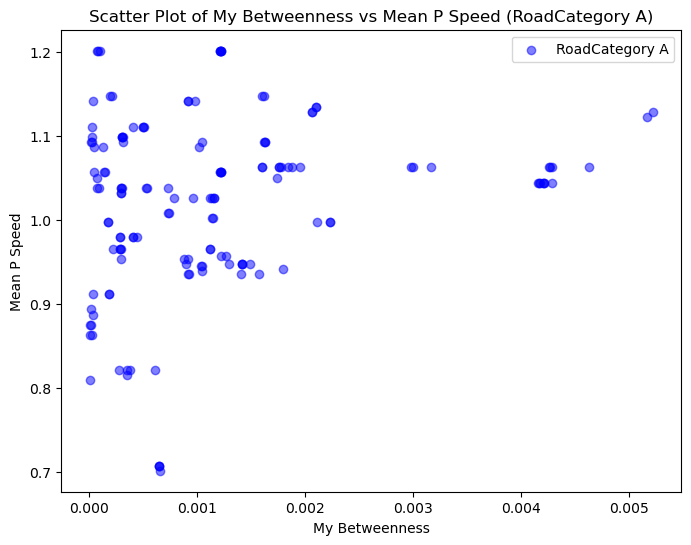

In [51]:
# 过滤出 RoadCategory 为 'A' 的数据
filtered_merged_data = merged_data[merged_data['RoadCategory'] == 'A']

plt.figure(figsize=(8, 6))
plt.scatter(filtered_merged_data['my_betweenness_x'], filtered_merged_data['p_speed'], color='blue', alpha=0.5, label='RoadCategory A')
plt.xlabel('My Betweenness')
plt.ylabel('Mean P Speed')
plt.title('Scatter Plot of My Betweenness vs Mean P Speed (RoadCategory A)')
plt.legend()
plt.show()

In [41]:
# 从 speed_data 中过滤出 RoadCategory 列为 'B' 的数据
B_speed_data = speed_data[speed_data['RoadCategory'] == 'B'].copy()

# 计算 'p_speed' 列的平均值
average_p_speed = B_speed_data['p_speed'].mean()

# 打印平均值
print("Average p_speed for RoadCategory 'B':", average_p_speed)

Average p_speed for RoadCategory 'B': 0.9877678522882912


In [49]:
print(shortest_lengths)

0


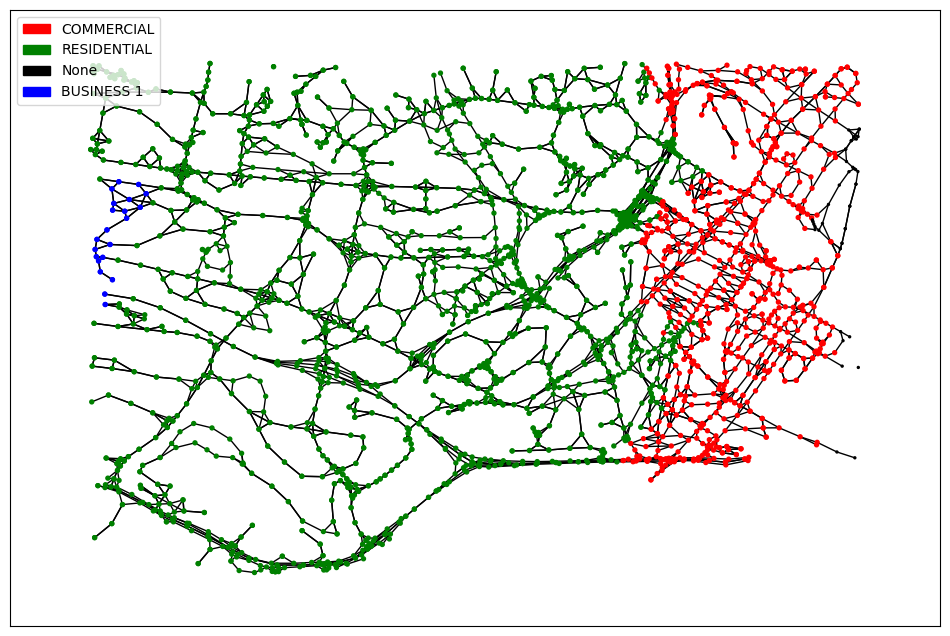

In [38]:
# Extract hours and minutes from the 'RequestTimestamp' column
df_road['Hour'] = df_road['RequestTimestamp'].dt.hour
df_road['Minute'] = df_road['RequestTimestamp'].dt.minute

# Group by hour and minute, calculate mean speed for each group
speed_by_time = df_road.groupby(['Hour', 'Minute'])['p_speed'].mean().reset_index()

# Convert 'SpeedBand' to numeric (in case it's not already numeric)
speed_by_time['p_speed'] = pd.to_numeric(speed_by_time['p_speed'])

# Create a line plot for speed distribution throughout the day
plt.figure(figsize=(12, 6))
plt.plot(speed_by_time['Hour'] + speed_by_time['Minute'] / 60, speed_by_time['p_speed'], marker='o', linestyle='-', color='b')
plt.xlabel('Time (Hour)')
plt.ylabel('Average SpeedBand')
plt.title('Speed Distribution Throughout the Day')
plt.grid(True)
plt.xticks(range(24))
plt.tight_layout()
plt.show()

In [ ]:
rows_with_zero_nodes_around = test[test['No_nodes_around'] == 0]

if not rows_with_zero_nodes_around.empty:
    print("Rows where 'No_nodes_around' is 0:")
    print(rows_with_zero_nodes_around)
else:
    print("No rows found where 'No_nodes_around' is 0.")

In [ ]:
# Extract hours and minutes from the 'RequestTimestamp' column
df_road['Hour'] = df_road['RequestTimestamp'].dt.hour
df_road['Minute'] = df_road['RequestTimestamp'].dt.minute

# Group by RoadCategory, hour, and minute, calculate mean speed and group size for each group
grouped_data = df_road.groupby(['RoadCategory', 'Hour', 'Minute']).agg(p_speed_mean=('p_speed', 'mean'), group_size=('p_speed', 'size')).reset_index()

# Convert 'SpeedBand' to numeric (in case it's not already numeric)
grouped_data['p_speed_mean'] = pd.to_numeric(grouped_data['p_speed_mean'])

# Iterate through unique RoadCategory values and plot separately for each category
for category in df_road['RoadCategory'].unique():
    category_data = grouped_data[grouped_data['RoadCategory'] == category]
    plt.figure(figsize=(12, 6))
    plt.plot(category_data['Hour'] + category_data['Minute'] / 60, category_data['p_speed_mean'], marker='o', linestyle='-', label=f'{category} (Size: {category_data["group_size"].values[0]})')
    plt.xlabel('Time (Hour)')
    plt.ylabel('Average SpeedBand')
    plt.title(f'Speed Distribution Throughout the Day for {category} Roads')
    plt.grid(True)
    plt.xticks(range(24))
    plt.legend()
    plt.tight_layout()
    plt.show()

In [24]:
print(roadnetwork[roadnetwork['group'] == 3]['max_EP_lu'].unique())

['BUSINESS 1']


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

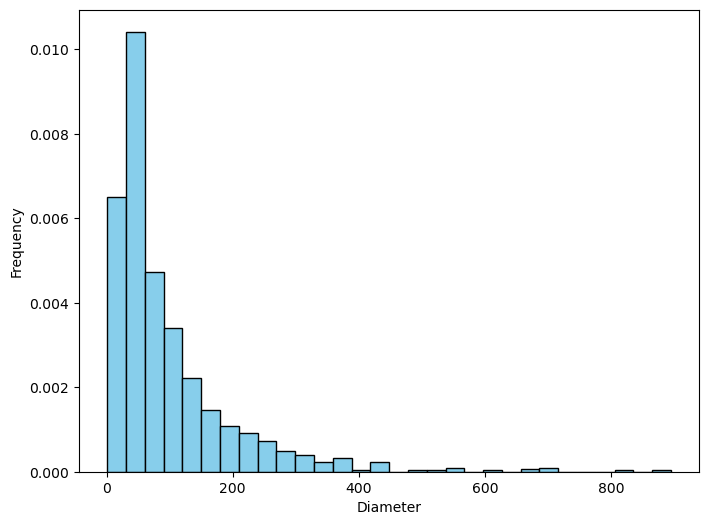

In [43]:
!pip install powerlaw



In [2]:
%cd E:\lu

E:\lu
